In [34]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
np.random.seed(1234)

In [94]:
#Ground truth data distribution
def random_sample(d, Delta, N):
    y = np.ones(N)
    x = np.zeros((N,d))
    successes = np.random.binomial(N, 0.5)
    y[successes:] *= -1
    x[:successes, :] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*d), successes)
    x[successes:, :] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*d), N-successes)
    
    return x.reshape(N,d),y

In [4]:
#non-monotone activation function
def sigma_nm(t):
    if t < 0:
        return -2.5
    elif t>1.5:
        return 7.5
    elif 0<=t<0.5:
        return -3*(t)-2.5
    elif 0.5<=t<=1.5:
        return (11.5)*(t-0.5)-4
        
def grad_sigma_nm(t):
    if t < 0:
        return 0
    elif t>1.5:
        return 0
    elif 0<=t<0.5:
        return -3
    elif 0.5<=t<=1.5:
        return 11.5
vgrad_sigma_nm = np.vectorize(grad_sigma_nm)
vsigma_nm = np.vectorize(sigma_nm)

In [93]:
#two layer neural net with non-monotone activation
def neural_net_nm(x, θ):
    #shape of x: (n,d)
    n = x.shape[0]
    out = vsigma_nm(θ@x.T)
    return np.mean(out, axis = 0).reshape(n,1)

In [28]:
def stochastic_gradient_descent(d, Delta, N, kappa, epsilon = 1e-5, num_epochs = 1000):
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)
    indices = [1,2,5]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    risk = []
    mean_dist = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        x = sample[0].reshape(1,d)
        y = sample[1]
        grad = vgrad_sigma_nm(weights@x.T).reshape(N,1)*x
        step = epsilon*(epsilon*epoch)**(-0.25)
        weights += 2*step*(y-neural_net_nm(x, weights))*grad
        if epoch in indices:
        #population risk
            M = int(1e4)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample-neural_net_nm(x_sample,weights))**2)
            risk.append(mse)
            dist = np.mean(np.linalg.norm(weights, axis = 1))
            mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_dist, indices

In [7]:
from scipy.stats import norm

def q_plus(t, Delta):
    if t>0.01:
        x = np.linspace(0, 1.5/((1+Delta)*t), 1000)
        f = 1 / (np.sqrt(2 * np.pi)) * vsigma_nm((1 + Delta) * t * x) * np.exp(-x ** 2 / 2)
        integral = np.trapz(f, x)
        return integral -2.5*0.5+7.5*(1-norm.cdf(1.5/((1+Delta)*t)))
    else:
        g = np.random.normal(0,1,100)
        return np.mean(vsigma_nm((1+Delta)*t*g))

def q_minus(t, Delta):
    if t > 0.01:
        x = np.linspace(0, 1.5/((1-Delta)*t), 1000)
        f = 1 / (np.sqrt(2 * np.pi)) * vsigma_nm((1 - Delta) * t * x) * np.exp(-x ** 2 / 2)
        integral = np.trapz(f, x)
        return integral -2.5*0.5+7.5*(1-norm.cdf(1.5/((1-Delta)*t)))
    else:
        g = np.random.normal(0,1,100)
        return np.mean(vsigma_nm((1-Delta)*t*g))
    #return integral

vq_plus = np.vectorize(q_plus)
vq_minus = np.vectorize(q_minus)

def dq_plus(t, Delta):
    x1 = np.linspace(0, 0.5/((1+Delta)*t), 100)
    f1 = (1+Delta) / (np.sqrt(2 * np.pi)) * (-4+2.5)/(0.5) * np.exp(-x1 ** 2 / 2)*x1
    integral1 = np.trapz(f1, x1)
    x2 = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f2 = (1+Delta) / (np.sqrt(2 * np.pi)) * 11.5 * np.exp(-x2 ** 2 / 2)*x2
    integral2 = np.trapz(f2, x2)
    return integral1+integral2

def dq_minus(t, Delta):
    x1 = np.linspace(0, 0.5/((1-Delta)*t), 100)
    f1 = (1-Delta) / (np.sqrt(2 * np.pi)) * (-4+2.5)/(0.5) * np.exp(-x1 ** 2 / 2)*x1
    integral1 = np.trapz(f1, x1)
    x2 = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f2 = (1-Delta) / (np.sqrt(2 * np.pi)) * 11.5 * np.exp(-x2 ** 2 / 2)*x2
    integral2 = np.trapz(f2, x2)
    return integral1+integral2
    
vdq_plus = np.vectorize(dq_plus)
vdq_minus = np.vectorize(dq_minus)

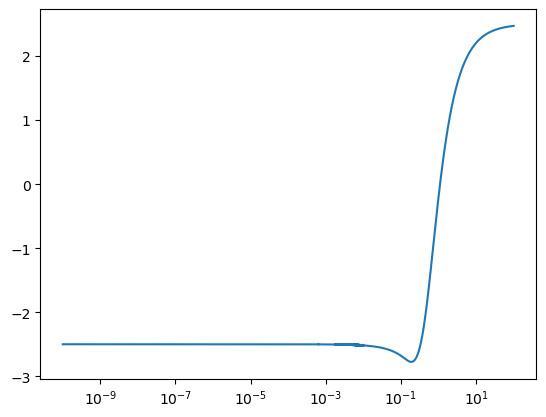

In [8]:
epsilon = 1e-5
Delta = 0.5
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_plus_vals = vq_plus(Interval_q, Delta)
plt.plot(Interval_q, q_plus_vals)
plt.xscale('log')

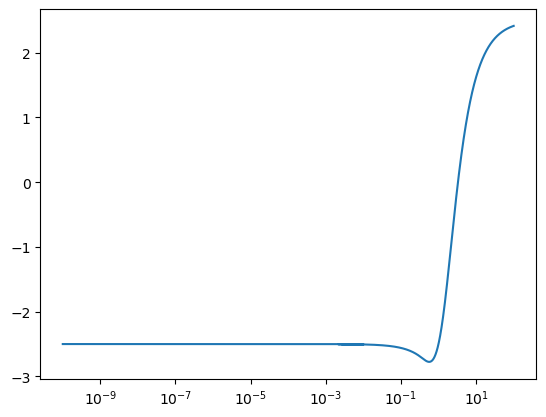

In [9]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_minus_vals = vq_minus(Interval_q, Delta)
plt.plot(Interval_q, q_minus_vals)
plt.xscale('log')

In [10]:
Q_plus = dict(zip(Interval_q, q_plus_vals))
Q_minus = dict(zip(Interval_q, q_minus_vals))

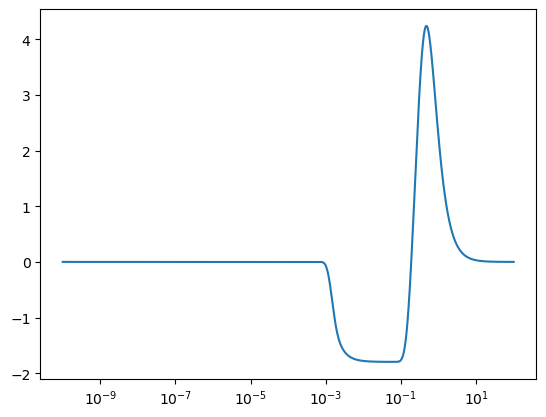

In [11]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_plus_vals = vdq_plus(Interval_q, Delta)
plt.plot(Interval_q, dq_plus_vals)
plt.xscale('log')

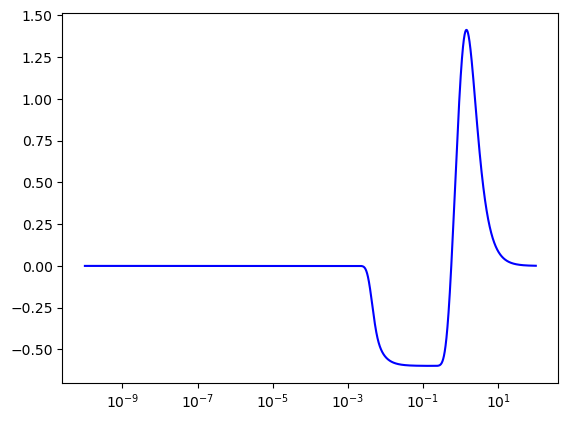

In [12]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_minus_vals = vdq_minus(Interval_q, Delta)
plt.plot(Interval_q, dq_minus_vals, c = 'b')
plt.xscale('log')

In [13]:
dQ_plus = dict(zip(Interval_q, dq_plus_vals))
dQ_minus = dict(zip(Interval_q, dq_minus_vals))

In [14]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
vfind_nearest = np.vectorize(find_nearest)

In [15]:
def q_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_plus[r_approx]

def q_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_minus[r_approx]

vq_plus_new = np.vectorize(q_plus_new)
vq_minus_new = np.vectorize(q_minus_new)

def dq_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_plus[r_approx]

def dq_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_minus[r_approx]

vdq_plus_new = np.vectorize(dq_plus_new)
vdq_minus_new = np.vectorize(dq_minus_new)


def R_inf(vq_plus, vq_minus, Delta):
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return 0.5 * (1 - mean_vq_plus) ** 2 + 0.5 * (1 + mean_vq_minus) ** 2

def grad_R_inf(r, vq_plus, vq_minus, dplus, dminus, Delta):
    J = len(r)
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return -1 / J * dplus * (1 - mean_vq_plus) + 1 / J * dminus * (1 + mean_vq_minus)

def update(r, dt, grad):
    J = len(r)
    return J * grad * dt

In [84]:
#simulate pde
def pde_sim(kappa, d, J, epsilon = 1e-5, Delta = 0.5):
    Interval = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
    separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]
    processes_count = 4
    risk = np.zeros(Interval.shape[0])
    Z = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), J).reshape(J, d)
    r = np.linalg.norm(Z, axis = 1)
    mean_dist = []
    for k in trange(len(separations)):
        dt = separations[k]
        plus = vq_plus(r, Delta)
        minus = vq_minus(r, Delta)
        dplus = vdq_plus(r, Delta)
        dminus = vdq_minus(r, Delta)
        '''
        output = parallelise(r).reshape(4,J)
        plus = output[0]
        minus = output[1]
        dplus = output[2]
        dminus = output[3]
        '''
        inf_risk = R_inf(plus, minus, Delta)
        risk[k] = inf_risk
        d = np.mean(r)
        mean_dist.append(d)
        print('Epoch: {}, risk: {}'.format(k, inf_risk))
        grad = grad_R_inf(r, plus, minus, dplus, dminus, Delta)
        r = r - (Interval[k])**(-0.25)*update(r,dt, grad)
    plus = vq_plus(r, Delta)
    minus = vq_minus(r, Delta)
    inf_risk = R_inf(plus, minus, Delta)
    risk[-1] = inf_risk
    mean_dist.append(np.mean(r))
    return risk, mean_dist

In [202]:
#SGD run
d = 320
N = 800
Delta = 0.5

weights_4,risk_4, mean_dist_sgd_4, indices = stochastic_gradient_descent(d, Delta, N, 0.4, epsilon = (1e-5), num_epochs = int(1e3))

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1, risk: 7.608586933566098
Epoch: 2, risk: 7.554756771747369
Epoch: 5, risk: 7.258462441395809
Epoch: 12, risk: 6.959547822244396
Epoch: 15, risk: 6.981989653918742
Epoch: 19, risk: 6.8863738245515345
Epoch: 25, risk: 6.766155212654456
Epoch: 31, risk: 6.604634493593941
Epoch: 39, risk: 6.406040252594783
Epoch: 50, risk: 6.312230017208037
Epoch: 63, risk: 6.102706751048844
Epoch: 79, risk: 5.986550648271402
Epoch: 100, risk: 5.822705558587186
Epoch: 125, risk: 5.62016211013027
Epoch: 158, risk: 5.466791091523444
Epoch: 199, risk: 5.25058218482513
Epoch: 251, risk: 5.048770476439061
Epoch: 316, risk: 4.871830593499358
Epoch: 398, risk: 4.6591413411408835
Epoch: 501, risk: 4.449698299749506
Epoch: 630, risk: 4.234564528139273
Epoch: 794, risk: 4.037941635647115
Epoch: 1000, risk: 3.8433428077097966


In [ ]:
weights_1,risk_1, mean_dist_sgd_1, indices = stochastic_gradient_descent(d, Delta, N, 0.1, epsilon = (1e-5), num_epochs = int(1e3))

In [201]:
#pde_risk_1, mean_dist_pde_1 = pde_sim(0.1, 320, 400, epsilon = 1e-5, Delta = 0.5)
pde_risk_4, mean_dist_pde_4 = pde_sim(0.4, 320, 1, epsilon = (1e-5), Delta = 0.5)

  0%|          | 0/99999 [00:00<?, ?it/s]

Epoch: 0, risk: 7.395063442100232
Epoch: 1, risk: 7.3950634410506
Epoch: 2, risk: 7.395063440000747
Epoch: 3, risk: 7.39506343895068
Epoch: 4, risk: 7.395063437900393
Epoch: 5, risk: 7.395063436849888
Epoch: 6, risk: 7.395063435799167
Epoch: 7, risk: 7.395063434748227
Epoch: 8, risk: 7.3950634336970715
Epoch: 9, risk: 7.395063432645696
Epoch: 10, risk: 7.395063431594103
Epoch: 11, risk: 7.395063430542289
Epoch: 12, risk: 7.395063429490262
Epoch: 13, risk: 7.395063428438013
Epoch: 14, risk: 7.39506342738555
Epoch: 15, risk: 7.395063426332866
Epoch: 16, risk: 7.395063425279966
Epoch: 17, risk: 7.395063424226844
Epoch: 18, risk: 7.395063423173506
Epoch: 19, risk: 7.39506342211995
Epoch: 20, risk: 7.395063421066176
Epoch: 21, risk: 7.395063420012183
Epoch: 22, risk: 7.395063418957974
Epoch: 23, risk: 7.3950634179035415
Epoch: 24, risk: 7.395063416848892
Epoch: 25, risk: 7.395063415794026
Epoch: 26, risk: 7.395063414738939
Epoch: 27, risk: 7.395063413683635
Epoch: 28, risk: 7.39506341262811

Epoch: 258, risk: 7.395063163953289
Epoch: 259, risk: 7.395063162846007
Epoch: 260, risk: 7.395063161738497
Epoch: 261, risk: 7.395063160630758
Epoch: 262, risk: 7.395063159522786
Epoch: 263, risk: 7.3950631584145885
Epoch: 264, risk: 7.395063157306156
Epoch: 265, risk: 7.395063156197497
Epoch: 266, risk: 7.395063155088608
Epoch: 267, risk: 7.395063153979491
Epoch: 268, risk: 7.39506315287014
Epoch: 269, risk: 7.395063151760562
Epoch: 270, risk: 7.3950631506507545
Epoch: 271, risk: 7.395063149540716
Epoch: 272, risk: 7.395063148430445
Epoch: 273, risk: 7.395063147319951
Epoch: 274, risk: 7.395063146209221
Epoch: 275, risk: 7.395063145098263
Epoch: 276, risk: 7.3950631439870715
Epoch: 277, risk: 7.395063142875651
Epoch: 278, risk: 7.395063141764003
Epoch: 279, risk: 7.395063140652123
Epoch: 280, risk: 7.39506313954001
Epoch: 281, risk: 7.395063138427672
Epoch: 282, risk: 7.395063137315099
Epoch: 283, risk: 7.395063136202296
Epoch: 284, risk: 7.395063135089265
Epoch: 285, risk: 7.3950631

Epoch: 498, risk: 7.395062891514374
Epoch: 499, risk: 7.39506289035063
Epoch: 500, risk: 7.395062889186642
Epoch: 501, risk: 7.39506288802241
Epoch: 502, risk: 7.395062886857942
Epoch: 503, risk: 7.395062885693228
Epoch: 504, risk: 7.3950628845282775
Epoch: 505, risk: 7.395062883363084
Epoch: 506, risk: 7.395062882197649
Epoch: 507, risk: 7.39506288103197
Epoch: 508, risk: 7.395062879866051
Epoch: 509, risk: 7.395062878699891
Epoch: 510, risk: 7.3950628775334915
Epoch: 511, risk: 7.395062876366847
Epoch: 512, risk: 7.395062875199962
Epoch: 513, risk: 7.395062874032835
Epoch: 514, risk: 7.395062872865462
Epoch: 515, risk: 7.39506287169785
Epoch: 516, risk: 7.395062870529997
Epoch: 517, risk: 7.3950628693619045
Epoch: 518, risk: 7.395062868193564
Epoch: 519, risk: 7.395062867024985
Epoch: 520, risk: 7.395062865856164
Epoch: 521, risk: 7.395062864687102
Epoch: 522, risk: 7.395062863517794
Epoch: 523, risk: 7.3950628623482455
Epoch: 524, risk: 7.395062861178454
Epoch: 525, risk: 7.39506286

Epoch: 747, risk: 7.395062594165739
Epoch: 748, risk: 7.395062592940367
Epoch: 749, risk: 7.39506259171474
Epoch: 750, risk: 7.395062590488859
Epoch: 751, risk: 7.3950625892627215
Epoch: 752, risk: 7.395062588036332
Epoch: 753, risk: 7.395062586809686
Epoch: 754, risk: 7.3950625855827905
Epoch: 755, risk: 7.39506258435564
Epoch: 756, risk: 7.39506258312823
Epoch: 757, risk: 7.395062581900571
Epoch: 758, risk: 7.395062580672653
Epoch: 759, risk: 7.395062579444483
Epoch: 760, risk: 7.395062578216056
Epoch: 761, risk: 7.395062576987376
Epoch: 762, risk: 7.3950625757584465
Epoch: 763, risk: 7.395062574529259
Epoch: 764, risk: 7.395062573299811
Epoch: 765, risk: 7.395062572070117
Epoch: 766, risk: 7.395062570840162
Epoch: 767, risk: 7.395062569609951
Epoch: 768, risk: 7.395062568379491
Epoch: 769, risk: 7.395062567148772
Epoch: 770, risk: 7.395062565917797
Epoch: 771, risk: 7.395062564686569
Epoch: 772, risk: 7.395062563455086
Epoch: 773, risk: 7.395062562223348
Epoch: 774, risk: 7.39506256

Epoch: 978, risk: 7.395062304249775
Epoch: 979, risk: 7.3950623029643126
Epoch: 980, risk: 7.395062301678585
Epoch: 981, risk: 7.395062300392593
Epoch: 982, risk: 7.395062299106331
Epoch: 983, risk: 7.395062297819806
Epoch: 984, risk: 7.395062296533012
Epoch: 985, risk: 7.395062295245952
Epoch: 986, risk: 7.395062293958626
Epoch: 987, risk: 7.39506229267103
Epoch: 988, risk: 7.395062291383169
Epoch: 989, risk: 7.395062290095042
Epoch: 990, risk: 7.395062288806651
Epoch: 991, risk: 7.395062287517986
Epoch: 992, risk: 7.3950622862290585
Epoch: 993, risk: 7.395062284939864
Epoch: 994, risk: 7.3950622836503985
Epoch: 995, risk: 7.39506228236067
Epoch: 996, risk: 7.395062281070672
Epoch: 997, risk: 7.395062279780407
Epoch: 998, risk: 7.395062278489872
Epoch: 999, risk: 7.3950622771990755
Epoch: 1000, risk: 7.395062275908007
Epoch: 1001, risk: 7.395062274616674
Epoch: 1002, risk: 7.395062273325069
Epoch: 1003, risk: 7.395062272033197
Epoch: 1004, risk: 7.395062270741063
Epoch: 1005, risk: 7.

Epoch: 1225, risk: 7.395061978508088
Epoch: 1226, risk: 7.395061977155115
Epoch: 1227, risk: 7.3950619758018625
Epoch: 1228, risk: 7.3950619744483275
Epoch: 1229, risk: 7.3950619730945135
Epoch: 1230, risk: 7.39506197174042
Epoch: 1231, risk: 7.395061970386042
Epoch: 1232, risk: 7.395061969031384
Epoch: 1233, risk: 7.39506196767645
Epoch: 1234, risk: 7.395061966321232
Epoch: 1235, risk: 7.395061964965732
Epoch: 1236, risk: 7.395061963609949
Epoch: 1237, risk: 7.395061962253893
Epoch: 1238, risk: 7.395061960897549
Epoch: 1239, risk: 7.395061959540927
Epoch: 1240, risk: 7.395061958184023
Epoch: 1241, risk: 7.395061956826838
Epoch: 1242, risk: 7.39506195546937
Epoch: 1243, risk: 7.395061954111623
Epoch: 1244, risk: 7.395061952753592
Epoch: 1245, risk: 7.395061951395284
Epoch: 1246, risk: 7.395061950036689
Epoch: 1247, risk: 7.395061948677817
Epoch: 1248, risk: 7.395061947318664
Epoch: 1249, risk: 7.395061945959227
Epoch: 1250, risk: 7.395061944599506
Epoch: 1251, risk: 7.395061943239505
E

Epoch: 1466, risk: 7.395061644196497
Epoch: 1467, risk: 7.3950616427742375
Epoch: 1468, risk: 7.395061641351677
Epoch: 1469, risk: 7.395061639928828
Epoch: 1470, risk: 7.395061638505684
Epoch: 1471, risk: 7.395061637082241
Epoch: 1472, risk: 7.395061635658506
Epoch: 1473, risk: 7.395061634234477
Epoch: 1474, risk: 7.39506163281015
Epoch: 1475, risk: 7.395061631385529
Epoch: 1476, risk: 7.395061629960614
Epoch: 1477, risk: 7.395061628535401
Epoch: 1478, risk: 7.395061627109893
Epoch: 1479, risk: 7.395061625684092
Epoch: 1480, risk: 7.395061624257992
Epoch: 1481, risk: 7.395061622831597
Epoch: 1482, risk: 7.395061621404911
Epoch: 1483, risk: 7.395061619977925
Epoch: 1484, risk: 7.395061618550645
Epoch: 1485, risk: 7.395061617123068
Epoch: 1486, risk: 7.395061615695196
Epoch: 1487, risk: 7.395061614267026
Epoch: 1488, risk: 7.395061612838563
Epoch: 1489, risk: 7.395061611409801
Epoch: 1490, risk: 7.395061609980744
Epoch: 1491, risk: 7.3950616085513925
Epoch: 1492, risk: 7.395061607121744


Epoch: 1719, risk: 7.395061274802519
Epoch: 1720, risk: 7.395061273303701
Epoch: 1721, risk: 7.395061271804568
Epoch: 1722, risk: 7.395061270305124
Epoch: 1723, risk: 7.395061268805373
Epoch: 1724, risk: 7.395061267305306
Epoch: 1725, risk: 7.395061265804934
Epoch: 1726, risk: 7.39506126430425
Epoch: 1727, risk: 7.3950612628032495
Epoch: 1728, risk: 7.395061261301944
Epoch: 1729, risk: 7.395061259800325
Epoch: 1730, risk: 7.395061258298394
Epoch: 1731, risk: 7.395061256796153
Epoch: 1732, risk: 7.395061255293601
Epoch: 1733, risk: 7.395061253790737
Epoch: 1734, risk: 7.39506125228756
Epoch: 1735, risk: 7.395061250784073
Epoch: 1736, risk: 7.395061249280274
Epoch: 1737, risk: 7.395061247776162
Epoch: 1738, risk: 7.395061246271744
Epoch: 1739, risk: 7.395061244767008
Epoch: 1740, risk: 7.395061243261963
Epoch: 1741, risk: 7.395061241756608
Epoch: 1742, risk: 7.395061240250935
Epoch: 1743, risk: 7.395061238744953
Epoch: 1744, risk: 7.395061237238659
Epoch: 1745, risk: 7.395061235732054
Ep

Epoch: 1984, risk: 7.395060866548658
Epoch: 1985, risk: 7.395060864965224
Epoch: 1986, risk: 7.3950608633814605
Epoch: 1987, risk: 7.395060861797371
Epoch: 1988, risk: 7.395060860212952
Epoch: 1989, risk: 7.395060858628204
Epoch: 1990, risk: 7.395060857043129
Epoch: 1991, risk: 7.395060855457724
Epoch: 1992, risk: 7.3950608538719935
Epoch: 1993, risk: 7.395060852285932
Epoch: 1994, risk: 7.395060850699539
Epoch: 1995, risk: 7.39506084911282
Epoch: 1996, risk: 7.395060847525772
Epoch: 1997, risk: 7.395060845938394
Epoch: 1998, risk: 7.395060844350688
Epoch: 1999, risk: 7.395060842762654
Epoch: 2000, risk: 7.395060841174289
Epoch: 2001, risk: 7.395060839585595
Epoch: 2002, risk: 7.3950608379965725
Epoch: 2003, risk: 7.395060836407222
Epoch: 2004, risk: 7.39506083481754
Epoch: 2005, risk: 7.395060833227531
Epoch: 2006, risk: 7.39506083163719
Epoch: 2007, risk: 7.39506083004652
Epoch: 2008, risk: 7.395060828455521
Epoch: 2009, risk: 7.395060826864191
Epoch: 2010, risk: 7.39506082527253
Epo

Epoch: 2266, risk: 7.3950604067622825
Epoch: 2267, risk: 7.395060405083556
Epoch: 2268, risk: 7.395060403404479
Epoch: 2269, risk: 7.395060401725054
Epoch: 2270, risk: 7.39506040004528
Epoch: 2271, risk: 7.395060398365162
Epoch: 2272, risk: 7.395060396684692
Epoch: 2273, risk: 7.395060395003876
Epoch: 2274, risk: 7.395060393322711
Epoch: 2275, risk: 7.395060391641198
Epoch: 2276, risk: 7.395060389959338
Epoch: 2277, risk: 7.395060388277125
Epoch: 2278, risk: 7.395060386594566
Epoch: 2279, risk: 7.395060384911659
Epoch: 2280, risk: 7.395060383228401
Epoch: 2281, risk: 7.395060381544797
Epoch: 2282, risk: 7.395060379860842
Epoch: 2283, risk: 7.395060378176537
Epoch: 2284, risk: 7.395060376491887
Epoch: 2285, risk: 7.395060374806883
Epoch: 2286, risk: 7.395060373121534
Epoch: 2287, risk: 7.3950603714358305
Epoch: 2288, risk: 7.395060369749782
Epoch: 2289, risk: 7.395060368063381
Epoch: 2290, risk: 7.395060366376633
Epoch: 2291, risk: 7.395060364689535
Epoch: 2292, risk: 7.395060363002084


Epoch: 2535, risk: 7.395059942408439
Epoch: 2536, risk: 7.395059940633469
Epoch: 2537, risk: 7.395059938858131
Epoch: 2538, risk: 7.395059937082428
Epoch: 2539, risk: 7.395059935306353
Epoch: 2540, risk: 7.395059933529913
Epoch: 2541, risk: 7.3950599317531065
Epoch: 2542, risk: 7.395059929975928
Epoch: 2543, risk: 7.395059928198381
Epoch: 2544, risk: 7.395059926420467
Epoch: 2545, risk: 7.395059924642187
Epoch: 2546, risk: 7.395059922863534
Epoch: 2547, risk: 7.395059921084514
Epoch: 2548, risk: 7.395059919305125
Epoch: 2549, risk: 7.395059917525367
Epoch: 2550, risk: 7.395059915745243
Epoch: 2551, risk: 7.39505991396475
Epoch: 2552, risk: 7.395059912183887
Epoch: 2553, risk: 7.395059910402649
Epoch: 2554, risk: 7.39505990862105
Epoch: 2555, risk: 7.395059906839077
Epoch: 2556, risk: 7.395059905056737
Epoch: 2557, risk: 7.395059903274029
Epoch: 2558, risk: 7.3950599014909475
Epoch: 2559, risk: 7.3950598997074986
Epoch: 2560, risk: 7.395059897923682
Epoch: 2561, risk: 7.395059896139493


Epoch: 2809, risk: 7.395059442045895
Epoch: 2810, risk: 7.395059440167227
Epoch: 2811, risk: 7.395059438288163
Epoch: 2812, risk: 7.395059436408713
Epoch: 2813, risk: 7.39505943452887
Epoch: 2814, risk: 7.395059432648639
Epoch: 2815, risk: 7.395059430768022
Epoch: 2816, risk: 7.395059428887011
Epoch: 2817, risk: 7.395059427005613
Epoch: 2818, risk: 7.395059425123821
Epoch: 2819, risk: 7.395059423241642
Epoch: 2820, risk: 7.395059421359072
Epoch: 2821, risk: 7.395059419476112
Epoch: 2822, risk: 7.395059417592763
Epoch: 2823, risk: 7.395059415709022
Epoch: 2824, risk: 7.395059413824892
Epoch: 2825, risk: 7.39505941194037
Epoch: 2826, risk: 7.395059410055457
Epoch: 2827, risk: 7.395059408170155
Epoch: 2828, risk: 7.395059406284462
Epoch: 2829, risk: 7.395059404398379
Epoch: 2830, risk: 7.395059402511901
Epoch: 2831, risk: 7.395059400625037
Epoch: 2832, risk: 7.395059398737779
Epoch: 2833, risk: 7.395059396850131
Epoch: 2834, risk: 7.3950593949620895
Epoch: 2835, risk: 7.395059393073662
Ep

Epoch: 3081, risk: 7.395058916424992
Epoch: 3082, risk: 7.395058914437381
Epoch: 3083, risk: 7.395058912449356
Epoch: 3084, risk: 7.395058910460922
Epoch: 3085, risk: 7.395058908472076
Epoch: 3086, risk: 7.3950589064828165
Epoch: 3087, risk: 7.395058904493143
Epoch: 3088, risk: 7.395058902503058
Epoch: 3089, risk: 7.395058900512559
Epoch: 3090, risk: 7.395058898521653
Epoch: 3091, risk: 7.395058896530331
Epoch: 3092, risk: 7.395058894538598
Epoch: 3093, risk: 7.39505889254645
Epoch: 3094, risk: 7.39505889055389
Epoch: 3095, risk: 7.395058888560917
Epoch: 3096, risk: 7.395058886567532
Epoch: 3097, risk: 7.395058884573736
Epoch: 3098, risk: 7.395058882579521
Epoch: 3099, risk: 7.3950588805848945
Epoch: 3100, risk: 7.395058878589855
Epoch: 3101, risk: 7.395058876594403
Epoch: 3102, risk: 7.395058874598535
Epoch: 3103, risk: 7.395058872602255
Epoch: 3104, risk: 7.395058870605564
Epoch: 3105, risk: 7.395058868608457
Epoch: 3106, risk: 7.395058866610935
Epoch: 3107, risk: 7.395058864612998
E

Epoch: 3332, risk: 7.395058404384566
Epoch: 3333, risk: 7.395058402290829
Epoch: 3334, risk: 7.395058400196662
Epoch: 3335, risk: 7.395058398102058
Epoch: 3336, risk: 7.395058396007022
Epoch: 3337, risk: 7.395058393911549
Epoch: 3338, risk: 7.395058391815645
Epoch: 3339, risk: 7.395058389719303
Epoch: 3340, risk: 7.39505838762253
Epoch: 3341, risk: 7.395058385525317
Epoch: 3342, risk: 7.395058383427676
Epoch: 3343, risk: 7.395058381329598
Epoch: 3344, risk: 7.3950583792310844
Epoch: 3345, risk: 7.395058377132136
Epoch: 3346, risk: 7.395058375032752
Epoch: 3347, risk: 7.3950583729329376
Epoch: 3348, risk: 7.395058370832682
Epoch: 3349, risk: 7.395058368731993
Epoch: 3350, risk: 7.395058366630866
Epoch: 3351, risk: 7.395058364529305
Epoch: 3352, risk: 7.39505836242731
Epoch: 3353, risk: 7.395058360324882
Epoch: 3354, risk: 7.395058358222015
Epoch: 3355, risk: 7.395058356118712
Epoch: 3356, risk: 7.395058354014973
Epoch: 3357, risk: 7.395058351910797
Epoch: 3358, risk: 7.395058349806187
E

Epoch: 3557, risk: 7.395057922188412
Epoch: 3558, risk: 7.395057919994737
Epoch: 3559, risk: 7.39505791780061
Epoch: 3560, risk: 7.395057915606024
Epoch: 3561, risk: 7.3950579134109855
Epoch: 3562, risk: 7.395057911215495
Epoch: 3563, risk: 7.395057909019545
Epoch: 3564, risk: 7.395057906823144
Epoch: 3565, risk: 7.395057904626286
Epoch: 3566, risk: 7.395057902428972
Epoch: 3567, risk: 7.395057900231201
Epoch: 3568, risk: 7.39505789803298
Epoch: 3569, risk: 7.395057895834297
Epoch: 3570, risk: 7.395057893635164
Epoch: 3571, risk: 7.395057891435572
Epoch: 3572, risk: 7.395057889235522
Epoch: 3573, risk: 7.395057887035019
Epoch: 3574, risk: 7.395057884834062
Epoch: 3575, risk: 7.395057882632644
Epoch: 3576, risk: 7.395057880430772
Epoch: 3577, risk: 7.395057878228442
Epoch: 3578, risk: 7.395057876025658
Epoch: 3579, risk: 7.395057873822417
Epoch: 3580, risk: 7.395057871618722
Epoch: 3581, risk: 7.395057869414564
Epoch: 3582, risk: 7.395057867209953
Epoch: 3583, risk: 7.395057865004885
Ep

Epoch: 3811, risk: 7.395057350129102
Epoch: 3812, risk: 7.395057347816866
Epoch: 3813, risk: 7.39505734550415
Epoch: 3814, risk: 7.395057343190954
Epoch: 3815, risk: 7.395057340877276
Epoch: 3816, risk: 7.395057338563123
Epoch: 3817, risk: 7.39505733624849
Epoch: 3818, risk: 7.395057333933377
Epoch: 3819, risk: 7.395057331617782
Epoch: 3820, risk: 7.395057329301707
Epoch: 3821, risk: 7.395057326985155
Epoch: 3822, risk: 7.3950573246681195
Epoch: 3823, risk: 7.395057322350605
Epoch: 3824, risk: 7.395057320032612
Epoch: 3825, risk: 7.395057317714134
Epoch: 3826, risk: 7.395057315395182
Epoch: 3827, risk: 7.395057313075743
Epoch: 3828, risk: 7.395057310755826
Epoch: 3829, risk: 7.395057308435431
Epoch: 3830, risk: 7.395057306114552
Epoch: 3831, risk: 7.395057303793193
Epoch: 3832, risk: 7.395057301471351
Epoch: 3833, risk: 7.395057299149029
Epoch: 3834, risk: 7.3950572968262245
Epoch: 3835, risk: 7.395057294502942
Epoch: 3836, risk: 7.395057292179175
Epoch: 3837, risk: 7.39505728985493
Ep

Epoch: 4068, risk: 7.395056739838052
Epoch: 4069, risk: 7.395056737399324
Epoch: 4070, risk: 7.395056734960095
Epoch: 4071, risk: 7.395056732520358
Epoch: 4072, risk: 7.395056730080121
Epoch: 4073, risk: 7.395056727639371
Epoch: 4074, risk: 7.395056725198119
Epoch: 4075, risk: 7.395056722756362
Epoch: 4076, risk: 7.395056720314094
Epoch: 4077, risk: 7.395056717871325
Epoch: 4078, risk: 7.395056715428048
Epoch: 4079, risk: 7.395056712984262
Epoch: 4080, risk: 7.395056710539975
Epoch: 4081, risk: 7.3950567080951775
Epoch: 4082, risk: 7.395056705649873
Epoch: 4083, risk: 7.395056703204064
Epoch: 4084, risk: 7.3950567007577455
Epoch: 4085, risk: 7.395056698310921
Epoch: 4086, risk: 7.39505669586359
Epoch: 4087, risk: 7.395056693415754
Epoch: 4088, risk: 7.395056690967405
Epoch: 4089, risk: 7.395056688518553
Epoch: 4090, risk: 7.3950566860691955
Epoch: 4091, risk: 7.395056683619324
Epoch: 4092, risk: 7.395056681168949
Epoch: 4093, risk: 7.395056678718065
Epoch: 4094, risk: 7.395056676266672

Epoch: 4305, risk: 7.395056147492822
Epoch: 4306, risk: 7.3950561449313295
Epoch: 4307, risk: 7.395056142369308
Epoch: 4308, risk: 7.395056139806754
Epoch: 4309, risk: 7.395056137243666
Epoch: 4310, risk: 7.395056134680052
Epoch: 4311, risk: 7.395056132115904
Epoch: 4312, risk: 7.395056129551224
Epoch: 4313, risk: 7.395056126986013
Epoch: 4314, risk: 7.39505612442027
Epoch: 4315, risk: 7.395056121853994
Epoch: 4316, risk: 7.39505611928719
Epoch: 4317, risk: 7.395056116719851
Epoch: 4318, risk: 7.395056114151981
Epoch: 4319, risk: 7.39505611158358
Epoch: 4320, risk: 7.395056109014644
Epoch: 4321, risk: 7.395056106445178
Epoch: 4322, risk: 7.395056103875178
Epoch: 4323, risk: 7.395056101304646
Epoch: 4324, risk: 7.395056098733579
Epoch: 4325, risk: 7.39505609616198
Epoch: 4326, risk: 7.395056093589851
Epoch: 4327, risk: 7.395056091017185
Epoch: 4328, risk: 7.395056088443985
Epoch: 4329, risk: 7.395056085870257
Epoch: 4330, risk: 7.3950560832959935
Epoch: 4331, risk: 7.395056080721197
Epo

Epoch: 4539, risk: 7.395055533396295
Epoch: 4540, risk: 7.395055530707529
Epoch: 4541, risk: 7.395055528018203
Epoch: 4542, risk: 7.395055525328321
Epoch: 4543, risk: 7.395055522637879
Epoch: 4544, risk: 7.395055519946882
Epoch: 4545, risk: 7.395055517255326
Epoch: 4546, risk: 7.395055514563213
Epoch: 4547, risk: 7.395055511870539
Epoch: 4548, risk: 7.395055509177311
Epoch: 4549, risk: 7.39505550648352
Epoch: 4550, risk: 7.395055503789177
Epoch: 4551, risk: 7.395055501094271
Epoch: 4552, risk: 7.395055498398806
Epoch: 4553, risk: 7.3950554957027865
Epoch: 4554, risk: 7.395055493006203
Epoch: 4555, risk: 7.3950554903090655
Epoch: 4556, risk: 7.3950554876113666
Epoch: 4557, risk: 7.395055484913107
Epoch: 4558, risk: 7.395055482214293
Epoch: 4559, risk: 7.395055479514914
Epoch: 4560, risk: 7.3950554768149805
Epoch: 4561, risk: 7.395055474114482
Epoch: 4562, risk: 7.3950554714134284
Epoch: 4563, risk: 7.395055468711814
Epoch: 4564, risk: 7.39505546600964
Epoch: 4565, risk: 7.39505546330690

Epoch: 4835, risk: 7.395054712688778
Epoch: 4836, risk: 7.395054709829916
Epoch: 4837, risk: 7.395054706970455
Epoch: 4838, risk: 7.395054704110406
Epoch: 4839, risk: 7.395054701249761
Epoch: 4840, risk: 7.395054698388524
Epoch: 4841, risk: 7.395054695526692
Epoch: 4842, risk: 7.39505469266427
Epoch: 4843, risk: 7.395054689801255
Epoch: 4844, risk: 7.395054686937645
Epoch: 4845, risk: 7.3950546840734415
Epoch: 4846, risk: 7.395054681208644
Epoch: 4847, risk: 7.395054678343254
Epoch: 4848, risk: 7.395054675477269
Epoch: 4849, risk: 7.395054672610691
Epoch: 4850, risk: 7.395054669743518
Epoch: 4851, risk: 7.3950546668757475
Epoch: 4852, risk: 7.395054664007389
Epoch: 4853, risk: 7.39505466113843
Epoch: 4854, risk: 7.395054658268884
Epoch: 4855, risk: 7.395054655398737
Epoch: 4856, risk: 7.395054652527998
Epoch: 4857, risk: 7.39505464965666
Epoch: 4858, risk: 7.3950546467847325
Epoch: 4859, risk: 7.3950546439122045
Epoch: 4860, risk: 7.395054641039084
Epoch: 4861, risk: 7.395054638165369


Epoch: 5085, risk: 7.395053979209929
Epoch: 5086, risk: 7.395053976199043
Epoch: 5087, risk: 7.395053973187534
Epoch: 5088, risk: 7.395053970175402
Epoch: 5089, risk: 7.395053967162644
Epoch: 5090, risk: 7.395053964149262
Epoch: 5091, risk: 7.395053961135255
Epoch: 5092, risk: 7.3950539581206245
Epoch: 5093, risk: 7.395053955105367
Epoch: 5094, risk: 7.395053952089489
Epoch: 5095, risk: 7.395053949072981
Epoch: 5096, risk: 7.395053946055848
Epoch: 5097, risk: 7.395053943038093
Epoch: 5098, risk: 7.395053940019711
Epoch: 5099, risk: 7.395053937000702
Epoch: 5100, risk: 7.3950539339810675
Epoch: 5101, risk: 7.395053930960808
Epoch: 5102, risk: 7.3950539279399266
Epoch: 5103, risk: 7.3950539249184155
Epoch: 5104, risk: 7.395053921896274
Epoch: 5105, risk: 7.395053918873513
Epoch: 5106, risk: 7.395053915850123
Epoch: 5107, risk: 7.395053912826104
Epoch: 5108, risk: 7.395053909801461
Epoch: 5109, risk: 7.395053906776189
Epoch: 5110, risk: 7.39505390375029
Epoch: 5111, risk: 7.39505390072376

Epoch: 5367, risk: 7.395053104930367
Epoch: 5368, risk: 7.395053101738281
Epoch: 5369, risk: 7.395053098545531
Epoch: 5370, risk: 7.395053095352122
Epoch: 5371, risk: 7.395053092158051
Epoch: 5372, risk: 7.395053088963317
Epoch: 5373, risk: 7.3950530857679215
Epoch: 5374, risk: 7.395053082571863
Epoch: 5375, risk: 7.3950530793751446
Epoch: 5376, risk: 7.395053076177758
Epoch: 5377, risk: 7.395053072979713
Epoch: 5378, risk: 7.395053069781004
Epoch: 5379, risk: 7.395053066581634
Epoch: 5380, risk: 7.395053063381599
Epoch: 5381, risk: 7.395053060180903
Epoch: 5382, risk: 7.39505305697954
Epoch: 5383, risk: 7.3950530537775165
Epoch: 5384, risk: 7.395053050574827
Epoch: 5385, risk: 7.395053047371476
Epoch: 5386, risk: 7.395053044167461
Epoch: 5387, risk: 7.3950530409627815
Epoch: 5388, risk: 7.395053037757437
Epoch: 5389, risk: 7.395053034551427
Epoch: 5390, risk: 7.395053031344753
Epoch: 5391, risk: 7.3950530281374185
Epoch: 5392, risk: 7.395053024929416
Epoch: 5393, risk: 7.3950530217207

Epoch: 5627, risk: 7.395052252309971
Epoch: 5628, risk: 7.395052248941171
Epoch: 5629, risk: 7.395052245571676
Epoch: 5630, risk: 7.39505224220148
Epoch: 5631, risk: 7.395052238830586
Epoch: 5632, risk: 7.395052235458996
Epoch: 5633, risk: 7.395052232086704
Epoch: 5634, risk: 7.395052228713715
Epoch: 5635, risk: 7.3950522253400255
Epoch: 5636, risk: 7.395052221965636
Epoch: 5637, risk: 7.395052218590548
Epoch: 5638, risk: 7.395052215214761
Epoch: 5639, risk: 7.395052211838273
Epoch: 5640, risk: 7.395052208461088
Epoch: 5641, risk: 7.395052205083203
Epoch: 5642, risk: 7.395052201704615
Epoch: 5643, risk: 7.3950521983253275
Epoch: 5644, risk: 7.3950521949453405
Epoch: 5645, risk: 7.395052191564655
Epoch: 5646, risk: 7.395052188183266
Epoch: 5647, risk: 7.395052184801177
Epoch: 5648, risk: 7.395052181418384
Epoch: 5649, risk: 7.3950521780348915
Epoch: 5650, risk: 7.3950521746507025
Epoch: 5651, risk: 7.395052171265807
Epoch: 5652, risk: 7.395052167880211
Epoch: 5653, risk: 7.3950521644939

Epoch: 5858, risk: 7.39505145527262
Epoch: 5859, risk: 7.395051451738628
Epoch: 5860, risk: 7.3950514482039065
Epoch: 5861, risk: 7.395051444668451
Epoch: 5862, risk: 7.395051441132261
Epoch: 5863, risk: 7.395051437595338
Epoch: 5864, risk: 7.395051434057686
Epoch: 5865, risk: 7.395051430519296
Epoch: 5866, risk: 7.395051426980174
Epoch: 5867, risk: 7.395051423440323
Epoch: 5868, risk: 7.395051419899734
Epoch: 5869, risk: 7.395051416358411
Epoch: 5870, risk: 7.395051412816356
Epoch: 5871, risk: 7.3950514092735675
Epoch: 5872, risk: 7.39505140573004
Epoch: 5873, risk: 7.395051402185784
Epoch: 5874, risk: 7.3950513986407875
Epoch: 5875, risk: 7.395051395095058
Epoch: 5876, risk: 7.395051391548596
Epoch: 5877, risk: 7.395051388001398
Epoch: 5878, risk: 7.395051384453465
Epoch: 5879, risk: 7.395051380904797
Epoch: 5880, risk: 7.395051377355391
Epoch: 5881, risk: 7.395051373805254
Epoch: 5882, risk: 7.395051370254378
Epoch: 5883, risk: 7.395051366702766
Epoch: 5884, risk: 7.39505136315042
E

Epoch: 6083, risk: 7.39505064137936
Epoch: 6084, risk: 7.395050637676685
Epoch: 6085, risk: 7.395050633973238
Epoch: 6086, risk: 7.395050630269027
Epoch: 6087, risk: 7.395050626564049
Epoch: 6088, risk: 7.3950506228583
Epoch: 6089, risk: 7.395050619151786
Epoch: 6090, risk: 7.395050615444503
Epoch: 6091, risk: 7.3950506117364485
Epoch: 6092, risk: 7.39505060802763
Epoch: 6093, risk: 7.39505060431804
Epoch: 6094, risk: 7.395050600607685
Epoch: 6095, risk: 7.395050596896559
Epoch: 6096, risk: 7.39505059318466
Epoch: 6097, risk: 7.395050589471997
Epoch: 6098, risk: 7.395050585758561
Epoch: 6099, risk: 7.39505058204436
Epoch: 6100, risk: 7.3950505783293865
Epoch: 6101, risk: 7.395050574613637
Epoch: 6102, risk: 7.395050570897125
Epoch: 6103, risk: 7.3950505671798386
Epoch: 6104, risk: 7.395050563461784
Epoch: 6105, risk: 7.395050559742959
Epoch: 6106, risk: 7.395050556023364
Epoch: 6107, risk: 7.3950505523029975
Epoch: 6108, risk: 7.395050548581858
Epoch: 6109, risk: 7.395050544859947
Epoc

Epoch: 6314, risk: 7.395049765348482
Epoch: 6315, risk: 7.395049761464242
Epoch: 6316, risk: 7.395049757579199
Epoch: 6317, risk: 7.395049753693344
Epoch: 6318, risk: 7.395049749806691
Epoch: 6319, risk: 7.395049745919227
Epoch: 6320, risk: 7.395049742030958
Epoch: 6321, risk: 7.395049738141884
Epoch: 6322, risk: 7.395049734252006
Epoch: 6323, risk: 7.395049730361321
Epoch: 6324, risk: 7.395049726469827
Epoch: 6325, risk: 7.395049722577527
Epoch: 6326, risk: 7.395049718684423
Epoch: 6327, risk: 7.395049714790511
Epoch: 6328, risk: 7.39504971089579
Epoch: 6329, risk: 7.395049707000264
Epoch: 6330, risk: 7.395049703103929
Epoch: 6331, risk: 7.39504969920679
Epoch: 6332, risk: 7.39504969530884
Epoch: 6333, risk: 7.395049691410086
Epoch: 6334, risk: 7.395049687510516
Epoch: 6335, risk: 7.395049683610143
Epoch: 6336, risk: 7.395049679708963
Epoch: 6337, risk: 7.395049675806973
Epoch: 6338, risk: 7.395049671904173
Epoch: 6339, risk: 7.395049668000563
Epoch: 6340, risk: 7.395049664096148
Epoc

Epoch: 6556, risk: 7.395048801492285
Epoch: 6557, risk: 7.395048797408277
Epoch: 6558, risk: 7.395048793323426
Epoch: 6559, risk: 7.3950487892377215
Epoch: 6560, risk: 7.395048785151174
Epoch: 6561, risk: 7.395048781063778
Epoch: 6562, risk: 7.395048776975537
Epoch: 6563, risk: 7.395048772886447
Epoch: 6564, risk: 7.395048768796513
Epoch: 6565, risk: 7.395048764705731
Epoch: 6566, risk: 7.395048760614094
Epoch: 6567, risk: 7.395048756521614
Epoch: 6568, risk: 7.395048752428286
Epoch: 6569, risk: 7.395048748334113
Epoch: 6570, risk: 7.395048744239087
Epoch: 6571, risk: 7.39504874014321
Epoch: 6572, risk: 7.395048736046487
Epoch: 6573, risk: 7.395048731948917
Epoch: 6574, risk: 7.395048727850495
Epoch: 6575, risk: 7.395048723751225
Epoch: 6576, risk: 7.395048719651102
Epoch: 6577, risk: 7.3950487155501365
Epoch: 6578, risk: 7.395048711448313
Epoch: 6579, risk: 7.395048707345644
Epoch: 6580, risk: 7.395048703242122
Epoch: 6581, risk: 7.395048699137755
Epoch: 6582, risk: 7.395048695032532


Epoch: 6782, risk: 7.395047856648742
Epoch: 6783, risk: 7.395047852368909
Epoch: 6784, risk: 7.395047848088186
Epoch: 6785, risk: 7.395047843806582
Epoch: 6786, risk: 7.395047839524081
Epoch: 6787, risk: 7.395047835240701
Epoch: 6788, risk: 7.395047830956425
Epoch: 6789, risk: 7.395047826671269
Epoch: 6790, risk: 7.39504782238522
Epoch: 6791, risk: 7.395047818098286
Epoch: 6792, risk: 7.3950478138104625
Epoch: 6793, risk: 7.395047809521748
Epoch: 6794, risk: 7.395047805232144
Epoch: 6795, risk: 7.395047800941655
Epoch: 6796, risk: 7.395047796650275
Epoch: 6797, risk: 7.395047792358007
Epoch: 6798, risk: 7.395047788064845
Epoch: 6799, risk: 7.395047783770795
Epoch: 6800, risk: 7.395047779475859
Epoch: 6801, risk: 7.395047775180029
Epoch: 6802, risk: 7.395047770883309
Epoch: 6803, risk: 7.395047766585699
Epoch: 6804, risk: 7.395047762287199
Epoch: 6805, risk: 7.395047757987804
Epoch: 6806, risk: 7.395047753687522
Epoch: 6807, risk: 7.395047749386349
Epoch: 6808, risk: 7.395047745084284
E

Epoch: 7057, risk: 7.395046645636101
Epoch: 7058, risk: 7.395046641105273
Epoch: 7059, risk: 7.395046636573509
Epoch: 7060, risk: 7.3950466320408035
Epoch: 7061, risk: 7.395046627507161
Epoch: 7062, risk: 7.395046622972575
Epoch: 7063, risk: 7.3950466184370525
Epoch: 7064, risk: 7.395046613900586
Epoch: 7065, risk: 7.395046609363183
Epoch: 7066, risk: 7.39504660482484
Epoch: 7067, risk: 7.395046600285553
Epoch: 7068, risk: 7.3950465957453275
Epoch: 7069, risk: 7.39504659120416
Epoch: 7070, risk: 7.395046586662054
Epoch: 7071, risk: 7.395046582119005
Epoch: 7072, risk: 7.395046577575012
Epoch: 7073, risk: 7.395046573030079
Epoch: 7074, risk: 7.395046568484204
Epoch: 7075, risk: 7.395046563937386
Epoch: 7076, risk: 7.395046559389627
Epoch: 7077, risk: 7.395046554840927
Epoch: 7078, risk: 7.395046550291282
Epoch: 7079, risk: 7.395046545740694
Epoch: 7080, risk: 7.395046541189163
Epoch: 7081, risk: 7.395046536636688
Epoch: 7082, risk: 7.395046532083271
Epoch: 7083, risk: 7.395046527528908


Epoch: 7339, risk: 7.395045330006534
Epoch: 7340, risk: 7.395045325203029
Epoch: 7341, risk: 7.395045320398531
Epoch: 7342, risk: 7.3950453155930385
Epoch: 7343, risk: 7.395045310786548
Epoch: 7344, risk: 7.395045305979064
Epoch: 7345, risk: 7.3950453011705815
Epoch: 7346, risk: 7.395045296361104
Epoch: 7347, risk: 7.395045291550627
Epoch: 7348, risk: 7.395045286739156
Epoch: 7349, risk: 7.395045281926686
Epoch: 7350, risk: 7.39504527711322
Epoch: 7351, risk: 7.395045272298753
Epoch: 7352, risk: 7.395045267483293
Epoch: 7353, risk: 7.39504526266683
Epoch: 7354, risk: 7.395045257849373
Epoch: 7355, risk: 7.395045253030917
Epoch: 7356, risk: 7.395045248211459
Epoch: 7357, risk: 7.395045243391004
Epoch: 7358, risk: 7.3950452385695495
Epoch: 7359, risk: 7.395045233747096
Epoch: 7360, risk: 7.395045228923646
Epoch: 7361, risk: 7.395045224099192
Epoch: 7362, risk: 7.395045219273739
Epoch: 7363, risk: 7.395045214447288
Epoch: 7364, risk: 7.395045209619835
Epoch: 7365, risk: 7.395045204791382


Epoch: 7612, risk: 7.39504398098524
Epoch: 7613, risk: 7.395043975902141
Epoch: 7614, risk: 7.395043970817989
Epoch: 7615, risk: 7.395043965732781
Epoch: 7616, risk: 7.395043960646521
Epoch: 7617, risk: 7.39504395555921
Epoch: 7618, risk: 7.395043950470841
Epoch: 7619, risk: 7.39504394538142
Epoch: 7620, risk: 7.395043940290942
Epoch: 7621, risk: 7.395043935199411
Epoch: 7622, risk: 7.395043930106823
Epoch: 7623, risk: 7.39504392501318
Epoch: 7624, risk: 7.395043919918481
Epoch: 7625, risk: 7.395043914822724
Epoch: 7626, risk: 7.395043909725914
Epoch: 7627, risk: 7.395043904628048
Epoch: 7628, risk: 7.395043899529123
Epoch: 7629, risk: 7.395043894429141
Epoch: 7630, risk: 7.395043889328104
Epoch: 7631, risk: 7.395043884226011
Epoch: 7632, risk: 7.3950438791228565
Epoch: 7633, risk: 7.39504387401865
Epoch: 7634, risk: 7.395043868913381
Epoch: 7635, risk: 7.395043863807053
Epoch: 7636, risk: 7.395043858699671
Epoch: 7637, risk: 7.3950438535912255
Epoch: 7638, risk: 7.395043848481725
Epoc

Epoch: 7887, risk: 7.3950425426827575
Epoch: 7888, risk: 7.395042537301562
Epoch: 7889, risk: 7.395042531919245
Epoch: 7890, risk: 7.395042526535816
Epoch: 7891, risk: 7.395042521151268
Epoch: 7892, risk: 7.395042515765608
Epoch: 7893, risk: 7.395042510378827
Epoch: 7894, risk: 7.395042504990938
Epoch: 7895, risk: 7.395042499601929
Epoch: 7896, risk: 7.395042494211799
Epoch: 7897, risk: 7.395042488820551
Epoch: 7898, risk: 7.395042483428193
Epoch: 7899, risk: 7.3950424780347115
Epoch: 7900, risk: 7.395042472640112
Epoch: 7901, risk: 7.3950424672444
Epoch: 7902, risk: 7.395042461847566
Epoch: 7903, risk: 7.395042456449611
Epoch: 7904, risk: 7.395042451050542
Epoch: 7905, risk: 7.395042445650349
Epoch: 7906, risk: 7.395042440249042
Epoch: 7907, risk: 7.395042434846612
Epoch: 7908, risk: 7.395042429443063
Epoch: 7909, risk: 7.395042424038393
Epoch: 7910, risk: 7.395042418632606
Epoch: 7911, risk: 7.395042413225695
Epoch: 7912, risk: 7.395042407817667
Epoch: 7913, risk: 7.3950424024085155


Epoch: 8168, risk: 7.39504098583193
Epoch: 8169, risk: 7.39504098012806
Epoch: 8170, risk: 7.395040974423011
Epoch: 8171, risk: 7.395040968716774
Epoch: 8172, risk: 7.395040963009359
Epoch: 8173, risk: 7.395040957300758
Epoch: 8174, risk: 7.395040951590974
Epoch: 8175, risk: 7.395040945880008
Epoch: 8176, risk: 7.395040940167858
Epoch: 8177, risk: 7.395040934454523
Epoch: 8178, risk: 7.395040928740005
Epoch: 8179, risk: 7.395040923024304
Epoch: 8180, risk: 7.395040917307416
Epoch: 8181, risk: 7.395040911589346
Epoch: 8182, risk: 7.395040905870085
Epoch: 8183, risk: 7.395040900149643
Epoch: 8184, risk: 7.395040894428016
Epoch: 8185, risk: 7.395040888705201
Epoch: 8186, risk: 7.395040882981201
Epoch: 8187, risk: 7.395040877256017
Epoch: 8188, risk: 7.395040871529639
Epoch: 8189, risk: 7.395040865802081
Epoch: 8190, risk: 7.395040860073333
Epoch: 8191, risk: 7.395040854343399
Epoch: 8192, risk: 7.395040848612276
Epoch: 8193, risk: 7.395040842879972
Epoch: 8194, risk: 7.39504083714647
Epoc

Epoch: 8425, risk: 7.395039480354245
Epoch: 8426, risk: 7.395039474338349
Epoch: 8427, risk: 7.395039468321208
Epoch: 8428, risk: 7.395039462302822
Epoch: 8429, risk: 7.39503945628319
Epoch: 8430, risk: 7.3950394502623045
Epoch: 8431, risk: 7.395039444240177
Epoch: 8432, risk: 7.395039438216794
Epoch: 8433, risk: 7.39503943219217
Epoch: 8434, risk: 7.395039426166294
Epoch: 8435, risk: 7.395039420139171
Epoch: 8436, risk: 7.395039414110796
Epoch: 8437, risk: 7.395039408081175
Epoch: 8438, risk: 7.395039402050301
Epoch: 8439, risk: 7.395039396018178
Epoch: 8440, risk: 7.395039389984805
Epoch: 8441, risk: 7.39503938395018
Epoch: 8442, risk: 7.395039377914308
Epoch: 8443, risk: 7.39503937187718
Epoch: 8444, risk: 7.395039365838806
Epoch: 8445, risk: 7.395039359799179
Epoch: 8446, risk: 7.395039353758298
Epoch: 8447, risk: 7.395039347716169
Epoch: 8448, risk: 7.395039341672782
Epoch: 8449, risk: 7.395039335628148
Epoch: 8450, risk: 7.395039329582257
Epoch: 8451, risk: 7.395039323535114
Epoc

Epoch: 8729, risk: 7.395037592880726
Epoch: 8730, risk: 7.395037586473635
Epoch: 8731, risk: 7.395037580065221
Epoch: 8732, risk: 7.395037573655473
Epoch: 8733, risk: 7.395037567244399
Epoch: 8734, risk: 7.3950375608319945
Epoch: 8735, risk: 7.395037554418266
Epoch: 8736, risk: 7.395037548003204
Epoch: 8737, risk: 7.395037541586812
Epoch: 8738, risk: 7.395037535169094
Epoch: 8739, risk: 7.3950375287500405
Epoch: 8740, risk: 7.395037522329661
Epoch: 8741, risk: 7.395037515907948
Epoch: 8742, risk: 7.395037509484904
Epoch: 8743, risk: 7.395037503060532
Epoch: 8744, risk: 7.395037496634827
Epoch: 8745, risk: 7.395037490207788
Epoch: 8746, risk: 7.395037483779418
Epoch: 8747, risk: 7.395037477349717
Epoch: 8748, risk: 7.39503747091868
Epoch: 8749, risk: 7.395037464486315
Epoch: 8750, risk: 7.395037458052613
Epoch: 8751, risk: 7.395037451617582
Epoch: 8752, risk: 7.395037445181211
Epoch: 8753, risk: 7.395037438743512
Epoch: 8754, risk: 7.395037432304477
Epoch: 8755, risk: 7.395037425864105


Epoch: 8972, risk: 7.395035996254625
Epoch: 8973, risk: 7.3950359895166216
Epoch: 8974, risk: 7.395035982777216
Epoch: 8975, risk: 7.39503597603642
Epoch: 8976, risk: 7.395035969294223
Epoch: 8977, risk: 7.395035962550631
Epoch: 8978, risk: 7.395035955805641
Epoch: 8979, risk: 7.395035949059251
Epoch: 8980, risk: 7.395035942311465
Epoch: 8981, risk: 7.395035935562278
Epoch: 8982, risk: 7.395035928811696
Epoch: 8983, risk: 7.395035922059711
Epoch: 8984, risk: 7.3950359153063285
Epoch: 8985, risk: 7.395035908551547
Epoch: 8986, risk: 7.395035901795362
Epoch: 8987, risk: 7.395035895037781
Epoch: 8988, risk: 7.395035888278798
Epoch: 8989, risk: 7.395035881518415
Epoch: 8990, risk: 7.395035874756628
Epoch: 8991, risk: 7.3950358679934425
Epoch: 8992, risk: 7.395035861228852
Epoch: 8993, risk: 7.395035854462865
Epoch: 8994, risk: 7.39503584769547
Epoch: 8995, risk: 7.395035840926676
Epoch: 8996, risk: 7.3950358341564755
Epoch: 8997, risk: 7.395035827384875
Epoch: 8998, risk: 7.39503582061187


Epoch: 9214, risk: 7.395034324249938
Epoch: 9215, risk: 7.3950343171653925
Epoch: 9216, risk: 7.395034310079381
Epoch: 9217, risk: 7.395034302991897
Epoch: 9218, risk: 7.395034295902948
Epoch: 9219, risk: 7.39503428881253
Epoch: 9220, risk: 7.3950342817206405
Epoch: 9221, risk: 7.3950342746272835
Epoch: 9222, risk: 7.395034267532454
Epoch: 9223, risk: 7.395034260436157
Epoch: 9224, risk: 7.395034253338385
Epoch: 9225, risk: 7.395034246239146
Epoch: 9226, risk: 7.3950342391384325
Epoch: 9227, risk: 7.395034232036249
Epoch: 9228, risk: 7.395034224932594
Epoch: 9229, risk: 7.395034217827462
Epoch: 9230, risk: 7.395034210720862
Epoch: 9231, risk: 7.3950342036127905
Epoch: 9232, risk: 7.395034196503243
Epoch: 9233, risk: 7.395034189392224
Epoch: 9234, risk: 7.39503418227973
Epoch: 9235, risk: 7.395034175165762
Epoch: 9236, risk: 7.395034168050315
Epoch: 9237, risk: 7.395034160933397
Epoch: 9238, risk: 7.395034153815008
Epoch: 9239, risk: 7.3950341466951395
Epoch: 9240, risk: 7.3950341395737

Epoch: 9446, risk: 7.395032640657454
Epoch: 9447, risk: 7.395032633223967
Epoch: 9448, risk: 7.395032625788945
Epoch: 9449, risk: 7.395032618352378
Epoch: 9450, risk: 7.395032610914269
Epoch: 9451, risk: 7.395032603474618
Epoch: 9452, risk: 7.395032596033429
Epoch: 9453, risk: 7.395032588590696
Epoch: 9454, risk: 7.395032581146422
Epoch: 9455, risk: 7.395032573700602
Epoch: 9456, risk: 7.395032566253237
Epoch: 9457, risk: 7.395032558804335
Epoch: 9458, risk: 7.395032551353884
Epoch: 9459, risk: 7.395032543901891
Epoch: 9460, risk: 7.395032536448352
Epoch: 9461, risk: 7.395032528993271
Epoch: 9462, risk: 7.395032521536642
Epoch: 9463, risk: 7.395032514078468
Epoch: 9464, risk: 7.395032506618751
Epoch: 9465, risk: 7.395032499157485
Epoch: 9466, risk: 7.395032491694672
Epoch: 9467, risk: 7.395032484230316
Epoch: 9468, risk: 7.395032476764408
Epoch: 9469, risk: 7.395032469296956
Epoch: 9470, risk: 7.395032461827958
Epoch: 9471, risk: 7.39503245435741
Epoch: 9472, risk: 7.395032446885312
Ep

Epoch: 9693, risk: 7.395030756977544
Epoch: 9694, risk: 7.395030749153649
Epoch: 9695, risk: 7.3950307413281315
Epoch: 9696, risk: 7.3950307335009935
Epoch: 9697, risk: 7.395030725672233
Epoch: 9698, risk: 7.3950307178418475
Epoch: 9699, risk: 7.395030710009838
Epoch: 9700, risk: 7.395030702176211
Epoch: 9701, risk: 7.395030694340957
Epoch: 9702, risk: 7.395030686504079
Epoch: 9703, risk: 7.395030678665575
Epoch: 9704, risk: 7.3950306708254505
Epoch: 9705, risk: 7.395030662983698
Epoch: 9706, risk: 7.395030655140323
Epoch: 9707, risk: 7.395030647295321
Epoch: 9708, risk: 7.395030639448693
Epoch: 9709, risk: 7.395030631600435
Epoch: 9710, risk: 7.395030623750559
Epoch: 9711, risk: 7.395030615899049
Epoch: 9712, risk: 7.395030608045915
Epoch: 9713, risk: 7.3950306001911486
Epoch: 9714, risk: 7.395030592334758
Epoch: 9715, risk: 7.395030584476739
Epoch: 9716, risk: 7.395030576617091
Epoch: 9717, risk: 7.395030568755815
Epoch: 9718, risk: 7.395030560892909
Epoch: 9719, risk: 7.395030553028

Epoch: 9938, risk: 7.395028790830101
Epoch: 9939, risk: 7.395028782598704
Epoch: 9940, risk: 7.3950287743655965
Epoch: 9941, risk: 7.395028766130787
Epoch: 9942, risk: 7.395028757894266
Epoch: 9943, risk: 7.39502874965604
Epoch: 9944, risk: 7.395028741416107
Epoch: 9945, risk: 7.395028733174467
Epoch: 9946, risk: 7.395028724931119
Epoch: 9947, risk: 7.395028716686062
Epoch: 9948, risk: 7.395028708439294
Epoch: 9949, risk: 7.395028700190818
Epoch: 9950, risk: 7.395028691940634
Epoch: 9951, risk: 7.395028683688739
Epoch: 9952, risk: 7.395028675435133
Epoch: 9953, risk: 7.395028667179818
Epoch: 9954, risk: 7.395028658922792
Epoch: 9955, risk: 7.395028650664052
Epoch: 9956, risk: 7.3950286424036005
Epoch: 9957, risk: 7.395028634141441
Epoch: 9958, risk: 7.395028625877566
Epoch: 9959, risk: 7.395028617611978
Epoch: 9960, risk: 7.395028609344678
Epoch: 9961, risk: 7.395028601075665
Epoch: 9962, risk: 7.395028592804936
Epoch: 9963, risk: 7.395028584532497
Epoch: 9964, risk: 7.395028576258337


Epoch: 10165, risk: 7.3950268778526205
Epoch: 10166, risk: 7.3950268692247345
Epoch: 10167, risk: 7.395026860595066
Epoch: 10168, risk: 7.395026851963602
Epoch: 10169, risk: 7.395026843330357
Epoch: 10170, risk: 7.395026834695313
Epoch: 10171, risk: 7.395026826058491
Epoch: 10172, risk: 7.395026817419872
Epoch: 10173, risk: 7.395026808779461
Epoch: 10174, risk: 7.395026800137265
Epoch: 10175, risk: 7.395026791493274
Epoch: 10176, risk: 7.395026782847491
Epoch: 10177, risk: 7.395026774199915
Epoch: 10178, risk: 7.39502676555055
Epoch: 10179, risk: 7.395026756899394
Epoch: 10180, risk: 7.3950267482464405
Epoch: 10181, risk: 7.395026739591693
Epoch: 10182, risk: 7.395026730935154
Epoch: 10183, risk: 7.395026722276822
Epoch: 10184, risk: 7.395026713616698
Epoch: 10185, risk: 7.395026704954773
Epoch: 10186, risk: 7.395026696291055
Epoch: 10187, risk: 7.395026687625539
Epoch: 10188, risk: 7.39502667895823
Epoch: 10189, risk: 7.395026670289124
Epoch: 10190, risk: 7.395026661618222
Epoch: 1019

Epoch: 10391, risk: 7.395024881773802
Epoch: 10392, risk: 7.395024872732211
Epoch: 10393, risk: 7.395024863688745
Epoch: 10394, risk: 7.395024854643404
Epoch: 10395, risk: 7.39502484559619
Epoch: 10396, risk: 7.395024836547105
Epoch: 10397, risk: 7.395024827496136
Epoch: 10398, risk: 7.395024818443295
Epoch: 10399, risk: 7.395024809388579
Epoch: 10400, risk: 7.395024800331986
Epoch: 10401, risk: 7.395024791273516
Epoch: 10402, risk: 7.395024782213166
Epoch: 10403, risk: 7.395024773150941
Epoch: 10404, risk: 7.3950247640868385
Epoch: 10405, risk: 7.395024755020855
Epoch: 10406, risk: 7.395024745952994
Epoch: 10407, risk: 7.39502473688325
Epoch: 10408, risk: 7.395024727811629
Epoch: 10409, risk: 7.39502471873813
Epoch: 10410, risk: 7.3950247096627475
Epoch: 10411, risk: 7.395024700585483
Epoch: 10412, risk: 7.395024691506339
Epoch: 10413, risk: 7.395024682425315
Epoch: 10414, risk: 7.395024673342402
Epoch: 10415, risk: 7.3950246642576145
Epoch: 10416, risk: 7.395024655170936
Epoch: 10417

Epoch: 10622, risk: 7.395022742587418
Epoch: 10623, risk: 7.3950227331024605
Epoch: 10624, risk: 7.395022723615534
Epoch: 10625, risk: 7.395022714126642
Epoch: 10626, risk: 7.395022704635779
Epoch: 10627, risk: 7.395022695142956
Epoch: 10628, risk: 7.395022685648163
Epoch: 10629, risk: 7.3950226761514015
Epoch: 10630, risk: 7.395022666652673
Epoch: 10631, risk: 7.395022657151974
Epoch: 10632, risk: 7.395022647649306
Epoch: 10633, risk: 7.395022638144669
Epoch: 10634, risk: 7.3950226286380625
Epoch: 10635, risk: 7.395022619129486
Epoch: 10636, risk: 7.395022609618939
Epoch: 10637, risk: 7.39502260010642
Epoch: 10638, risk: 7.39502259059193
Epoch: 10639, risk: 7.395022581075466
Epoch: 10640, risk: 7.395022571557034
Epoch: 10641, risk: 7.395022562036623
Epoch: 10642, risk: 7.395022552514244
Epoch: 10643, risk: 7.395022542989887
Epoch: 10644, risk: 7.3950225334635595
Epoch: 10645, risk: 7.395022523935256
Epoch: 10646, risk: 7.395022514404978
Epoch: 10647, risk: 7.395022504872723
Epoch: 106

Epoch: 10842, risk: 7.395020607817344
Epoch: 10843, risk: 7.395020597889928
Epoch: 10844, risk: 7.395020587960458
Epoch: 10845, risk: 7.39502057802893
Epoch: 10846, risk: 7.395020568095342
Epoch: 10847, risk: 7.395020558159694
Epoch: 10848, risk: 7.395020548221988
Epoch: 10849, risk: 7.395020538282223
Epoch: 10850, risk: 7.395020528340398
Epoch: 10851, risk: 7.39502051839651
Epoch: 10852, risk: 7.395020508450565
Epoch: 10853, risk: 7.395020498502554
Epoch: 10854, risk: 7.395020488552484
Epoch: 10855, risk: 7.395020478600353
Epoch: 10856, risk: 7.395020468646155
Epoch: 10857, risk: 7.3950204586898955
Epoch: 10858, risk: 7.395020448731575
Epoch: 10859, risk: 7.395020438771192
Epoch: 10860, risk: 7.395020428808739
Epoch: 10861, risk: 7.395020418844224
Epoch: 10862, risk: 7.395020408877643
Epoch: 10863, risk: 7.395020398908994
Epoch: 10864, risk: 7.395020388938286
Epoch: 10865, risk: 7.395020378965507
Epoch: 10866, risk: 7.395020368990656
Epoch: 10867, risk: 7.3950203590137455
Epoch: 10868

Epoch: 11059, risk: 7.395018404623161
Epoch: 11060, risk: 7.39501839423911
Epoch: 11061, risk: 7.395018383852909
Epoch: 11062, risk: 7.395018373464556
Epoch: 11063, risk: 7.395018363074045
Epoch: 11064, risk: 7.395018352681387
Epoch: 11065, risk: 7.395018342286569
Epoch: 11066, risk: 7.3950183318896
Epoch: 11067, risk: 7.395018321490473
Epoch: 11068, risk: 7.395018311089193
Epoch: 11069, risk: 7.395018300685762
Epoch: 11070, risk: 7.395018290280165
Epoch: 11071, risk: 7.395018279872419
Epoch: 11072, risk: 7.395018269462511
Epoch: 11073, risk: 7.395018259050448
Epoch: 11074, risk: 7.395018248636228
Epoch: 11075, risk: 7.395018238219847
Epoch: 11076, risk: 7.395018227801306
Epoch: 11077, risk: 7.395018217380612
Epoch: 11078, risk: 7.395018206957751
Epoch: 11079, risk: 7.395018196532731
Epoch: 11080, risk: 7.395018186105551
Epoch: 11081, risk: 7.395018175676214
Epoch: 11082, risk: 7.395018165244714
Epoch: 11083, risk: 7.395018154811048
Epoch: 11084, risk: 7.39501814437522
Epoch: 11085, ri

Epoch: 11347, risk: 7.395015323286487
Epoch: 11348, risk: 7.395015312263794
Epoch: 11349, risk: 7.39501530123882
Epoch: 11350, risk: 7.395015290211558
Epoch: 11351, risk: 7.3950152791820125
Epoch: 11352, risk: 7.395015268150179
Epoch: 11353, risk: 7.395015257116058
Epoch: 11354, risk: 7.395015246079653
Epoch: 11355, risk: 7.395015235040961
Epoch: 11356, risk: 7.3950152239999785
Epoch: 11357, risk: 7.395015212956708
Epoch: 11358, risk: 7.395015201911151
Epoch: 11359, risk: 7.395015190863304
Epoch: 11360, risk: 7.395015179813169
Epoch: 11361, risk: 7.395015168760738
Epoch: 11362, risk: 7.3950151577060215
Epoch: 11363, risk: 7.395015146649011
Epoch: 11364, risk: 7.395015135589708
Epoch: 11365, risk: 7.395015124528117
Epoch: 11366, risk: 7.395015113464226
Epoch: 11367, risk: 7.395015102398048
Epoch: 11368, risk: 7.395015091329574
Epoch: 11369, risk: 7.395015080258807
Epoch: 11370, risk: 7.395015069185746
Epoch: 11371, risk: 7.395015058110391
Epoch: 11372, risk: 7.395015047032738
Epoch: 113

Epoch: 11606, risk: 7.395012390705895
Epoch: 11607, risk: 7.395012379075394
Epoch: 11608, risk: 7.3950123674424795
Epoch: 11609, risk: 7.395012355807155
Epoch: 11610, risk: 7.395012344169419
Epoch: 11611, risk: 7.395012332529275
Epoch: 11612, risk: 7.395012320886711
Epoch: 11613, risk: 7.3950123092417375
Epoch: 11614, risk: 7.395012297594353
Epoch: 11615, risk: 7.39501228594455
Epoch: 11616, risk: 7.395012274292332
Epoch: 11617, risk: 7.395012262637704
Epoch: 11618, risk: 7.39501225098066
Epoch: 11619, risk: 7.395012239321195
Epoch: 11620, risk: 7.395012227659318
Epoch: 11621, risk: 7.395012215995024
Epoch: 11622, risk: 7.39501220432831
Epoch: 11623, risk: 7.395012192659179
Epoch: 11624, risk: 7.395012180987628
Epoch: 11625, risk: 7.395012169313658
Epoch: 11626, risk: 7.39501215763727
Epoch: 11627, risk: 7.395012145958463
Epoch: 11628, risk: 7.395012134277232
Epoch: 11629, risk: 7.3950121225935845
Epoch: 11630, risk: 7.395012110907509
Epoch: 11631, risk: 7.395012099219015
Epoch: 11632,

Epoch: 11851, risk: 7.395009467956285
Epoch: 11852, risk: 7.395009455720007
Epoch: 11853, risk: 7.395009443481196
Epoch: 11854, risk: 7.3950094312398456
Epoch: 11855, risk: 7.39500941899596
Epoch: 11856, risk: 7.395009406749534
Epoch: 11857, risk: 7.395009394500572
Epoch: 11858, risk: 7.39500938224907
Epoch: 11859, risk: 7.395009369995031
Epoch: 11860, risk: 7.3950093577384495
Epoch: 11861, risk: 7.3950093454793295
Epoch: 11862, risk: 7.395009333217667
Epoch: 11863, risk: 7.395009320953465
Epoch: 11864, risk: 7.395009308686719
Epoch: 11865, risk: 7.395009296417431
Epoch: 11866, risk: 7.3950092841455985
Epoch: 11867, risk: 7.395009271871227
Epoch: 11868, risk: 7.395009259594308
Epoch: 11869, risk: 7.395009247314848
Epoch: 11870, risk: 7.395009235032839
Epoch: 11871, risk: 7.395009222748289
Epoch: 11872, risk: 7.395009210461191
Epoch: 11873, risk: 7.395009198171545
Epoch: 11874, risk: 7.39500918587935
Epoch: 11875, risk: 7.395009173584608
Epoch: 11876, risk: 7.3950091612873186
Epoch: 118

Epoch: 12079, risk: 7.395006611418831
Epoch: 12080, risk: 7.3950065985905
Epoch: 12081, risk: 7.395006585759514
Epoch: 12082, risk: 7.395006572925867
Epoch: 12083, risk: 7.39500656008956
Epoch: 12084, risk: 7.3950065472505955
Epoch: 12085, risk: 7.395006534408964
Epoch: 12086, risk: 7.395006521564676
Epoch: 12087, risk: 7.395006508717723
Epoch: 12088, risk: 7.39500649586811
Epoch: 12089, risk: 7.395006483015832
Epoch: 12090, risk: 7.395006470160892
Epoch: 12091, risk: 7.395006457303284
Epoch: 12092, risk: 7.395006444443013
Epoch: 12093, risk: 7.395006431580079
Epoch: 12094, risk: 7.395006418714473
Epoch: 12095, risk: 7.395006405846208
Epoch: 12096, risk: 7.395006392975269
Epoch: 12097, risk: 7.395006380101668
Epoch: 12098, risk: 7.395006367225395
Epoch: 12099, risk: 7.395006354346454
Epoch: 12100, risk: 7.395006341464843
Epoch: 12101, risk: 7.395006328580564
Epoch: 12102, risk: 7.395006315693614
Epoch: 12103, risk: 7.395006302803993
Epoch: 12104, risk: 7.3950062899116995
Epoch: 12105, 

Epoch: 12328, risk: 7.395003333652111
Epoch: 12329, risk: 7.395003320144427
Epoch: 12330, risk: 7.3950033066339405
Epoch: 12331, risk: 7.395003293120654
Epoch: 12332, risk: 7.395003279604568
Epoch: 12333, risk: 7.395003266085682
Epoch: 12334, risk: 7.395003252563995
Epoch: 12335, risk: 7.3950032390395
Epoch: 12336, risk: 7.395003225512204
Epoch: 12337, risk: 7.395003211982104
Epoch: 12338, risk: 7.395003198449199
Epoch: 12339, risk: 7.395003184913492
Epoch: 12340, risk: 7.395003171374976
Epoch: 12341, risk: 7.395003157833658
Epoch: 12342, risk: 7.395003144289532
Epoch: 12343, risk: 7.395003130742596
Epoch: 12344, risk: 7.395003117192853
Epoch: 12345, risk: 7.395003103640306
Epoch: 12346, risk: 7.3950030900849475
Epoch: 12347, risk: 7.395003076526777
Epoch: 12348, risk: 7.3950030629658
Epoch: 12349, risk: 7.3950030494020105
Epoch: 12350, risk: 7.395003035835411
Epoch: 12351, risk: 7.395003022265999
Epoch: 12352, risk: 7.395003008693772
Epoch: 12353, risk: 7.395002995118735
Epoch: 12354,

Epoch: 12578, risk: 7.394999868079557
Epoch: 12579, risk: 7.394999853853587
Epoch: 12580, risk: 7.394999839624671
Epoch: 12581, risk: 7.3949998253928
Epoch: 12582, risk: 7.3949998111579855
Epoch: 12583, risk: 7.394999796920216
Epoch: 12584, risk: 7.3949997826794975
Epoch: 12585, risk: 7.394999768435827
Epoch: 12586, risk: 7.394999754189206
Epoch: 12587, risk: 7.394999739939632
Epoch: 12588, risk: 7.394999725687102
Epoch: 12589, risk: 7.394999711431621
Epoch: 12590, risk: 7.394999697173184
Epoch: 12591, risk: 7.3949996829117906
Epoch: 12592, risk: 7.3949996686474435
Epoch: 12593, risk: 7.394999654380138
Epoch: 12594, risk: 7.3949996401098765
Epoch: 12595, risk: 7.394999625836658
Epoch: 12596, risk: 7.394999611560479
Epoch: 12597, risk: 7.394999597281341
Epoch: 12598, risk: 7.394999582999246
Epoch: 12599, risk: 7.394999568714187
Epoch: 12600, risk: 7.394999554426171
Epoch: 12601, risk: 7.394999540135192
Epoch: 12602, risk: 7.394999525841251
Epoch: 12603, risk: 7.3949995115443485
Epoch: 1

Epoch: 12828, risk: 7.394996218221795
Epoch: 12829, risk: 7.394996203239347
Epoch: 12830, risk: 7.394996188253789
Epoch: 12831, risk: 7.39499617326513
Epoch: 12832, risk: 7.394996158273362
Epoch: 12833, risk: 7.394996143278485
Epoch: 12834, risk: 7.394996128280502
Epoch: 12835, risk: 7.394996113279411
Epoch: 12836, risk: 7.394996098275208
Epoch: 12837, risk: 7.394996083267899
Epoch: 12838, risk: 7.394996068257477
Epoch: 12839, risk: 7.3949960532439425
Epoch: 12840, risk: 7.394996038227299
Epoch: 12841, risk: 7.394996023207545
Epoch: 12842, risk: 7.3949960081846715
Epoch: 12843, risk: 7.39499599315869
Epoch: 12844, risk: 7.394995978129592
Epoch: 12845, risk: 7.394995963097379
Epoch: 12846, risk: 7.39499594806205
Epoch: 12847, risk: 7.394995933023607
Epoch: 12848, risk: 7.394995917982044
Epoch: 12849, risk: 7.394995902937368
Epoch: 12850, risk: 7.394995887889568
Epoch: 12851, risk: 7.3949958728386544
Epoch: 12852, risk: 7.394995857784619
Epoch: 12853, risk: 7.394995842727464
Epoch: 12854

Epoch: 13074, risk: 7.394992437362894
Epoch: 13075, risk: 7.39499242159681
Epoch: 13076, risk: 7.39499240582746
Epoch: 13077, risk: 7.394992390054839
Epoch: 13078, risk: 7.394992374278951
Epoch: 13079, risk: 7.394992358499792
Epoch: 13080, risk: 7.394992342717361
Epoch: 13081, risk: 7.394992326931665
Epoch: 13082, risk: 7.3949923111426905
Epoch: 13083, risk: 7.394992295350445
Epoch: 13084, risk: 7.394992279554926
Epoch: 13085, risk: 7.394992263756135
Epoch: 13086, risk: 7.394992247954069
Epoch: 13087, risk: 7.394992232148728
Epoch: 13088, risk: 7.394992216340114
Epoch: 13089, risk: 7.394992200528217
Epoch: 13090, risk: 7.394992184713044
Epoch: 13091, risk: 7.394992168894596
Epoch: 13092, risk: 7.394992153072869
Epoch: 13093, risk: 7.394992137247865
Epoch: 13094, risk: 7.394992121419575
Epoch: 13095, risk: 7.394992105588006
Epoch: 13096, risk: 7.394992089753158
Epoch: 13097, risk: 7.394992073915029
Epoch: 13098, risk: 7.394992058073615
Epoch: 13099, risk: 7.394992042228921
Epoch: 13100,

Epoch: 13339, risk: 7.394988142939822
Epoch: 13340, risk: 7.394988126283659
Epoch: 13341, risk: 7.394988109624046
Epoch: 13342, risk: 7.39498809296098
Epoch: 13343, risk: 7.394988076294459
Epoch: 13344, risk: 7.394988059624483
Epoch: 13345, risk: 7.394988042951056
Epoch: 13346, risk: 7.394988026274167
Epoch: 13347, risk: 7.394988009593824
Epoch: 13348, risk: 7.394987992910024
Epoch: 13349, risk: 7.394987976222767
Epoch: 13350, risk: 7.3949879595320525
Epoch: 13351, risk: 7.394987942837874
Epoch: 13352, risk: 7.394987926140238
Epoch: 13353, risk: 7.394987909439144
Epoch: 13354, risk: 7.394987892734585
Epoch: 13355, risk: 7.394987876026565
Epoch: 13356, risk: 7.394987859315078
Epoch: 13357, risk: 7.394987842600132
Epoch: 13358, risk: 7.3949878258817225
Epoch: 13359, risk: 7.394987809159846
Epoch: 13360, risk: 7.3949877924345016
Epoch: 13361, risk: 7.394987775705694
Epoch: 13362, risk: 7.394987758973414
Epoch: 13363, risk: 7.3949877422376735
Epoch: 13364, risk: 7.39498772549846
Epoch: 133

Epoch: 13626, risk: 7.394983218107287
Epoch: 13627, risk: 7.394983200430383
Epoch: 13628, risk: 7.394983182749817
Epoch: 13629, risk: 7.394983165065586
Epoch: 13630, risk: 7.39498314737769
Epoch: 13631, risk: 7.3949831296861275
Epoch: 13632, risk: 7.3949831119908955
Epoch: 13633, risk: 7.394983094291998
Epoch: 13634, risk: 7.394983076589433
Epoch: 13635, risk: 7.3949830588831995
Epoch: 13636, risk: 7.394983041173293
Epoch: 13637, risk: 7.394983023459716
Epoch: 13638, risk: 7.394983005742471
Epoch: 13639, risk: 7.394982988021553
Epoch: 13640, risk: 7.39498297029696
Epoch: 13641, risk: 7.394982952568693
Epoch: 13642, risk: 7.394982934836755
Epoch: 13643, risk: 7.3949829171011405
Epoch: 13644, risk: 7.394982899361845
Epoch: 13645, risk: 7.394982881618882
Epoch: 13646, risk: 7.394982863872233
Epoch: 13647, risk: 7.39498284612191
Epoch: 13648, risk: 7.394982828367906
Epoch: 13649, risk: 7.394982810610223
Epoch: 13650, risk: 7.394982792848863
Epoch: 13651, risk: 7.394982775083819
Epoch: 1365

Epoch: 13870, risk: 7.394978794487053
Epoch: 13871, risk: 7.394978775893288
Epoch: 13872, risk: 7.394978757295672
Epoch: 13873, risk: 7.394978738694199
Epoch: 13874, risk: 7.3949787200888695
Epoch: 13875, risk: 7.394978701479689
Epoch: 13876, risk: 7.394978682866648
Epoch: 13877, risk: 7.394978664249749
Epoch: 13878, risk: 7.394978645628991
Epoch: 13879, risk: 7.394978627004376
Epoch: 13880, risk: 7.394978608375899
Epoch: 13881, risk: 7.3949785897435625
Epoch: 13882, risk: 7.39497857110736
Epoch: 13883, risk: 7.394978552467299
Epoch: 13884, risk: 7.394978533823374
Epoch: 13885, risk: 7.394978515175586
Epoch: 13886, risk: 7.39497849652393
Epoch: 13887, risk: 7.394978477868409
Epoch: 13888, risk: 7.394978459209019
Epoch: 13889, risk: 7.3949784405457635
Epoch: 13890, risk: 7.394978421878642
Epoch: 13891, risk: 7.394978403207647
Epoch: 13892, risk: 7.394978384532789
Epoch: 13893, risk: 7.3949783658540555
Epoch: 13894, risk: 7.394978347171449
Epoch: 13895, risk: 7.394978328484977
Epoch: 138

Epoch: 14119, risk: 7.394974043592173
Epoch: 14120, risk: 7.394974024013713
Epoch: 14121, risk: 7.394974004431198
Epoch: 14122, risk: 7.394973984844623
Epoch: 14123, risk: 7.3949739652539925
Epoch: 14124, risk: 7.394973945659293
Epoch: 14125, risk: 7.394973926060537
Epoch: 14126, risk: 7.39497390645772
Epoch: 14127, risk: 7.394973886850842
Epoch: 14128, risk: 7.394973867239897
Epoch: 14129, risk: 7.394973847624885
Epoch: 14130, risk: 7.394973828005808
Epoch: 14131, risk: 7.394973808382669
Epoch: 14132, risk: 7.394973788755458
Epoch: 14133, risk: 7.394973769124182
Epoch: 14134, risk: 7.3949737494888375
Epoch: 14135, risk: 7.39497372984942
Epoch: 14136, risk: 7.394973710205933
Epoch: 14137, risk: 7.39497369055838
Epoch: 14138, risk: 7.3949736709067455
Epoch: 14139, risk: 7.394973651251043
Epoch: 14140, risk: 7.394973631591265
Epoch: 14141, risk: 7.394973611927416
Epoch: 14142, risk: 7.39497359225949
Epoch: 14143, risk: 7.394973572587485
Epoch: 14144, risk: 7.394973552911403
Epoch: 14145,

Epoch: 14365, risk: 7.394969102917827
Epoch: 14366, risk: 7.39496908231534
Epoch: 14367, risk: 7.394969061708581
Epoch: 14368, risk: 7.39496904109755
Epoch: 14369, risk: 7.3949690204822485
Epoch: 14370, risk: 7.394968999862671
Epoch: 14371, risk: 7.394968979238822
Epoch: 14372, risk: 7.394968958610699
Epoch: 14373, risk: 7.394968937978298
Epoch: 14374, risk: 7.39496891734162
Epoch: 14375, risk: 7.394968896700669
Epoch: 14376, risk: 7.394968876055437
Epoch: 14377, risk: 7.394968855405925
Epoch: 14378, risk: 7.394968834752136
Epoch: 14379, risk: 7.3949688140940655
Epoch: 14380, risk: 7.394968793431712
Epoch: 14381, risk: 7.394968772765075
Epoch: 14382, risk: 7.394968752094156
Epoch: 14383, risk: 7.3949687314189525
Epoch: 14384, risk: 7.394968710739465
Epoch: 14385, risk: 7.3949686900556895
Epoch: 14386, risk: 7.394968669367626
Epoch: 14387, risk: 7.394968648675278
Epoch: 14388, risk: 7.394968627978639
Epoch: 14389, risk: 7.394968607277708
Epoch: 14390, risk: 7.394968586572492
Epoch: 1439

Epoch: 14624, risk: 7.3949636216343
Epoch: 14625, risk: 7.394963599895725
Epoch: 14626, risk: 7.394963578152647
Epoch: 14627, risk: 7.394963556405061
Epoch: 14628, risk: 7.394963534652966
Epoch: 14629, risk: 7.394963512896367
Epoch: 14630, risk: 7.394963491135252
Epoch: 14631, risk: 7.39496346936963
Epoch: 14632, risk: 7.394963447599497
Epoch: 14633, risk: 7.3949634258248516
Epoch: 14634, risk: 7.394963404045692
Epoch: 14635, risk: 7.39496338226202
Epoch: 14636, risk: 7.394963360473833
Epoch: 14637, risk: 7.394963338681132
Epoch: 14638, risk: 7.394963316883908
Epoch: 14639, risk: 7.394963295082173
Epoch: 14640, risk: 7.394963273275915
Epoch: 14641, risk: 7.394963251465139
Epoch: 14642, risk: 7.394963229649841
Epoch: 14643, risk: 7.394963207830022
Epoch: 14644, risk: 7.394963186005683
Epoch: 14645, risk: 7.394963164176818
Epoch: 14646, risk: 7.394963142343429
Epoch: 14647, risk: 7.394963120505515
Epoch: 14648, risk: 7.394963098663074
Epoch: 14649, risk: 7.394963076816108
Epoch: 14650, r

Epoch: 14886, risk: 7.394957769269508
Epoch: 14887, risk: 7.394957746317936
Epoch: 14888, risk: 7.394957723361603
Epoch: 14889, risk: 7.394957700400519
Epoch: 14890, risk: 7.394957677434672
Epoch: 14891, risk: 7.394957654464061
Epoch: 14892, risk: 7.3949576314886905
Epoch: 14893, risk: 7.394957608508559
Epoch: 14894, risk: 7.394957585523667
Epoch: 14895, risk: 7.394957562534009
Epoch: 14896, risk: 7.394957539539586
Epoch: 14897, risk: 7.394957516540399
Epoch: 14898, risk: 7.394957493536443
Epoch: 14899, risk: 7.39495747052772
Epoch: 14900, risk: 7.394957447514225
Epoch: 14901, risk: 7.394957424495965
Epoch: 14902, risk: 7.394957401472928
Epoch: 14903, risk: 7.394957378445125
Epoch: 14904, risk: 7.394957355412544
Epoch: 14905, risk: 7.394957332375192
Epoch: 14906, risk: 7.394957309333066
Epoch: 14907, risk: 7.39495728628616
Epoch: 14908, risk: 7.394957263234481
Epoch: 14909, risk: 7.394957240178025
Epoch: 14910, risk: 7.3949572171167866
Epoch: 14911, risk: 7.394957194050773
Epoch: 14912

Epoch: 15124, risk: 7.394952170415918
Epoch: 15125, risk: 7.394952146303887
Epoch: 15126, risk: 7.394952122186854
Epoch: 15127, risk: 7.394952098064826
Epoch: 15128, risk: 7.394952073937802
Epoch: 15129, risk: 7.394952049805773
Epoch: 15130, risk: 7.394952025668739
Epoch: 15131, risk: 7.394952001526707
Epoch: 15132, risk: 7.39495197737967
Epoch: 15133, risk: 7.394951953227629
Epoch: 15134, risk: 7.394951929070579
Epoch: 15135, risk: 7.394951904908521
Epoch: 15136, risk: 7.39495188074146
Epoch: 15137, risk: 7.394951856569388
Epoch: 15138, risk: 7.394951832392307
Epoch: 15139, risk: 7.394951808210218
Epoch: 15140, risk: 7.394951784023107
Epoch: 15141, risk: 7.39495175983099
Epoch: 15142, risk: 7.394951735633858
Epoch: 15143, risk: 7.394951711431708
Epoch: 15144, risk: 7.3949516872245455
Epoch: 15145, risk: 7.394951663012366
Epoch: 15146, risk: 7.394951638795161
Epoch: 15147, risk: 7.394951614572946
Epoch: 15148, risk: 7.394951590345703
Epoch: 15149, risk: 7.394951566113439
Epoch: 15150, 

Epoch: 15414, risk: 7.39494496427055
Epoch: 15415, risk: 7.394944938664917
Epoch: 15416, risk: 7.394944913053977
Epoch: 15417, risk: 7.3949448874377275
Epoch: 15418, risk: 7.39494486181617
Epoch: 15419, risk: 7.394944836189299
Epoch: 15420, risk: 7.39494481055712
Epoch: 15421, risk: 7.394944784919625
Epoch: 15422, risk: 7.394944759276818
Epoch: 15423, risk: 7.394944733628697
Epoch: 15424, risk: 7.394944707975257
Epoch: 15425, risk: 7.394944682316503
Epoch: 15426, risk: 7.394944656652429
Epoch: 15427, risk: 7.394944630983035
Epoch: 15428, risk: 7.39494460530832
Epoch: 15429, risk: 7.3949445796282856
Epoch: 15430, risk: 7.394944553942928
Epoch: 15431, risk: 7.394944528252248
Epoch: 15432, risk: 7.394944502556237
Epoch: 15433, risk: 7.394944476854909
Epoch: 15434, risk: 7.394944451148247
Epoch: 15435, risk: 7.394944425436259
Epoch: 15436, risk: 7.394944399718942
Epoch: 15437, risk: 7.394944373996298
Epoch: 15438, risk: 7.394944348268318
Epoch: 15439, risk: 7.394944322535007
Epoch: 15440, 

Epoch: 15695, risk: 7.394937556217561
Epoch: 15696, risk: 7.3949375290764685
Epoch: 15697, risk: 7.394937501929753
Epoch: 15698, risk: 7.394937474777411
Epoch: 15699, risk: 7.394937447619443
Epoch: 15700, risk: 7.394937420455842
Epoch: 15701, risk: 7.394937393286616
Epoch: 15702, risk: 7.394937366111754
Epoch: 15703, risk: 7.394937338931264
Epoch: 15704, risk: 7.394937311745138
Epoch: 15705, risk: 7.394937284553376
Epoch: 15706, risk: 7.394937257355981
Epoch: 15707, risk: 7.394937230152948
Epoch: 15708, risk: 7.3949372029442735
Epoch: 15709, risk: 7.394937175729961
Epoch: 15710, risk: 7.3949371485100075
Epoch: 15711, risk: 7.394937121284416
Epoch: 15712, risk: 7.394937094053175
Epoch: 15713, risk: 7.394937066816292
Epoch: 15714, risk: 7.394937039573767
Epoch: 15715, risk: 7.394937012325592
Epoch: 15716, risk: 7.394936985071771
Epoch: 15717, risk: 7.394936957812302
Epoch: 15718, risk: 7.394936930547181
Epoch: 15719, risk: 7.39493690327641
Epoch: 15720, risk: 7.394936875999987
Epoch: 157

Epoch: 15933, risk: 7.394930935363341
Epoch: 15934, risk: 7.394930906849952
Epoch: 15935, risk: 7.394930878330653
Epoch: 15936, risk: 7.394930849805446
Epoch: 15937, risk: 7.394930821274322
Epoch: 15938, risk: 7.394930792737286
Epoch: 15939, risk: 7.394930764194336
Epoch: 15940, risk: 7.39493073564547
Epoch: 15941, risk: 7.394930707090685
Epoch: 15942, risk: 7.394930678529983
Epoch: 15943, risk: 7.394930649963363
Epoch: 15944, risk: 7.394930621390817
Epoch: 15945, risk: 7.394930592812352
Epoch: 15946, risk: 7.394930564227966
Epoch: 15947, risk: 7.39493053563765
Epoch: 15948, risk: 7.39493050704141
Epoch: 15949, risk: 7.394930478439243
Epoch: 15950, risk: 7.394930449831149
Epoch: 15951, risk: 7.3949304212171265
Epoch: 15952, risk: 7.3949303925971686
Epoch: 15953, risk: 7.394930363971282
Epoch: 15954, risk: 7.394930335339461
Epoch: 15955, risk: 7.394930306701708
Epoch: 15956, risk: 7.394930278058017
Epoch: 15957, risk: 7.394930249408388
Epoch: 15958, risk: 7.394930220752824
Epoch: 15959,

Epoch: 16165, risk: 7.394924159347283
Epoch: 16166, risk: 7.39492412942943
Epoch: 16167, risk: 7.394924099505376
Epoch: 16168, risk: 7.394924069575119
Epoch: 16169, risk: 7.394924039638665
Epoch: 16170, risk: 7.394924009695999
Epoch: 16171, risk: 7.394923979747128
Epoch: 16172, risk: 7.394923949792053
Epoch: 16173, risk: 7.3949239198307675
Epoch: 16174, risk: 7.39492388986327
Epoch: 16175, risk: 7.394923859889562
Epoch: 16176, risk: 7.394923829909642
Epoch: 16177, risk: 7.394923799923503
Epoch: 16178, risk: 7.394923769931155
Epoch: 16179, risk: 7.394923739932589
Epoch: 16180, risk: 7.394923709927805
Epoch: 16181, risk: 7.394923679916804
Epoch: 16182, risk: 7.394923649899581
Epoch: 16183, risk: 7.394923619876137
Epoch: 16184, risk: 7.394923589846466
Epoch: 16185, risk: 7.394923559810574
Epoch: 16186, risk: 7.39492352976846
Epoch: 16187, risk: 7.394923499720114
Epoch: 16188, risk: 7.394923469665539
Epoch: 16189, risk: 7.394923439604739
Epoch: 16190, risk: 7.394923409537705
Epoch: 16191, 

Epoch: 16390, risk: 7.394917269127747
Epoch: 16391, risk: 7.394917237781756
Epoch: 16392, risk: 7.39491720642927
Epoch: 16393, risk: 7.394917175070282
Epoch: 16394, risk: 7.394917143704796
Epoch: 16395, risk: 7.394917112332809
Epoch: 16396, risk: 7.394917080954319
Epoch: 16397, risk: 7.394917049569328
Epoch: 16398, risk: 7.3949170181778285
Epoch: 16399, risk: 7.394916986779823
Epoch: 16400, risk: 7.394916955375309
Epoch: 16401, risk: 7.394916923964288
Epoch: 16402, risk: 7.394916892546755
Epoch: 16403, risk: 7.394916861122709
Epoch: 16404, risk: 7.394916829692151
Epoch: 16405, risk: 7.394916798255076
Epoch: 16406, risk: 7.394916766811488
Epoch: 16407, risk: 7.394916735361383
Epoch: 16408, risk: 7.394916703904757
Epoch: 16409, risk: 7.394916672441613
Epoch: 16410, risk: 7.394916640971947
Epoch: 16411, risk: 7.394916609495757
Epoch: 16412, risk: 7.394916578013042
Epoch: 16413, risk: 7.394916546523803
Epoch: 16414, risk: 7.394916515028038
Epoch: 16415, risk: 7.394916483525748
Epoch: 16416

Epoch: 16625, risk: 7.394909721271089
Epoch: 16626, risk: 7.3949096883606416
Epoch: 16627, risk: 7.394909655443381
Epoch: 16628, risk: 7.394909622519291
Epoch: 16629, risk: 7.394909589588381
Epoch: 16630, risk: 7.394909556650643
Epoch: 16631, risk: 7.394909523706077
Epoch: 16632, risk: 7.394909490754685
Epoch: 16633, risk: 7.394909457796462
Epoch: 16634, risk: 7.394909424831407
Epoch: 16635, risk: 7.394909391859519
Epoch: 16636, risk: 7.394909358880797
Epoch: 16637, risk: 7.394909325895238
Epoch: 16638, risk: 7.394909292902845
Epoch: 16639, risk: 7.394909259903614
Epoch: 16640, risk: 7.394909226897544
Epoch: 16641, risk: 7.394909193884626
Epoch: 16642, risk: 7.394909160864873
Epoch: 16643, risk: 7.394909127838274
Epoch: 16644, risk: 7.394909094804827
Epoch: 16645, risk: 7.394909061764536
Epoch: 16646, risk: 7.394909028717393
Epoch: 16647, risk: 7.394908995663405
Epoch: 16648, risk: 7.394908962602562
Epoch: 16649, risk: 7.394908929534868
Epoch: 16650, risk: 7.394908896460319
Epoch: 1665

Epoch: 16849, risk: 7.394902176316899
Epoch: 16850, risk: 7.394902141842599
Epoch: 16851, risk: 7.394902107361154
Epoch: 16852, risk: 7.39490207287256
Epoch: 16853, risk: 7.394902038376817
Epoch: 16854, risk: 7.394902003873929
Epoch: 16855, risk: 7.394901969363884
Epoch: 16856, risk: 7.39490193484669
Epoch: 16857, risk: 7.394901900322338
Epoch: 16858, risk: 7.39490186579083
Epoch: 16859, risk: 7.394901831252166
Epoch: 16860, risk: 7.394901796706345
Epoch: 16861, risk: 7.394901762153358
Epoch: 16862, risk: 7.394901727593214
Epoch: 16863, risk: 7.394901693025906
Epoch: 16864, risk: 7.394901658451435
Epoch: 16865, risk: 7.394901623869796
Epoch: 16866, risk: 7.394901589280986
Epoch: 16867, risk: 7.3949015546850125
Epoch: 16868, risk: 7.394901520081861
Epoch: 16869, risk: 7.394901485471541
Epoch: 16870, risk: 7.394901450854051
Epoch: 16871, risk: 7.394901416229382
Epoch: 16872, risk: 7.394901381597535
Epoch: 16873, risk: 7.394901346958511
Epoch: 16874, risk: 7.3949013123123075
Epoch: 16875,

Epoch: 17101, risk: 7.394893258852919
Epoch: 17102, risk: 7.394893222530273
Epoch: 17103, risk: 7.394893186200098
Epoch: 17104, risk: 7.394893149862392
Epoch: 17105, risk: 7.394893113517151
Epoch: 17106, risk: 7.394893077164381
Epoch: 17107, risk: 7.3948930408040745
Epoch: 17108, risk: 7.394893004436231
Epoch: 17109, risk: 7.394892968060851
Epoch: 17110, risk: 7.394892931677931
Epoch: 17111, risk: 7.394892895287468
Epoch: 17112, risk: 7.394892858889464
Epoch: 17113, risk: 7.394892822483916
Epoch: 17114, risk: 7.394892786070821
Epoch: 17115, risk: 7.394892749650178
Epoch: 17116, risk: 7.394892713221989
Epoch: 17117, risk: 7.394892676786248
Epoch: 17118, risk: 7.394892640342954
Epoch: 17119, risk: 7.394892603892102
Epoch: 17120, risk: 7.3948925674337
Epoch: 17121, risk: 7.3948925309677405
Epoch: 17122, risk: 7.394892494494221
Epoch: 17123, risk: 7.394892458013145
Epoch: 17124, risk: 7.3948924215245055
Epoch: 17125, risk: 7.394892385028305
Epoch: 17126, risk: 7.394892348524537
Epoch: 1712

Epoch: 17336, risk: 7.394884512655935
Epoch: 17337, risk: 7.394884474520433
Epoch: 17338, risk: 7.394884436377028
Epoch: 17339, risk: 7.394884398225715
Epoch: 17340, risk: 7.394884360066493
Epoch: 17341, risk: 7.394884321899365
Epoch: 17342, risk: 7.3948842837243225
Epoch: 17343, risk: 7.394884245541371
Epoch: 17344, risk: 7.394884207350499
Epoch: 17345, risk: 7.394884169151715
Epoch: 17346, risk: 7.394884130945014
Epoch: 17347, risk: 7.394884092730393
Epoch: 17348, risk: 7.394884054507854
Epoch: 17349, risk: 7.394884016277389
Epoch: 17350, risk: 7.394883978039001
Epoch: 17351, risk: 7.3948839397926855
Epoch: 17352, risk: 7.394883901538443
Epoch: 17353, risk: 7.394883863276275
Epoch: 17354, risk: 7.394883825006169
Epoch: 17355, risk: 7.394883786728137
Epoch: 17356, risk: 7.394883748442167
Epoch: 17357, risk: 7.394883710148264
Epoch: 17358, risk: 7.394883671846424
Epoch: 17359, risk: 7.394883633536643
Epoch: 17360, risk: 7.394883595218923
Epoch: 17361, risk: 7.394883556893259
Epoch: 173

Epoch: 17579, risk: 7.3948750093940845
Epoch: 17580, risk: 7.3948749692888
Epoch: 17581, risk: 7.394874929175201
Epoch: 17582, risk: 7.3948748890532885
Epoch: 17583, risk: 7.394874848923059
Epoch: 17584, risk: 7.3948748087845155
Epoch: 17585, risk: 7.394874768637646
Epoch: 17586, risk: 7.394874728482459
Epoch: 17587, risk: 7.39487468831895
Epoch: 17588, risk: 7.394874648147111
Epoch: 17589, risk: 7.394874607966951
Epoch: 17590, risk: 7.394874567778457
Epoch: 17591, risk: 7.394874527581636
Epoch: 17592, risk: 7.394874487376484
Epoch: 17593, risk: 7.394874447163001
Epoch: 17594, risk: 7.394874406941176
Epoch: 17595, risk: 7.394874366711018
Epoch: 17596, risk: 7.394874326472521
Epoch: 17597, risk: 7.394874286225684
Epoch: 17598, risk: 7.394874245970502
Epoch: 17599, risk: 7.394874205706982
Epoch: 17600, risk: 7.394874165435111
Epoch: 17601, risk: 7.394874125154891
Epoch: 17602, risk: 7.394874084866328
Epoch: 17603, risk: 7.394874044569409
Epoch: 17604, risk: 7.394874004264141
Epoch: 17605

Epoch: 17818, risk: 7.39486518388653
Epoch: 17819, risk: 7.394865141744658
Epoch: 17820, risk: 7.3948650995940515
Epoch: 17821, risk: 7.394865057434709
Epoch: 17822, risk: 7.39486501526663
Epoch: 17823, risk: 7.394864973089806
Epoch: 17824, risk: 7.394864930904242
Epoch: 17825, risk: 7.394864888709936
Epoch: 17826, risk: 7.394864846506883
Epoch: 17827, risk: 7.39486480429508
Epoch: 17828, risk: 7.39486476207453
Epoch: 17829, risk: 7.394864719845229
Epoch: 17830, risk: 7.394864677607176
Epoch: 17831, risk: 7.394864635360362
Epoch: 17832, risk: 7.394864593104799
Epoch: 17833, risk: 7.394864550840474
Epoch: 17834, risk: 7.394864508567384
Epoch: 17835, risk: 7.394864466285537
Epoch: 17836, risk: 7.3948644239949255
Epoch: 17837, risk: 7.394864381695551
Epoch: 17838, risk: 7.394864339387402
Epoch: 17839, risk: 7.394864297070488
Epoch: 17840, risk: 7.394864254744802
Epoch: 17841, risk: 7.394864212410343
Epoch: 17842, risk: 7.394864170067111
Epoch: 17843, risk: 7.394864127715102
Epoch: 17844, 

Epoch: 18058, risk: 7.394854815147068
Epoch: 18059, risk: 7.3948547708560035
Epoch: 18060, risk: 7.394854726555758
Epoch: 18061, risk: 7.39485468224633
Epoch: 18062, risk: 7.394854637927718
Epoch: 18063, risk: 7.394854593599922
Epoch: 18064, risk: 7.394854549262934
Epoch: 18065, risk: 7.39485450491676
Epoch: 18066, risk: 7.394854460561391
Epoch: 18067, risk: 7.394854416196829
Epoch: 18068, risk: 7.394854371823072
Epoch: 18069, risk: 7.394854327440115
Epoch: 18070, risk: 7.39485428304796
Epoch: 18071, risk: 7.394854238646606
Epoch: 18072, risk: 7.394854194236043
Epoch: 18073, risk: 7.39485414981628
Epoch: 18074, risk: 7.3948541053873065
Epoch: 18075, risk: 7.394854060949125
Epoch: 18076, risk: 7.394854016501732
Epoch: 18077, risk: 7.394853972045128
Epoch: 18078, risk: 7.394853927579308
Epoch: 18079, risk: 7.394853883104269
Epoch: 18080, risk: 7.394853838620014
Epoch: 18081, risk: 7.39485379412654
Epoch: 18082, risk: 7.394853749623836
Epoch: 18083, risk: 7.394853705111915
Epoch: 18084, r

Epoch: 18311, risk: 7.394843311709157
Epoch: 18312, risk: 7.394843265033693
Epoch: 18313, risk: 7.3948432183485515
Epoch: 18314, risk: 7.394843171653733
Epoch: 18315, risk: 7.394843124949234
Epoch: 18316, risk: 7.394843078235057
Epoch: 18317, risk: 7.394843031511199
Epoch: 18318, risk: 7.394842984777652
Epoch: 18319, risk: 7.394842938034418
Epoch: 18320, risk: 7.394842891281496
Epoch: 18321, risk: 7.3948428445188865
Epoch: 18322, risk: 7.3948427977465805
Epoch: 18323, risk: 7.394842750964581
Epoch: 18324, risk: 7.394842704172885
Epoch: 18325, risk: 7.3948426573714885
Epoch: 18326, risk: 7.394842610560392
Epoch: 18327, risk: 7.394842563739595
Epoch: 18328, risk: 7.394842516909087
Epoch: 18329, risk: 7.394842470068875
Epoch: 18330, risk: 7.394842423218956
Epoch: 18331, risk: 7.394842376359323
Epoch: 18332, risk: 7.394842329489981
Epoch: 18333, risk: 7.394842282610921
Epoch: 18334, risk: 7.394842235722146
Epoch: 18335, risk: 7.394842188823652
Epoch: 18336, risk: 7.394842141915435
Epoch: 1

Epoch: 18528, risk: 7.394832952988168
Epoch: 18529, risk: 7.39483290416556
Epoch: 18530, risk: 7.394832855332835
Epoch: 18531, risk: 7.394832806489985
Epoch: 18532, risk: 7.394832757637014
Epoch: 18533, risk: 7.394832708773913
Epoch: 18534, risk: 7.394832659900686
Epoch: 18535, risk: 7.39483261101733
Epoch: 18536, risk: 7.394832562123842
Epoch: 18537, risk: 7.3948325132202175
Epoch: 18538, risk: 7.394832464306457
Epoch: 18539, risk: 7.394832415382557
Epoch: 18540, risk: 7.394832366448517
Epoch: 18541, risk: 7.394832317504333
Epoch: 18542, risk: 7.394832268550007
Epoch: 18543, risk: 7.3948322195855285
Epoch: 18544, risk: 7.394832170610905
Epoch: 18545, risk: 7.394832121626129
Epoch: 18546, risk: 7.394832072631198
Epoch: 18547, risk: 7.394832023626113
Epoch: 18548, risk: 7.394831974610869
Epoch: 18549, risk: 7.394831925585468
Epoch: 18550, risk: 7.3948318765499
Epoch: 18551, risk: 7.394831827504172
Epoch: 18552, risk: 7.394831778448275
Epoch: 18553, risk: 7.394831729382213
Epoch: 18554, 

Epoch: 18830, risk: 7.3948177389170215
Epoch: 18831, risk: 7.39481768694085
Epoch: 18832, risk: 7.3948176349539
Epoch: 18833, risk: 7.394817582956178
Epoch: 18834, risk: 7.3948175309476785
Epoch: 18835, risk: 7.3948174789284
Epoch: 18836, risk: 7.394817426898335
Epoch: 18837, risk: 7.394817374857484
Epoch: 18838, risk: 7.3948173228058485
Epoch: 18839, risk: 7.394817270743422
Epoch: 18840, risk: 7.394817218670207
Epoch: 18841, risk: 7.394817166586195
Epoch: 18842, risk: 7.394817114491389
Epoch: 18843, risk: 7.394817062385786
Epoch: 18844, risk: 7.3948170102693815
Epoch: 18845, risk: 7.394816958142172
Epoch: 18846, risk: 7.394816906004161
Epoch: 18847, risk: 7.394816853855341
Epoch: 18848, risk: 7.394816801695711
Epoch: 18849, risk: 7.394816749525269
Epoch: 18850, risk: 7.394816697344014
Epoch: 18851, risk: 7.394816645151943
Epoch: 18852, risk: 7.394816592949055
Epoch: 18853, risk: 7.394816540735343
Epoch: 18854, risk: 7.39481648851081
Epoch: 18855, risk: 7.394816436275451
Epoch: 18856, 

Epoch: 19060, risk: 7.394805496150087
Epoch: 19061, risk: 7.394805441636222
Epoch: 19062, risk: 7.394805387111058
Epoch: 19063, risk: 7.394805332574592
Epoch: 19064, risk: 7.3948052780268165
Epoch: 19065, risk: 7.394805223467738
Epoch: 19066, risk: 7.394805168897348
Epoch: 19067, risk: 7.3948051143156475
Epoch: 19068, risk: 7.394805059722637
Epoch: 19069, risk: 7.394805005118307
Epoch: 19070, risk: 7.394804950502657
Epoch: 19071, risk: 7.39480489587569
Epoch: 19072, risk: 7.394804841237397
Epoch: 19073, risk: 7.39480478658778
Epoch: 19074, risk: 7.394804731926836
Epoch: 19075, risk: 7.394804677254561
Epoch: 19076, risk: 7.394804622570949
Epoch: 19077, risk: 7.394804567876008
Epoch: 19078, risk: 7.394804513169728
Epoch: 19079, risk: 7.394804458452111
Epoch: 19080, risk: 7.394804403723148
Epoch: 19081, risk: 7.394804348982841
Epoch: 19082, risk: 7.394804294231189
Epoch: 19083, risk: 7.394804239468188
Epoch: 19084, risk: 7.394804184693835
Epoch: 19085, risk: 7.394804129908127
Epoch: 19086

Epoch: 19336, risk: 7.394790013263119
Epoch: 19337, risk: 7.394789955539927
Epoch: 19338, risk: 7.394789897804766
Epoch: 19339, risk: 7.394789840057641
Epoch: 19340, risk: 7.394789782298544
Epoch: 19341, risk: 7.394789724527474
Epoch: 19342, risk: 7.394789666744426
Epoch: 19343, risk: 7.394789608949403
Epoch: 19344, risk: 7.394789551142402
Epoch: 19345, risk: 7.3947894933234215
Epoch: 19346, risk: 7.394789435492452
Epoch: 19347, risk: 7.394789377649495
Epoch: 19348, risk: 7.394789319794548
Epoch: 19349, risk: 7.394789261927608
Epoch: 19350, risk: 7.394789204048676
Epoch: 19351, risk: 7.394789146157743
Epoch: 19352, risk: 7.394789088254812
Epoch: 19353, risk: 7.3947890303398776
Epoch: 19354, risk: 7.394788972412945
Epoch: 19355, risk: 7.394788914473998
Epoch: 19356, risk: 7.394788856523043
Epoch: 19357, risk: 7.3947887985600715
Epoch: 19358, risk: 7.394788740585091
Epoch: 19359, risk: 7.394788682598096
Epoch: 19360, risk: 7.394788624599075
Epoch: 19361, risk: 7.394788566588032
Epoch: 19

Epoch: 19576, risk: 7.394775810825285
Epoch: 19577, risk: 7.3947757501581535
Epoch: 19578, risk: 7.3947756894784495
Epoch: 19579, risk: 7.394775628786168
Epoch: 19580, risk: 7.394775568081304
Epoch: 19581, risk: 7.39477550736386
Epoch: 19582, risk: 7.394775446633826
Epoch: 19583, risk: 7.394775385891208
Epoch: 19584, risk: 7.394775325135997
Epoch: 19585, risk: 7.39477526436819
Epoch: 19586, risk: 7.394775203587789
Epoch: 19587, risk: 7.394775142794792
Epoch: 19588, risk: 7.394775081989188
Epoch: 19589, risk: 7.394775021170985
Epoch: 19590, risk: 7.3947749603401745
Epoch: 19591, risk: 7.394774899496749
Epoch: 19592, risk: 7.394774838640715
Epoch: 19593, risk: 7.394774777772069
Epoch: 19594, risk: 7.394774716890805
Epoch: 19595, risk: 7.394774655996919
Epoch: 19596, risk: 7.3947745950904125
Epoch: 19597, risk: 7.394774534171281
Epoch: 19598, risk: 7.394774473239522
Epoch: 19599, risk: 7.394774412295133
Epoch: 19600, risk: 7.394774351338112
Epoch: 19601, risk: 7.394774290368449
Epoch: 196

Epoch: 19798, risk: 7.394762029493097
Epoch: 19799, risk: 7.394761965969303
Epoch: 19800, risk: 7.394761902432339
Epoch: 19801, risk: 7.3947618388822125
Epoch: 19802, risk: 7.394761775318905
Epoch: 19803, risk: 7.394761711742424
Epoch: 19804, risk: 7.394761648152768
Epoch: 19805, risk: 7.3947615845499275
Epoch: 19806, risk: 7.394761520933901
Epoch: 19807, risk: 7.39476145730469
Epoch: 19808, risk: 7.394761393662293
Epoch: 19809, risk: 7.394761330006699
Epoch: 19810, risk: 7.3947612663379125
Epoch: 19811, risk: 7.39476120265593
Epoch: 19812, risk: 7.3947611389607415
Epoch: 19813, risk: 7.394761075252354
Epoch: 19814, risk: 7.394761011530759
Epoch: 19815, risk: 7.394760947795957
Epoch: 19816, risk: 7.394760884047943
Epoch: 19817, risk: 7.394760820286717
Epoch: 19818, risk: 7.394760756512271
Epoch: 19819, risk: 7.394760692724606
Epoch: 19820, risk: 7.394760628923718
Epoch: 19821, risk: 7.394760565109608
Epoch: 19822, risk: 7.394760501282269
Epoch: 19823, risk: 7.394760437441701
Epoch: 198

Epoch: 20035, risk: 7.394746600056111
Epoch: 20036, risk: 7.394746533334005
Epoch: 20037, risk: 7.3947464665980664
Epoch: 20038, risk: 7.3947463998482945
Epoch: 20039, risk: 7.394746333084686
Epoch: 20040, risk: 7.39474626630724
Epoch: 20041, risk: 7.394746199515949
Epoch: 20042, risk: 7.394746132710813
Epoch: 20043, risk: 7.394746065891832
Epoch: 20044, risk: 7.394745999059001
Epoch: 20045, risk: 7.394745932212315
Epoch: 20046, risk: 7.394745865351769
Epoch: 20047, risk: 7.394745798477366
Epoch: 20048, risk: 7.394745731589104
Epoch: 20049, risk: 7.394745664686974
Epoch: 20050, risk: 7.394745597770974
Epoch: 20051, risk: 7.394745530841108
Epoch: 20052, risk: 7.394745463897365
Epoch: 20053, risk: 7.394745396939745
Epoch: 20054, risk: 7.394745329968247
Epoch: 20055, risk: 7.394745262982868
Epoch: 20056, risk: 7.394745195983602
Epoch: 20057, risk: 7.394745128970449
Epoch: 20058, risk: 7.394745061943406
Epoch: 20059, risk: 7.3947449949024655
Epoch: 20060, risk: 7.394744927847628
Epoch: 200

Epoch: 20253, risk: 7.394731722562469
Epoch: 20254, risk: 7.394731652756433
Epoch: 20255, risk: 7.394731582935931
Epoch: 20256, risk: 7.394731513100957
Epoch: 20257, risk: 7.394731443251505
Epoch: 20258, risk: 7.394731373387574
Epoch: 20259, risk: 7.394731303509163
Epoch: 20260, risk: 7.3947312336162625
Epoch: 20261, risk: 7.394731163708879
Epoch: 20262, risk: 7.394731093787
Epoch: 20263, risk: 7.39473102385063
Epoch: 20264, risk: 7.394730953899764
Epoch: 20265, risk: 7.394730883934396
Epoch: 20266, risk: 7.394730813954523
Epoch: 20267, risk: 7.394730743960145
Epoch: 20268, risk: 7.394730673951261
Epoch: 20269, risk: 7.394730603927862
Epoch: 20270, risk: 7.394730533889954
Epoch: 20271, risk: 7.3947304638375195
Epoch: 20272, risk: 7.394730393770566
Epoch: 20273, risk: 7.394730323689089
Epoch: 20274, risk: 7.394730253593087
Epoch: 20275, risk: 7.394730183482554
Epoch: 20276, risk: 7.394730113357486
Epoch: 20277, risk: 7.3947300432178835
Epoch: 20278, risk: 7.394729973063745
Epoch: 20279,

Epoch: 20538, risk: 7.394711230620067
Epoch: 20539, risk: 7.394711156566268
Epoch: 20540, risk: 7.394711082497114
Epoch: 20541, risk: 7.394711008412613
Epoch: 20542, risk: 7.394710934312747
Epoch: 20543, risk: 7.394710860197529
Epoch: 20544, risk: 7.39471078606694
Epoch: 20545, risk: 7.39471071192099
Epoch: 20546, risk: 7.394710637759669
Epoch: 20547, risk: 7.394710563582973
Epoch: 20548, risk: 7.3947104893909
Epoch: 20549, risk: 7.39471041518345
Epoch: 20550, risk: 7.394710340960619
Epoch: 20551, risk: 7.394710266722403
Epoch: 20552, risk: 7.394710192468794
Epoch: 20553, risk: 7.394710118199794
Epoch: 20554, risk: 7.394710043915399
Epoch: 20555, risk: 7.394709969615607
Epoch: 20556, risk: 7.3947098953004105
Epoch: 20557, risk: 7.394709820969812
Epoch: 20558, risk: 7.394709746623805
Epoch: 20559, risk: 7.394709672262385
Epoch: 20560, risk: 7.39470959788555
Epoch: 20561, risk: 7.394709523493301
Epoch: 20562, risk: 7.394709449085627
Epoch: 20563, risk: 7.394709374662534
Epoch: 20564, ris

Epoch: 20779, risk: 7.39469293228917
Epoch: 20780, risk: 7.394692854442282
Epoch: 20781, risk: 7.394692776579255
Epoch: 20782, risk: 7.394692698700092
Epoch: 20783, risk: 7.394692620804778
Epoch: 20784, risk: 7.394692542893322
Epoch: 20785, risk: 7.394692464965713
Epoch: 20786, risk: 7.3946923870219505
Epoch: 20787, risk: 7.394692309062034
Epoch: 20788, risk: 7.394692231085953
Epoch: 20789, risk: 7.394692153093708
Epoch: 20790, risk: 7.394692075085301
Epoch: 20791, risk: 7.394691997060718
Epoch: 20792, risk: 7.394691919019962
Epoch: 20793, risk: 7.394691840963029
Epoch: 20794, risk: 7.3946917628899165
Epoch: 20795, risk: 7.394691684800621
Epoch: 20796, risk: 7.394691606695135
Epoch: 20797, risk: 7.394691528573457
Epoch: 20798, risk: 7.394691450435593
Epoch: 20799, risk: 7.394691372281525
Epoch: 20800, risk: 7.394691294111258
Epoch: 20801, risk: 7.394691215924787
Epoch: 20802, risk: 7.394691137722107
Epoch: 20803, risk: 7.394691059503217
Epoch: 20804, risk: 7.394690981268115
Epoch: 2080

Epoch: 21009, risk: 7.394674595759106
Epoch: 21010, risk: 7.394674514111177
Epoch: 21011, risk: 7.3946744324463225
Epoch: 21012, risk: 7.39467435076454
Epoch: 21013, risk: 7.394674269065827
Epoch: 21014, risk: 7.394674187350176
Epoch: 21015, risk: 7.394674105617586
Epoch: 21016, risk: 7.394674023868054
Epoch: 21017, risk: 7.394673942101576
Epoch: 21018, risk: 7.394673860318148
Epoch: 21019, risk: 7.394673778517765
Epoch: 21020, risk: 7.3946736967004245
Epoch: 21021, risk: 7.394673614866125
Epoch: 21022, risk: 7.394673533014865
Epoch: 21023, risk: 7.3946734511466365
Epoch: 21024, risk: 7.394673369261438
Epoch: 21025, risk: 7.394673287359262
Epoch: 21026, risk: 7.394673205440108
Epoch: 21027, risk: 7.394673123503975
Epoch: 21028, risk: 7.394673041550854
Epoch: 21029, risk: 7.394672959580749
Epoch: 21030, risk: 7.394672877593649
Epoch: 21031, risk: 7.394672795589553
Epoch: 21032, risk: 7.394672713568461
Epoch: 21033, risk: 7.394672631530362
Epoch: 21034, risk: 7.3946725494752625
Epoch: 21

Epoch: 21242, risk: 7.3946551069480035
Epoch: 21243, risk: 7.394655021260139
Epoch: 21244, risk: 7.394654935554513
Epoch: 21245, risk: 7.3946548498311175
Epoch: 21246, risk: 7.394654764089957
Epoch: 21247, risk: 7.394654678331017
Epoch: 21248, risk: 7.394654592554302
Epoch: 21249, risk: 7.394654506759807
Epoch: 21250, risk: 7.394654420947525
Epoch: 21251, risk: 7.394654335117454
Epoch: 21252, risk: 7.394654249269593
Epoch: 21253, risk: 7.3946541634039376
Epoch: 21254, risk: 7.394654077520479
Epoch: 21255, risk: 7.394653991619217
Epoch: 21256, risk: 7.394653905700151
Epoch: 21257, risk: 7.394653819763272
Epoch: 21258, risk: 7.394653733808582
Epoch: 21259, risk: 7.394653647836069
Epoch: 21260, risk: 7.39465356184574
Epoch: 21261, risk: 7.394653475837577
Epoch: 21262, risk: 7.394653389811591
Epoch: 21263, risk: 7.394653303767771
Epoch: 21264, risk: 7.394653217706116
Epoch: 21265, risk: 7.394653131626619
Epoch: 21266, risk: 7.394653045529276
Epoch: 21267, risk: 7.39465295941409
Epoch: 2126

Epoch: 21473, risk: 7.394634833626535
Epoch: 21474, risk: 7.394634743736068
Epoch: 21475, risk: 7.394634653826969
Epoch: 21476, risk: 7.394634563899234
Epoch: 21477, risk: 7.394634473952859
Epoch: 21478, risk: 7.394634383987835
Epoch: 21479, risk: 7.394634294004161
Epoch: 21480, risk: 7.394634204001837
Epoch: 21481, risk: 7.3946341139808505
Epoch: 21482, risk: 7.394634023941206
Epoch: 21483, risk: 7.394633933882898
Epoch: 21484, risk: 7.394633843805919
Epoch: 21485, risk: 7.394633753710266
Epoch: 21486, risk: 7.394633663595941
Epoch: 21487, risk: 7.394633573462935
Epoch: 21488, risk: 7.394633483311241
Epoch: 21489, risk: 7.394633393140857
Epoch: 21490, risk: 7.394633302951785
Epoch: 21491, risk: 7.394633212744018
Epoch: 21492, risk: 7.394633122517547
Epoch: 21493, risk: 7.394633032272374
Epoch: 21494, risk: 7.394632942008492
Epoch: 21495, risk: 7.394632851725898
Epoch: 21496, risk: 7.394632761424593
Epoch: 21497, risk: 7.3946326711045645
Epoch: 21498, risk: 7.394632580765815
Epoch: 214

Epoch: 21698, risk: 7.394614131371201
Epoch: 21699, risk: 7.394614037189178
Epoch: 21700, risk: 7.394613942987633
Epoch: 21701, risk: 7.394613848766563
Epoch: 21702, risk: 7.3946137545259605
Epoch: 21703, risk: 7.39461366026582
Epoch: 21704, risk: 7.3946135659861385
Epoch: 21705, risk: 7.394613471686913
Epoch: 21706, risk: 7.394613377368143
Epoch: 21707, risk: 7.394613283029814
Epoch: 21708, risk: 7.394613188671933
Epoch: 21709, risk: 7.394613094294492
Epoch: 21710, risk: 7.394612999897484
Epoch: 21711, risk: 7.39461290548091
Epoch: 21712, risk: 7.394612811044762
Epoch: 21713, risk: 7.39461271658904
Epoch: 21714, risk: 7.394612622113735
Epoch: 21715, risk: 7.394612527618842
Epoch: 21716, risk: 7.394612433104369
Epoch: 21717, risk: 7.394612338570295
Epoch: 21718, risk: 7.394612244016627
Epoch: 21719, risk: 7.394612149443359
Epoch: 21720, risk: 7.394612054850484
Epoch: 21721, risk: 7.3946119602380005
Epoch: 21722, risk: 7.3946118656059046
Epoch: 21723, risk: 7.3946117709541905
Epoch: 217

Epoch: 21952, risk: 7.394589570744824
Epoch: 21953, risk: 7.394589471471353
Epoch: 21954, risk: 7.394589372177307
Epoch: 21955, risk: 7.394589272862678
Epoch: 21956, risk: 7.394589173527459
Epoch: 21957, risk: 7.3945890741716465
Epoch: 21958, risk: 7.394588974795239
Epoch: 21959, risk: 7.394588875398231
Epoch: 21960, risk: 7.394588775980616
Epoch: 21961, risk: 7.394588676542393
Epoch: 21962, risk: 7.394588577083554
Epoch: 21963, risk: 7.394588477604099
Epoch: 21964, risk: 7.39458837810402
Epoch: 21965, risk: 7.39458827858332
Epoch: 21966, risk: 7.394588179041982
Epoch: 21967, risk: 7.394588079480011
Epoch: 21968, risk: 7.394587979897402
Epoch: 21969, risk: 7.394587880294148
Epoch: 21970, risk: 7.394587780670246
Epoch: 21971, risk: 7.394587681025691
Epoch: 21972, risk: 7.394587581360481
Epoch: 21973, risk: 7.39458748167461
Epoch: 21974, risk: 7.394587381968074
Epoch: 21975, risk: 7.394587282240868
Epoch: 21976, risk: 7.394587182492988
Epoch: 21977, risk: 7.394587082724431
Epoch: 21978, 

Epoch: 22174, risk: 7.394567019432005
Epoch: 22175, risk: 7.394566915483573
Epoch: 22176, risk: 7.394566811513593
Epoch: 22177, risk: 7.394566707522061
Epoch: 22178, risk: 7.394566603508965
Epoch: 22179, risk: 7.394566499474312
Epoch: 22180, risk: 7.394566395418089
Epoch: 22181, risk: 7.394566291340297
Epoch: 22182, risk: 7.394566187240928
Epoch: 22183, risk: 7.394566083119978
Epoch: 22184, risk: 7.394565978977447
Epoch: 22185, risk: 7.394565874813321
Epoch: 22186, risk: 7.3945657706276045
Epoch: 22187, risk: 7.39456566642029
Epoch: 22188, risk: 7.394565562191373
Epoch: 22189, risk: 7.394565457940847
Epoch: 22190, risk: 7.394565353668712
Epoch: 22191, risk: 7.394565249374958
Epoch: 22192, risk: 7.394565145059586
Epoch: 22193, risk: 7.394565040722586
Epoch: 22194, risk: 7.394564936363959
Epoch: 22195, risk: 7.394564831983696
Epoch: 22196, risk: 7.394564727581797
Epoch: 22197, risk: 7.394564623158257
Epoch: 22198, risk: 7.394564518713066
Epoch: 22199, risk: 7.394564414246217
Epoch: 22200

Epoch: 22411, risk: 7.394541771106387
Epoch: 22412, risk: 7.394541661923828
Epoch: 22413, risk: 7.394541552718637
Epoch: 22414, risk: 7.3945414434908106
Epoch: 22415, risk: 7.39454133424034
Epoch: 22416, risk: 7.394541224967217
Epoch: 22417, risk: 7.394541115671446
Epoch: 22418, risk: 7.394541006353016
Epoch: 22419, risk: 7.394540897011921
Epoch: 22420, risk: 7.3945407876481575
Epoch: 22421, risk: 7.394540678261726
Epoch: 22422, risk: 7.394540568852617
Epoch: 22423, risk: 7.394540459420827
Epoch: 22424, risk: 7.39454034996635
Epoch: 22425, risk: 7.394540240489182
Epoch: 22426, risk: 7.39454013098932
Epoch: 22427, risk: 7.394540021466757
Epoch: 22428, risk: 7.394539911921487
Epoch: 22429, risk: 7.394539802353512
Epoch: 22430, risk: 7.3945396927628195
Epoch: 22431, risk: 7.3945395831494105
Epoch: 22432, risk: 7.394539473513273
Epoch: 22433, risk: 7.3945393638544115
Epoch: 22434, risk: 7.394539254172818
Epoch: 22435, risk: 7.3945391444684825
Epoch: 22436, risk: 7.394539034741404
Epoch: 22

Epoch: 22634, risk: 7.394516854472819
Epoch: 22635, risk: 7.394516740124844
Epoch: 22636, risk: 7.39451662575316
Epoch: 22637, risk: 7.394516511357768
Epoch: 22638, risk: 7.394516396938661
Epoch: 22639, risk: 7.394516282495833
Epoch: 22640, risk: 7.39451616802928
Epoch: 22641, risk: 7.394516053538997
Epoch: 22642, risk: 7.394515939024981
Epoch: 22643, risk: 7.394515824487222
Epoch: 22644, risk: 7.394515709925717
Epoch: 22645, risk: 7.394515595340467
Epoch: 22646, risk: 7.394515480731462
Epoch: 22647, risk: 7.394515366098693
Epoch: 22648, risk: 7.394515251442165
Epoch: 22649, risk: 7.394515136761861
Epoch: 22650, risk: 7.394515022057789
Epoch: 22651, risk: 7.394514907329935
Epoch: 22652, risk: 7.394514792578295
Epoch: 22653, risk: 7.394514677802871
Epoch: 22654, risk: 7.394514563003652
Epoch: 22655, risk: 7.3945144481806295
Epoch: 22656, risk: 7.394514333333806
Epoch: 22657, risk: 7.39451421846317
Epoch: 22658, risk: 7.394514103568728
Epoch: 22659, risk: 7.394513988650458
Epoch: 22660, 

Epoch: 22859, risk: 7.394490519486864
Epoch: 22860, risk: 7.394490399679367
Epoch: 22861, risk: 7.394490279847028
Epoch: 22862, risk: 7.394490159989847
Epoch: 22863, risk: 7.394490040107823
Epoch: 22864, risk: 7.394489920200942
Epoch: 22865, risk: 7.394489800269203
Epoch: 22866, risk: 7.394489680312605
Epoch: 22867, risk: 7.394489560331134
Epoch: 22868, risk: 7.394489440324787
Epoch: 22869, risk: 7.394489320293564
Epoch: 22870, risk: 7.39448920023746
Epoch: 22871, risk: 7.3944890801564656
Epoch: 22872, risk: 7.394488960050574
Epoch: 22873, risk: 7.394488839919784
Epoch: 22874, risk: 7.394488719764092
Epoch: 22875, risk: 7.394488599583488
Epoch: 22876, risk: 7.394488479377968
Epoch: 22877, risk: 7.39448835914753
Epoch: 22878, risk: 7.394488238892167
Epoch: 22879, risk: 7.394488118611875
Epoch: 22880, risk: 7.394487998306643
Epoch: 22881, risk: 7.3944878779764736
Epoch: 22882, risk: 7.3944877576213575
Epoch: 22883, risk: 7.394487637241289
Epoch: 22884, risk: 7.394487516836268
Epoch: 2288

Epoch: 23079, risk: 7.394463554382582
Epoch: 23080, risk: 7.394463428984863
Epoch: 23081, risk: 7.394463303561142
Epoch: 23082, risk: 7.394463178111422
Epoch: 23083, risk: 7.394463052635694
Epoch: 23084, risk: 7.394462927133955
Epoch: 23085, risk: 7.3944628016061955
Epoch: 23086, risk: 7.394462676052413
Epoch: 23087, risk: 7.394462550472601
Epoch: 23088, risk: 7.394462424866758
Epoch: 23089, risk: 7.39446229923487
Epoch: 23090, risk: 7.394462173576935
Epoch: 23091, risk: 7.394462047892957
Epoch: 23092, risk: 7.394461922182917
Epoch: 23093, risk: 7.394461796446814
Epoch: 23094, risk: 7.394461670684649
Epoch: 23095, risk: 7.39446154489641
Epoch: 23096, risk: 7.3944614190820905
Epoch: 23097, risk: 7.394461293241692
Epoch: 23098, risk: 7.394461167375204
Epoch: 23099, risk: 7.394461041482621
Epoch: 23100, risk: 7.394460915563936
Epoch: 23101, risk: 7.39446078961915
Epoch: 23102, risk: 7.394460663648255
Epoch: 23103, risk: 7.39446053765124
Epoch: 23104, risk: 7.394460411628106
Epoch: 23105, 

Epoch: 23330, risk: 7.394431249684637
Epoch: 23331, risk: 7.39443111758963
Epoch: 23332, risk: 7.394430985467242
Epoch: 23333, risk: 7.39443085331746
Epoch: 23334, risk: 7.394430721140286
Epoch: 23335, risk: 7.3944305889357045
Epoch: 23336, risk: 7.394430456703715
Epoch: 23337, risk: 7.394430324444312
Epoch: 23338, risk: 7.394430192157487
Epoch: 23339, risk: 7.394430059843241
Epoch: 23340, risk: 7.3944299275015615
Epoch: 23341, risk: 7.3944297951324485
Epoch: 23342, risk: 7.394429662735888
Epoch: 23343, risk: 7.394429530311882
Epoch: 23344, risk: 7.394429397860422
Epoch: 23345, risk: 7.394429265381503
Epoch: 23346, risk: 7.39442913287512
Epoch: 23347, risk: 7.394429000341263
Epoch: 23348, risk: 7.394428867779928
Epoch: 23349, risk: 7.394428735191116
Epoch: 23350, risk: 7.394428602574809
Epoch: 23351, risk: 7.394428469931015
Epoch: 23352, risk: 7.394428337259721
Epoch: 23353, risk: 7.394428204560918
Epoch: 23354, risk: 7.394428071834605
Epoch: 23355, risk: 7.394427939080778
Epoch: 23356

Epoch: 23597, risk: 7.394394989766656
Epoch: 23598, risk: 7.394394850154267
Epoch: 23599, risk: 7.394394710512936
Epoch: 23600, risk: 7.394394570842657
Epoch: 23601, risk: 7.394394431143417
Epoch: 23602, risk: 7.3943942914152165
Epoch: 23603, risk: 7.3943941516580445
Epoch: 23604, risk: 7.3943940118719045
Epoch: 23605, risk: 7.394393872056777
Epoch: 23606, risk: 7.394393732212668
Epoch: 23607, risk: 7.394393592339562
Epoch: 23608, risk: 7.394393452437457
Epoch: 23609, risk: 7.394393312506352
Epoch: 23610, risk: 7.394393172546236
Epoch: 23611, risk: 7.3943930325570975
Epoch: 23612, risk: 7.394392892538945
Epoch: 23613, risk: 7.394392752491758
Epoch: 23614, risk: 7.394392612415539
Epoch: 23615, risk: 7.3943924723102725
Epoch: 23616, risk: 7.394392332175966
Epoch: 23617, risk: 7.394392192012605
Epoch: 23618, risk: 7.394392051820184
Epoch: 23619, risk: 7.3943919115987
Epoch: 23620, risk: 7.394391771348143
Epoch: 23621, risk: 7.39439163106851
Epoch: 23622, risk: 7.394391490759796
Epoch: 236

Epoch: 23840, risk: 7.394360198541945
Epoch: 23841, risk: 7.394360051716546
Epoch: 23842, risk: 7.3943599048607105
Epoch: 23843, risk: 7.3943597579744225
Epoch: 23844, risk: 7.39435961105768
Epoch: 23845, risk: 7.394359464110482
Epoch: 23846, risk: 7.394359317132817
Epoch: 23847, risk: 7.394359170124682
Epoch: 23848, risk: 7.394359023086066
Epoch: 23849, risk: 7.394358876016965
Epoch: 23850, risk: 7.394358728917373
Epoch: 23851, risk: 7.3943585817872854
Epoch: 23852, risk: 7.3943584346266915
Epoch: 23853, risk: 7.394358287435592
Epoch: 23854, risk: 7.3943581402139715
Epoch: 23855, risk: 7.3943579929618295
Epoch: 23856, risk: 7.39435784567916
Epoch: 23857, risk: 7.394357698365955
Epoch: 23858, risk: 7.394357551022207
Epoch: 23859, risk: 7.394357403647912
Epoch: 23860, risk: 7.394357256243062
Epoch: 23861, risk: 7.394357108807652
Epoch: 23862, risk: 7.394356961341674
Epoch: 23863, risk: 7.394356813845126
Epoch: 23864, risk: 7.394356666317995
Epoch: 23865, risk: 7.394356518760276
Epoch: 2

Epoch: 24066, risk: 7.394326229927279
Epoch: 24067, risk: 7.3943260760593015
Epoch: 24068, risk: 7.394325922159419
Epoch: 24069, risk: 7.394325768227631
Epoch: 24070, risk: 7.3943256142639315
Epoch: 24071, risk: 7.394325460268309
Epoch: 24072, risk: 7.3943253062407575
Epoch: 24073, risk: 7.394325152181271
Epoch: 24074, risk: 7.394324998089846
Epoch: 24075, risk: 7.394324843966473
Epoch: 24076, risk: 7.394324689811147
Epoch: 24077, risk: 7.394324535623861
Epoch: 24078, risk: 7.394324381404603
Epoch: 24079, risk: 7.394324227153372
Epoch: 24080, risk: 7.394324072870163
Epoch: 24081, risk: 7.394323918554965
Epoch: 24082, risk: 7.394323764207777
Epoch: 24083, risk: 7.394323609828586
Epoch: 24084, risk: 7.394323455417384
Epoch: 24085, risk: 7.3943233009741745
Epoch: 24086, risk: 7.394323146498943
Epoch: 24087, risk: 7.3943229919916815
Epoch: 24088, risk: 7.394322837452387
Epoch: 24089, risk: 7.394322682881055
Epoch: 24090, risk: 7.394322528277674
Epoch: 24091, risk: 7.394322373642241
Epoch: 

Epoch: 24287, risk: 7.3942914377128
Epoch: 24288, risk: 7.394291276631371
Epoch: 24289, risk: 7.394291115516544
Epoch: 24290, risk: 7.394290954368317
Epoch: 24291, risk: 7.39429079318668
Epoch: 24292, risk: 7.39429063197162
Epoch: 24293, risk: 7.394290470723137
Epoch: 24294, risk: 7.3942903094412245
Epoch: 24295, risk: 7.394290148125871
Epoch: 24296, risk: 7.394289986777072
Epoch: 24297, risk: 7.394289825394819
Epoch: 24298, risk: 7.394289663979107
Epoch: 24299, risk: 7.394289502529929
Epoch: 24300, risk: 7.39428934104728
Epoch: 24301, risk: 7.394289179531149
Epoch: 24302, risk: 7.394289017981527
Epoch: 24303, risk: 7.394288856398413
Epoch: 24304, risk: 7.3942886947818005
Epoch: 24305, risk: 7.394288533131677
Epoch: 24306, risk: 7.394288371448039
Epoch: 24307, risk: 7.394288209730882
Epoch: 24308, risk: 7.39428804798019
Epoch: 24309, risk: 7.394287886195966
Epoch: 24310, risk: 7.394287724378199
Epoch: 24311, risk: 7.3942875625268805
Epoch: 24312, risk: 7.394287400642007
Epoch: 24313, r

Epoch: 24529, risk: 7.39425146575031
Epoch: 24530, risk: 7.394251296381377
Epoch: 24531, risk: 7.394251126977329
Epoch: 24532, risk: 7.394250957538155
Epoch: 24533, risk: 7.39425078806385
Epoch: 24534, risk: 7.394250618554409
Epoch: 24535, risk: 7.394250449009821
Epoch: 24536, risk: 7.394250279430082
Epoch: 24537, risk: 7.394250109815184
Epoch: 24538, risk: 7.394249940165116
Epoch: 24539, risk: 7.394249770479875
Epoch: 24540, risk: 7.39424960075945
Epoch: 24541, risk: 7.394249431003842
Epoch: 24542, risk: 7.394249261213033
Epoch: 24543, risk: 7.394249091387018
Epoch: 24544, risk: 7.394248921525797
Epoch: 24545, risk: 7.394248751629357
Epoch: 24546, risk: 7.394248581697691
Epoch: 24547, risk: 7.394248411730793
Epoch: 24548, risk: 7.394248241728655
Epoch: 24549, risk: 7.394248071691268
Epoch: 24550, risk: 7.394247901618627
Epoch: 24551, risk: 7.394247731510722
Epoch: 24552, risk: 7.394247561367549
Epoch: 24553, risk: 7.394247391189102
Epoch: 24554, risk: 7.394247220975368
Epoch: 24555, r

Epoch: 24774, risk: 7.394208902883676
Epoch: 24775, risk: 7.3942087246898875
Epoch: 24776, risk: 7.394208546459155
Epoch: 24777, risk: 7.394208368191463
Epoch: 24778, risk: 7.394208189886811
Epoch: 24779, risk: 7.39420801154519
Epoch: 24780, risk: 7.394207833166591
Epoch: 24781, risk: 7.39420765475101
Epoch: 24782, risk: 7.394207476298434
Epoch: 24783, risk: 7.394207297808856
Epoch: 24784, risk: 7.394207119282273
Epoch: 24785, risk: 7.394206940718677
Epoch: 24786, risk: 7.394206762118053
Epoch: 24787, risk: 7.3942065834804005
Epoch: 24788, risk: 7.394206404805709
Epoch: 24789, risk: 7.39420622609397
Epoch: 24790, risk: 7.394206047345178
Epoch: 24791, risk: 7.394205868559322
Epoch: 24792, risk: 7.394205689736399
Epoch: 24793, risk: 7.394205510876402
Epoch: 24794, risk: 7.3942053319793155
Epoch: 24795, risk: 7.394205153045139
Epoch: 24796, risk: 7.39420497407386
Epoch: 24797, risk: 7.394204795065477
Epoch: 24798, risk: 7.394204616019978
Epoch: 24799, risk: 7.394204436937352
Epoch: 24800,

Epoch: 25014, risk: 7.394165059094835
Epoch: 25015, risk: 7.394164871810426
Epoch: 25016, risk: 7.394164684487182
Epoch: 25017, risk: 7.394164497125103
Epoch: 25018, risk: 7.394164309724172
Epoch: 25019, risk: 7.394164122284387
Epoch: 25020, risk: 7.394163934805737
Epoch: 25021, risk: 7.394163747288214
Epoch: 25022, risk: 7.394163559731813
Epoch: 25023, risk: 7.394163372136519
Epoch: 25024, risk: 7.39416318450233
Epoch: 25025, risk: 7.394162996829239
Epoch: 25026, risk: 7.394162809117232
Epoch: 25027, risk: 7.394162621366306
Epoch: 25028, risk: 7.394162433576453
Epoch: 25029, risk: 7.39416224574766
Epoch: 25030, risk: 7.394162057879922
Epoch: 25031, risk: 7.394161869973233
Epoch: 25032, risk: 7.394161682027579
Epoch: 25033, risk: 7.394161494042958
Epoch: 25034, risk: 7.394161306019361
Epoch: 25035, risk: 7.394161117956775
Epoch: 25036, risk: 7.3941609298552
Epoch: 25037, risk: 7.39416074171462
Epoch: 25038, risk: 7.3941605535350305
Epoch: 25039, risk: 7.394160365316424
Epoch: 25040, ri

Epoch: 25261, risk: 7.39411759984529
Epoch: 25262, risk: 7.39411740272042
Epoch: 25263, risk: 7.394117205554678
Epoch: 25264, risk: 7.394117008348052
Epoch: 25265, risk: 7.394116811100537
Epoch: 25266, risk: 7.39411661381212
Epoch: 25267, risk: 7.394116416482797
Epoch: 25268, risk: 7.39411621911256
Epoch: 25269, risk: 7.394116021701398
Epoch: 25270, risk: 7.3941158242493
Epoch: 25271, risk: 7.394115626756266
Epoch: 25272, risk: 7.394115429222276
Epoch: 25273, risk: 7.394115231647336
Epoch: 25274, risk: 7.394115034031428
Epoch: 25275, risk: 7.394114836374537
Epoch: 25276, risk: 7.394114638676666
Epoch: 25277, risk: 7.394114440937803
Epoch: 25278, risk: 7.394114243157943
Epoch: 25279, risk: 7.3941140453370675
Epoch: 25280, risk: 7.394113847475178
Epoch: 25281, risk: 7.39411364957226
Epoch: 25282, risk: 7.394113451628307
Epoch: 25283, risk: 7.394113253643314
Epoch: 25284, risk: 7.394113055617267
Epoch: 25285, risk: 7.39411285755016
Epoch: 25286, risk: 7.3941126594419835
Epoch: 25287, risk

Epoch: 25519, risk: 7.394065362244946
Epoch: 25520, risk: 7.394065154288596
Epoch: 25521, risk: 7.394064946289126
Epoch: 25522, risk: 7.394064738246522
Epoch: 25523, risk: 7.394064530160783
Epoch: 25524, risk: 7.394064322031893
Epoch: 25525, risk: 7.3940641138598515
Epoch: 25526, risk: 7.394063905644641
Epoch: 25527, risk: 7.394063697386258
Epoch: 25528, risk: 7.394063489084692
Epoch: 25529, risk: 7.394063280739937
Epoch: 25530, risk: 7.39406307235198
Epoch: 25531, risk: 7.394062863920812
Epoch: 25532, risk: 7.394062655446422
Epoch: 25533, risk: 7.39406244692881
Epoch: 25534, risk: 7.394062238367958
Epoch: 25535, risk: 7.394062029763859
Epoch: 25536, risk: 7.394061821116508
Epoch: 25537, risk: 7.394061612425891
Epoch: 25538, risk: 7.394061403692004
Epoch: 25539, risk: 7.394061194914833
Epoch: 25540, risk: 7.394060986094374
Epoch: 25541, risk: 7.394060777230614
Epoch: 25542, risk: 7.394060568323544
Epoch: 25543, risk: 7.39406035937316
Epoch: 25544, risk: 7.394060150379445
Epoch: 25545, 

Epoch: 25784, risk: 7.394008717653708
Epoch: 25785, risk: 7.394008497951786
Epoch: 25786, risk: 7.394008278204308
Epoch: 25787, risk: 7.394008058411263
Epoch: 25788, risk: 7.394007838572644
Epoch: 25789, risk: 7.394007618688434
Epoch: 25790, risk: 7.394007398758635
Epoch: 25791, risk: 7.394007178783228
Epoch: 25792, risk: 7.394006958762214
Epoch: 25793, risk: 7.394006738695571
Epoch: 25794, risk: 7.394006518583295
Epoch: 25795, risk: 7.394006298425379
Epoch: 25796, risk: 7.394006078221809
Epoch: 25797, risk: 7.39400585797258
Epoch: 25798, risk: 7.39400563767768
Epoch: 25799, risk: 7.3940054173371
Epoch: 25800, risk: 7.394005196950831
Epoch: 25801, risk: 7.394004976518861
Epoch: 25802, risk: 7.394004756041186
Epoch: 25803, risk: 7.39400453551779
Epoch: 25804, risk: 7.394004314948668
Epoch: 25805, risk: 7.394004094333808
Epoch: 25806, risk: 7.394003873673201
Epoch: 25807, risk: 7.394003652966841
Epoch: 25808, risk: 7.394003432214712
Epoch: 25809, risk: 7.394003211416813
Epoch: 25810, ris

Epoch: 26048, risk: 7.393949105741937
Epoch: 26049, risk: 7.393948873678824
Epoch: 26050, risk: 7.393948641567588
Epoch: 26051, risk: 7.393948409408223
Epoch: 26052, risk: 7.3939481772007145
Epoch: 26053, risk: 7.3939479449450545
Epoch: 26054, risk: 7.393947712641232
Epoch: 26055, risk: 7.393947480289243
Epoch: 26056, risk: 7.393947247889065
Epoch: 26057, risk: 7.3939470154407
Epoch: 26058, risk: 7.393946782944134
Epoch: 26059, risk: 7.393946550399356
Epoch: 26060, risk: 7.393946317806357
Epoch: 26061, risk: 7.393946085165123
Epoch: 26062, risk: 7.39394585247565
Epoch: 26063, risk: 7.393945619737926
Epoch: 26064, risk: 7.3939453869519385
Epoch: 26065, risk: 7.393945154117682
Epoch: 26066, risk: 7.393944921235146
Epoch: 26067, risk: 7.3939446883043125
Epoch: 26068, risk: 7.393944455325178
Epoch: 26069, risk: 7.393944222297739
Epoch: 26070, risk: 7.393943989221972
Epoch: 26071, risk: 7.393943756097876
Epoch: 26072, risk: 7.393943522925433
Epoch: 26073, risk: 7.393943289704647
Epoch: 2607

Epoch: 26299, risk: 7.39388932174983
Epoch: 26300, risk: 7.393889077289501
Epoch: 26301, risk: 7.3938888327784715
Epoch: 26302, risk: 7.393888588216742
Epoch: 26303, risk: 7.393888343604296
Epoch: 26304, risk: 7.393888098941127
Epoch: 26305, risk: 7.393887854227223
Epoch: 26306, risk: 7.3938876094625705
Epoch: 26307, risk: 7.3938873646471635
Epoch: 26308, risk: 7.393887119780985
Epoch: 26309, risk: 7.393886874864032
Epoch: 26310, risk: 7.393886629896292
Epoch: 26311, risk: 7.393886384877748
Epoch: 26312, risk: 7.393886139808399
Epoch: 26313, risk: 7.393885894688223
Epoch: 26314, risk: 7.393885649517225
Epoch: 26315, risk: 7.393885404295382
Epoch: 26316, risk: 7.393885159022687
Epoch: 26317, risk: 7.393884913699132
Epoch: 26318, risk: 7.3938846683247
Epoch: 26319, risk: 7.393884422899387
Epoch: 26320, risk: 7.393884177423184
Epoch: 26321, risk: 7.393883931896071
Epoch: 26322, risk: 7.393883686318044
Epoch: 26323, risk: 7.393883440689096
Epoch: 26324, risk: 7.393883195009204
Epoch: 26325

Epoch: 26520, risk: 7.3938340447742945
Epoch: 26521, risk: 7.3938337888510475
Epoch: 26522, risk: 7.393833532874726
Epoch: 26523, risk: 7.393833276845319
Epoch: 26524, risk: 7.393833020762819
Epoch: 26525, risk: 7.393832764627213
Epoch: 26526, risk: 7.3938325084384955
Epoch: 26527, risk: 7.3938322521966455
Epoch: 26528, risk: 7.393831995901659
Epoch: 26529, risk: 7.393831739553523
Epoch: 26530, risk: 7.393831483152228
Epoch: 26531, risk: 7.3938312266977615
Epoch: 26532, risk: 7.393830970190112
Epoch: 26533, risk: 7.393830713629272
Epoch: 26534, risk: 7.393830457015223
Epoch: 26535, risk: 7.393830200347962
Epoch: 26536, risk: 7.393829943627472
Epoch: 26537, risk: 7.3938296868537465
Epoch: 26538, risk: 7.3938294300267735
Epoch: 26539, risk: 7.393829173146538
Epoch: 26540, risk: 7.393828916213031
Epoch: 26541, risk: 7.393828659226245
Epoch: 26542, risk: 7.393828402186164
Epoch: 26543, risk: 7.393828145092781
Epoch: 26544, risk: 7.393827887946081
Epoch: 26545, risk: 7.393827630746058
Epoch

Epoch: 26796, risk: 7.393761357154757
Epoch: 26797, risk: 7.393761086157657
Epoch: 26798, risk: 7.393760815104356
Epoch: 26799, risk: 7.3937605439948415
Epoch: 26800, risk: 7.3937602728291045
Epoch: 26801, risk: 7.393760001607133
Epoch: 26802, risk: 7.393759730328919
Epoch: 26803, risk: 7.393759458994443
Epoch: 26804, risk: 7.393759187603693
Epoch: 26805, risk: 7.393758916156667
Epoch: 26806, risk: 7.393758644653347
Epoch: 26807, risk: 7.393758373093721
Epoch: 26808, risk: 7.393758101477777
Epoch: 26809, risk: 7.393757829805504
Epoch: 26810, risk: 7.393757558076895
Epoch: 26811, risk: 7.39375728629193
Epoch: 26812, risk: 7.393757014450604
Epoch: 26813, risk: 7.393756742552904
Epoch: 26814, risk: 7.393756470598816
Epoch: 26815, risk: 7.393756198588329
Epoch: 26816, risk: 7.393755926521431
Epoch: 26817, risk: 7.393755654398116
Epoch: 26818, risk: 7.393755382218363
Epoch: 26819, risk: 7.393755109982164
Epoch: 26820, risk: 7.393754837689507
Epoch: 26821, risk: 7.393754565340387
Epoch: 2682

Epoch: 27067, risk: 7.393685822070914
Epoch: 27068, risk: 7.393685535408919
Epoch: 27069, risk: 7.393685248687474
Epoch: 27070, risk: 7.393684961906567
Epoch: 27071, risk: 7.393684675066186
Epoch: 27072, risk: 7.393684388166312
Epoch: 27073, risk: 7.393684101206945
Epoch: 27074, risk: 7.39368381418806
Epoch: 27075, risk: 7.393683527109655
Epoch: 27076, risk: 7.393683239971711
Epoch: 27077, risk: 7.393682952774215
Epoch: 27078, risk: 7.39368266551716
Epoch: 27079, risk: 7.393682378200531
Epoch: 27080, risk: 7.393682090824315
Epoch: 27081, risk: 7.393681803388499
Epoch: 27082, risk: 7.393681515893073
Epoch: 27083, risk: 7.393681228338023
Epoch: 27084, risk: 7.393680940723338
Epoch: 27085, risk: 7.393680653049003
Epoch: 27086, risk: 7.393680365315011
Epoch: 27087, risk: 7.393680077521345
Epoch: 27088, risk: 7.393679789667991
Epoch: 27089, risk: 7.393679501754937
Epoch: 27090, risk: 7.393679213782175
Epoch: 27091, risk: 7.3936789257496915
Epoch: 27092, risk: 7.393678637657471
Epoch: 27093,

Epoch: 27292, risk: 7.393619801587253
Epoch: 27293, risk: 7.393619501233114
Epoch: 27294, risk: 7.393619200816675
Epoch: 27295, risk: 7.393618900337936
Epoch: 27296, risk: 7.393618599796877
Epoch: 27297, risk: 7.393618299193488
Epoch: 27298, risk: 7.393617998527757
Epoch: 27299, risk: 7.393617697799665
Epoch: 27300, risk: 7.393617397009205
Epoch: 27301, risk: 7.393617096156362
Epoch: 27302, risk: 7.3936167952411225
Epoch: 27303, risk: 7.393616494263477
Epoch: 27304, risk: 7.393616193223411
Epoch: 27305, risk: 7.393615892120907
Epoch: 27306, risk: 7.393615590955958
Epoch: 27307, risk: 7.3936152897285465
Epoch: 27308, risk: 7.393614988438663
Epoch: 27309, risk: 7.39361468708629
Epoch: 27310, risk: 7.393614385671423
Epoch: 27311, risk: 7.393614084194042
Epoch: 27312, risk: 7.393613782654132
Epoch: 27313, risk: 7.3936134810516885
Epoch: 27314, risk: 7.393613179386695
Epoch: 27315, risk: 7.393612877659132
Epoch: 27316, risk: 7.393612575868993
Epoch: 27317, risk: 7.393612274016266
Epoch: 273

Epoch: 27512, risk: 7.393552200170122
Epoch: 27513, risk: 7.393551885795521
Epoch: 27514, risk: 7.3935515713557205
Epoch: 27515, risk: 7.393551256850704
Epoch: 27516, risk: 7.393550942280457
Epoch: 27517, risk: 7.393550627644965
Epoch: 27518, risk: 7.393550312944219
Epoch: 27519, risk: 7.393549998178206
Epoch: 27520, risk: 7.393549683346905
Epoch: 27521, risk: 7.393549368450313
Epoch: 27522, risk: 7.393549053488409
Epoch: 27523, risk: 7.393548738461178
Epoch: 27524, risk: 7.393548423368613
Epoch: 27525, risk: 7.393548108210697
Epoch: 27526, risk: 7.393547792987413
Epoch: 27527, risk: 7.393547477698752
Epoch: 27528, risk: 7.393547162344703
Epoch: 27529, risk: 7.393546846925246
Epoch: 27530, risk: 7.39354653144037
Epoch: 27531, risk: 7.39354621589006
Epoch: 27532, risk: 7.393545900274306
Epoch: 27533, risk: 7.393545584593091
Epoch: 27534, risk: 7.393545268846408
Epoch: 27535, risk: 7.3935449530342305
Epoch: 27536, risk: 7.393544637156559
Epoch: 27537, risk: 7.393544321213372
Epoch: 27538

Epoch: 27738, risk: 7.393479467760146
Epoch: 27739, risk: 7.39347913830044
Epoch: 27740, risk: 7.393478808772398
Epoch: 27741, risk: 7.393478479176007
Epoch: 27742, risk: 7.39347814951126
Epoch: 27743, risk: 7.393477819778132
Epoch: 27744, risk: 7.3934774899766165
Epoch: 27745, risk: 7.393477160106696
Epoch: 27746, risk: 7.39347683016836
Epoch: 27747, risk: 7.39347650016159
Epoch: 27748, risk: 7.393476170086373
Epoch: 27749, risk: 7.393475839942695
Epoch: 27750, risk: 7.393475509730545
Epoch: 27751, risk: 7.393475179449905
Epoch: 27752, risk: 7.393474849100763
Epoch: 27753, risk: 7.3934745186830995
Epoch: 27754, risk: 7.393474188196905
Epoch: 27755, risk: 7.393473857642164
Epoch: 27756, risk: 7.393473527018866
Epoch: 27757, risk: 7.393473196326991
Epoch: 27758, risk: 7.39347286556653
Epoch: 27759, risk: 7.393472534737464
Epoch: 27760, risk: 7.39347220383978
Epoch: 27761, risk: 7.393471872873465
Epoch: 27762, risk: 7.393471541838505
Epoch: 27763, risk: 7.393471210734886
Epoch: 27764, ri

Epoch: 27994, risk: 7.393392855970864
Epoch: 27995, risk: 7.393392508546727
Epoch: 27996, risk: 7.3933921610505235
Epoch: 27997, risk: 7.393391813482245
Epoch: 27998, risk: 7.393391465841876
Epoch: 27999, risk: 7.393391118129397
Epoch: 28000, risk: 7.393390770344799
Epoch: 28001, risk: 7.39339042248806
Epoch: 28002, risk: 7.393390074559175
Epoch: 28003, risk: 7.393389726558118
Epoch: 28004, risk: 7.3933893784848825
Epoch: 28005, risk: 7.393389030339448
Epoch: 28006, risk: 7.393388682121805
Epoch: 28007, risk: 7.393388333831939
Epoch: 28008, risk: 7.393387985469827
Epoch: 28009, risk: 7.393387637035456
Epoch: 28010, risk: 7.393387288528815
Epoch: 28011, risk: 7.393386939949886
Epoch: 28012, risk: 7.393386591298661
Epoch: 28013, risk: 7.393386242575119
Epoch: 28014, risk: 7.393385893779239
Epoch: 28015, risk: 7.393385544911018
Epoch: 28016, risk: 7.393385195970433
Epoch: 28017, risk: 7.3933848469574714
Epoch: 28018, risk: 7.393384497872121
Epoch: 28019, risk: 7.393384148714361
Epoch: 280

Epoch: 28212, risk: 7.393315387268341
Epoch: 28213, risk: 7.393315023775556
Epoch: 28214, risk: 7.393314660207375
Epoch: 28215, risk: 7.393314296563778
Epoch: 28216, risk: 7.393313932844755
Epoch: 28217, risk: 7.393313569050285
Epoch: 28218, risk: 7.393313205180357
Epoch: 28219, risk: 7.393312841234953
Epoch: 28220, risk: 7.3933124772140575
Epoch: 28221, risk: 7.393312113117652
Epoch: 28222, risk: 7.393311748945727
Epoch: 28223, risk: 7.393311384698265
Epoch: 28224, risk: 7.3933110203752435
Epoch: 28225, risk: 7.3933106559766575
Epoch: 28226, risk: 7.393310291502487
Epoch: 28227, risk: 7.393309926952708
Epoch: 28228, risk: 7.393309562327316
Epoch: 28229, risk: 7.393309197626293
Epoch: 28230, risk: 7.3933088328496215
Epoch: 28231, risk: 7.393308467997285
Epoch: 28232, risk: 7.393308103069268
Epoch: 28233, risk: 7.393307738065561
Epoch: 28234, risk: 7.393307372986134
Epoch: 28235, risk: 7.393307007830986
Epoch: 28236, risk: 7.393306642600093
Epoch: 28237, risk: 7.393306277293443
Epoch: 2

Epoch: 28429, risk: 7.393234715735892
Epoch: 28430, risk: 7.393234335509519
Epoch: 28431, risk: 7.39323395520427
Epoch: 28432, risk: 7.393233574820134
Epoch: 28433, risk: 7.393233194357098
Epoch: 28434, risk: 7.3932328138151355
Epoch: 28435, risk: 7.393232433194241
Epoch: 28436, risk: 7.39323205249439
Epoch: 28437, risk: 7.39323167171557
Epoch: 28438, risk: 7.393231290857768
Epoch: 28439, risk: 7.393230909920958
Epoch: 28440, risk: 7.393230528905132
Epoch: 28441, risk: 7.393230147810271
Epoch: 28442, risk: 7.393229766636357
Epoch: 28443, risk: 7.393229385383376
Epoch: 28444, risk: 7.393229004051312
Epoch: 28445, risk: 7.393228622640142
Epoch: 28446, risk: 7.393228241149856
Epoch: 28447, risk: 7.39322785958044
Epoch: 28448, risk: 7.393227477931871
Epoch: 28449, risk: 7.3932270962041375
Epoch: 28450, risk: 7.393226714397221
Epoch: 28451, risk: 7.393226332511102
Epoch: 28452, risk: 7.393225950545769
Epoch: 28453, risk: 7.393225568501203
Epoch: 28454, risk: 7.393225186377387
Epoch: 28455, 

Epoch: 28708, risk: 7.393125514383574
Epoch: 28709, risk: 7.393125111504709
Epoch: 28710, risk: 7.39312470854227
Epoch: 28711, risk: 7.393124305496242
Epoch: 28712, risk: 7.393123902366599
Epoch: 28713, risk: 7.393123499153332
Epoch: 28714, risk: 7.3931230958564225
Epoch: 28715, risk: 7.393122692475854
Epoch: 28716, risk: 7.393122289011604
Epoch: 28717, risk: 7.393121885463658
Epoch: 28718, risk: 7.393121481831998
Epoch: 28719, risk: 7.393121078116607
Epoch: 28720, risk: 7.39312067431747
Epoch: 28721, risk: 7.393120270434569
Epoch: 28722, risk: 7.393119866467882
Epoch: 28723, risk: 7.393119462417395
Epoch: 28724, risk: 7.393119058283091
Epoch: 28725, risk: 7.393118654064951
Epoch: 28726, risk: 7.39311824976296
Epoch: 28727, risk: 7.3931178453771
Epoch: 28728, risk: 7.393117440907351
Epoch: 28729, risk: 7.393117036353696
Epoch: 28730, risk: 7.3931166317161185
Epoch: 28731, risk: 7.393116226994602
Epoch: 28732, risk: 7.393115822189129
Epoch: 28733, risk: 7.3931154172996845
Epoch: 28734, 

Epoch: 28932, risk: 7.3930331497199315
Epoch: 28933, risk: 7.393032727680255
Epoch: 28934, risk: 7.393032305553023
Epoch: 28935, risk: 7.393031883338219
Epoch: 28936, risk: 7.393031461035829
Epoch: 28937, risk: 7.393031038645827
Epoch: 28938, risk: 7.3930306161682005
Epoch: 28939, risk: 7.393030193602931
Epoch: 28940, risk: 7.3930297709499975
Epoch: 28941, risk: 7.393029348209385
Epoch: 28942, risk: 7.393028925381074
Epoch: 28943, risk: 7.393028502465047
Epoch: 28944, risk: 7.393028079461287
Epoch: 28945, risk: 7.393027656369771
Epoch: 28946, risk: 7.393027233190482
Epoch: 28947, risk: 7.393026809923407
Epoch: 28948, risk: 7.393026386568523
Epoch: 28949, risk: 7.39302596312581
Epoch: 28950, risk: 7.393025539595258
Epoch: 28951, risk: 7.393025115976841
Epoch: 28952, risk: 7.393024692270545
Epoch: 28953, risk: 7.393024268476351
Epoch: 28954, risk: 7.393023844594234
Epoch: 28955, risk: 7.393023420624187
Epoch: 28956, risk: 7.3930229965661844
Epoch: 28957, risk: 7.393022572420206
Epoch: 28

Epoch: 29162, risk: 7.392933738066668
Epoch: 29163, risk: 7.392933295403381
Epoch: 29164, risk: 7.392932852648261
Epoch: 29165, risk: 7.392932409801281
Epoch: 29166, risk: 7.392931966862429
Epoch: 29167, risk: 7.392931523831685
Epoch: 29168, risk: 7.392931080709026
Epoch: 29169, risk: 7.3929306374944375
Epoch: 29170, risk: 7.392930194187904
Epoch: 29171, risk: 7.392929750789396
Epoch: 29172, risk: 7.392929307298901
Epoch: 29173, risk: 7.3929288637163975
Epoch: 29174, risk: 7.3929284200418675
Epoch: 29175, risk: 7.392927976275292
Epoch: 29176, risk: 7.392927532416653
Epoch: 29177, risk: 7.392927088465932
Epoch: 29178, risk: 7.392926644423106
Epoch: 29179, risk: 7.392926200288157
Epoch: 29180, risk: 7.392925756061067
Epoch: 29181, risk: 7.392925311741816
Epoch: 29182, risk: 7.392924867330391
Epoch: 29183, risk: 7.392924422826763
Epoch: 29184, risk: 7.392923978230919
Epoch: 29185, risk: 7.392923533542838
Epoch: 29186, risk: 7.392923088762496
Epoch: 29187, risk: 7.392922643889884
Epoch: 29

Epoch: 29385, risk: 7.392832715770496
Epoch: 29386, risk: 7.392832252148489
Epoch: 29387, risk: 7.392831788430294
Epoch: 29388, risk: 7.392831324615895
Epoch: 29389, risk: 7.392830860705263
Epoch: 29390, risk: 7.392830396698384
Epoch: 29391, risk: 7.392829932595238
Epoch: 29392, risk: 7.392829468395805
Epoch: 29393, risk: 7.392829004100061
Epoch: 29394, risk: 7.392828539707992
Epoch: 29395, risk: 7.392828075219577
Epoch: 29396, risk: 7.392827610634787
Epoch: 29397, risk: 7.392827145953614
Epoch: 29398, risk: 7.392826681176029
Epoch: 29399, risk: 7.39282621630202
Epoch: 29400, risk: 7.392825751331561
Epoch: 29401, risk: 7.39282528626463
Epoch: 29402, risk: 7.392824821101215
Epoch: 29403, risk: 7.392824355841291
Epoch: 29404, risk: 7.392823890484837
Epoch: 29405, risk: 7.392823425031839
Epoch: 29406, risk: 7.3928229594822685
Epoch: 29407, risk: 7.39282249383611
Epoch: 29408, risk: 7.392822028093345
Epoch: 29409, risk: 7.392821562253949
Epoch: 29410, risk: 7.392821096317908
Epoch: 29411, 

Epoch: 29626, risk: 7.392718154503675
Epoch: 29627, risk: 7.392717667112892
Epoch: 29628, risk: 7.3927171796209805
Epoch: 29629, risk: 7.392716692027926
Epoch: 29630, risk: 7.392716204333706
Epoch: 29631, risk: 7.392715716538292
Epoch: 29632, risk: 7.3927152286416735
Epoch: 29633, risk: 7.392714740643823
Epoch: 29634, risk: 7.392714252544723
Epoch: 29635, risk: 7.39271376434435
Epoch: 29636, risk: 7.392713276042686
Epoch: 29637, risk: 7.392712787639706
Epoch: 29638, risk: 7.3927122991353915
Epoch: 29639, risk: 7.392711810529722
Epoch: 29640, risk: 7.392711321822674
Epoch: 29641, risk: 7.3927108330142275
Epoch: 29642, risk: 7.392710344104364
Epoch: 29643, risk: 7.392709855093056
Epoch: 29644, risk: 7.392709365980287
Epoch: 29645, risk: 7.392708876766041
Epoch: 29646, risk: 7.392708387450286
Epoch: 29647, risk: 7.392707898033008
Epoch: 29648, risk: 7.392707408514183
Epoch: 29649, risk: 7.392706918893793
Epoch: 29650, risk: 7.392706429171815
Epoch: 29651, risk: 7.392705939348226
Epoch: 29

Epoch: 29855, risk: 7.392603860064767
Epoch: 29856, risk: 7.392603348959311
Epoch: 29857, risk: 7.3926028377478055
Epoch: 29858, risk: 7.3926023264302225
Epoch: 29859, risk: 7.392601815006549
Epoch: 29860, risk: 7.3926013034767575
Epoch: 29861, risk: 7.392600791840829
Epoch: 29862, risk: 7.392600280098736
Epoch: 29863, risk: 7.392599768250461
Epoch: 29864, risk: 7.39259925629598
Epoch: 29865, risk: 7.392598744235274
Epoch: 29866, risk: 7.392598232068317
Epoch: 29867, risk: 7.39259771979509
Epoch: 29868, risk: 7.392597207415567
Epoch: 29869, risk: 7.392596694929733
Epoch: 29870, risk: 7.3925961823375586
Epoch: 29871, risk: 7.392595669639023
Epoch: 29872, risk: 7.392595156834109
Epoch: 29873, risk: 7.392594643922789
Epoch: 29874, risk: 7.392594130905044
Epoch: 29875, risk: 7.39259361778085
Epoch: 29876, risk: 7.392593104550187
Epoch: 29877, risk: 7.392592591213029
Epoch: 29878, risk: 7.392592077769358
Epoch: 29879, risk: 7.3925915642191535
Epoch: 29880, risk: 7.392591050562386
Epoch: 298

Epoch: 30132, risk: 7.392458151647592
Epoch: 30133, risk: 7.392457610307643
Epoch: 30134, risk: 7.392457068855359
Epoch: 30135, risk: 7.392456527290723
Epoch: 30136, risk: 7.392455985613712
Epoch: 30137, risk: 7.3924554438242955
Epoch: 30138, risk: 7.3924549019224495
Epoch: 30139, risk: 7.392454359908161
Epoch: 30140, risk: 7.392453817781398
Epoch: 30141, risk: 7.392453275542142
Epoch: 30142, risk: 7.392452733190364
Epoch: 30143, risk: 7.392452190726046
Epoch: 30144, risk: 7.392451648149162
Epoch: 30145, risk: 7.392451105459688
Epoch: 30146, risk: 7.392450562657606
Epoch: 30147, risk: 7.392450019742884
Epoch: 30148, risk: 7.3924494767155045
Epoch: 30149, risk: 7.392448933575444
Epoch: 30150, risk: 7.392448390322674
Epoch: 30151, risk: 7.392447846957181
Epoch: 30152, risk: 7.39244730347893
Epoch: 30153, risk: 7.392446759887903
Epoch: 30154, risk: 7.392446216184077
Epoch: 30155, risk: 7.392445672367432
Epoch: 30156, risk: 7.392445128437938
Epoch: 30157, risk: 7.392444584395572
Epoch: 301

Epoch: 30418, risk: 7.392298658956489
Epoch: 30419, risk: 7.392298084519483
Epoch: 30420, risk: 7.392297509963269
Epoch: 30421, risk: 7.39229693528782
Epoch: 30422, risk: 7.392296360493113
Epoch: 30423, risk: 7.392295785579123
Epoch: 30424, risk: 7.392295210545825
Epoch: 30425, risk: 7.392294635393195
Epoch: 30426, risk: 7.392294060121211
Epoch: 30427, risk: 7.392293484729839
Epoch: 30428, risk: 7.392292909219062
Epoch: 30429, risk: 7.39229233358886
Epoch: 30430, risk: 7.3922917578391925
Epoch: 30431, risk: 7.392291181970051
Epoch: 30432, risk: 7.392290605981399
Epoch: 30433, risk: 7.392290029873218
Epoch: 30434, risk: 7.392289453645478
Epoch: 30435, risk: 7.392288877298162
Epoch: 30436, risk: 7.392288300831235
Epoch: 30437, risk: 7.392287724244685
Epoch: 30438, risk: 7.392287147538479
Epoch: 30439, risk: 7.392286570712589
Epoch: 30440, risk: 7.392285993766995
Epoch: 30441, risk: 7.392285416701672
Epoch: 30442, risk: 7.392284839516594
Epoch: 30443, risk: 7.392284262211738
Epoch: 30444,

Epoch: 30639, risk: 7.392168765959349
Epoch: 30640, risk: 7.392168164565852
Epoch: 30641, risk: 7.392167563047551
Epoch: 30642, risk: 7.392166961404406
Epoch: 30643, risk: 7.392166359636405
Epoch: 30644, risk: 7.392165757743515
Epoch: 30645, risk: 7.392165155725711
Epoch: 30646, risk: 7.392164553582968
Epoch: 30647, risk: 7.39216395131526
Epoch: 30648, risk: 7.392163348922558
Epoch: 30649, risk: 7.392162746404838
Epoch: 30650, risk: 7.392162143762075
Epoch: 30651, risk: 7.392161540994245
Epoch: 30652, risk: 7.392160938101317
Epoch: 30653, risk: 7.3921603350832665
Epoch: 30654, risk: 7.392159731940071
Epoch: 30655, risk: 7.392159128671699
Epoch: 30656, risk: 7.3921585252781306
Epoch: 30657, risk: 7.392157921759334
Epoch: 30658, risk: 7.392157318115288
Epoch: 30659, risk: 7.392156714345964
Epoch: 30660, risk: 7.392156110451337
Epoch: 30661, risk: 7.392155506431376
Epoch: 30662, risk: 7.392154902286064
Epoch: 30663, risk: 7.392154298015368
Epoch: 30664, risk: 7.392153693619264
Epoch: 3066

Epoch: 30881, risk: 7.392019527880887
Epoch: 30882, risk: 7.392018895514262
Epoch: 30883, risk: 7.392018263016389
Epoch: 30884, risk: 7.392017630387242
Epoch: 30885, risk: 7.392016997626792
Epoch: 30886, risk: 7.392016364735015
Epoch: 30887, risk: 7.3920157317118775
Epoch: 30888, risk: 7.392015098557362
Epoch: 30889, risk: 7.3920144652714335
Epoch: 30890, risk: 7.392013831854066
Epoch: 30891, risk: 7.3920131983052295
Epoch: 30892, risk: 7.392012564624909
Epoch: 30893, risk: 7.392011930813062
Epoch: 30894, risk: 7.3920112968696685
Epoch: 30895, risk: 7.392010662794705
Epoch: 30896, risk: 7.392010028588135
Epoch: 30897, risk: 7.392009394249937
Epoch: 30898, risk: 7.39200875978008
Epoch: 30899, risk: 7.392008125178541
Epoch: 30900, risk: 7.39200749044529
Epoch: 30901, risk: 7.392006855580298
Epoch: 30902, risk: 7.392006220583545
Epoch: 30903, risk: 7.392005585454994
Epoch: 30904, risk: 7.392004950194625
Epoch: 30905, risk: 7.392004314802405
Epoch: 30906, risk: 7.392003679278307
Epoch: 309

Epoch: 31116, risk: 7.391867254124712
Epoch: 31117, risk: 7.3918665901527305
Epoch: 31118, risk: 7.391865926042931
Epoch: 31119, risk: 7.391865261795285
Epoch: 31120, risk: 7.3918645974097705
Epoch: 31121, risk: 7.391863932886354
Epoch: 31122, risk: 7.391863268225001
Epoch: 31123, risk: 7.391862603425693
Epoch: 31124, risk: 7.391861938488397
Epoch: 31125, risk: 7.391861273413083
Epoch: 31126, risk: 7.391860608199718
Epoch: 31127, risk: 7.391859942848285
Epoch: 31128, risk: 7.3918592773587495
Epoch: 31129, risk: 7.391858611731077
Epoch: 31130, risk: 7.391857945965249
Epoch: 31131, risk: 7.391857280061228
Epoch: 31132, risk: 7.391856614018993
Epoch: 31133, risk: 7.3918559478385095
Epoch: 31134, risk: 7.391855281519749
Epoch: 31135, risk: 7.391854615062686
Epoch: 31136, risk: 7.391853948467288
Epoch: 31137, risk: 7.391853281733531
Epoch: 31138, risk: 7.391852614861383
Epoch: 31139, risk: 7.391851947850816
Epoch: 31140, risk: 7.391851280701801
Epoch: 31141, risk: 7.3918506134143085
Epoch: 

Epoch: 31354, risk: 7.3917052776143315
Epoch: 31355, risk: 7.391704580020699
Epoch: 31356, risk: 7.391703882282259
Epoch: 31357, risk: 7.3917031843989855
Epoch: 31358, risk: 7.391702486370845
Epoch: 31359, risk: 7.39170178819781
Epoch: 31360, risk: 7.3917010898798425
Epoch: 31361, risk: 7.391700391416925
Epoch: 31362, risk: 7.391699692809021
Epoch: 31363, risk: 7.391698994056093
Epoch: 31364, risk: 7.391698295158127
Epoch: 31365, risk: 7.3916975961150815
Epoch: 31366, risk: 7.391696896926928
Epoch: 31367, risk: 7.391696197593635
Epoch: 31368, risk: 7.391695498115179
Epoch: 31369, risk: 7.391694798491523
Epoch: 31370, risk: 7.39169409872264
Epoch: 31371, risk: 7.391693398808498
Epoch: 31372, risk: 7.3916926987490665
Epoch: 31373, risk: 7.391691998544323
Epoch: 31374, risk: 7.391691298194226
Epoch: 31375, risk: 7.391690597698748
Epoch: 31376, risk: 7.391689897057864
Epoch: 31377, risk: 7.391689196271543
Epoch: 31378, risk: 7.391688495339751
Epoch: 31379, risk: 7.391687794262458
Epoch: 31

Epoch: 31594, risk: 7.3915336327616
Epoch: 31595, risk: 7.391532899536708
Epoch: 31596, risk: 7.391532166159609
Epoch: 31597, risk: 7.391531432630265
Epoch: 31598, risk: 7.391530698948642
Epoch: 31599, risk: 7.391529965114709
Epoch: 31600, risk: 7.391529231128434
Epoch: 31601, risk: 7.39152849698979
Epoch: 31602, risk: 7.391527762698738
Epoch: 31603, risk: 7.391527028255252
Epoch: 31604, risk: 7.3915262936592985
Epoch: 31605, risk: 7.391525558910849
Epoch: 31606, risk: 7.391524824009865
Epoch: 31607, risk: 7.39152408895632
Epoch: 31608, risk: 7.391523353750178
Epoch: 31609, risk: 7.391522618391411
Epoch: 31610, risk: 7.391521882879989
Epoch: 31611, risk: 7.391521147215874
Epoch: 31612, risk: 7.391520411399043
Epoch: 31613, risk: 7.391519675429455
Epoch: 31614, risk: 7.3915189393070815
Epoch: 31615, risk: 7.391518203031895
Epoch: 31616, risk: 7.391517466603857
Epoch: 31617, risk: 7.391516730022938
Epoch: 31618, risk: 7.3915159932891115
Epoch: 31619, risk: 7.3915152564023385
Epoch: 31620

Epoch: 31846, risk: 7.391343961660164
Epoch: 31847, risk: 7.3913431890587376
Epoch: 31848, risk: 7.391342416296908
Epoch: 31849, risk: 7.391341643374647
Epoch: 31850, risk: 7.391340870291912
Epoch: 31851, risk: 7.391340097048678
Epoch: 31852, risk: 7.391339323644907
Epoch: 31853, risk: 7.391338550080571
Epoch: 31854, risk: 7.391337776355628
Epoch: 31855, risk: 7.3913370024700455
Epoch: 31856, risk: 7.391336228423801
Epoch: 31857, risk: 7.391335454216845
Epoch: 31858, risk: 7.39133467984916
Epoch: 31859, risk: 7.391333905320703
Epoch: 31860, risk: 7.391333130631441
Epoch: 31861, risk: 7.391332355781346
Epoch: 31862, risk: 7.391331580770376
Epoch: 31863, risk: 7.391330805598506
Epoch: 31864, risk: 7.391330030265699
Epoch: 31865, risk: 7.391329254771921
Epoch: 31866, risk: 7.391328479117141
Epoch: 31867, risk: 7.3913277033013225
Epoch: 31868, risk: 7.391326927324428
Epoch: 31869, risk: 7.391326151186436
Epoch: 31870, risk: 7.391325374887304
Epoch: 31871, risk: 7.391324598427
Epoch: 31872,

Epoch: 32070, risk: 7.391166830358914
Epoch: 32071, risk: 7.391166020981167
Epoch: 32072, risk: 7.391165211435371
Epoch: 32073, risk: 7.391164401721493
Epoch: 32074, risk: 7.39116359183949
Epoch: 32075, risk: 7.391162781789329
Epoch: 32076, risk: 7.39116197157098
Epoch: 32077, risk: 7.391161161184405
Epoch: 32078, risk: 7.3911603506295664
Epoch: 32079, risk: 7.391159539906431
Epoch: 32080, risk: 7.391158729014964
Epoch: 32081, risk: 7.391157917955134
Epoch: 32082, risk: 7.391157106726903
Epoch: 32083, risk: 7.391156295330231
Epoch: 32084, risk: 7.391155483765094
Epoch: 32085, risk: 7.391154672031446
Epoch: 32086, risk: 7.391153860129261
Epoch: 32087, risk: 7.391153048058495
Epoch: 32088, risk: 7.391152235819121
Epoch: 32089, risk: 7.391151423411099
Epoch: 32090, risk: 7.391150610834394
Epoch: 32091, risk: 7.391149798088973
Epoch: 32092, risk: 7.391148985174803
Epoch: 32093, risk: 7.391148172091841
Epoch: 32094, risk: 7.39114735884006
Epoch: 32095, risk: 7.3911465454194225
Epoch: 32096,

Epoch: 32325, risk: 7.390954899956478
Epoch: 32326, risk: 7.390954046573435
Epoch: 32327, risk: 7.390953193013187
Epoch: 32328, risk: 7.390952339275696
Epoch: 32329, risk: 7.390951485360925
Epoch: 32330, risk: 7.390950631268842
Epoch: 32331, risk: 7.3909497769994035
Epoch: 32332, risk: 7.390948922552575
Epoch: 32333, risk: 7.390948067928317
Epoch: 32334, risk: 7.3909472131266005
Epoch: 32335, risk: 7.3909463581473815
Epoch: 32336, risk: 7.390945502990626
Epoch: 32337, risk: 7.390944647656294
Epoch: 32338, risk: 7.390943792144352
Epoch: 32339, risk: 7.39094293645476
Epoch: 32340, risk: 7.390942080587484
Epoch: 32341, risk: 7.390941224542485
Epoch: 32342, risk: 7.39094036831973
Epoch: 32343, risk: 7.390939511919174
Epoch: 32344, risk: 7.390938655340791
Epoch: 32345, risk: 7.390937798584533
Epoch: 32346, risk: 7.390936941650371
Epoch: 32347, risk: 7.390936084538263
Epoch: 32348, risk: 7.39093522724817
Epoch: 32349, risk: 7.390934369780063
Epoch: 32350, risk: 7.3909335121339
Epoch: 32351, 

Epoch: 32566, risk: 7.390744023859316
Epoch: 32567, risk: 7.390743126685646
Epoch: 32568, risk: 7.390742229325658
Epoch: 32569, risk: 7.390741331779315
Epoch: 32570, risk: 7.390740434046577
Epoch: 32571, risk: 7.390739536127409
Epoch: 32572, risk: 7.390738638021769
Epoch: 32573, risk: 7.390737739729618
Epoch: 32574, risk: 7.3907368412509165
Epoch: 32575, risk: 7.390735942585627
Epoch: 32576, risk: 7.390735043733711
Epoch: 32577, risk: 7.390734144695131
Epoch: 32578, risk: 7.390733245469843
Epoch: 32579, risk: 7.390732346057814
Epoch: 32580, risk: 7.390731446458999
Epoch: 32581, risk: 7.390730546673366
Epoch: 32582, risk: 7.390729646700876
Epoch: 32583, risk: 7.390728746541482
Epoch: 32584, risk: 7.390727846195152
Epoch: 32585, risk: 7.390726945661849
Epoch: 32586, risk: 7.390726044941523
Epoch: 32587, risk: 7.390725144034146
Epoch: 32588, risk: 7.390724242939677
Epoch: 32589, risk: 7.390723341658074
Epoch: 32590, risk: 7.3907224401893
Epoch: 32591, risk: 7.390721538533315
Epoch: 32592,

Epoch: 32820, risk: 7.390510049186156
Epoch: 32821, risk: 7.3905091034202455
Epoch: 32822, risk: 7.390508157457903
Epoch: 32823, risk: 7.390507211299097
Epoch: 32824, risk: 7.390506264943775
Epoch: 32825, risk: 7.390505318391901
Epoch: 32826, risk: 7.390504371643437
Epoch: 32827, risk: 7.390503424698343
Epoch: 32828, risk: 7.39050247755657
Epoch: 32829, risk: 7.390501530218083
Epoch: 32830, risk: 7.390500582682843
Epoch: 32831, risk: 7.390499634950801
Epoch: 32832, risk: 7.390498687021925
Epoch: 32833, risk: 7.390497738896171
Epoch: 32834, risk: 7.39049679057349
Epoch: 32835, risk: 7.390495842053854
Epoch: 32836, risk: 7.390494893337213
Epoch: 32837, risk: 7.390493944423533
Epoch: 32838, risk: 7.390492995312768
Epoch: 32839, risk: 7.390492046004876
Epoch: 32840, risk: 7.390491096499819
Epoch: 32841, risk: 7.390490146797556
Epoch: 32842, risk: 7.3904891968980415
Epoch: 32843, risk: 7.390488246801239
Epoch: 32844, risk: 7.390487296507109
Epoch: 32845, risk: 7.390486346015608
Epoch: 32846

Epoch: 33107, risk: 7.390230390948652
Epoch: 33108, risk: 7.390229387096036
Epoch: 33109, risk: 7.390228383034896
Epoch: 33110, risk: 7.390227378765197
Epoch: 33111, risk: 7.39022637428689
Epoch: 33112, risk: 7.390225369599935
Epoch: 33113, risk: 7.390224364704284
Epoch: 33114, risk: 7.390223359599897
Epoch: 33115, risk: 7.390222354286729
Epoch: 33116, risk: 7.390221348764736
Epoch: 33117, risk: 7.390220343033881
Epoch: 33118, risk: 7.39021933709411
Epoch: 33119, risk: 7.390218330945386
Epoch: 33120, risk: 7.390217324587669
Epoch: 33121, risk: 7.390216318020903
Epoch: 33122, risk: 7.390215311245057
Epoch: 33123, risk: 7.390214304260084
Epoch: 33124, risk: 7.390213297065936
Epoch: 33125, risk: 7.390212289662575
Epoch: 33126, risk: 7.3902112820499575
Epoch: 33127, risk: 7.390210274228032
Epoch: 33128, risk: 7.390209266196762
Epoch: 33129, risk: 7.390208257956104
Epoch: 33130, risk: 7.3902072495060125
Epoch: 33131, risk: 7.390206240846444
Epoch: 33132, risk: 7.390205231977356
Epoch: 33133

Epoch: 33354, risk: 7.389975995225227
Epoch: 33355, risk: 7.389974938526624
Epoch: 33356, risk: 7.3899738816084986
Epoch: 33357, risk: 7.389972824470808
Epoch: 33358, risk: 7.389971767113503
Epoch: 33359, risk: 7.389970709536534
Epoch: 33360, risk: 7.389969651739866
Epoch: 33361, risk: 7.389968593723446
Epoch: 33362, risk: 7.389967535487225
Epoch: 33363, risk: 7.389966477031166
Epoch: 33364, risk: 7.389965418355218
Epoch: 33365, risk: 7.389964359459334
Epoch: 33366, risk: 7.389963300343471
Epoch: 33367, risk: 7.3899622410075825
Epoch: 33368, risk: 7.389961181451623
Epoch: 33369, risk: 7.389960121675546
Epoch: 33370, risk: 7.389959061679307
Epoch: 33371, risk: 7.389958001462854
Epoch: 33372, risk: 7.389956941026153
Epoch: 33373, risk: 7.389955880369145
Epoch: 33374, risk: 7.389954819491794
Epoch: 33375, risk: 7.389953758394049
Epoch: 33376, risk: 7.389952697075867
Epoch: 33377, risk: 7.389951635537203
Epoch: 33378, risk: 7.389950573778009
Epoch: 33379, risk: 7.389949511798232
Epoch: 333

Epoch: 33588, risk: 7.3897226458132685
Epoch: 33589, risk: 7.389721536479931
Epoch: 33590, risk: 7.38972042691611
Epoch: 33591, risk: 7.389719317121755
Epoch: 33592, risk: 7.389718207096819
Epoch: 33593, risk: 7.3897170968412595
Epoch: 33594, risk: 7.389715986355022
Epoch: 33595, risk: 7.38971487563806
Epoch: 33596, risk: 7.389713764690329
Epoch: 33597, risk: 7.389712653511776
Epoch: 33598, risk: 7.389711542102356
Epoch: 33599, risk: 7.389710430462021
Epoch: 33600, risk: 7.389709318590719
Epoch: 33601, risk: 7.389708206488406
Epoch: 33602, risk: 7.389707094155036
Epoch: 33603, risk: 7.389705981590554
Epoch: 33604, risk: 7.389704868794918
Epoch: 33605, risk: 7.389703755768076
Epoch: 33606, risk: 7.389702642509981
Epoch: 33607, risk: 7.389701529020585
Epoch: 33608, risk: 7.389700415299839
Epoch: 33609, risk: 7.3896993013477
Epoch: 33610, risk: 7.389698187164113
Epoch: 33611, risk: 7.389697072749032
Epoch: 33612, risk: 7.389695958102408
Epoch: 33613, risk: 7.389694843224193
Epoch: 33614, 

Epoch: 33859, risk: 7.389413424531621
Epoch: 33860, risk: 7.389412250947608
Epoch: 33861, risk: 7.3894110771197195
Epoch: 33862, risk: 7.3894099030479214
Epoch: 33863, risk: 7.38940872873215
Epoch: 33864, risk: 7.389407554172362
Epoch: 33865, risk: 7.389406379368501
Epoch: 33866, risk: 7.3894052043205205
Epoch: 33867, risk: 7.389404029028365
Epoch: 33868, risk: 7.38940285349199
Epoch: 33869, risk: 7.389401677711341
Epoch: 33870, risk: 7.3894005016863655
Epoch: 33871, risk: 7.3893993254170125
Epoch: 33872, risk: 7.389398148903236
Epoch: 33873, risk: 7.389396972144981
Epoch: 33874, risk: 7.389395795142198
Epoch: 33875, risk: 7.389394617894836
Epoch: 33876, risk: 7.389393440402842
Epoch: 33877, risk: 7.389392262666168
Epoch: 33878, risk: 7.389391084684761
Epoch: 33879, risk: 7.389389906458573
Epoch: 33880, risk: 7.389388727987545
Epoch: 33881, risk: 7.389387549271639
Epoch: 33882, risk: 7.389386370310793
Epoch: 33883, risk: 7.389385191104959
Epoch: 33884, risk: 7.389384011654089
Epoch: 33

Epoch: 34075, risk: 7.389154182690527
Epoch: 34076, risk: 7.389152955233692
Epoch: 34077, risk: 7.389151727521759
Epoch: 34078, risk: 7.389150499554683
Epoch: 34079, risk: 7.389149271332409
Epoch: 34080, risk: 7.389148042854887
Epoch: 34081, risk: 7.389146814122057
Epoch: 34082, risk: 7.389145585133869
Epoch: 34083, risk: 7.389144355890269
Epoch: 34084, risk: 7.389143126391211
Epoch: 34085, risk: 7.389141896636629
Epoch: 34086, risk: 7.38914066662648
Epoch: 34087, risk: 7.389139436360702
Epoch: 34088, risk: 7.3891382058392505
Epoch: 34089, risk: 7.389136975062066
Epoch: 34090, risk: 7.389135744029105
Epoch: 34091, risk: 7.3891345127402985
Epoch: 34092, risk: 7.3891332811956065
Epoch: 34093, risk: 7.389132049394966
Epoch: 34094, risk: 7.389130817338334
Epoch: 34095, risk: 7.389129585025648
Epoch: 34096, risk: 7.389128352456858
Epoch: 34097, risk: 7.389127119631915
Epoch: 34098, risk: 7.389125886550756
Epoch: 34099, risk: 7.389124653213336
Epoch: 34100, risk: 7.389123419619599
Epoch: 341

Epoch: 34346, risk: 7.388812032498658
Epoch: 34347, risk: 7.388810733930145
Epoch: 34348, risk: 7.388809435091719
Epoch: 34349, risk: 7.3888081359833215
Epoch: 34350, risk: 7.388806836604903
Epoch: 34351, risk: 7.388805536956403
Epoch: 34352, risk: 7.388804237037762
Epoch: 34353, risk: 7.388802936848933
Epoch: 34354, risk: 7.388801636389848
Epoch: 34355, risk: 7.388800335660458
Epoch: 34356, risk: 7.388799034660706
Epoch: 34357, risk: 7.388797733390531
Epoch: 34358, risk: 7.388796431849887
Epoch: 34359, risk: 7.388795130038709
Epoch: 34360, risk: 7.388793827956938
Epoch: 34361, risk: 7.3887925256045275
Epoch: 34362, risk: 7.388791222981411
Epoch: 34363, risk: 7.388789920087544
Epoch: 34364, risk: 7.388788616922858
Epoch: 34365, risk: 7.388787313487301
Epoch: 34366, risk: 7.3887860097808185
Epoch: 34367, risk: 7.38878470580335
Epoch: 34368, risk: 7.388783401554844
Epoch: 34369, risk: 7.388782097035239
Epoch: 34370, risk: 7.388780792244487
Epoch: 34371, risk: 7.388779487182521
Epoch: 343

Epoch: 34579, risk: 7.388502052325957
Epoch: 34580, risk: 7.388500689322344
Epoch: 34581, risk: 7.388499326035389
Epoch: 34582, risk: 7.38849796246503
Epoch: 34583, risk: 7.388496598611203
Epoch: 34584, risk: 7.388495234473858
Epoch: 34585, risk: 7.388493870052928
Epoch: 34586, risk: 7.388492505348362
Epoch: 34587, risk: 7.388491140360087
Epoch: 34588, risk: 7.38848977508806
Epoch: 34589, risk: 7.388488409532211
Epoch: 34590, risk: 7.388487043692485
Epoch: 34591, risk: 7.388485677568826
Epoch: 34592, risk: 7.388484311161164
Epoch: 34593, risk: 7.3884829444694535
Epoch: 34594, risk: 7.388481577493627
Epoch: 34595, risk: 7.388480210233623
Epoch: 34596, risk: 7.388478842689388
Epoch: 34597, risk: 7.388477474860861
Epoch: 34598, risk: 7.388476106747984
Epoch: 34599, risk: 7.388474738350695
Epoch: 34600, risk: 7.388473369668935
Epoch: 34601, risk: 7.388472000702645
Epoch: 34602, risk: 7.388470631451769
Epoch: 34603, risk: 7.388469261916245
Epoch: 34604, risk: 7.38846789209601
Epoch: 34605, 

Epoch: 34812, risk: 7.388176689774169
Epoch: 34813, risk: 7.388175259128185
Epoch: 34814, risk: 7.388173828184749
Epoch: 34815, risk: 7.388172396943798
Epoch: 34816, risk: 7.388170965405274
Epoch: 34817, risk: 7.388169533569112
Epoch: 34818, risk: 7.3881681014352525
Epoch: 34819, risk: 7.388166669003632
Epoch: 34820, risk: 7.388165236274183
Epoch: 34821, risk: 7.388163803246856
Epoch: 34822, risk: 7.388162369921574
Epoch: 34823, risk: 7.388160936298284
Epoch: 34824, risk: 7.388159502376923
Epoch: 34825, risk: 7.3881580681574235
Epoch: 34826, risk: 7.388156633639733
Epoch: 34827, risk: 7.3881551988237835
Epoch: 34828, risk: 7.388153763709509
Epoch: 34829, risk: 7.388152328296858
Epoch: 34830, risk: 7.388150892585756
Epoch: 34831, risk: 7.388149456576149
Epoch: 34832, risk: 7.38814802026797
Epoch: 34833, risk: 7.3881465836611575
Epoch: 34834, risk: 7.3881451467556545
Epoch: 34835, risk: 7.388143709551396
Epoch: 34836, risk: 7.388142272048313
Epoch: 34837, risk: 7.388140834246353
Epoch: 3

Epoch: 35053, risk: 7.38782315706929
Epoch: 35054, risk: 7.387821652913072
Epoch: 35055, risk: 7.387820148444068
Epoch: 35056, risk: 7.387818643662214
Epoch: 35057, risk: 7.387817138567445
Epoch: 35058, risk: 7.387815633159695
Epoch: 35059, risk: 7.387814127438899
Epoch: 35060, risk: 7.387812621404991
Epoch: 35061, risk: 7.387811115057905
Epoch: 35062, risk: 7.387809608397579
Epoch: 35063, risk: 7.3878081014239445
Epoch: 35064, risk: 7.387806594136936
Epoch: 35065, risk: 7.38780508653649
Epoch: 35066, risk: 7.387803578622542
Epoch: 35067, risk: 7.38780207039502
Epoch: 35068, risk: 7.387800561853864
Epoch: 35069, risk: 7.3877990529990125
Epoch: 35070, risk: 7.387797543830392
Epoch: 35071, risk: 7.387796034347944
Epoch: 35072, risk: 7.387794524551595
Epoch: 35073, risk: 7.387793014441288
Epoch: 35074, risk: 7.387791504016954
Epoch: 35075, risk: 7.387789993278526
Epoch: 35076, risk: 7.387788482225936
Epoch: 35077, risk: 7.387786970859125
Epoch: 35078, risk: 7.3877854591780245
Epoch: 35079

Epoch: 35285, risk: 7.387465675748751
Epoch: 35286, risk: 7.3874640972492776
Epoch: 35287, risk: 7.387462518421508
Epoch: 35288, risk: 7.387460939265367
Epoch: 35289, risk: 7.387459359780796
Epoch: 35290, risk: 7.387457779967724
Epoch: 35291, risk: 7.387456199826074
Epoch: 35292, risk: 7.387454619355787
Epoch: 35293, risk: 7.387453038556788
Epoch: 35294, risk: 7.387451457429013
Epoch: 35295, risk: 7.387449875972389
Epoch: 35296, risk: 7.387448294186855
Epoch: 35297, risk: 7.387446712072336
Epoch: 35298, risk: 7.387445129628765
Epoch: 35299, risk: 7.387443546856071
Epoch: 35300, risk: 7.387441963754188
Epoch: 35301, risk: 7.387440380323046
Epoch: 35302, risk: 7.387438796562582
Epoch: 35303, risk: 7.3874372124727135
Epoch: 35304, risk: 7.387435628053385
Epoch: 35305, risk: 7.387434043304525
Epoch: 35306, risk: 7.387432458226062
Epoch: 35307, risk: 7.387430872817928
Epoch: 35308, risk: 7.387429287080051
Epoch: 35309, risk: 7.387427701012371
Epoch: 35310, risk: 7.387426114614809
Epoch: 353

Epoch: 35504, risk: 7.38711202791074
Epoch: 35505, risk: 7.3871103758533945
Epoch: 35506, risk: 7.387108723452396
Epoch: 35507, risk: 7.387107070707675
Epoch: 35508, risk: 7.387105417619162
Epoch: 35509, risk: 7.387103764186779
Epoch: 35510, risk: 7.38710211041046
Epoch: 35511, risk: 7.3871004562901295
Epoch: 35512, risk: 7.387098801825715
Epoch: 35513, risk: 7.387097147017147
Epoch: 35514, risk: 7.387095491864354
Epoch: 35515, risk: 7.387093836367265
Epoch: 35516, risk: 7.387092180525807
Epoch: 35517, risk: 7.3870905243399045
Epoch: 35518, risk: 7.3870888678094895
Epoch: 35519, risk: 7.387087210934489
Epoch: 35520, risk: 7.387085553714832
Epoch: 35521, risk: 7.387083896150448
Epoch: 35522, risk: 7.387082238241263
Epoch: 35523, risk: 7.3870805799872
Epoch: 35524, risk: 7.387078921388195
Epoch: 35525, risk: 7.387077262444169
Epoch: 35526, risk: 7.3870756031550595
Epoch: 35527, risk: 7.387073943520784
Epoch: 35528, risk: 7.3870722835412765
Epoch: 35529, risk: 7.3870706232164665
Epoch: 35

Epoch: 35726, risk: 7.386736710508679
Epoch: 35727, risk: 7.386734980373376
Epoch: 35728, risk: 7.386733249878119
Epoch: 35729, risk: 7.386731519022831
Epoch: 35730, risk: 7.38672978780744
Epoch: 35731, risk: 7.386728056231872
Epoch: 35732, risk: 7.386726324296042
Epoch: 35733, risk: 7.386724591999892
Epoch: 35734, risk: 7.386722859343332
Epoch: 35735, risk: 7.38672112632629
Epoch: 35736, risk: 7.386719392948696
Epoch: 35737, risk: 7.386717659210468
Epoch: 35738, risk: 7.386715925111536
Epoch: 35739, risk: 7.38671419065182
Epoch: 35740, risk: 7.386712455831248
Epoch: 35741, risk: 7.38671072064975
Epoch: 35742, risk: 7.3867089851072345
Epoch: 35743, risk: 7.386707249203641
Epoch: 35744, risk: 7.386705512938887
Epoch: 35745, risk: 7.3867037763129035
Epoch: 35746, risk: 7.386702039325606
Epoch: 35747, risk: 7.386700301976923
Epoch: 35748, risk: 7.386698564266783
Epoch: 35749, risk: 7.386696826195107
Epoch: 35750, risk: 7.386695087761817
Epoch: 35751, risk: 7.386693348966842
Epoch: 35752, 

Epoch: 35976, risk: 7.3862927771689835
Epoch: 35977, risk: 7.386290954664336
Epoch: 35978, risk: 7.386289131780442
Epoch: 35979, risk: 7.386287308517222
Epoch: 35980, risk: 7.3862854848745965
Epoch: 35981, risk: 7.386283660852485
Epoch: 35982, risk: 7.38628183645081
Epoch: 35983, risk: 7.386280011669488
Epoch: 35984, risk: 7.386278186508449
Epoch: 35985, risk: 7.386276360967603
Epoch: 35986, risk: 7.386274535046878
Epoch: 35987, risk: 7.3862727087461915
Epoch: 35988, risk: 7.386270882065464
Epoch: 35989, risk: 7.38626905500462
Epoch: 35990, risk: 7.38626722756357
Epoch: 35991, risk: 7.386265399742246
Epoch: 35992, risk: 7.3862635715405665
Epoch: 35993, risk: 7.386261742958444
Epoch: 35994, risk: 7.3862599139958105
Epoch: 35995, risk: 7.3862580846525745
Epoch: 35996, risk: 7.386256254928667
Epoch: 35997, risk: 7.386254424824001
Epoch: 35998, risk: 7.386252594338503
Epoch: 35999, risk: 7.3862507634720895
Epoch: 36000, risk: 7.386248932224681
Epoch: 36001, risk: 7.3862471005962
Epoch: 360

Epoch: 36261, risk: 7.385757708192234
Epoch: 36262, risk: 7.385755774331049
Epoch: 36263, risk: 7.385753840067341
Epoch: 36264, risk: 7.385751905401041
Epoch: 36265, risk: 7.385749970332052
Epoch: 36266, risk: 7.385748034860293
Epoch: 36267, risk: 7.385746098985683
Epoch: 36268, risk: 7.385744162708131
Epoch: 36269, risk: 7.385742226027561
Epoch: 36270, risk: 7.385740288943885
Epoch: 36271, risk: 7.385738351457018
Epoch: 36272, risk: 7.38573641356688
Epoch: 36273, risk: 7.385734475273379
Epoch: 36274, risk: 7.3857325365764375
Epoch: 36275, risk: 7.385730597475968
Epoch: 36276, risk: 7.385728657971887
Epoch: 36277, risk: 7.385726718064108
Epoch: 36278, risk: 7.38572477775255
Epoch: 36279, risk: 7.385722837037129
Epoch: 36280, risk: 7.385720895917759
Epoch: 36281, risk: 7.385718954394353
Epoch: 36282, risk: 7.385717012466827
Epoch: 36283, risk: 7.3857150701351015
Epoch: 36284, risk: 7.38571312739909
Epoch: 36285, risk: 7.385711184258704
Epoch: 36286, risk: 7.385709240713863
Epoch: 36287,

Epoch: 36488, risk: 7.385308232968824
Epoch: 36489, risk: 7.385306205543816
Epoch: 36490, risk: 7.385304177696732
Epoch: 36491, risk: 7.385302149427483
Epoch: 36492, risk: 7.385300120735981
Epoch: 36493, risk: 7.3852980916221345
Epoch: 36494, risk: 7.385296062085865
Epoch: 36495, risk: 7.385294032127074
Epoch: 36496, risk: 7.385292001745678
Epoch: 36497, risk: 7.385289970941587
Epoch: 36498, risk: 7.385287939714711
Epoch: 36499, risk: 7.385285908064966
Epoch: 36500, risk: 7.385283875992259
Epoch: 36501, risk: 7.385281843496507
Epoch: 36502, risk: 7.385279810577614
Epoch: 36503, risk: 7.385277777235498
Epoch: 36504, risk: 7.38527574347007
Epoch: 36505, risk: 7.385273709281238
Epoch: 36506, risk: 7.385271674668917
Epoch: 36507, risk: 7.385269639633015
Epoch: 36508, risk: 7.385267604173448
Epoch: 36509, risk: 7.385265568290121
Epoch: 36510, risk: 7.3852635319829485
Epoch: 36511, risk: 7.385261495251843
Epoch: 36512, risk: 7.3852594580967175
Epoch: 36513, risk: 7.3852574205174815
Epoch: 36

Epoch: 36706, risk: 7.3848561189265425
Epoch: 36707, risk: 7.384853997369343
Epoch: 36708, risk: 7.384851875370378
Epoch: 36709, risk: 7.384849752929563
Epoch: 36710, risk: 7.384847630046798
Epoch: 36711, risk: 7.384845506721993
Epoch: 36712, risk: 7.384843382955054
Epoch: 36713, risk: 7.384841258745891
Epoch: 36714, risk: 7.384839134094409
Epoch: 36715, risk: 7.384837009000519
Epoch: 36716, risk: 7.384834883464126
Epoch: 36717, risk: 7.384832757485139
Epoch: 36718, risk: 7.384830631063462
Epoch: 36719, risk: 7.384828504199003
Epoch: 36720, risk: 7.3848263768916755
Epoch: 36721, risk: 7.38482424914138
Epoch: 36722, risk: 7.384822120948024
Epoch: 36723, risk: 7.384819992311518
Epoch: 36724, risk: 7.38481786323177
Epoch: 36725, risk: 7.384815733708688
Epoch: 36726, risk: 7.384813603742171
Epoch: 36727, risk: 7.384811473332134
Epoch: 36728, risk: 7.384809342478485
Epoch: 36729, risk: 7.384807211181128
Epoch: 36730, risk: 7.384805079439968
Epoch: 36731, risk: 7.384802947254915
Epoch: 36732

Epoch: 36926, risk: 7.384378570644028
Epoch: 36927, risk: 7.384376349638378
Epoch: 36928, risk: 7.384374128170159
Epoch: 36929, risk: 7.384371906239271
Epoch: 36930, risk: 7.384369683845617
Epoch: 36931, risk: 7.384367460989106
Epoch: 36932, risk: 7.384365237669638
Epoch: 36933, risk: 7.384363013887116
Epoch: 36934, risk: 7.384360789641441
Epoch: 36935, risk: 7.3843585649325245
Epoch: 36936, risk: 7.3843563397602585
Epoch: 36937, risk: 7.38435411412455
Epoch: 36938, risk: 7.384351888025307
Epoch: 36939, risk: 7.384349661462428
Epoch: 36940, risk: 7.384347434435813
Epoch: 36941, risk: 7.3843452069453726
Epoch: 36942, risk: 7.384342978991004
Epoch: 36943, risk: 7.384340750572611
Epoch: 36944, risk: 7.384338521690094
Epoch: 36945, risk: 7.384336292343361
Epoch: 36946, risk: 7.384334062532318
Epoch: 36947, risk: 7.3843318322568585
Epoch: 36948, risk: 7.384329601516891
Epoch: 36949, risk: 7.384327370312313
Epoch: 36950, risk: 7.384325138643036
Epoch: 36951, risk: 7.384322906508953
Epoch: 36

Epoch: 37212, risk: 7.383724131887061
Epoch: 37213, risk: 7.383721774561334
Epoch: 37214, risk: 7.383719416744499
Epoch: 37215, risk: 7.383717058436457
Epoch: 37216, risk: 7.383714699637103
Epoch: 37217, risk: 7.3837123403463405
Epoch: 37218, risk: 7.383709980564061
Epoch: 37219, risk: 7.383707620290156
Epoch: 37220, risk: 7.383705259524534
Epoch: 37221, risk: 7.383702898267087
Epoch: 37222, risk: 7.38370053651771
Epoch: 37223, risk: 7.383698174276303
Epoch: 37224, risk: 7.38369581154276
Epoch: 37225, risk: 7.3836934483169845
Epoch: 37226, risk: 7.383691084598865
Epoch: 37227, risk: 7.383688720388301
Epoch: 37228, risk: 7.383686355685194
Epoch: 37229, risk: 7.383683990489437
Epoch: 37230, risk: 7.383681624800924
Epoch: 37231, risk: 7.383679258619557
Epoch: 37232, risk: 7.383676891945233
Epoch: 37233, risk: 7.383674524777846
Epoch: 37234, risk: 7.383672157117294
Epoch: 37235, risk: 7.383669788963473
Epoch: 37236, risk: 7.383667420316278
Epoch: 37237, risk: 7.383665051175608
Epoch: 37238

Epoch: 37464, risk: 7.38311427950879
Epoch: 37465, risk: 7.38311179511447
Epoch: 37466, risk: 7.383109310202431
Epoch: 37467, risk: 7.383106824772566
Epoch: 37468, risk: 7.383104338824768
Epoch: 37469, risk: 7.383101852358923
Epoch: 37470, risk: 7.383099365374927
Epoch: 37471, risk: 7.383096877872674
Epoch: 37472, risk: 7.383094389852047
Epoch: 37473, risk: 7.383091901312948
Epoch: 37474, risk: 7.383089412255257
Epoch: 37475, risk: 7.383086922678869
Epoch: 37476, risk: 7.383084432583682
Epoch: 37477, risk: 7.383081941969584
Epoch: 37478, risk: 7.38307945083646
Epoch: 37479, risk: 7.38307695918421
Epoch: 37480, risk: 7.383074467012719
Epoch: 37481, risk: 7.383071974321883
Epoch: 37482, risk: 7.38306948111159
Epoch: 37483, risk: 7.383066987381728
Epoch: 37484, risk: 7.383064493132197
Epoch: 37485, risk: 7.38306199836288
Epoch: 37486, risk: 7.3830595030736745
Epoch: 37487, risk: 7.383057007264469
Epoch: 37488, risk: 7.38305451093515
Epoch: 37489, risk: 7.383052014085615
Epoch: 37490, risk

Epoch: 37697, risk: 7.38252119425115
Epoch: 37698, risk: 7.3825185862486835
Epoch: 37699, risk: 7.382515977702601
Epoch: 37700, risk: 7.3825133686127815
Epoch: 37701, risk: 7.382510758979114
Epoch: 37702, risk: 7.382508148801486
Epoch: 37703, risk: 7.382505538079787
Epoch: 37704, risk: 7.382502926813888
Epoch: 37705, risk: 7.382500315003688
Epoch: 37706, risk: 7.382497702649072
Epoch: 37707, risk: 7.382495089749922
Epoch: 37708, risk: 7.382492476306125
Epoch: 37709, risk: 7.38248986231757
Epoch: 37710, risk: 7.382487247784137
Epoch: 37711, risk: 7.382484632705719
Epoch: 37712, risk: 7.382482017082196
Epoch: 37713, risk: 7.382479400913452
Epoch: 37714, risk: 7.382476784199378
Epoch: 37715, risk: 7.382474166939856
Epoch: 37716, risk: 7.38247154913478
Epoch: 37717, risk: 7.382468930784027
Epoch: 37718, risk: 7.3824663118874785
Epoch: 37719, risk: 7.3824636924450315
Epoch: 37720, risk: 7.382461072456564
Epoch: 37721, risk: 7.382458451921968
Epoch: 37722, risk: 7.382455830841121
Epoch: 3772

Epoch: 37927, risk: 7.381906806622812
Epoch: 37928, risk: 7.381904070538059
Epoch: 37929, risk: 7.381901333882837
Epoch: 37930, risk: 7.381898596657019
Epoch: 37931, risk: 7.381895858860485
Epoch: 37932, risk: 7.381893120493125
Epoch: 37933, risk: 7.381890381554808
Epoch: 37934, risk: 7.3818876420454185
Epoch: 37935, risk: 7.381884901964843
Epoch: 37936, risk: 7.381882161312947
Epoch: 37937, risk: 7.381879420089628
Epoch: 37938, risk: 7.381876678294749
Epoch: 37939, risk: 7.381873935928202
Epoch: 37940, risk: 7.38187119298987
Epoch: 37941, risk: 7.38186844947962
Epoch: 37942, risk: 7.38186570539734
Epoch: 37943, risk: 7.381862960742908
Epoch: 37944, risk: 7.381860215516209
Epoch: 37945, risk: 7.381857469717115
Epoch: 37946, risk: 7.38185472334551
Epoch: 37947, risk: 7.381851976401277
Epoch: 37948, risk: 7.381849228884294
Epoch: 37949, risk: 7.381846480794436
Epoch: 37950, risk: 7.381843732131587
Epoch: 37951, risk: 7.381840982895626
Epoch: 37952, risk: 7.381838233086434
Epoch: 37953, r

Epoch: 38152, risk: 7.3812765848478
Epoch: 38153, risk: 7.381273717343499
Epoch: 38154, risk: 7.381270849241156
Epoch: 38155, risk: 7.381267980540641
Epoch: 38156, risk: 7.381265111241836
Epoch: 38157, risk: 7.381262241344611
Epoch: 38158, risk: 7.381259370848843
Epoch: 38159, risk: 7.381256499754408
Epoch: 38160, risk: 7.381253628061173
Epoch: 38161, risk: 7.38125075576902
Epoch: 38162, risk: 7.381247882877819
Epoch: 38163, risk: 7.38124500938745
Epoch: 38164, risk: 7.381242135297776
Epoch: 38165, risk: 7.381239260608682
Epoch: 38166, risk: 7.3812363853200385
Epoch: 38167, risk: 7.381233509431718
Epoch: 38168, risk: 7.381230632943599
Epoch: 38169, risk: 7.381227755855554
Epoch: 38170, risk: 7.381224878167455
Epoch: 38171, risk: 7.381221999879175
Epoch: 38172, risk: 7.381219120990592
Epoch: 38173, risk: 7.381216241501577
Epoch: 38174, risk: 7.381213361412006
Epoch: 38175, risk: 7.381210480721755
Epoch: 38176, risk: 7.381207599430693
Epoch: 38177, risk: 7.381204717538693
Epoch: 38178, r

Epoch: 38368, risk: 7.380643107163808
Epoch: 38369, risk: 7.380640107524028
Epoch: 38370, risk: 7.380637107258471
Epoch: 38371, risk: 7.380634106367005
Epoch: 38372, risk: 7.380631104849504
Epoch: 38373, risk: 7.380628102705832
Epoch: 38374, risk: 7.380625099935861
Epoch: 38375, risk: 7.380622096539453
Epoch: 38376, risk: 7.380619092516486
Epoch: 38377, risk: 7.380616087866821
Epoch: 38378, risk: 7.380613082590334
Epoch: 38379, risk: 7.380610076686882
Epoch: 38380, risk: 7.380607070156342
Epoch: 38381, risk: 7.380604062998581
Epoch: 38382, risk: 7.3806010552134635
Epoch: 38383, risk: 7.380598046800866
Epoch: 38384, risk: 7.380595037760647
Epoch: 38385, risk: 7.38059202809268
Epoch: 38386, risk: 7.380589017796833
Epoch: 38387, risk: 7.380586006872976
Epoch: 38388, risk: 7.38058299532097
Epoch: 38389, risk: 7.3805799831406915
Epoch: 38390, risk: 7.380576970332004
Epoch: 38391, risk: 7.380573956894776
Epoch: 38392, risk: 7.380570942828879
Epoch: 38393, risk: 7.380567928134172
Epoch: 38394

Epoch: 38660, risk: 7.379740077710502
Epoch: 38661, risk: 7.3797368896461935
Epoch: 38662, risk: 7.379733700916538
Epoch: 38663, risk: 7.379730511521387
Epoch: 38664, risk: 7.379727321460617
Epoch: 38665, risk: 7.379724130734074
Epoch: 38666, risk: 7.379720939341617
Epoch: 38667, risk: 7.379717747283123
Epoch: 38668, risk: 7.379714554558434
Epoch: 38669, risk: 7.379711361167421
Epoch: 38670, risk: 7.379708167109936
Epoch: 38671, risk: 7.379704972385844
Epoch: 38672, risk: 7.379701776995006
Epoch: 38673, risk: 7.379698580937278
Epoch: 38674, risk: 7.379695384212526
Epoch: 38675, risk: 7.379692186820604
Epoch: 38676, risk: 7.37968898876137
Epoch: 38677, risk: 7.379685790034689
Epoch: 38678, risk: 7.379682590640417
Epoch: 38679, risk: 7.379679390578416
Epoch: 38680, risk: 7.379676189848553
Epoch: 38681, risk: 7.37967298845067
Epoch: 38682, risk: 7.379669786384642
Epoch: 38683, risk: 7.379666583650324
Epoch: 38684, risk: 7.379663380247574
Epoch: 38685, risk: 7.379660176176249
Epoch: 38686,

Epoch: 38909, risk: 7.37892534631689
Epoch: 38910, risk: 7.378921988187839
Epoch: 38911, risk: 7.378918629357697
Epoch: 38912, risk: 7.378915269826315
Epoch: 38913, risk: 7.378911909593547
Epoch: 38914, risk: 7.37890854865924
Epoch: 38915, risk: 7.378905187023251
Epoch: 38916, risk: 7.3789018246854345
Epoch: 38917, risk: 7.378898461645639
Epoch: 38918, risk: 7.378895097903719
Epoch: 38919, risk: 7.378891733459527
Epoch: 38920, risk: 7.378888368312916
Epoch: 38921, risk: 7.378885002463733
Epoch: 38922, risk: 7.37888163591184
Epoch: 38923, risk: 7.378878268657078
Epoch: 38924, risk: 7.378874900699309
Epoch: 38925, risk: 7.378871532038378
Epoch: 38926, risk: 7.378868162674142
Epoch: 38927, risk: 7.378864792606449
Epoch: 38928, risk: 7.378861421835155
Epoch: 38929, risk: 7.3788580503601136
Epoch: 38930, risk: 7.378854678181169
Epoch: 38931, risk: 7.37885130529818
Epoch: 38932, risk: 7.378847931710993
Epoch: 38933, risk: 7.378844557419466
Epoch: 38934, risk: 7.378841182423447
Epoch: 38935, 

Epoch: 39162, risk: 7.378052991800587
Epoch: 39163, risk: 7.378049451511239
Epoch: 39164, risk: 7.378045910482485
Epoch: 39165, risk: 7.378042368714167
Epoch: 39166, risk: 7.378038826206138
Epoch: 39167, risk: 7.37803528295823
Epoch: 39168, risk: 7.3780317389702965
Epoch: 39169, risk: 7.378028194242178
Epoch: 39170, risk: 7.378024648773723
Epoch: 39171, risk: 7.378021102564768
Epoch: 39172, risk: 7.378017555615166
Epoch: 39173, risk: 7.3780140079247545
Epoch: 39174, risk: 7.37801045949338
Epoch: 39175, risk: 7.37800691032089
Epoch: 39176, risk: 7.378003360407121
Epoch: 39177, risk: 7.3779998097519215
Epoch: 39178, risk: 7.377996258355138
Epoch: 39179, risk: 7.37799270621661
Epoch: 39180, risk: 7.377989153336182
Epoch: 39181, risk: 7.377985599713699
Epoch: 39182, risk: 7.3779820453490075
Epoch: 39183, risk: 7.377978490241945
Epoch: 39184, risk: 7.377974934392361
Epoch: 39185, risk: 7.377971377800098
Epoch: 39186, risk: 7.377967820464995
Epoch: 39187, risk: 7.377964262386904
Epoch: 39188

Epoch: 39433, risk: 7.3770660044891585
Epoch: 39434, risk: 7.377062258018629
Epoch: 39435, risk: 7.377058510765299
Epoch: 39436, risk: 7.377054762728993
Epoch: 39437, risk: 7.377051013909553
Epoch: 39438, risk: 7.377047264306815
Epoch: 39439, risk: 7.377043513920609
Epoch: 39440, risk: 7.377039762750778
Epoch: 39441, risk: 7.377036010797148
Epoch: 39442, risk: 7.377032258059559
Epoch: 39443, risk: 7.3770285045378445
Epoch: 39444, risk: 7.377024750231843
Epoch: 39445, risk: 7.377020995141384
Epoch: 39446, risk: 7.377017239266303
Epoch: 39447, risk: 7.377013482606442
Epoch: 39448, risk: 7.3770097251616225
Epoch: 39449, risk: 7.377005966931691
Epoch: 39450, risk: 7.37700220791648
Epoch: 39451, risk: 7.376998448115819
Epoch: 39452, risk: 7.376994687529543
Epoch: 39453, risk: 7.376990926157493
Epoch: 39454, risk: 7.376987163999502
Epoch: 39455, risk: 7.376983401055396
Epoch: 39456, risk: 7.37697963732502
Epoch: 39457, risk: 7.3769758728082016
Epoch: 39458, risk: 7.37697210750478
Epoch: 3945

Epoch: 39661, risk: 7.376191226515612
Epoch: 39662, risk: 7.37618729723015
Epoch: 39663, risk: 7.376183367123368
Epoch: 39664, risk: 7.3761794361950965
Epoch: 39665, risk: 7.376175504445163
Epoch: 39666, risk: 7.376171571873391
Epoch: 39667, risk: 7.376167638479615
Epoch: 39668, risk: 7.376163704263652
Epoch: 39669, risk: 7.376159769225337
Epoch: 39670, risk: 7.376155833364493
Epoch: 39671, risk: 7.376151896680945
Epoch: 39672, risk: 7.376147959174526
Epoch: 39673, risk: 7.376144020845053
Epoch: 39674, risk: 7.37614008169236
Epoch: 39675, risk: 7.376136141716272
Epoch: 39676, risk: 7.3761322009166115
Epoch: 39677, risk: 7.376128259293212
Epoch: 39678, risk: 7.376124316845894
Epoch: 39679, risk: 7.376120373574488
Epoch: 39680, risk: 7.376116429478816
Epoch: 39681, risk: 7.376112484558706
Epoch: 39682, risk: 7.376108538813985
Epoch: 39683, risk: 7.376104592244483
Epoch: 39684, risk: 7.376100644850017
Epoch: 39685, risk: 7.3760966966304204
Epoch: 39686, risk: 7.376092747585517
Epoch: 3968

Epoch: 39898, risk: 7.375236632971859
Epoch: 39899, risk: 7.375232504111884
Epoch: 39900, risk: 7.375228374388526
Epoch: 39901, risk: 7.375224243801593
Epoch: 39902, risk: 7.375220112350907
Epoch: 39903, risk: 7.375215980036287
Epoch: 39904, risk: 7.3752118468575425
Epoch: 39905, risk: 7.375207712814498
Epoch: 39906, risk: 7.375203577906976
Epoch: 39907, risk: 7.375199442134784
Epoch: 39908, risk: 7.375195305497744
Epoch: 39909, risk: 7.375191167995675
Epoch: 39910, risk: 7.37518702962839
Epoch: 39911, risk: 7.375182890395715
Epoch: 39912, risk: 7.375178750297463
Epoch: 39913, risk: 7.375174609333445
Epoch: 39914, risk: 7.3751704675034855
Epoch: 39915, risk: 7.375166324807405
Epoch: 39916, risk: 7.37516218124501
Epoch: 39917, risk: 7.37515803681613
Epoch: 39918, risk: 7.375153891520569
Epoch: 39919, risk: 7.375149745358159
Epoch: 39920, risk: 7.375145598328707
Epoch: 39921, risk: 7.375141450432032
Epoch: 39922, risk: 7.375137301667953
Epoch: 39923, risk: 7.375133152036287
Epoch: 39924,

Epoch: 40165, risk: 7.374102988161492
Epoch: 40166, risk: 7.374098622185967
Epoch: 40167, risk: 7.374094255297023
Epoch: 40168, risk: 7.3740898874944625
Epoch: 40169, risk: 7.374085518778095
Epoch: 40170, risk: 7.374081149147733
Epoch: 40171, risk: 7.37407677860317
Epoch: 40172, risk: 7.374072407144228
Epoch: 40173, risk: 7.374068034770705
Epoch: 40174, risk: 7.374063661482411
Epoch: 40175, risk: 7.374059287279152
Epoch: 40176, risk: 7.374054912160732
Epoch: 40177, risk: 7.374050536126961
Epoch: 40178, risk: 7.374046159177647
Epoch: 40179, risk: 7.374041781312595
Epoch: 40180, risk: 7.374037402531611
Epoch: 40181, risk: 7.374033022834505
Epoch: 40182, risk: 7.374028642221076
Epoch: 40183, risk: 7.374024260691139
Epoch: 40184, risk: 7.374019878244496
Epoch: 40185, risk: 7.374015494880956
Epoch: 40186, risk: 7.374011110600325
Epoch: 40187, risk: 7.374006725402409
Epoch: 40188, risk: 7.37400233928701
Epoch: 40189, risk: 7.373997952253936
Epoch: 40190, risk: 7.373993564303002
Epoch: 40191,

Epoch: 40408, risk: 7.373014737400566
Epoch: 40409, risk: 7.373010143695035
Epoch: 40410, risk: 7.373005549027986
Epoch: 40411, risk: 7.373000953399219
Epoch: 40412, risk: 7.372996356808531
Epoch: 40413, risk: 7.372991759255715
Epoch: 40414, risk: 7.3729871607405695
Epoch: 40415, risk: 7.372982561262896
Epoch: 40416, risk: 7.372977960822484
Epoch: 40417, risk: 7.372973359419133
Epoch: 40418, risk: 7.372968757052637
Epoch: 40419, risk: 7.372964153722798
Epoch: 40420, risk: 7.3729595494294085
Epoch: 40421, risk: 7.372954944172266
Epoch: 40422, risk: 7.372950337951165
Epoch: 40423, risk: 7.372945730765901
Epoch: 40424, risk: 7.372941122616275
Epoch: 40425, risk: 7.372936513502083
Epoch: 40426, risk: 7.372931903423121
Epoch: 40427, risk: 7.372927292379181
Epoch: 40428, risk: 7.372922680370061
Epoch: 40429, risk: 7.372918067395556
Epoch: 40430, risk: 7.372913453455464
Epoch: 40431, risk: 7.372908838549581
Epoch: 40432, risk: 7.372904222677706
Epoch: 40433, risk: 7.372899605839626
Epoch: 404

Epoch: 40631, risk: 7.3719661657846105
Epoch: 40632, risk: 7.371961352551615
Epoch: 40633, risk: 7.371956538310698
Epoch: 40634, risk: 7.371951723061651
Epoch: 40635, risk: 7.371946906804259
Epoch: 40636, risk: 7.37194208953831
Epoch: 40637, risk: 7.3719372712635876
Epoch: 40638, risk: 7.371932451979875
Epoch: 40639, risk: 7.371927631686967
Epoch: 40640, risk: 7.371922810384651
Epoch: 40641, risk: 7.371917988072705
Epoch: 40642, risk: 7.371913164750918
Epoch: 40643, risk: 7.371908340419086
Epoch: 40644, risk: 7.371903515076979
Epoch: 40645, risk: 7.371898688724398
Epoch: 40646, risk: 7.371893861361119
Epoch: 40647, risk: 7.371889032986936
Epoch: 40648, risk: 7.371884203601631
Epoch: 40649, risk: 7.3718793732049885
Epoch: 40650, risk: 7.371874541796802
Epoch: 40651, risk: 7.3718697093768455
Epoch: 40652, risk: 7.371864875944917
Epoch: 40653, risk: 7.3718600415007955
Epoch: 40654, risk: 7.3718552060442715
Epoch: 40655, risk: 7.371850369575125
Epoch: 40656, risk: 7.371845532093151
Epoch: 

Epoch: 40856, risk: 7.370857384717881
Epoch: 40857, risk: 7.370852339244804
Epoch: 40858, risk: 7.370847292714675
Epoch: 40859, risk: 7.370842245127271
Epoch: 40860, risk: 7.3708371964823645
Epoch: 40861, risk: 7.370832146779738
Epoch: 40862, risk: 7.370827096019163
Epoch: 40863, risk: 7.370822044200417
Epoch: 40864, risk: 7.370816991323268
Epoch: 40865, risk: 7.370811937387505
Epoch: 40866, risk: 7.370806882392901
Epoch: 40867, risk: 7.370801826339226
Epoch: 40868, risk: 7.370796769226259
Epoch: 40869, risk: 7.370791711053773
Epoch: 40870, risk: 7.37078665182155
Epoch: 40871, risk: 7.37078159152936
Epoch: 40872, risk: 7.370776530176987
Epoch: 40873, risk: 7.3707714677641905
Epoch: 40874, risk: 7.370766404290763
Epoch: 40875, risk: 7.37076133975647
Epoch: 40876, risk: 7.370756274161094
Epoch: 40877, risk: 7.370751207504402
Epoch: 40878, risk: 7.370746139786178
Epoch: 40879, risk: 7.370741071006186
Epoch: 40880, risk: 7.3707360011642145
Epoch: 40881, risk: 7.370730930260029
Epoch: 40882

Epoch: 41109, risk: 7.369546578448119
Epoch: 41110, risk: 7.369541258278032
Epoch: 41111, risk: 7.369535936992719
Epoch: 41112, risk: 7.369530614591946
Epoch: 41113, risk: 7.369525291075475
Epoch: 41114, risk: 7.369519966443072
Epoch: 41115, risk: 7.369514640694494
Epoch: 41116, risk: 7.369509313829512
Epoch: 41117, risk: 7.369503985847885
Epoch: 41118, risk: 7.3694986567493785
Epoch: 41119, risk: 7.369493326533754
Epoch: 41120, risk: 7.369487995200782
Epoch: 41121, risk: 7.369482662750212
Epoch: 41122, risk: 7.369477329181819
Epoch: 41123, risk: 7.36947199449536
Epoch: 41124, risk: 7.3694666586906035
Epoch: 41125, risk: 7.369461321767312
Epoch: 41126, risk: 7.36945598372524
Epoch: 41127, risk: 7.369450644564158
Epoch: 41128, risk: 7.369445304283827
Epoch: 41129, risk: 7.369439962884011
Epoch: 41130, risk: 7.369434620364472
Epoch: 41131, risk: 7.369429276724971
Epoch: 41132, risk: 7.369423931965271
Epoch: 41133, risk: 7.369418586085137
Epoch: 41134, risk: 7.3694132390843325
Epoch: 4113

Epoch: 41353, risk: 7.368214822464296
Epoch: 41354, risk: 7.368209223050323
Epoch: 41355, risk: 7.368203622461927
Epoch: 41356, risk: 7.368198020698859
Epoch: 41357, risk: 7.368192417760872
Epoch: 41358, risk: 7.368186813647711
Epoch: 41359, risk: 7.368181208359134
Epoch: 41360, risk: 7.368175601894887
Epoch: 41361, risk: 7.368169994254722
Epoch: 41362, risk: 7.368164385438387
Epoch: 41363, risk: 7.3681587754456395
Epoch: 41364, risk: 7.368153164276221
Epoch: 41365, risk: 7.368147551929885
Epoch: 41366, risk: 7.368141938406385
Epoch: 41367, risk: 7.368136323705474
Epoch: 41368, risk: 7.368130707826891
Epoch: 41369, risk: 7.368125090770397
Epoch: 41370, risk: 7.368119472535739
Epoch: 41371, risk: 7.368113853122665
Epoch: 41372, risk: 7.3681082325309255
Epoch: 41373, risk: 7.3681026107602685
Epoch: 41374, risk: 7.368096987810446
Epoch: 41375, risk: 7.368091363681211
Epoch: 41376, risk: 7.368085738372313
Epoch: 41377, risk: 7.368080111883496
Epoch: 41378, risk: 7.368074484214517
Epoch: 41

Epoch: 41614, risk: 7.3667127872469615
Epoch: 41615, risk: 7.366706872696245
Epoch: 41616, risk: 7.3667009569042285
Epoch: 41617, risk: 7.36669503987064
Epoch: 41618, risk: 7.36668912159522
Epoch: 41619, risk: 7.366683202077705
Epoch: 41620, risk: 7.366677281317829
Epoch: 41621, risk: 7.3666713593153315
Epoch: 41622, risk: 7.366665436069944
Epoch: 41623, risk: 7.366659511581407
Epoch: 41624, risk: 7.366653585849457
Epoch: 41625, risk: 7.366647658873821
Epoch: 41626, risk: 7.366641730654244
Epoch: 41627, risk: 7.366635801190461
Epoch: 41628, risk: 7.366629870482206
Epoch: 41629, risk: 7.366623938529211
Epoch: 41630, risk: 7.366618005331221
Epoch: 41631, risk: 7.36661207088796
Epoch: 41632, risk: 7.366606135199175
Epoch: 41633, risk: 7.366600198264593
Epoch: 41634, risk: 7.366594260083953
Epoch: 41635, risk: 7.36658832065699
Epoch: 41636, risk: 7.36658237998344
Epoch: 41637, risk: 7.366576438063033
Epoch: 41638, risk: 7.366570494895512
Epoch: 41639, risk: 7.366564550480611
Epoch: 41640, 

Epoch: 41856, risk: 7.365244645266733
Epoch: 41857, risk: 7.365238422498036
Epoch: 41858, risk: 7.36523219842254
Epoch: 41859, risk: 7.3652259730399745
Epoch: 41860, risk: 7.3652197463500535
Epoch: 41861, risk: 7.365213518352507
Epoch: 41862, risk: 7.365207289047054
Epoch: 41863, risk: 7.365201058433415
Epoch: 41864, risk: 7.36519482651131
Epoch: 41865, risk: 7.365188593280466
Epoch: 41866, risk: 7.365182358740601
Epoch: 41867, risk: 7.365176122891441
Epoch: 41868, risk: 7.365169885732702
Epoch: 41869, risk: 7.365163647264106
Epoch: 41870, risk: 7.3651574074853805
Epoch: 41871, risk: 7.365151166396241
Epoch: 41872, risk: 7.365144923996413
Epoch: 41873, risk: 7.3651386802856145
Epoch: 41874, risk: 7.365132435263567
Epoch: 41875, risk: 7.365126188929995
Epoch: 41876, risk: 7.365119941284616
Epoch: 41877, risk: 7.365113692327153
Epoch: 41878, risk: 7.365107442057322
Epoch: 41879, risk: 7.365101190474856
Epoch: 41880, risk: 7.365094937579465
Epoch: 41881, risk: 7.365088683370871
Epoch: 418

Epoch: 42116, risk: 7.3635819097431
Epoch: 42117, risk: 7.363575337675557
Epoch: 42118, risk: 7.363568764226906
Epoch: 42119, risk: 7.363562189396857
Epoch: 42120, risk: 7.363555613185116
Epoch: 42121, risk: 7.363549035591386
Epoch: 42122, risk: 7.363542456615373
Epoch: 42123, risk: 7.3635358762567815
Epoch: 42124, risk: 7.3635292945153275
Epoch: 42125, risk: 7.363522711390701
Epoch: 42126, risk: 7.363516126882617
Epoch: 42127, risk: 7.363509540990777
Epoch: 42128, risk: 7.363502953714893
Epoch: 42129, risk: 7.3634963650546625
Epoch: 42130, risk: 7.363489775009796
Epoch: 42131, risk: 7.363483183579999
Epoch: 42132, risk: 7.363476590764972
Epoch: 42133, risk: 7.363469996564422
Epoch: 42134, risk: 7.3634634009780555
Epoch: 42135, risk: 7.36345680400558
Epoch: 42136, risk: 7.363450205646689
Epoch: 42137, risk: 7.363443605901104
Epoch: 42138, risk: 7.363437004768515
Epoch: 42139, risk: 7.363430402248635
Epoch: 42140, risk: 7.3634237983411674
Epoch: 42141, risk: 7.363417193045813
Epoch: 421

Epoch: 42349, risk: 7.3620126698608415
Epoch: 42350, risk: 7.36200576791415
Epoch: 42351, risk: 7.361998864516084
Epoch: 42352, risk: 7.361991959666338
Epoch: 42353, risk: 7.361985053364602
Epoch: 42354, risk: 7.361978145610564
Epoch: 42355, risk: 7.361971236403918
Epoch: 42356, risk: 7.361964325744357
Epoch: 42357, risk: 7.3619574136315595
Epoch: 42358, risk: 7.361950500065228
Epoch: 42359, risk: 7.3619435850450445
Epoch: 42360, risk: 7.3619366685707055
Epoch: 42361, risk: 7.361929750641895
Epoch: 42362, risk: 7.3619228312583065
Epoch: 42363, risk: 7.361915910419635
Epoch: 42364, risk: 7.361908988125559
Epoch: 42365, risk: 7.361902064375775
Epoch: 42366, risk: 7.361895139169971
Epoch: 42367, risk: 7.361888212507841
Epoch: 42368, risk: 7.361881284389068
Epoch: 42369, risk: 7.361874354813346
Epoch: 42370, risk: 7.361867423780361
Epoch: 42371, risk: 7.361860491289808
Epoch: 42372, risk: 7.36185355734137
Epoch: 42373, risk: 7.361846621934742
Epoch: 42374, risk: 7.361839685069604
Epoch: 42

Epoch: 42592, risk: 7.360292081770568
Epoch: 42593, risk: 7.360284817883175
Epoch: 42594, risk: 7.360277552467215
Epoch: 42595, risk: 7.360270285522363
Epoch: 42596, risk: 7.360263017048294
Epoch: 42597, risk: 7.3602557470446826
Epoch: 42598, risk: 7.3602484755112005
Epoch: 42599, risk: 7.360241202447522
Epoch: 42600, risk: 7.3602339278533195
Epoch: 42601, risk: 7.360226651728266
Epoch: 42602, risk: 7.360219374072039
Epoch: 42603, risk: 7.3602120948843055
Epoch: 42604, risk: 7.3602048141647405
Epoch: 42605, risk: 7.3601975319130215
Epoch: 42606, risk: 7.360190248128815
Epoch: 42607, risk: 7.360182962811799
Epoch: 42608, risk: 7.360175675961645
Epoch: 42609, risk: 7.360168387578025
Epoch: 42610, risk: 7.360161097660608
Epoch: 42611, risk: 7.360153806209075
Epoch: 42612, risk: 7.360146513223094
Epoch: 42613, risk: 7.360139218702333
Epoch: 42614, risk: 7.360131922646475
Epoch: 42615, risk: 7.360124625055182
Epoch: 42616, risk: 7.360117325928135
Epoch: 42617, risk: 7.360110025265
Epoch: 42

Epoch: 42859, risk: 7.358297304712598
Epoch: 42860, risk: 7.3582896208865245
Epoch: 42861, risk: 7.358281935442198
Epoch: 42862, risk: 7.3582742483792725
Epoch: 42863, risk: 7.358266559697401
Epoch: 42864, risk: 7.358258869396236
Epoch: 42865, risk: 7.358251177475437
Epoch: 42866, risk: 7.3582434839346496
Epoch: 42867, risk: 7.358235788773538
Epoch: 42868, risk: 7.358228091991745
Epoch: 42869, risk: 7.35822039358893
Epoch: 42870, risk: 7.358212693564747
Epoch: 42871, risk: 7.358204991918843
Epoch: 42872, risk: 7.358197288650888
Epoch: 42873, risk: 7.358189583760513
Epoch: 42874, risk: 7.358181877247389
Epoch: 42875, risk: 7.358174169111157
Epoch: 42876, risk: 7.358166459351475
Epoch: 42877, risk: 7.358158747967996
Epoch: 42878, risk: 7.35815103496038
Epoch: 42879, risk: 7.358143320328267
Epoch: 42880, risk: 7.358135604071318
Epoch: 42881, risk: 7.358127886189178
Epoch: 42882, risk: 7.358120166681507
Epoch: 42883, risk: 7.358112445547958
Epoch: 42884, risk: 7.35810472278818
Epoch: 42885

Epoch: 43133, risk: 7.356130221514041
Epoch: 43134, risk: 7.356122081088694
Epoch: 43135, risk: 7.356113938947427
Epoch: 43136, risk: 7.356105795089864
Epoch: 43137, risk: 7.3560976495156485
Epoch: 43138, risk: 7.356089502224402
Epoch: 43139, risk: 7.356081353215759
Epoch: 43140, risk: 7.3560732024893545
Epoch: 43141, risk: 7.356065050044824
Epoch: 43142, risk: 7.356056895881796
Epoch: 43143, risk: 7.356048739999901
Epoch: 43144, risk: 7.356040582398773
Epoch: 43145, risk: 7.356032423078043
Epoch: 43146, risk: 7.356024262037344
Epoch: 43147, risk: 7.356016099276307
Epoch: 43148, risk: 7.356007934794565
Epoch: 43149, risk: 7.355999768591748
Epoch: 43150, risk: 7.355991600667485
Epoch: 43151, risk: 7.355983431021412
Epoch: 43152, risk: 7.355975259653159
Epoch: 43153, risk: 7.355967086562355
Epoch: 43154, risk: 7.355958911748635
Epoch: 43155, risk: 7.355950735211632
Epoch: 43156, risk: 7.3559425569509695
Epoch: 43157, risk: 7.355934376966284
Epoch: 43158, risk: 7.355926195257206
Epoch: 43

Epoch: 43375, risk: 7.354109332138044
Epoch: 43376, risk: 7.354100765555534
Epoch: 43377, risk: 7.354092197165798
Epoch: 43378, risk: 7.354083626968449
Epoch: 43379, risk: 7.354075054963105
Epoch: 43380, risk: 7.354066481149371
Epoch: 43381, risk: 7.354057905526861
Epoch: 43382, risk: 7.354049328095189
Epoch: 43383, risk: 7.35404074885397
Epoch: 43384, risk: 7.35403216780281
Epoch: 43385, risk: 7.354023584941324
Epoch: 43386, risk: 7.354015000269123
Epoch: 43387, risk: 7.354006413785822
Epoch: 43388, risk: 7.353997825491025
Epoch: 43389, risk: 7.35398923538435
Epoch: 43390, risk: 7.353980643465407
Epoch: 43391, risk: 7.353972049733805
Epoch: 43392, risk: 7.353963454189161
Epoch: 43393, risk: 7.353954856831081
Epoch: 43394, risk: 7.353946257659179
Epoch: 43395, risk: 7.353937656673066
Epoch: 43396, risk: 7.3539290538723465
Epoch: 43397, risk: 7.353920449256645
Epoch: 43398, risk: 7.35391184282556
Epoch: 43399, risk: 7.353903234578707
Epoch: 43400, risk: 7.353894624515697
Epoch: 43401, r

Epoch: 43634, risk: 7.351829081229405
Epoch: 43635, risk: 7.351820033381685
Epoch: 43636, risk: 7.351810983623469
Epoch: 43637, risk: 7.351801931954353
Epoch: 43638, risk: 7.351792878373919
Epoch: 43639, risk: 7.351783822881769
Epoch: 43640, risk: 7.35177476547748
Epoch: 43641, risk: 7.351765706160647
Epoch: 43642, risk: 7.351756644930857
Epoch: 43643, risk: 7.351747581787698
Epoch: 43644, risk: 7.351738516730765
Epoch: 43645, risk: 7.3517294497596435
Epoch: 43646, risk: 7.351720380873919
Epoch: 43647, risk: 7.351711310073185
Epoch: 43648, risk: 7.351702237357028
Epoch: 43649, risk: 7.3516931627250415
Epoch: 43650, risk: 7.351684086176803
Epoch: 43651, risk: 7.351675007711917
Epoch: 43652, risk: 7.351665927329955
Epoch: 43653, risk: 7.351656845030514
Epoch: 43654, risk: 7.351647760813181
Epoch: 43655, risk: 7.351638674677546
Epoch: 43656, risk: 7.3516295866231935
Epoch: 43657, risk: 7.351620496649716
Epoch: 43658, risk: 7.351611404756695
Epoch: 43659, risk: 7.351602310943724
Epoch: 436

Epoch: 43915, risk: 7.349209952761356
Epoch: 43916, risk: 7.3492003515868545
Epoch: 43917, risk: 7.349190748382924
Epoch: 43918, risk: 7.349181143149121
Epoch: 43919, risk: 7.349171535885011
Epoch: 43920, risk: 7.349161926590156
Epoch: 43921, risk: 7.349152315264121
Epoch: 43922, risk: 7.349142701906472
Epoch: 43923, risk: 7.3491330865167654
Epoch: 43924, risk: 7.349123469094566
Epoch: 43925, risk: 7.349113849639434
Epoch: 43926, risk: 7.349104228150939
Epoch: 43927, risk: 7.349094604628641
Epoch: 43928, risk: 7.349084979072099
Epoch: 43929, risk: 7.349075351480877
Epoch: 43930, risk: 7.349065721854538
Epoch: 43931, risk: 7.3490560901926445
Epoch: 43932, risk: 7.349046456494756
Epoch: 43933, risk: 7.3490368207604355
Epoch: 43934, risk: 7.349027182989245
Epoch: 43935, risk: 7.3490175431807465
Epoch: 43936, risk: 7.349007901334503
Epoch: 43937, risk: 7.348998257450075
Epoch: 43938, risk: 7.348988611527022
Epoch: 43939, risk: 7.348978963564907
Epoch: 43940, risk: 7.348969313563291
Epoch: 

Epoch: 44133, risk: 7.347068141949665
Epoch: 44134, risk: 7.347058087863479
Epoch: 44135, risk: 7.34704803165034
Epoch: 44136, risk: 7.347037973309789
Epoch: 44137, risk: 7.347027912841364
Epoch: 44138, risk: 7.3470178502446135
Epoch: 44139, risk: 7.3470077855190725
Epoch: 44140, risk: 7.346997718664287
Epoch: 44141, risk: 7.346987649679795
Epoch: 44142, risk: 7.34697757856514
Epoch: 44143, risk: 7.346967505319857
Epoch: 44144, risk: 7.346957429943494
Epoch: 44145, risk: 7.346947352435588
Epoch: 44146, risk: 7.346937272795684
Epoch: 44147, risk: 7.346927191023317
Epoch: 44148, risk: 7.34691710711803
Epoch: 44149, risk: 7.346907021079361
Epoch: 44150, risk: 7.346896932906855
Epoch: 44151, risk: 7.346886842600046
Epoch: 44152, risk: 7.346876750158483
Epoch: 44153, risk: 7.346866655581694
Epoch: 44154, risk: 7.346856558869229
Epoch: 44155, risk: 7.346846460020626
Epoch: 44156, risk: 7.346836359035416
Epoch: 44157, risk: 7.346826255913154
Epoch: 44158, risk: 7.346816150653364
Epoch: 44159,

Epoch: 44376, risk: 7.344561362985632
Epoch: 44377, risk: 7.34455077832928
Epoch: 44378, risk: 7.3445401914315465
Epoch: 44379, risk: 7.3445296022919475
Epoch: 44380, risk: 7.344519010909998
Epoch: 44381, risk: 7.3445084172852155
Epoch: 44382, risk: 7.344497821417116
Epoch: 44383, risk: 7.344487223305213
Epoch: 44384, risk: 7.344476622949028
Epoch: 44385, risk: 7.344466020348063
Epoch: 44386, risk: 7.344455415501849
Epoch: 44387, risk: 7.344444808409894
Epoch: 44388, risk: 7.3444341990717135
Epoch: 44389, risk: 7.344423587486826
Epoch: 44390, risk: 7.344412973654738
Epoch: 44391, risk: 7.344402357574975
Epoch: 44392, risk: 7.344391739247043
Epoch: 44393, risk: 7.344381118670462
Epoch: 44394, risk: 7.344370495844747
Epoch: 44395, risk: 7.34435987076941
Epoch: 44396, risk: 7.344349243443965
Epoch: 44397, risk: 7.344338613867928
Epoch: 44398, risk: 7.344327982040809
Epoch: 44399, risk: 7.344317347962128
Epoch: 44400, risk: 7.344306711631393
Epoch: 44401, risk: 7.344296073048126
Epoch: 444

Epoch: 44601, risk: 7.342122414851405
Epoch: 44602, risk: 7.342111313486985
Epoch: 44603, risk: 7.342100209769553
Epoch: 44604, risk: 7.342089103698605
Epoch: 44605, risk: 7.342077995273629
Epoch: 44606, risk: 7.342066884494114
Epoch: 44607, risk: 7.342055771359558
Epoch: 44608, risk: 7.342044655869441
Epoch: 44609, risk: 7.342033538023263
Epoch: 44610, risk: 7.342022417820512
Epoch: 44611, risk: 7.3420112952606775
Epoch: 44612, risk: 7.342000170343248
Epoch: 44613, risk: 7.341989043067715
Epoch: 44614, risk: 7.341977913433571
Epoch: 44615, risk: 7.341966781440306
Epoch: 44616, risk: 7.341955647087405
Epoch: 44617, risk: 7.341944510374362
Epoch: 44618, risk: 7.341933371300667
Epoch: 44619, risk: 7.341922229865803
Epoch: 44620, risk: 7.3419110860692705
Epoch: 44621, risk: 7.34189993991055
Epoch: 44622, risk: 7.341888791389133
Epoch: 44623, risk: 7.341877640504511
Epoch: 44624, risk: 7.341866487256167
Epoch: 44625, risk: 7.341855331643598
Epoch: 44626, risk: 7.341844173666287
Epoch: 4462

Epoch: 44881, risk: 7.338920253834136
Epoch: 44882, risk: 7.338908473335762
Epoch: 44883, risk: 7.33889669033738
Epoch: 44884, risk: 7.338884904838445
Epoch: 44885, risk: 7.338873116838419
Epoch: 44886, risk: 7.338861326336762
Epoch: 44887, risk: 7.338849533332926
Epoch: 44888, risk: 7.338837737826368
Epoch: 44889, risk: 7.338825939816554
Epoch: 44890, risk: 7.338814139302935
Epoch: 44891, risk: 7.338802336284967
Epoch: 44892, risk: 7.338790530762114
Epoch: 44893, risk: 7.338778722733827
Epoch: 44894, risk: 7.338766912199565
Epoch: 44895, risk: 7.338755099158786
Epoch: 44896, risk: 7.338743283610947
Epoch: 44897, risk: 7.3387314655555045
Epoch: 44898, risk: 7.338719644991913
Epoch: 44899, risk: 7.338707821919634
Epoch: 44900, risk: 7.338695996338116
Epoch: 44901, risk: 7.338684168246821
Epoch: 44902, risk: 7.338672337645203
Epoch: 44903, risk: 7.338660504532718
Epoch: 44904, risk: 7.338648668908824
Epoch: 44905, risk: 7.338636830772975
Epoch: 44906, risk: 7.33862499012463
Epoch: 44907,

Epoch: 45103, risk: 7.336242668864387
Epoch: 45104, risk: 7.33623031985363
Epoch: 45105, risk: 7.33621796821957
Epoch: 45106, risk: 7.336205613961632
Epoch: 45107, risk: 7.33619325707925
Epoch: 45108, risk: 7.336180897571857
Epoch: 45109, risk: 7.336168535438881
Epoch: 45110, risk: 7.3361561706797485
Epoch: 45111, risk: 7.336143803293894
Epoch: 45112, risk: 7.336131433280745
Epoch: 45113, risk: 7.3361190606397315
Epoch: 45114, risk: 7.336106685370282
Epoch: 45115, risk: 7.336094307471831
Epoch: 45116, risk: 7.3360819269438
Epoch: 45117, risk: 7.336069543785626
Epoch: 45118, risk: 7.336057157996732
Epoch: 45119, risk: 7.336044769576552
Epoch: 45120, risk: 7.336032378524509
Epoch: 45121, risk: 7.336019984840037
Epoch: 45122, risk: 7.336007588522558
Epoch: 45123, risk: 7.335995189571511
Epoch: 45124, risk: 7.335982787986314
Epoch: 45125, risk: 7.3359703837664
Epoch: 45126, risk: 7.3359579769111924
Epoch: 45127, risk: 7.335945567420124
Epoch: 45128, risk: 7.335933155292623
Epoch: 45129, ri

Epoch: 45364, risk: 7.3329288757599445
Epoch: 45365, risk: 7.332915822364324
Epoch: 45366, risk: 7.332902766192333
Epoch: 45367, risk: 7.332889707243376
Epoch: 45368, risk: 7.332876645516836
Epoch: 45369, risk: 7.33286358101212
Epoch: 45370, risk: 7.332850513728625
Epoch: 45371, risk: 7.332837443665734
Epoch: 45372, risk: 7.332824370822851
Epoch: 45373, risk: 7.3328112951993685
Epoch: 45374, risk: 7.332798216794684
Epoch: 45375, risk: 7.332785135608187
Epoch: 45376, risk: 7.332772051639279
Epoch: 45377, risk: 7.3327589648873515
Epoch: 45378, risk: 7.332745875351803
Epoch: 45379, risk: 7.332732783032025
Epoch: 45380, risk: 7.332719687927408
Epoch: 45381, risk: 7.332706590037353
Epoch: 45382, risk: 7.332693489361246
Epoch: 45383, risk: 7.332680385898491
Epoch: 45384, risk: 7.33266727964847
Epoch: 45385, risk: 7.332654170610587
Epoch: 45386, risk: 7.332641058784231
Epoch: 45387, risk: 7.332627944168795
Epoch: 45388, risk: 7.332614826763671
Epoch: 45389, risk: 7.332601706568257
Epoch: 4539

Epoch: 45586, risk: 7.329961814799615
Epoch: 45587, risk: 7.329948129986093
Epoch: 45588, risk: 7.3299344422587245
Epoch: 45589, risk: 7.329920751616866
Epoch: 45590, risk: 7.32990705805989
Epoch: 45591, risk: 7.329893361587153
Epoch: 45592, risk: 7.3298796621980244
Epoch: 45593, risk: 7.32986595989187
Epoch: 45594, risk: 7.329852254668045
Epoch: 45595, risk: 7.329838546525927
Epoch: 45596, risk: 7.329824835464869
Epoch: 45597, risk: 7.32981112148424
Epoch: 45598, risk: 7.3297974045834025
Epoch: 45599, risk: 7.32978368476172
Epoch: 45600, risk: 7.329769962018554
Epoch: 45601, risk: 7.3297562363532744
Epoch: 45602, risk: 7.329742507765234
Epoch: 45603, risk: 7.329728776253802
Epoch: 45604, risk: 7.329715041818342
Epoch: 45605, risk: 7.3297013044582116
Epoch: 45606, risk: 7.329687564172781
Epoch: 45607, risk: 7.329673820961405
Epoch: 45608, risk: 7.329660074823451
Epoch: 45609, risk: 7.3296463257582785
Epoch: 45610, risk: 7.3296325737652515
Epoch: 45611, risk: 7.329618818843731
Epoch: 45

Epoch: 45860, risk: 7.326101007959588
Epoch: 45861, risk: 7.326086500503133
Epoch: 45862, risk: 7.326071989953322
Epoch: 45863, risk: 7.326057476309482
Epoch: 45864, risk: 7.326042959570928
Epoch: 45865, risk: 7.326028439736991
Epoch: 45866, risk: 7.326013916806995
Epoch: 45867, risk: 7.325999390780258
Epoch: 45868, risk: 7.325984861656111
Epoch: 45869, risk: 7.325970329433874
Epoch: 45870, risk: 7.325955794112866
Epoch: 45871, risk: 7.325941255692417
Epoch: 45872, risk: 7.325926714171845
Epoch: 45873, risk: 7.325912169550478
Epoch: 45874, risk: 7.325897621827631
Epoch: 45875, risk: 7.325883071002629
Epoch: 45876, risk: 7.3258685170747935
Epoch: 45877, risk: 7.325853960043452
Epoch: 45878, risk: 7.325839399907921
Epoch: 45879, risk: 7.325824836667526
Epoch: 45880, risk: 7.325810270321585
Epoch: 45881, risk: 7.325795700869421
Epoch: 45882, risk: 7.3257811283103536
Epoch: 45883, risk: 7.325766552643709
Epoch: 45884, risk: 7.325751973868803
Epoch: 45885, risk: 7.3257373919849575
Epoch: 45

Epoch: 46090, risk: 7.3226814592028875
Epoch: 46091, risk: 7.322666222165504
Epoch: 46092, risk: 7.3226509818752135
Epoch: 46093, risk: 7.322635738331297
Epoch: 46094, risk: 7.3226204915330415
Epoch: 46095, risk: 7.322605241479741
Epoch: 46096, risk: 7.32258998817068
Epoch: 46097, risk: 7.322574731605146
Epoch: 46098, risk: 7.322559471782425
Epoch: 46099, risk: 7.322544208701799
Epoch: 46100, risk: 7.322528942362563
Epoch: 46101, risk: 7.322513672764003
Epoch: 46102, risk: 7.322498399905401
Epoch: 46103, risk: 7.322483123786045
Epoch: 46104, risk: 7.322467844405221
Epoch: 46105, risk: 7.322452561762215
Epoch: 46106, risk: 7.322437275856313
Epoch: 46107, risk: 7.322421986686799
Epoch: 46108, risk: 7.32240669425296
Epoch: 46109, risk: 7.322391398554084
Epoch: 46110, risk: 7.322376099589449
Epoch: 46111, risk: 7.322360797358345
Epoch: 46112, risk: 7.322345491860062
Epoch: 46113, risk: 7.322330183093872
Epoch: 46114, risk: 7.322314871059068
Epoch: 46115, risk: 7.32229955575493
Epoch: 46116

Epoch: 46381, risk: 7.3181072818594455
Epoch: 46382, risk: 7.318091067504572
Epoch: 46383, risk: 7.3180748496825405
Epoch: 46384, risk: 7.31805862839259
Epoch: 46385, risk: 7.31804240363396
Epoch: 46386, risk: 7.3180261754058895
Epoch: 46387, risk: 7.318009943707616
Epoch: 46388, risk: 7.317993708538379
Epoch: 46389, risk: 7.317977469897411
Epoch: 46390, risk: 7.317961227783958
Epoch: 46391, risk: 7.317944982197251
Epoch: 46392, risk: 7.317928733136535
Epoch: 46393, risk: 7.317912480601041
Epoch: 46394, risk: 7.317896224590005
Epoch: 46395, risk: 7.317879965102669
Epoch: 46396, risk: 7.317863702138272
Epoch: 46397, risk: 7.3178474356960415
Epoch: 46398, risk: 7.31783116577522
Epoch: 46399, risk: 7.317814892375041
Epoch: 46400, risk: 7.317798615494745
Epoch: 46401, risk: 7.317782335133566
Epoch: 46402, risk: 7.317766051290735
Epoch: 46403, risk: 7.3177497639654945
Epoch: 46404, risk: 7.317733473157073
Epoch: 46405, risk: 7.317717178864715
Epoch: 46406, risk: 7.317700881087649
Epoch: 464

Epoch: 46606, risk: 7.314370235655085
Epoch: 46607, risk: 7.3143532216793945
Epoch: 46608, risk: 7.314336204060832
Epoch: 46609, risk: 7.31431918279859
Epoch: 46610, risk: 7.3143021578918725
Epoch: 46611, risk: 7.314285129339873
Epoch: 46612, risk: 7.314268097141794
Epoch: 46613, risk: 7.3142510612968294
Epoch: 46614, risk: 7.314234021804178
Epoch: 46615, risk: 7.3142169786630395
Epoch: 46616, risk: 7.314199931872609
Epoch: 46617, risk: 7.314182881432084
Epoch: 46618, risk: 7.3141658273406644
Epoch: 46619, risk: 7.314148769597544
Epoch: 46620, risk: 7.3141317082019155
Epoch: 46621, risk: 7.314114643152985
Epoch: 46622, risk: 7.314097574449943
Epoch: 46623, risk: 7.314080502091981
Epoch: 46624, risk: 7.314063426078306
Epoch: 46625, risk: 7.314046346408103
Epoch: 46626, risk: 7.314029263080576
Epoch: 46627, risk: 7.314012176094913
Epoch: 46628, risk: 7.313995085450313
Epoch: 46629, risk: 7.313977991145969
Epoch: 46630, risk: 7.31396089318108
Epoch: 46631, risk: 7.313943791554835
Epoch: 4

Epoch: 46887, risk: 7.309443018375066
Epoch: 46888, risk: 7.309424948539995
Epoch: 46889, risk: 7.30940687482945
Epoch: 46890, risk: 7.30938879724258
Epoch: 46891, risk: 7.309370715778526
Epoch: 46892, risk: 7.309352630436433
Epoch: 46893, risk: 7.30933454121545
Epoch: 46894, risk: 7.309316448114715
Epoch: 46895, risk: 7.3092983511333784
Epoch: 46896, risk: 7.3092802502705805
Epoch: 46897, risk: 7.309262145525467
Epoch: 46898, risk: 7.309244036897174
Epoch: 46899, risk: 7.309225924384854
Epoch: 46900, risk: 7.309207807987647
Epoch: 46901, risk: 7.309189687704695
Epoch: 46902, risk: 7.309171563535142
Epoch: 46903, risk: 7.309153435478129
Epoch: 46904, risk: 7.3091353035328
Epoch: 46905, risk: 7.309117167698298
Epoch: 46906, risk: 7.309099027973762
Epoch: 46907, risk: 7.30908088435833
Epoch: 46908, risk: 7.309062736851156
Epoch: 46909, risk: 7.30904458545137
Epoch: 46910, risk: 7.309026430158117
Epoch: 46911, risk: 7.309008270970538
Epoch: 46912, risk: 7.308990107887778
Epoch: 46913, ris

Epoch: 47108, risk: 7.30535383567212
Epoch: 47109, risk: 7.305334888220264
Epoch: 47110, risk: 7.3053159366991265
Epoch: 47111, risk: 7.305296981107796
Epoch: 47112, risk: 7.305278021445386
Epoch: 47113, risk: 7.305259057710989
Epoch: 47114, risk: 7.305240089903702
Epoch: 47115, risk: 7.305221118022633
Epoch: 47116, risk: 7.305202142066875
Epoch: 47117, risk: 7.3051831620355285
Epoch: 47118, risk: 7.305164177927699
Epoch: 47119, risk: 7.305145189742472
Epoch: 47120, risk: 7.3051261974789545
Epoch: 47121, risk: 7.305107201136247
Epoch: 47122, risk: 7.305088200713436
Epoch: 47123, risk: 7.3050691962096375
Epoch: 47124, risk: 7.30505018762393
Epoch: 47125, risk: 7.305031174955425
Epoch: 47126, risk: 7.305012158203211
Epoch: 47127, risk: 7.304993137366393
Epoch: 47128, risk: 7.304974112444059
Epoch: 47129, risk: 7.304955083435312
Epoch: 47130, risk: 7.3049360503392435
Epoch: 47131, risk: 7.304917013154956
Epoch: 47132, risk: 7.304897971881539
Epoch: 47133, risk: 7.30487892651809
Epoch: 471

Epoch: 47401, risk: 7.299624359758868
Epoch: 47402, risk: 7.2996041806416185
Epoch: 47403, risk: 7.299583997182371
Epoch: 47404, risk: 7.299563809380161
Epoch: 47405, risk: 7.2995436172340185
Epoch: 47406, risk: 7.299523420742984
Epoch: 47407, risk: 7.299503219906098
Epoch: 47408, risk: 7.299483014722392
Epoch: 47409, risk: 7.299462805190903
Epoch: 47410, risk: 7.29944259131067
Epoch: 47411, risk: 7.299422373080724
Epoch: 47412, risk: 7.2994021505001
Epoch: 47413, risk: 7.299381923567837
Epoch: 47414, risk: 7.299361692282968
Epoch: 47415, risk: 7.299341456644525
Epoch: 47416, risk: 7.299321216651548
Epoch: 47417, risk: 7.299300972303071
Epoch: 47418, risk: 7.2992807235981205
Epoch: 47419, risk: 7.299260470535737
Epoch: 47420, risk: 7.299240213114955
Epoch: 47421, risk: 7.299219951334803
Epoch: 47422, risk: 7.299199685194317
Epoch: 47423, risk: 7.299179414692529
Epoch: 47424, risk: 7.2991591398284665
Epoch: 47425, risk: 7.2991388606011744
Epoch: 47426, risk: 7.299118577009674
Epoch: 474

Epoch: 47668, risk: 7.29407927944841
Epoch: 47669, risk: 7.294057906111983
Epoch: 47670, risk: 7.294036528168365
Epoch: 47671, risk: 7.294015145616521
Epoch: 47672, risk: 7.293993758455432
Epoch: 47673, risk: 7.293972366684072
Epoch: 47674, risk: 7.293950970301415
Epoch: 47675, risk: 7.29392956930643
Epoch: 47676, risk: 7.293908163698104
Epoch: 47677, risk: 7.293886753475404
Epoch: 47678, risk: 7.2938653386373
Epoch: 47679, risk: 7.2938439191827715
Epoch: 47680, risk: 7.29382249511079
Epoch: 47681, risk: 7.293801066420329
Epoch: 47682, risk: 7.29377963311036
Epoch: 47683, risk: 7.293758195179857
Epoch: 47684, risk: 7.293736752627791
Epoch: 47685, risk: 7.293715305453132
Epoch: 47686, risk: 7.293693853654857
Epoch: 47687, risk: 7.293672397231937
Epoch: 47688, risk: 7.2936509361833375
Epoch: 47689, risk: 7.293629470508035
Epoch: 47690, risk: 7.293608000205005
Epoch: 47691, risk: 7.2935865252732075
Epoch: 47692, risk: 7.293565045711619
Epoch: 47693, risk: 7.293543561519206
Epoch: 47694, r

Epoch: 47906, risk: 7.288860184058546
Epoch: 47907, risk: 7.288837684776976
Epoch: 47908, risk: 7.288815180637506
Epoch: 47909, risk: 7.288792671639052
Epoch: 47910, risk: 7.28877015778053
Epoch: 47911, risk: 7.288747639060862
Epoch: 47912, risk: 7.288725115478955
Epoch: 47913, risk: 7.288702587033733
Epoch: 47914, risk: 7.288680053724106
Epoch: 47915, risk: 7.288657515548998
Epoch: 47916, risk: 7.288634972507314
Epoch: 47917, risk: 7.288612424597972
Epoch: 47918, risk: 7.288589871819894
Epoch: 47919, risk: 7.2885673141719804
Epoch: 47920, risk: 7.288544751653161
Epoch: 47921, risk: 7.288522184262336
Epoch: 47922, risk: 7.2884996119984296
Epoch: 47923, risk: 7.288477034860349
Epoch: 47924, risk: 7.288454452847011
Epoch: 47925, risk: 7.288431865957324
Epoch: 47926, risk: 7.2884092741902045
Epoch: 47927, risk: 7.288386677544565
Epoch: 47928, risk: 7.288364076019313
Epoch: 47929, risk: 7.288341469613366
Epoch: 47930, risk: 7.288318858325636
Epoch: 47931, risk: 7.288296242155026
Epoch: 479

Epoch: 48128, risk: 7.283744200884558
Epoch: 48129, risk: 7.283720596119657
Epoch: 48130, risk: 7.283696986250097
Epoch: 48131, risk: 7.283673371274744
Epoch: 48132, risk: 7.2836497511924465
Epoch: 48133, risk: 7.28362612600207
Epoch: 48134, risk: 7.283602495702473
Epoch: 48135, risk: 7.283578860292514
Epoch: 48136, risk: 7.283555219771046
Epoch: 48137, risk: 7.283531574136931
Epoch: 48138, risk: 7.283507923389024
Epoch: 48139, risk: 7.283484267526185
Epoch: 48140, risk: 7.283460606547267
Epoch: 48141, risk: 7.283436940451133
Epoch: 48142, risk: 7.283413269236632
Epoch: 48143, risk: 7.283389592902621
Epoch: 48144, risk: 7.283365911447961
Epoch: 48145, risk: 7.283342224871506
Epoch: 48146, risk: 7.283318533172103
Epoch: 48147, risk: 7.283294836348618
Epoch: 48148, risk: 7.283271134399902
Epoch: 48149, risk: 7.283247427324806
Epoch: 48150, risk: 7.283223715122182
Epoch: 48151, risk: 7.283199997790892
Epoch: 48152, risk: 7.283176275329788
Epoch: 48153, risk: 7.2831525477377195
Epoch: 4815

Epoch: 48368, risk: 7.277930023666943
Epoch: 48369, risk: 7.277905160449237
Epoch: 48370, risk: 7.277880291845263
Epoch: 48371, risk: 7.277855417853819
Epoch: 48372, risk: 7.277830538473692
Epoch: 48373, risk: 7.27780565370368
Epoch: 48374, risk: 7.277780763542569
Epoch: 48375, risk: 7.277755867989153
Epoch: 48376, risk: 7.277730967042228
Epoch: 48377, risk: 7.277706060700584
Epoch: 48378, risk: 7.277681148963003
Epoch: 48379, risk: 7.277656231828287
Epoch: 48380, risk: 7.277631309295225
Epoch: 48381, risk: 7.277606381362602
Epoch: 48382, risk: 7.277581448029217
Epoch: 48383, risk: 7.277556509293849
Epoch: 48384, risk: 7.277531565155288
Epoch: 48385, risk: 7.277506615612331
Epoch: 48386, risk: 7.277481660663764
Epoch: 48387, risk: 7.277456700308376
Epoch: 48388, risk: 7.277431734544951
Epoch: 48389, risk: 7.277406763372281
Epoch: 48390, risk: 7.277381786789153
Epoch: 48391, risk: 7.277356804794355
Epoch: 48392, risk: 7.277331817386672
Epoch: 48393, risk: 7.277306824564893
Epoch: 48394,

Epoch: 48594, risk: 7.272171669121409
Epoch: 48595, risk: 7.272145557376222
Epoch: 48596, risk: 7.272119439964661
Epoch: 48597, risk: 7.272093316885462
Epoch: 48598, risk: 7.27206718813734
Epoch: 48599, risk: 7.272041053719027
Epoch: 48600, risk: 7.272014913629251
Epoch: 48601, risk: 7.2719887678667385
Epoch: 48602, risk: 7.27196261643021
Epoch: 48603, risk: 7.271936459318395
Epoch: 48604, risk: 7.271910296530018
Epoch: 48605, risk: 7.271884128063804
Epoch: 48606, risk: 7.271857953918474
Epoch: 48607, risk: 7.271831774092758
Epoch: 48608, risk: 7.271805588585377
Epoch: 48609, risk: 7.271779397395047
Epoch: 48610, risk: 7.2717532005205054
Epoch: 48611, risk: 7.271726997960468
Epoch: 48612, risk: 7.271700789713655
Epoch: 48613, risk: 7.271674575778796
Epoch: 48614, risk: 7.271648356154604
Epoch: 48615, risk: 7.27162213083981
Epoch: 48616, risk: 7.271595899833126
Epoch: 48617, risk: 7.271569663133281
Epoch: 48618, risk: 7.2715434207389915
Epoch: 48619, risk: 7.27151717264898
Epoch: 48620,

Epoch: 48837, risk: 7.265656857233617
Epoch: 48838, risk: 7.265629330416074
Epoch: 48839, risk: 7.2656017976138605
Epoch: 48840, risk: 7.265574258825639
Epoch: 48841, risk: 7.265546714050052
Epoch: 48842, risk: 7.265519163285752
Epoch: 48843, risk: 7.265491606531396
Epoch: 48844, risk: 7.265464043785623
Epoch: 48845, risk: 7.2654364750471
Epoch: 48846, risk: 7.265408900314465
Epoch: 48847, risk: 7.265381319586368
Epoch: 48848, risk: 7.265353732861466
Epoch: 48849, risk: 7.265326140138402
Epoch: 48850, risk: 7.265298541415827
Epoch: 48851, risk: 7.265270936692389
Epoch: 48852, risk: 7.265243325966738
Epoch: 48853, risk: 7.265215709237515
Epoch: 48854, risk: 7.26518808650338
Epoch: 48855, risk: 7.265160457762969
Epoch: 48856, risk: 7.265132823014933
Epoch: 48857, risk: 7.265105182257919
Epoch: 48858, risk: 7.265077535490574
Epoch: 48859, risk: 7.265049882711544
Epoch: 48860, risk: 7.265022223919474
Epoch: 48861, risk: 7.264994559113007
Epoch: 48862, risk: 7.264966888290791
Epoch: 48863, 

Epoch: 49089, risk: 7.258527222720367
Epoch: 49090, risk: 7.258498144283957
Epoch: 49091, risk: 7.258469059512912
Epoch: 49092, risk: 7.258439968405802
Epoch: 49093, risk: 7.258410870961196
Epoch: 49094, risk: 7.2583817671776565
Epoch: 49095, risk: 7.258352657053762
Epoch: 49096, risk: 7.25832354058807
Epoch: 49097, risk: 7.258294417779153
Epoch: 49098, risk: 7.258265288625578
Epoch: 49099, risk: 7.258236153125911
Epoch: 49100, risk: 7.258207011278721
Epoch: 49101, risk: 7.258177863082571
Epoch: 49102, risk: 7.2581487085360274
Epoch: 49103, risk: 7.258119547637655
Epoch: 49104, risk: 7.258090380386024
Epoch: 49105, risk: 7.258061206779692
Epoch: 49106, risk: 7.258032026817229
Epoch: 49107, risk: 7.258002840497194
Epoch: 49108, risk: 7.257973647818159
Epoch: 49109, risk: 7.257944448778681
Epoch: 49110, risk: 7.257915243377322
Epoch: 49111, risk: 7.257886031612651
Epoch: 49112, risk: 7.257856813483222
Epoch: 49113, risk: 7.257827588987605
Epoch: 49114, risk: 7.257798358124356
Epoch: 4911

Epoch: 49347, risk: 7.250810864283693
Epoch: 49348, risk: 7.25078010310232
Epoch: 49349, risk: 7.250749335205695
Epoch: 49350, risk: 7.25071856059229
Epoch: 49351, risk: 7.250687779260584
Epoch: 49352, risk: 7.25065699120906
Epoch: 49353, risk: 7.250626196436192
Epoch: 49354, risk: 7.250595394940458
Epoch: 49355, risk: 7.250564586720339
Epoch: 49356, risk: 7.250533771774304
Epoch: 49357, risk: 7.2505029501008345
Epoch: 49358, risk: 7.250472121698407
Epoch: 49359, risk: 7.250441286565492
Epoch: 49360, risk: 7.2504104447005755
Epoch: 49361, risk: 7.250379596102118
Epoch: 49362, risk: 7.250348740768608
Epoch: 49363, risk: 7.25031787869851
Epoch: 49364, risk: 7.250287009890302
Epoch: 49365, risk: 7.2502561343424565
Epoch: 49366, risk: 7.250225252053445
Epoch: 49367, risk: 7.250194363021745
Epoch: 49368, risk: 7.250163467245827
Epoch: 49369, risk: 7.250132564724159
Epoch: 49370, risk: 7.250101655455218
Epoch: 49371, risk: 7.250070739437467
Epoch: 49372, risk: 7.25003981666939
Epoch: 49373, 

Epoch: 49600, risk: 7.242810098549761
Epoch: 49601, risk: 7.242777588940661
Epoch: 49602, risk: 7.242745072219711
Epoch: 49603, risk: 7.242712548385299
Epoch: 49604, risk: 7.242680017435804
Epoch: 49605, risk: 7.242647479369609
Epoch: 49606, risk: 7.242614934185101
Epoch: 49607, risk: 7.242582381880663
Epoch: 49608, risk: 7.242549822454674
Epoch: 49609, risk: 7.242517255905523
Epoch: 49610, risk: 7.242484682231585
Epoch: 49611, risk: 7.2424521014312475
Epoch: 49612, risk: 7.242419513502886
Epoch: 49613, risk: 7.2423869184448835
Epoch: 49614, risk: 7.242354316255623
Epoch: 49615, risk: 7.242321706933481
Epoch: 49616, risk: 7.24228909047684
Epoch: 49617, risk: 7.242256466884072
Epoch: 49618, risk: 7.242223836153565
Epoch: 49619, risk: 7.242191198283694
Epoch: 49620, risk: 7.242158553272837
Epoch: 49621, risk: 7.242125901119374
Epoch: 49622, risk: 7.242093241821672
Epoch: 49623, risk: 7.242060575378121
Epoch: 49624, risk: 7.242027901787092
Epoch: 49625, risk: 7.24199522104696
Epoch: 49626

Epoch: 49854, risk: 7.234319721085784
Epoch: 49855, risk: 7.234285352108374
Epoch: 49856, risk: 7.234250975596196
Epoch: 49857, risk: 7.2342165915475185
Epoch: 49858, risk: 7.234182199960637
Epoch: 49859, risk: 7.23414780083383
Epoch: 49860, risk: 7.234113394165378
Epoch: 49861, risk: 7.234078979953569
Epoch: 49862, risk: 7.234044558196681
Epoch: 49863, risk: 7.234010128892994
Epoch: 49864, risk: 7.233975692040795
Epoch: 49865, risk: 7.233941247638354
Epoch: 49866, risk: 7.2339067956839616
Epoch: 49867, risk: 7.233872336175892
Epoch: 49868, risk: 7.233837869112426
Epoch: 49869, risk: 7.233803394491847
Epoch: 49870, risk: 7.233768912312421
Epoch: 49871, risk: 7.2337344225724385
Epoch: 49872, risk: 7.233699925270175
Epoch: 49873, risk: 7.233665420403903
Epoch: 49874, risk: 7.233630907971899
Epoch: 49875, risk: 7.233596387972444
Epoch: 49876, risk: 7.233561860403818
Epoch: 49877, risk: 7.233527325264287
Epoch: 49878, risk: 7.233492782552129
Epoch: 49879, risk: 7.233458232265619
Epoch: 498

Epoch: 50093, risk: 7.2258873281049745
Epoch: 50094, risk: 7.225851108573778
Epoch: 50095, risk: 7.225814881085777
Epoch: 50096, risk: 7.225778645639149
Epoch: 50097, risk: 7.225742402232078
Epoch: 50098, risk: 7.225706150862752
Epoch: 50099, risk: 7.225669891529352
Epoch: 50100, risk: 7.2256336242300465
Epoch: 50101, risk: 7.225597348963033
Epoch: 50102, risk: 7.2255610657264855
Epoch: 50103, risk: 7.225524774518583
Epoch: 50104, risk: 7.225488475337498
Epoch: 50105, risk: 7.225452168181425
Epoch: 50106, risk: 7.225415853048535
Epoch: 50107, risk: 7.225379529937005
Epoch: 50108, risk: 7.225343198845014
Epoch: 50109, risk: 7.22530685977074
Epoch: 50110, risk: 7.225270512712363
Epoch: 50111, risk: 7.225234157668057
Epoch: 50112, risk: 7.225197794635992
Epoch: 50113, risk: 7.225161423614352
Epoch: 50114, risk: 7.2251250446013096
Epoch: 50115, risk: 7.225088657595042
Epoch: 50116, risk: 7.22505226259372
Epoch: 50117, risk: 7.225015859595518
Epoch: 50118, risk: 7.224979448598614
Epoch: 501

Epoch: 50344, risk: 7.216541778668446
Epoch: 50345, risk: 7.216503503826993
Epoch: 50346, risk: 7.216465220558803
Epoch: 50347, risk: 7.216426928861944
Epoch: 50348, risk: 7.216388628734497
Epoch: 50349, risk: 7.2163503201745245
Epoch: 50350, risk: 7.216312003180098
Epoch: 50351, risk: 7.216273677749285
Epoch: 50352, risk: 7.216235343880157
Epoch: 50353, risk: 7.2161970015707775
Epoch: 50354, risk: 7.216158650819221
Epoch: 50355, risk: 7.216120291623545
Epoch: 50356, risk: 7.216081923981824
Epoch: 50357, risk: 7.216043547892125
Epoch: 50358, risk: 7.2160051633525075
Epoch: 50359, risk: 7.215966770361043
Epoch: 50360, risk: 7.21592836891579
Epoch: 50361, risk: 7.21588995901482
Epoch: 50362, risk: 7.21585154065619
Epoch: 50363, risk: 7.215813113837967
Epoch: 50364, risk: 7.215774678558218
Epoch: 50365, risk: 7.215736234814997
Epoch: 50366, risk: 7.21569778260637
Epoch: 50367, risk: 7.215659321930399
Epoch: 50368, risk: 7.215620852785147
Epoch: 50369, risk: 7.215582375168671
Epoch: 50370,

Epoch: 50580, risk: 7.207271011336289
Epoch: 50581, risk: 7.207230693278534
Epoch: 50582, risk: 7.207190366325737
Epoch: 50583, risk: 7.2071500304758525
Epoch: 50584, risk: 7.207109685726838
Epoch: 50585, risk: 7.207069332076658
Epoch: 50586, risk: 7.207028969523263
Epoch: 50587, risk: 7.206988598064616
Epoch: 50588, risk: 7.206948217698669
Epoch: 50589, risk: 7.206907828423377
Epoch: 50590, risk: 7.206867430236701
Epoch: 50591, risk: 7.206827023136589
Epoch: 50592, risk: 7.206786607121002
Epoch: 50593, risk: 7.206746182187891
Epoch: 50594, risk: 7.206705748335211
Epoch: 50595, risk: 7.206665305560912
Epoch: 50596, risk: 7.206624853862946
Epoch: 50597, risk: 7.206584393239273
Epoch: 50598, risk: 7.206543923687832
Epoch: 50599, risk: 7.206503445206588
Epoch: 50600, risk: 7.206462957793483
Epoch: 50601, risk: 7.206422461446467
Epoch: 50602, risk: 7.206381956163488
Epoch: 50603, risk: 7.206341441942504
Epoch: 50604, risk: 7.206300918781457
Epoch: 50605, risk: 7.206260386678296
Epoch: 5060

Epoch: 50835, risk: 7.196696181045266
Epoch: 50836, risk: 7.196653527296486
Epoch: 50837, risk: 7.196610864116052
Epoch: 50838, risk: 7.196568191501794
Epoch: 50839, risk: 7.196525509451534
Epoch: 50840, risk: 7.196482817963112
Epoch: 50841, risk: 7.196440117034349
Epoch: 50842, risk: 7.196397406663076
Epoch: 50843, risk: 7.196354686847122
Epoch: 50844, risk: 7.196311957584317
Epoch: 50845, risk: 7.196269218872484
Epoch: 50846, risk: 7.196226470709449
Epoch: 50847, risk: 7.196183713093041
Epoch: 50848, risk: 7.196140946021082
Epoch: 50849, risk: 7.196098169491399
Epoch: 50850, risk: 7.196055383501818
Epoch: 50851, risk: 7.196012588050161
Epoch: 50852, risk: 7.195969783134249
Epoch: 50853, risk: 7.195926968751907
Epoch: 50854, risk: 7.195884144900962
Epoch: 50855, risk: 7.195841311579224
Epoch: 50856, risk: 7.195798468784527
Epoch: 50857, risk: 7.195755616514683
Epoch: 50858, risk: 7.195712754767517
Epoch: 50859, risk: 7.195669883540845
Epoch: 50860, risk: 7.195627002832486
Epoch: 50861

Epoch: 51091, risk: 7.185462885091967
Epoch: 51092, risk: 7.185417744574146
Epoch: 51093, risk: 7.185372594052021
Epoch: 51094, risk: 7.1853274335232875
Epoch: 51095, risk: 7.185282262985646
Epoch: 51096, risk: 7.185237082436777
Epoch: 51097, risk: 7.185191891874381
Epoch: 51098, risk: 7.185146691296147
Epoch: 51099, risk: 7.185101480699765
Epoch: 51100, risk: 7.185056260082929
Epoch: 51101, risk: 7.185011029443322
Epoch: 51102, risk: 7.184965788778641
Epoch: 51103, risk: 7.18492053808657
Epoch: 51104, risk: 7.184875277364796
Epoch: 51105, risk: 7.184830006611012
Epoch: 51106, risk: 7.1847847258229
Epoch: 51107, risk: 7.184739434998148
Epoch: 51108, risk: 7.184694134134445
Epoch: 51109, risk: 7.184648823229475
Epoch: 51110, risk: 7.184603502280921
Epoch: 51111, risk: 7.18455817128647
Epoch: 51112, risk: 7.184512830243804
Epoch: 51113, risk: 7.184467479150605
Epoch: 51114, risk: 7.184422118004554
Epoch: 51115, risk: 7.184376746803341
Epoch: 51116, risk: 7.184331365544642
Epoch: 51117, r

Epoch: 51318, risk: 7.17495487037011
Epoch: 51319, risk: 7.1749073986437795
Epoch: 51320, risk: 7.174859916375243
Epoch: 51321, risk: 7.1748124235620665
Epoch: 51322, risk: 7.174764920201806
Epoch: 51323, risk: 7.174717406292036
Epoch: 51324, risk: 7.174669881830317
Epoch: 51325, risk: 7.174622346814208
Epoch: 51326, risk: 7.1745748012412776
Epoch: 51327, risk: 7.174527245109084
Epoch: 51328, risk: 7.174479678415185
Epoch: 51329, risk: 7.174432101157151
Epoch: 51330, risk: 7.17438451333253
Epoch: 51331, risk: 7.174336914938891
Epoch: 51332, risk: 7.17428930597379
Epoch: 51333, risk: 7.174241686434785
Epoch: 51334, risk: 7.174194056319432
Epoch: 51335, risk: 7.174146415625291
Epoch: 51336, risk: 7.1740987643499174
Epoch: 51337, risk: 7.174051102490869
Epoch: 51338, risk: 7.174003430045695
Epoch: 51339, risk: 7.173955747011959
Epoch: 51340, risk: 7.173908053387212
Epoch: 51341, risk: 7.173860349169002
Epoch: 51342, risk: 7.173812634354895
Epoch: 51343, risk: 7.173764908942427
Epoch: 5134

Epoch: 51549, risk: 7.163703842962471
Epoch: 51550, risk: 7.163653870115473
Epoch: 51551, risk: 7.163603886148151
Epoch: 51552, risk: 7.163553891057932
Epoch: 51553, risk: 7.163503884842244
Epoch: 51554, risk: 7.163453867498517
Epoch: 51555, risk: 7.163403839024174
Epoch: 51556, risk: 7.163353799416643
Epoch: 51557, risk: 7.163303748673345
Epoch: 51558, risk: 7.163253686791703
Epoch: 51559, risk: 7.163203613769139
Epoch: 51560, risk: 7.163153529603083
Epoch: 51561, risk: 7.163103434290951
Epoch: 51562, risk: 7.163053327830168
Epoch: 51563, risk: 7.163003210218152
Epoch: 51564, risk: 7.162953081452322
Epoch: 51565, risk: 7.162902941530104
Epoch: 51566, risk: 7.162852790448908
Epoch: 51567, risk: 7.162802628206161
Epoch: 51568, risk: 7.162752454799275
Epoch: 51569, risk: 7.16270227022567
Epoch: 51570, risk: 7.16265207448276
Epoch: 51571, risk: 7.162601867567959
Epoch: 51572, risk: 7.162551649478694
Epoch: 51573, risk: 7.1625014202123625
Epoch: 51574, risk: 7.162451179766395
Epoch: 51575,

Epoch: 51778, risk: 7.151964603336239
Epoch: 51779, risk: 7.151912015554056
Epoch: 51780, risk: 7.1518594160462
Epoch: 51781, risk: 7.151806804809953
Epoch: 51782, risk: 7.151754181842597
Epoch: 51783, risk: 7.151701547141423
Epoch: 51784, risk: 7.151648900703703
Epoch: 51785, risk: 7.151596242526717
Epoch: 51786, risk: 7.151543572607752
Epoch: 51787, risk: 7.151490890944089
Epoch: 51788, risk: 7.151438197533006
Epoch: 51789, risk: 7.1513854923717695
Epoch: 51790, risk: 7.151332775457675
Epoch: 51791, risk: 7.151280046787986
Epoch: 51792, risk: 7.151227306359988
Epoch: 51793, risk: 7.151174554170956
Epoch: 51794, risk: 7.151121790218158
Epoch: 51795, risk: 7.151069014498877
Epoch: 51796, risk: 7.151016227010383
Epoch: 51797, risk: 7.150963427749951
Epoch: 51798, risk: 7.150910616714855
Epoch: 51799, risk: 7.150857793902359
Epoch: 51800, risk: 7.1508049593097445
Epoch: 51801, risk: 7.150752112934274
Epoch: 51802, risk: 7.150699254773228
Epoch: 51803, risk: 7.150646384823861
Epoch: 51804

Epoch: 52021, risk: 7.138834493874247
Epoch: 52022, risk: 7.138778975342142
Epoch: 52023, risk: 7.138723444405004
Epoch: 52024, risk: 7.138667901059948
Epoch: 52025, risk: 7.138612345304109
Epoch: 52026, risk: 7.138556777134595
Epoch: 52027, risk: 7.138501196548532
Epoch: 52028, risk: 7.138445603543042
Epoch: 52029, risk: 7.138389998115242
Epoch: 52030, risk: 7.13833438026225
Epoch: 52031, risk: 7.138278749981186
Epoch: 52032, risk: 7.138223107269165
Epoch: 52033, risk: 7.138167452123307
Epoch: 52034, risk: 7.138111784540724
Epoch: 52035, risk: 7.138056104518537
Epoch: 52036, risk: 7.138000412053852
Epoch: 52037, risk: 7.137944707143793
Epoch: 52038, risk: 7.137888989785463
Epoch: 52039, risk: 7.1378332599759835
Epoch: 52040, risk: 7.137777517712459
Epoch: 52041, risk: 7.137721762992009
Epoch: 52042, risk: 7.137665995811737
Epoch: 52043, risk: 7.137610216168756
Epoch: 52044, risk: 7.137554424060173
Epoch: 52045, risk: 7.137498619483099
Epoch: 52046, risk: 7.137442802434641
Epoch: 52047

Epoch: 52265, risk: 7.124913232625338
Epoch: 52266, risk: 7.1248546003188045
Epoch: 52267, risk: 7.124795954884677
Epoch: 52268, risk: 7.124737296319918
Epoch: 52269, risk: 7.124678624621465
Epoch: 52270, risk: 7.124619939786281
Epoch: 52271, risk: 7.124561241811307
Epoch: 52272, risk: 7.1245025306934995
Epoch: 52273, risk: 7.124443806429802
Epoch: 52274, risk: 7.124385069017162
Epoch: 52275, risk: 7.124326318452537
Epoch: 52276, risk: 7.124267554732862
Epoch: 52277, risk: 7.124208777855089
Epoch: 52278, risk: 7.124149987816163
Epoch: 52279, risk: 7.124091184613027
Epoch: 52280, risk: 7.124032368242627
Epoch: 52281, risk: 7.1239735387018985
Epoch: 52282, risk: 7.123914695987797
Epoch: 52283, risk: 7.123855840097255
Epoch: 52284, risk: 7.123796971027215
Epoch: 52285, risk: 7.123738088774616
Epoch: 52286, risk: 7.123679193336406
Epoch: 52287, risk: 7.123620284709511
Epoch: 52288, risk: 7.123561362890879
Epoch: 52289, risk: 7.123502427877441
Epoch: 52290, risk: 7.123443479666139
Epoch: 52

Epoch: 52482, risk: 7.1118771803402545
Epoch: 52483, risk: 7.111815626707517
Epoch: 52484, risk: 7.111754059268829
Epoch: 52485, risk: 7.111692478020985
Epoch: 52486, risk: 7.11163088296078
Epoch: 52487, risk: 7.111569274084999
Epoch: 52488, risk: 7.1115076513904425
Epoch: 52489, risk: 7.111446014873897
Epoch: 52490, risk: 7.11138436453215
Epoch: 52491, risk: 7.111322700361991
Epoch: 52492, risk: 7.11126102236021
Epoch: 52493, risk: 7.111199330523593
Epoch: 52494, risk: 7.111137624848931
Epoch: 52495, risk: 7.111075905333003
Epoch: 52496, risk: 7.1110141719726
Epoch: 52497, risk: 7.1109524247645
Epoch: 52498, risk: 7.110890663705499
Epoch: 52499, risk: 7.110828888792366
Epoch: 52500, risk: 7.110767100021891
Epoch: 52501, risk: 7.110705297390853
Epoch: 52502, risk: 7.110643480896035
Epoch: 52503, risk: 7.110581650534214
Epoch: 52504, risk: 7.11051980630217
Epoch: 52505, risk: 7.1104579481966805
Epoch: 52506, risk: 7.110396076214525
Epoch: 52507, risk: 7.110334190352482
Epoch: 52508, ris

Epoch: 52763, risk: 7.094025559351453
Epoch: 52764, risk: 7.093959997321982
Epoch: 52765, risk: 7.09389442055549
Epoch: 52766, risk: 7.093828829048558
Epoch: 52767, risk: 7.093763222797757
Epoch: 52768, risk: 7.093697601799667
Epoch: 52769, risk: 7.093631966050861
Epoch: 52770, risk: 7.093566315547913
Epoch: 52771, risk: 7.093500650287395
Epoch: 52772, risk: 7.093434970265879
Epoch: 52773, risk: 7.093369275479937
Epoch: 52774, risk: 7.0933035659261385
Epoch: 52775, risk: 7.093237841601057
Epoch: 52776, risk: 7.093172102501259
Epoch: 52777, risk: 7.093106348623312
Epoch: 52778, risk: 7.093040579963782
Epoch: 52779, risk: 7.092974796519238
Epoch: 52780, risk: 7.092908998286249
Epoch: 52781, risk: 7.092843185261371
Epoch: 52782, risk: 7.092777357441173
Epoch: 52783, risk: 7.092711514822226
Epoch: 52784, risk: 7.092645657401083
Epoch: 52785, risk: 7.092579785174307
Epoch: 52786, risk: 7.092513898138462
Epoch: 52787, risk: 7.0924479962901055
Epoch: 52788, risk: 7.092382079625797
Epoch: 5278

Epoch: 53012, risk: 7.077236766860652
Epoch: 53013, risk: 7.07716742758416
Epoch: 53014, risk: 7.077098072693453
Epoch: 53015, risk: 7.077028702184897
Epoch: 53016, risk: 7.076959316054877
Epoch: 53017, risk: 7.076889914299755
Epoch: 53018, risk: 7.076820496915908
Epoch: 53019, risk: 7.076751063899706
Epoch: 53020, risk: 7.076681615247526
Epoch: 53021, risk: 7.0766121509557305
Epoch: 53022, risk: 7.07654267102069
Epoch: 53023, risk: 7.0764731754387755
Epoch: 53024, risk: 7.076403664206353
Epoch: 53025, risk: 7.076334137319789
Epoch: 53026, risk: 7.076264594775449
Epoch: 53027, risk: 7.0761950365696995
Epoch: 53028, risk: 7.076125462698904
Epoch: 53029, risk: 7.076055873159425
Epoch: 53030, risk: 7.07598626794762
Epoch: 53031, risk: 7.075916647059863
Epoch: 53032, risk: 7.075847010492503
Epoch: 53033, risk: 7.075777358241908
Epoch: 53034, risk: 7.075707690304428
Epoch: 53035, risk: 7.075638006676435
Epoch: 53036, risk: 7.075568307354272
Epoch: 53037, risk: 7.075498592334302
Epoch: 53038

Epoch: 53294, risk: 7.057050818096674
Epoch: 53295, risk: 7.056976928870759
Epoch: 53296, risk: 7.05690302297489
Epoch: 53297, risk: 7.056829100405199
Epoch: 53298, risk: 7.056755161157822
Epoch: 53299, risk: 7.056681205228894
Epoch: 53300, risk: 7.056607232614544
Epoch: 53301, risk: 7.056533243310904
Epoch: 53302, risk: 7.056459237314107
Epoch: 53303, risk: 7.056385214620277
Epoch: 53304, risk: 7.056311175225548
Epoch: 53305, risk: 7.056237119126045
Epoch: 53306, risk: 7.0561630463178995
Epoch: 53307, risk: 7.056088956797227
Epoch: 53308, risk: 7.056014850560165
Epoch: 53309, risk: 7.055940727602827
Epoch: 53310, risk: 7.055866587921345
Epoch: 53311, risk: 7.055792431511835
Epoch: 53312, risk: 7.055718258370425
Epoch: 53313, risk: 7.055644068493231
Epoch: 53314, risk: 7.05556986187638
Epoch: 53315, risk: 7.055495638515979
Epoch: 53316, risk: 7.055421398408152
Epoch: 53317, risk: 7.055347141549019
Epoch: 53318, risk: 7.055272867934693
Epoch: 53319, risk: 7.0551985775612955
Epoch: 53320

Epoch: 53529, risk: 7.039220146675666
Epoch: 53530, risk: 7.039142231853975
Epoch: 53531, risk: 7.039064299429693
Epoch: 53532, risk: 7.038986349398742
Epoch: 53533, risk: 7.038908381757052
Epoch: 53534, risk: 7.03883039650054
Epoch: 53535, risk: 7.038752393625134
Epoch: 53536, risk: 7.038674373126755
Epoch: 53537, risk: 7.038596335001323
Epoch: 53538, risk: 7.038518279244759
Epoch: 53539, risk: 7.038440205852982
Epoch: 53540, risk: 7.038362114821908
Epoch: 53541, risk: 7.038284006147462
Epoch: 53542, risk: 7.038205879825555
Epoch: 53543, risk: 7.038127735852101
Epoch: 53544, risk: 7.038049574223017
Epoch: 53545, risk: 7.037971394934221
Epoch: 53546, risk: 7.037893197981619
Epoch: 53547, risk: 7.037814983361128
Epoch: 53548, risk: 7.037736751068653
Epoch: 53549, risk: 7.03765850110011
Epoch: 53550, risk: 7.037580233451408
Epoch: 53551, risk: 7.037501948118454
Epoch: 53552, risk: 7.037423645097154
Epoch: 53553, risk: 7.03734532438342
Epoch: 53554, risk: 7.037266985973149
Epoch: 53555, r

Epoch: 53769, risk: 7.020006353730997
Epoch: 53770, risk: 7.019924095353226
Epoch: 53771, risk: 7.019841818368706
Epoch: 53772, risk: 7.019759522773134
Epoch: 53773, risk: 7.0196772085622126
Epoch: 53774, risk: 7.019594875731645
Epoch: 53775, risk: 7.0195125242771335
Epoch: 53776, risk: 7.019430154194378
Epoch: 53777, risk: 7.019347765479079
Epoch: 53778, risk: 7.019265358126935
Epoch: 53779, risk: 7.01918293213364
Epoch: 53780, risk: 7.019100487494894
Epoch: 53781, risk: 7.019018024206391
Epoch: 53782, risk: 7.018935542263829
Epoch: 53783, risk: 7.0188530416628945
Epoch: 53784, risk: 7.0187705223992864
Epoch: 53785, risk: 7.018687984468696
Epoch: 53786, risk: 7.018605427866812
Epoch: 53787, risk: 7.018522852589323
Epoch: 53788, risk: 7.018440258631923
Epoch: 53789, risk: 7.018357645990298
Epoch: 53790, risk: 7.018275014660136
Epoch: 53791, risk: 7.018192364637116
Epoch: 53792, risk: 7.018109695916936
Epoch: 53793, risk: 7.01802700849527
Epoch: 53794, risk: 7.017944302367807
Epoch: 537

Epoch: 53992, risk: 7.0011942341971825
Epoch: 53993, risk: 7.001107718449915
Epoch: 53994, risk: 7.001021183114409
Epoch: 53995, risk: 7.000934628186159
Epoch: 53996, risk: 7.000848053660651
Epoch: 53997, risk: 7.000761459533383
Epoch: 53998, risk: 7.000674845799835
Epoch: 53999, risk: 7.000588212455497
Epoch: 54000, risk: 7.000501559495858
Epoch: 54001, risk: 7.000414886916403
Epoch: 54002, risk: 7.000328194712611
Epoch: 54003, risk: 7.000241482879973
Epoch: 54004, risk: 7.000154751413969
Epoch: 54005, risk: 7.00006800031008
Epoch: 54006, risk: 6.999981229563792
Epoch: 54007, risk: 6.999894439170572
Epoch: 54008, risk: 6.999807629125911
Epoch: 54009, risk: 6.999720799425284
Epoch: 54010, risk: 6.999633950064165
Epoch: 54011, risk: 6.99954708103803
Epoch: 54012, risk: 6.999460192342361
Epoch: 54013, risk: 6.99937328397262
Epoch: 54014, risk: 6.9992863559242915
Epoch: 54015, risk: 6.999199408192839
Epoch: 54016, risk: 6.999112440773739
Epoch: 54017, risk: 6.999025453662458
Epoch: 54018,

Epoch: 54226, risk: 6.980405931019684
Epoch: 54227, risk: 6.980314706662368
Epoch: 54228, risk: 6.980223461635187
Epoch: 54229, risk: 6.980132195933398
Epoch: 54230, risk: 6.980040909552271
Epoch: 54231, risk: 6.979949602487058
Epoch: 54232, risk: 6.979858274733019
Epoch: 54233, risk: 6.979766926285418
Epoch: 54234, risk: 6.9796755571395
Epoch: 54235, risk: 6.979584167290534
Epoch: 54236, risk: 6.9794927567337695
Epoch: 54237, risk: 6.979401325464458
Epoch: 54238, risk: 6.979309873477857
Epoch: 54239, risk: 6.979218400769216
Epoch: 54240, risk: 6.979126907333787
Epoch: 54241, risk: 6.979035393166815
Epoch: 54242, risk: 6.978943858263559
Epoch: 54243, risk: 6.978852302619259
Epoch: 54244, risk: 6.978760726229163
Epoch: 54245, risk: 6.978669129088518
Epoch: 54246, risk: 6.97857751119257
Epoch: 54247, risk: 6.978485872536565
Epoch: 54248, risk: 6.97839421311574
Epoch: 54249, risk: 6.978302532925338
Epoch: 54250, risk: 6.978210831960607
Epoch: 54251, risk: 6.9781191102167845
Epoch: 54252, 

Epoch: 54469, risk: 6.957619323121645
Epoch: 54470, risk: 6.957522934312826
Epoch: 54471, risk: 6.957426523653355
Epoch: 54472, risk: 6.957330091138245
Epoch: 54473, risk: 6.957233636762517
Epoch: 54474, risk: 6.9571371605211825
Epoch: 54475, risk: 6.957040662409256
Epoch: 54476, risk: 6.956944142421757
Epoch: 54477, risk: 6.956847600553691
Epoch: 54478, risk: 6.956751036800073
Epoch: 54479, risk: 6.956654451155916
Epoch: 54480, risk: 6.956557843616228
Epoch: 54481, risk: 6.956461214176014
Epoch: 54482, risk: 6.956364562830286
Epoch: 54483, risk: 6.95626788957405
Epoch: 54484, risk: 6.956171194402313
Epoch: 54485, risk: 6.956074477310077
Epoch: 54486, risk: 6.955977738292344
Epoch: 54487, risk: 6.955880977344117
Epoch: 54488, risk: 6.955784194460403
Epoch: 54489, risk: 6.955687389636198
Epoch: 54490, risk: 6.9555905628664965
Epoch: 54491, risk: 6.955493714146306
Epoch: 54492, risk: 6.9553968434706235
Epoch: 54493, risk: 6.955299950834438
Epoch: 54494, risk: 6.955203036232754
Epoch: 544

Epoch: 54710, risk: 6.933746080754306
Epoch: 54711, risk: 6.933644279502708
Epoch: 54712, risk: 6.93354245517021
Epoch: 54713, risk: 6.933440607751595
Epoch: 54714, risk: 6.9333387372416215
Epoch: 54715, risk: 6.933236843635068
Epoch: 54716, risk: 6.933134926926696
Epoch: 54717, risk: 6.933032987111273
Epoch: 54718, risk: 6.932931024183571
Epoch: 54719, risk: 6.9328290381383475
Epoch: 54720, risk: 6.932727028970367
Epoch: 54721, risk: 6.9326249966744
Epoch: 54722, risk: 6.932522941245199
Epoch: 54723, risk: 6.932420862677535
Epoch: 54724, risk: 6.932318760966157
Epoch: 54725, risk: 6.932216636105831
Epoch: 54726, risk: 6.9321144880913135
Epoch: 54727, risk: 6.9320123169173575
Epoch: 54728, risk: 6.9319101225787225
Epoch: 54729, risk: 6.931807905070158
Epoch: 54730, risk: 6.931705664386429
Epoch: 54731, risk: 6.931603400522274
Epoch: 54732, risk: 6.931501113472457
Epoch: 54733, risk: 6.931398803231721
Epoch: 54734, risk: 6.931296469794812
Epoch: 54735, risk: 6.931194113156489
Epoch: 547

Epoch: 54944, risk: 6.90928423050641
Epoch: 54945, risk: 6.909176883603932
Epoch: 54946, risk: 6.909069512368831
Epoch: 54947, risk: 6.908962116795636
Epoch: 54948, risk: 6.9088546968788735
Epoch: 54949, risk: 6.908747252613068
Epoch: 54950, risk: 6.90863978399275
Epoch: 54951, risk: 6.908532291012445
Epoch: 54952, risk: 6.908424773666674
Epoch: 54953, risk: 6.908317231949958
Epoch: 54954, risk: 6.908209665856825
Epoch: 54955, risk: 6.908102075381788
Epoch: 54956, risk: 6.907994460519372
Epoch: 54957, risk: 6.9078868212640945
Epoch: 54958, risk: 6.90777915761047
Epoch: 54959, risk: 6.907671469553024
Epoch: 54960, risk: 6.907563757086258
Epoch: 54961, risk: 6.9074560202047
Epoch: 54962, risk: 6.907348258902851
Epoch: 54963, risk: 6.907240473175238
Epoch: 54964, risk: 6.907132663016361
Epoch: 54965, risk: 6.907024828420735
Epoch: 54966, risk: 6.906916969382868
Epoch: 54967, risk: 6.906809085897269
Epoch: 54968, risk: 6.90670117795844
Epoch: 54969, risk: 6.906593245560895
Epoch: 54970, ri

Epoch: 55182, risk: 6.883037141301921
Epoch: 55183, risk: 6.882923846633913
Epoch: 55184, risk: 6.8828105263019115
Epoch: 55185, risk: 6.882697180300209
Epoch: 55186, risk: 6.882583808623081
Epoch: 55187, risk: 6.882470411264804
Epoch: 55188, risk: 6.882356988219662
Epoch: 55189, risk: 6.882243539481934
Epoch: 55190, risk: 6.8821300650458905
Epoch: 55191, risk: 6.882016564905812
Epoch: 55192, risk: 6.881903039055975
Epoch: 55193, risk: 6.881789487490648
Epoch: 55194, risk: 6.881675910204109
Epoch: 55195, risk: 6.881562307190627
Epoch: 55196, risk: 6.881448678444474
Epoch: 55197, risk: 6.881335023959916
Epoch: 55198, risk: 6.881221343731228
Epoch: 55199, risk: 6.88110763775267
Epoch: 55200, risk: 6.880993906018516
Epoch: 55201, risk: 6.88088014852303
Epoch: 55202, risk: 6.880766365260469
Epoch: 55203, risk: 6.880652556225106
Epoch: 55204, risk: 6.880538721411202
Epoch: 55205, risk: 6.880424860813009
Epoch: 55206, risk: 6.8803109744248
Epoch: 55207, risk: 6.880197062240827
Epoch: 55208, 

Epoch: 55429, risk: 6.854259317471637
Epoch: 55430, risk: 6.854139507520084
Epoch: 55431, risk: 6.8540196704608665
Epoch: 55432, risk: 6.853899806288025
Epoch: 55433, risk: 6.853779914995571
Epoch: 55434, risk: 6.853659996577549
Epoch: 55435, risk: 6.853540051027969
Epoch: 55436, risk: 6.853420078340863
Epoch: 55437, risk: 6.8533000785102445
Epoch: 55438, risk: 6.853180051530146
Epoch: 55439, risk: 6.853059997394583
Epoch: 55440, risk: 6.852939916097574
Epoch: 55441, risk: 6.852819807633136
Epoch: 55442, risk: 6.852699671995295
Epoch: 55443, risk: 6.85257950917806
Epoch: 55444, risk: 6.852459319175451
Epoch: 55445, risk: 6.85233910198148
Epoch: 55446, risk: 6.852218857590155
Epoch: 55447, risk: 6.852098585995499
Epoch: 55448, risk: 6.851978287191523
Epoch: 55449, risk: 6.851857961172225
Epoch: 55450, risk: 6.85173760793163
Epoch: 55451, risk: 6.851617227463737
Epoch: 55452, risk: 6.851496819762558
Epoch: 55453, risk: 6.851376384822094
Epoch: 55454, risk: 6.851255922636351
Epoch: 55455,

Epoch: 55712, risk: 6.81924883713198
Epoch: 55713, risk: 6.819121113615895
Epoch: 55714, risk: 6.8189933612616835
Epoch: 55715, risk: 6.81886558006308
Epoch: 55716, risk: 6.81873777001383
Epoch: 55717, risk: 6.818609931107669
Epoch: 55718, risk: 6.8184820633383465
Epoch: 55719, risk: 6.818354166699602
Epoch: 55720, risk: 6.818226241185164
Epoch: 55721, risk: 6.818098286788777
Epoch: 55722, risk: 6.817970303504175
Epoch: 55723, risk: 6.817842291325096
Epoch: 55724, risk: 6.817714250245268
Epoch: 55725, risk: 6.8175861802584325
Epoch: 55726, risk: 6.817458081358321
Epoch: 55727, risk: 6.817329953538659
Epoch: 55728, risk: 6.8172017967931815
Epoch: 55729, risk: 6.817073611115621
Epoch: 55730, risk: 6.816945396499696
Epoch: 55731, risk: 6.816817152939142
Epoch: 55732, risk: 6.816688880427684
Epoch: 55733, risk: 6.8165605789590495
Epoch: 55734, risk: 6.816432248526958
Epoch: 55735, risk: 6.816303889125139
Epoch: 55736, risk: 6.816175500747313
Epoch: 55737, risk: 6.816047083387197
Epoch: 557

Epoch: 55955, risk: 6.787349177980603
Epoch: 55956, risk: 6.787214260528833
Epoch: 55957, risk: 6.787079312689992
Epoch: 55958, risk: 6.786944334457585
Epoch: 55959, risk: 6.786809325825127
Epoch: 55960, risk: 6.786674286786116
Epoch: 55961, risk: 6.78653921733407
Epoch: 55962, risk: 6.786404117462484
Epoch: 55963, risk: 6.786268987164869
Epoch: 55964, risk: 6.786133826434725
Epoch: 55965, risk: 6.785998635265557
Epoch: 55966, risk: 6.785863413650866
Epoch: 55967, risk: 6.785728161584151
Epoch: 55968, risk: 6.785592879058914
Epoch: 55969, risk: 6.785457566068653
Epoch: 55970, risk: 6.785322222606871
Epoch: 55971, risk: 6.785186848667055
Epoch: 55972, risk: 6.785051444242709
Epoch: 55973, risk: 6.7849160093273255
Epoch: 55974, risk: 6.7847805439144
Epoch: 55975, risk: 6.784645047997425
Epoch: 55976, risk: 6.784509521569891
Epoch: 55977, risk: 6.784373964625291
Epoch: 55978, risk: 6.784238377157118
Epoch: 55979, risk: 6.784102759158859
Epoch: 55980, risk: 6.783967110624003
Epoch: 55981, 

Epoch: 56238, risk: 6.747930502550981
Epoch: 56239, risk: 6.747786723121818
Epoch: 56240, risk: 6.747642911432288
Epoch: 56241, risk: 6.747499067475653
Epoch: 56242, risk: 6.747355191245158
Epoch: 56243, risk: 6.747211282734068
Epoch: 56244, risk: 6.747067341935622
Epoch: 56245, risk: 6.746923368843083
Epoch: 56246, risk: 6.7467793634496935
Epoch: 56247, risk: 6.746635325748708
Epoch: 56248, risk: 6.7464912557333765
Epoch: 56249, risk: 6.7463471533969415
Epoch: 56250, risk: 6.746203018732653
Epoch: 56251, risk: 6.7460588517337605
Epoch: 56252, risk: 6.745914652393503
Epoch: 56253, risk: 6.745770420705133
Epoch: 56254, risk: 6.7456261566618885
Epoch: 56255, risk: 6.745481860257019
Epoch: 56256, risk: 6.745337531483757
Epoch: 56257, risk: 6.745193170335353
Epoch: 56258, risk: 6.745048776805039
Epoch: 56259, risk: 6.7449043508860616
Epoch: 56260, risk: 6.744759892571661
Epoch: 56261, risk: 6.744615401855066
Epoch: 56262, risk: 6.744470878729521
Epoch: 56263, risk: 6.744326323188262
Epoch:

Epoch: 56481, risk: 6.7120274990629545
Epoch: 56482, risk: 6.711875680074322
Epoch: 56483, risk: 6.7117238271620305
Epoch: 56484, risk: 6.7115719403191445
Epoch: 56485, risk: 6.711420019538714
Epoch: 56486, risk: 6.711268064813799
Epoch: 56487, risk: 6.711116076137459
Epoch: 56488, risk: 6.710964053502744
Epoch: 56489, risk: 6.710811996902711
Epoch: 56490, risk: 6.710659906330418
Epoch: 56491, risk: 6.710507781778912
Epoch: 56492, risk: 6.71035562324125
Epoch: 56493, risk: 6.710203430710475
Epoch: 56494, risk: 6.7100512041796545
Epoch: 56495, risk: 6.709898943641822
Epoch: 56496, risk: 6.709746649090035
Epoch: 56497, risk: 6.70959432051734
Epoch: 56498, risk: 6.709441957916789
Epoch: 56499, risk: 6.709289561281423
Epoch: 56500, risk: 6.709137130604291
Epoch: 56501, risk: 6.708984665878441
Epoch: 56502, risk: 6.708832167096916
Epoch: 56503, risk: 6.708679634252756
Epoch: 56504, risk: 6.7085270673390145
Epoch: 56505, risk: 6.708374466348726
Epoch: 56506, risk: 6.708221831274932
Epoch: 56

Epoch: 56749, risk: 6.670104114807229
Epoch: 56750, risk: 6.669942953621142
Epoch: 56751, risk: 6.669781756625493
Epoch: 56752, risk: 6.66962052381315
Epoch: 56753, risk: 6.669459255176993
Epoch: 56754, risk: 6.669297950709885
Epoch: 56755, risk: 6.669136610404702
Epoch: 56756, risk: 6.668975234254312
Epoch: 56757, risk: 6.66881382225159
Epoch: 56758, risk: 6.6686523743894
Epoch: 56759, risk: 6.668490890660611
Epoch: 56760, risk: 6.668329371058094
Epoch: 56761, risk: 6.668167815574719
Epoch: 56762, risk: 6.668006224203344
Epoch: 56763, risk: 6.6678445969368445
Epoch: 56764, risk: 6.667682933768079
Epoch: 56765, risk: 6.6675212346899135
Epoch: 56766, risk: 6.6673594996952215
Epoch: 56767, risk: 6.667197728776854
Epoch: 56768, risk: 6.667035921927684
Epoch: 56769, risk: 6.666874079140567
Epoch: 56770, risk: 6.6667122004083685
Epoch: 56771, risk: 6.66655028572395
Epoch: 56772, risk: 6.666388335080171
Epoch: 56773, risk: 6.666226348469891
Epoch: 56774, risk: 6.666064325885976
Epoch: 56775,

Epoch: 56975, risk: 6.6327576360062634
Epoch: 56976, risk: 6.632588199543439
Epoch: 56977, risk: 6.632418725645765
Epoch: 56978, risk: 6.632249214305983
Epoch: 56979, risk: 6.63207966551685
Epoch: 56980, risk: 6.631910079271113
Epoch: 56981, risk: 6.6317404555615145
Epoch: 56982, risk: 6.631570794380805
Epoch: 56983, risk: 6.63140109572173
Epoch: 56984, risk: 6.631231359577036
Epoch: 56985, risk: 6.6310615859394675
Epoch: 56986, risk: 6.630891774801771
Epoch: 56987, risk: 6.630721926156686
Epoch: 56988, risk: 6.630552039996963
Epoch: 56989, risk: 6.630382116315342
Epoch: 56990, risk: 6.630212155104573
Epoch: 56991, risk: 6.630042156357389
Epoch: 56992, risk: 6.629872120066537
Epoch: 56993, risk: 6.629702046224757
Epoch: 56994, risk: 6.629531934824792
Epoch: 56995, risk: 6.62936178585938
Epoch: 56996, risk: 6.629191599321267
Epoch: 56997, risk: 6.6290213752031875
Epoch: 56998, risk: 6.628851113497887
Epoch: 56999, risk: 6.628680814198097
Epoch: 57000, risk: 6.62851047729656
Epoch: 57001

Epoch: 57193, risk: 6.59492265107
Epoch: 57194, risk: 6.594744881555624
Epoch: 57195, risk: 6.594567073015657
Epoch: 57196, risk: 6.5943892254427805
Epoch: 57197, risk: 6.594211338829638
Epoch: 57198, risk: 6.594033413168903
Epoch: 57199, risk: 6.593855448453231
Epoch: 57200, risk: 6.59367744467529
Epoch: 57201, risk: 6.593499401827737
Epoch: 57202, risk: 6.593321319903239
Epoch: 57203, risk: 6.593143198894449
Epoch: 57204, risk: 6.592965038794032
Epoch: 57205, risk: 6.592786839594648
Epoch: 57206, risk: 6.592608601288955
Epoch: 57207, risk: 6.592430323869615
Epoch: 57208, risk: 6.59225200732929
Epoch: 57209, risk: 6.592073651660632
Epoch: 57210, risk: 6.591895256856304
Epoch: 57211, risk: 6.591716822908962
Epoch: 57212, risk: 6.5915383498112705
Epoch: 57213, risk: 6.59135983755588
Epoch: 57214, risk: 6.591181286135454
Epoch: 57215, risk: 6.591002695542645
Epoch: 57216, risk: 6.590824065770113
Epoch: 57217, risk: 6.590645396810512
Epoch: 57218, risk: 6.590466688656499
Epoch: 57219, ris

Epoch: 57478, risk: 6.542650894262287
Epoch: 57479, risk: 6.542461704589599
Epoch: 57480, risk: 6.542272473791204
Epoch: 57481, risk: 6.542083201859711
Epoch: 57482, risk: 6.541893888787735
Epoch: 57483, risk: 6.541704534567888
Epoch: 57484, risk: 6.541515139192774
Epoch: 57485, risk: 6.541325702655011
Epoch: 57486, risk: 6.541136224947212
Epoch: 57487, risk: 6.54094670606198
Epoch: 57488, risk: 6.540757145991938
Epoch: 57489, risk: 6.5405675447296865
Epoch: 57490, risk: 6.540377902267842
Epoch: 57491, risk: 6.540188218599017
Epoch: 57492, risk: 6.539998493715815
Epoch: 57493, risk: 6.539808727610855
Epoch: 57494, risk: 6.539618920276748
Epoch: 57495, risk: 6.5394290717061
Epoch: 57496, risk: 6.539239181891524
Epoch: 57497, risk: 6.539049250825632
Epoch: 57498, risk: 6.538859278501039
Epoch: 57499, risk: 6.538669264910345
Epoch: 57500, risk: 6.5384792100461695
Epoch: 57501, risk: 6.538289113901121
Epoch: 57502, risk: 6.538098976467813
Epoch: 57503, risk: 6.537908797738854
Epoch: 57504,

Epoch: 57762, risk: 6.487240443631187
Epoch: 57763, risk: 6.487039277457752
Epoch: 57764, risk: 6.486838068062518
Epoch: 57765, risk: 6.486636815438135
Epoch: 57766, risk: 6.48643551957724
Epoch: 57767, risk: 6.486234180472476
Epoch: 57768, risk: 6.486032798116491
Epoch: 57769, risk: 6.485831372501925
Epoch: 57770, risk: 6.485629903621421
Epoch: 57771, risk: 6.485428391467623
Epoch: 57772, risk: 6.485226836033181
Epoch: 57773, risk: 6.485025237310728
Epoch: 57774, risk: 6.484823595292918
Epoch: 57775, risk: 6.484621909972395
Epoch: 57776, risk: 6.4844201813418
Epoch: 57777, risk: 6.484218409393779
Epoch: 57778, risk: 6.48401659412098
Epoch: 57779, risk: 6.483814735516053
Epoch: 57780, risk: 6.483612833571639
Epoch: 57781, risk: 6.483410888280383
Epoch: 57782, risk: 6.483208899634938
Epoch: 57783, risk: 6.4830068676279495
Epoch: 57784, risk: 6.482804792252062
Epoch: 57785, risk: 6.482602673499926
Epoch: 57786, risk: 6.48240051136419
Epoch: 57787, risk: 6.4821983058375
Epoch: 57788, risk

Epoch: 57983, risk: 6.441718971524518
Epoch: 57984, risk: 6.441508075067232
Epoch: 57985, risk: 6.441297133770869
Epoch: 57986, risk: 6.441086147628172
Epoch: 57987, risk: 6.440875116631861
Epoch: 57988, risk: 6.4406640407746805
Epoch: 57989, risk: 6.440452920049354
Epoch: 57990, risk: 6.440241754448627
Epoch: 57991, risk: 6.44003054396523
Epoch: 57992, risk: 6.439819288591901
Epoch: 57993, risk: 6.439607988321369
Epoch: 57994, risk: 6.439396643146379
Epoch: 57995, risk: 6.439185253059667
Epoch: 57996, risk: 6.438973818053968
Epoch: 57997, risk: 6.438762338122025
Epoch: 57998, risk: 6.438550813256576
Epoch: 57999, risk: 6.43833924345036
Epoch: 58000, risk: 6.438127628696115
Epoch: 58001, risk: 6.4379159689865855
Epoch: 58002, risk: 6.437704264314516
Epoch: 58003, risk: 6.4374925146726385
Epoch: 58004, risk: 6.4372807200537085
Epoch: 58005, risk: 6.437068880450461
Epoch: 58006, risk: 6.43685699585564
Epoch: 58007, risk: 6.436645066261994
Epoch: 58008, risk: 6.436433091662267
Epoch: 5800

Epoch: 58269, risk: 6.379547302127464
Epoch: 58270, risk: 6.379323288029317
Epoch: 58271, risk: 6.379099227041612
Epoch: 58272, risk: 6.378875119157302
Epoch: 58273, risk: 6.378650964369333
Epoch: 58274, risk: 6.378426762670659
Epoch: 58275, risk: 6.3782025140542284
Epoch: 58276, risk: 6.3779782185129985
Epoch: 58277, risk: 6.377753876039919
Epoch: 58278, risk: 6.377529486627949
Epoch: 58279, risk: 6.37730505027004
Epoch: 58280, risk: 6.377080566959151
Epoch: 58281, risk: 6.376856036688243
Epoch: 58282, risk: 6.3766314594502695
Epoch: 58283, risk: 6.376406835238193
Epoch: 58284, risk: 6.376182164044975
Epoch: 58285, risk: 6.375957445863572
Epoch: 58286, risk: 6.375732680686953
Epoch: 58287, risk: 6.375507868508075
Epoch: 58288, risk: 6.375283009319913
Epoch: 58289, risk: 6.375058103115422
Epoch: 58290, risk: 6.37483314988758
Epoch: 58291, risk: 6.374608149629344
Epoch: 58292, risk: 6.374383102333687
Epoch: 58293, risk: 6.374158007993581
Epoch: 58294, risk: 6.373932866601992
Epoch: 5829

Epoch: 58488, risk: 6.329356836158027
Epoch: 58489, risk: 6.32912238675682
Epoch: 58490, risk: 6.328887888947812
Epoch: 58491, risk: 6.328653342724199
Epoch: 58492, risk: 6.328418748079191
Epoch: 58493, risk: 6.328184105005983
Epoch: 58494, risk: 6.3279494134977865
Epoch: 58495, risk: 6.327714673547799
Epoch: 58496, risk: 6.327479885149228
Epoch: 58497, risk: 6.327245048295284
Epoch: 58498, risk: 6.327010162979178
Epoch: 58499, risk: 6.326775229194116
Epoch: 58500, risk: 6.326540246933316
Epoch: 58501, risk: 6.326305216189981
Epoch: 58502, risk: 6.32607013695734
Epoch: 58503, risk: 6.325835009228594
Epoch: 58504, risk: 6.325599832996974
Epoch: 58505, risk: 6.325364608255686
Epoch: 58506, risk: 6.325129334997958
Epoch: 58507, risk: 6.324894013217009
Epoch: 58508, risk: 6.324658642906063
Epoch: 58509, risk: 6.324423224058343
Epoch: 58510, risk: 6.324187756667072
Epoch: 58511, risk: 6.323952240725483
Epoch: 58512, risk: 6.3237166762267965
Epoch: 58513, risk: 6.32348106316425
Epoch: 58514,

Epoch: 58779, risk: 6.259062269996772
Epoch: 58780, risk: 6.258813452901011
Epoch: 58781, risk: 6.258564585481745
Epoch: 58782, risk: 6.258315667732633
Epoch: 58783, risk: 6.258066699647338
Epoch: 58784, risk: 6.25781768121953
Epoch: 58785, risk: 6.257568612442866
Epoch: 58786, risk: 6.257319493311026
Epoch: 58787, risk: 6.257070323817664
Epoch: 58788, risk: 6.256821103956469
Epoch: 58789, risk: 6.256571833721099
Epoch: 58790, risk: 6.256322513105244
Epoch: 58791, risk: 6.256073142102565
Epoch: 58792, risk: 6.255823720706757
Epoch: 58793, risk: 6.255574248911492
Epoch: 58794, risk: 6.255324726710457
Epoch: 58795, risk: 6.255075154097331
Epoch: 58796, risk: 6.254825531065809
Epoch: 58797, risk: 6.254575857609573
Epoch: 58798, risk: 6.254326133722311
Epoch: 58799, risk: 6.254076359397725
Epoch: 58800, risk: 6.2538265346295026
Epoch: 58801, risk: 6.253576659411341
Epoch: 58802, risk: 6.25332673373694
Epoch: 58803, risk: 6.2530767576000015
Epoch: 58804, risk: 6.252826730994218
Epoch: 58805

Epoch: 59019, risk: 6.197888726393671
Epoch: 59020, risk: 6.197627654307165
Epoch: 59021, risk: 6.197366530433082
Epoch: 59022, risk: 6.197105354765575
Epoch: 59023, risk: 6.196844127298817
Epoch: 59024, risk: 6.19658284802696
Epoch: 59025, risk: 6.196321516944186
Epoch: 59026, risk: 6.196060134044645
Epoch: 59027, risk: 6.195798699322524
Epoch: 59028, risk: 6.195537212771983
Epoch: 59029, risk: 6.19527567438721
Epoch: 59030, risk: 6.195014084162374
Epoch: 59031, risk: 6.194752442091663
Epoch: 59032, risk: 6.194490748169252
Epoch: 59033, risk: 6.194229002389335
Epoch: 59034, risk: 6.193967204746086
Epoch: 59035, risk: 6.193705355233709
Epoch: 59036, risk: 6.1934434538463865
Epoch: 59037, risk: 6.193181500578318
Epoch: 59038, risk: 6.192919495423699
Epoch: 59039, risk: 6.192657438376729
Epoch: 59040, risk: 6.192395329431608
Epoch: 59041, risk: 6.19213316858254
Epoch: 59042, risk: 6.191870955823729
Epoch: 59043, risk: 6.191608691149391
Epoch: 59044, risk: 6.191346374553728
Epoch: 59045, 

Epoch: 59304, risk: 6.121365694853838
Epoch: 59305, risk: 6.121089636323621
Epoch: 59306, risk: 6.120813524442693
Epoch: 59307, risk: 6.120537359205981
Epoch: 59308, risk: 6.120261140608367
Epoch: 59309, risk: 6.119984868644771
Epoch: 59310, risk: 6.1197085433100975
Epoch: 59311, risk: 6.1194321645992655
Epoch: 59312, risk: 6.119155732507182
Epoch: 59313, risk: 6.1188792470287785
Epoch: 59314, risk: 6.118602708158969
Epoch: 59315, risk: 6.118326115892678
Epoch: 59316, risk: 6.118049470224835
Epoch: 59317, risk: 6.117772771150376
Epoch: 59318, risk: 6.117496018664225
Epoch: 59319, risk: 6.117219212761325
Epoch: 59320, risk: 6.116942353436613
Epoch: 59321, risk: 6.116665440685038
Epoch: 59322, risk: 6.116388474501533
Epoch: 59323, risk: 6.116111454881057
Epoch: 59324, risk: 6.1158343818185585
Epoch: 59325, risk: 6.11555725530899
Epoch: 59326, risk: 6.115280075347304
Epoch: 59327, risk: 6.115002841928473
Epoch: 59328, risk: 6.114725555047447
Epoch: 59329, risk: 6.114448214699204
Epoch: 59

Epoch: 59584, risk: 6.041967730634233
Epoch: 59585, risk: 6.041676545796059
Epoch: 59586, risk: 6.0413853063006115
Epoch: 59587, risk: 6.0410940121436845
Epoch: 59588, risk: 6.040802663321074
Epoch: 59589, risk: 6.040511259828597
Epoch: 59590, risk: 6.0402198016620465
Epoch: 59591, risk: 6.039928288817242
Epoch: 59592, risk: 6.039636721289992
Epoch: 59593, risk: 6.039345099076119
Epoch: 59594, risk: 6.039053422171441
Epoch: 59595, risk: 6.0387616905717865
Epoch: 59596, risk: 6.038469904272975
Epoch: 59597, risk: 6.03817806327085
Epoch: 59598, risk: 6.037886167561236
Epoch: 59599, risk: 6.037594217139981
Epoch: 59600, risk: 6.0373022120029205
Epoch: 59601, risk: 6.037010152145903
Epoch: 59602, risk: 6.036718037564775
Epoch: 59603, risk: 6.036425868255398
Epoch: 59604, risk: 6.036133644213618
Epoch: 59605, risk: 6.035841365435299
Epoch: 59606, risk: 6.0355490319163065
Epoch: 59607, risk: 6.035256643652502
Epoch: 59608, risk: 6.034964200639765
Epoch: 59609, risk: 6.034671702873961
Epoch: 

Epoch: 59859, risk: 5.959819118687215
Epoch: 59860, risk: 5.959512757224691
Epoch: 59861, risk: 5.959206340088051
Epoch: 59862, risk: 5.958899867274135
Epoch: 59863, risk: 5.958593338779778
Epoch: 59864, risk: 5.95828675460184
Epoch: 59865, risk: 5.957980114737165
Epoch: 59866, risk: 5.957673419182608
Epoch: 59867, risk: 5.957366667935032
Epoch: 59868, risk: 5.957059860991296
Epoch: 59869, risk: 5.9567529983482705
Epoch: 59870, risk: 5.956446080002825
Epoch: 59871, risk: 5.956139105951841
Epoch: 59872, risk: 5.955832076192188
Epoch: 59873, risk: 5.9555249907207575
Epoch: 59874, risk: 5.955217849534434
Epoch: 59875, risk: 5.954910652630115
Epoch: 59876, risk: 5.954603400004691
Epoch: 59877, risk: 5.954296091655067
Epoch: 59878, risk: 5.953988727578142
Epoch: 59879, risk: 5.953681307770827
Epoch: 59880, risk: 5.953373832230036
Epoch: 59881, risk: 5.953066300952687
Epoch: 59882, risk: 5.952758713935694
Epoch: 59883, risk: 5.952451071175995
Epoch: 59884, risk: 5.952143372670509
Epoch: 5988

Epoch: 60075, risk: 5.892347421991575
Epoch: 60076, risk: 5.892028968469795
Epoch: 60077, risk: 5.891710458689417
Epoch: 60078, risk: 5.891391892648218
Epoch: 60079, risk: 5.891073270343959
Epoch: 60080, risk: 5.890754591774437
Epoch: 60081, risk: 5.890435856937421
Epoch: 60082, risk: 5.890117065830702
Epoch: 60083, risk: 5.88979821845208
Epoch: 60084, risk: 5.88947931479934
Epoch: 60085, risk: 5.889160354870292
Epoch: 60086, risk: 5.888841338662738
Epoch: 60087, risk: 5.888522266174492
Epoch: 60088, risk: 5.888203137403366
Epoch: 60089, risk: 5.887883952347184
Epoch: 60090, risk: 5.887564711003764
Epoch: 60091, risk: 5.887245413370944
Epoch: 60092, risk: 5.886926059446551
Epoch: 60093, risk: 5.886606649228421
Epoch: 60094, risk: 5.886287182714401
Epoch: 60095, risk: 5.885967659902339
Epoch: 60096, risk: 5.885648080790084
Epoch: 60097, risk: 5.885328445375491
Epoch: 60098, risk: 5.885008753656421
Epoch: 60099, risk: 5.8846890056307455
Epoch: 60100, risk: 5.884369201296324
Epoch: 60101,

Epoch: 60302, risk: 5.818611591004691
Epoch: 60303, risk: 5.818280318515447
Epoch: 60304, risk: 5.817948989381526
Epoch: 60305, risk: 5.8176176036017875
Epoch: 60306, risk: 5.817286161175087
Epoch: 60307, risk: 5.816954662100282
Epoch: 60308, risk: 5.816623106376232
Epoch: 60309, risk: 5.816291494001821
Epoch: 60310, risk: 5.815959824975913
Epoch: 60311, risk: 5.8156280992973945
Epoch: 60312, risk: 5.815296316965147
Epoch: 60313, risk: 5.814964477978066
Epoch: 60314, risk: 5.81463258233504
Epoch: 60315, risk: 5.814300630034975
Epoch: 60316, risk: 5.813968621076769
Epoch: 60317, risk: 5.8136365554593405
Epoch: 60318, risk: 5.8133044331815995
Epoch: 60319, risk: 5.812972254242474
Epoch: 60320, risk: 5.812640018640881
Epoch: 60321, risk: 5.812307726375755
Epoch: 60322, risk: 5.811975377446027
Epoch: 60323, risk: 5.811642971850645
Epoch: 60324, risk: 5.811310509588544
Epoch: 60325, risk: 5.810977990658689
Epoch: 60326, risk: 5.81064541506002
Epoch: 60327, risk: 5.810312782791508
Epoch: 603

Epoch: 60520, risk: 5.745052877713206
Epoch: 60521, risk: 5.744709238152533
Epoch: 60522, risk: 5.7443655418176185
Epoch: 60523, risk: 5.744021788708446
Epoch: 60524, risk: 5.743677978824992
Epoch: 60525, risk: 5.743334112167255
Epoch: 60526, risk: 5.742990188735231
Epoch: 60527, risk: 5.74264620852892
Epoch: 60528, risk: 5.742302171548325
Epoch: 60529, risk: 5.741958077793469
Epoch: 60530, risk: 5.7416139272643605
Epoch: 60531, risk: 5.741269719961031
Epoch: 60532, risk: 5.740925455883504
Epoch: 60533, risk: 5.740581135031818
Epoch: 60534, risk: 5.740236757406003
Epoch: 60535, risk: 5.7398923230061145
Epoch: 60536, risk: 5.739547831832196
Epoch: 60537, risk: 5.739203283884314
Epoch: 60538, risk: 5.738858679162516
Epoch: 60539, risk: 5.73851401766688
Epoch: 60540, risk: 5.738169299397468
Epoch: 60541, risk: 5.737824524354366
Epoch: 60542, risk: 5.737479692537652
Epoch: 60543, risk: 5.737134803947417
Epoch: 60544, risk: 5.73678985858375
Epoch: 60545, risk: 5.736444856446757
Epoch: 60546

Epoch: 60744, risk: 5.666660143094775
Epoch: 60745, risk: 5.666303795723839
Epoch: 60746, risk: 5.6659473917116445
Epoch: 60747, risk: 5.665590931059414
Epoch: 60748, risk: 5.665234413768379
Epoch: 60749, risk: 5.664877839839781
Epoch: 60750, risk: 5.664521209274861
Epoch: 60751, risk: 5.664164522074867
Epoch: 60752, risk: 5.663807778241052
Epoch: 60753, risk: 5.663450977774682
Epoch: 60754, risk: 5.663094120677019
Epoch: 60755, risk: 5.6627372069493305
Epoch: 60756, risk: 5.662380236592899
Epoch: 60757, risk: 5.66202320960901
Epoch: 60758, risk: 5.661666125998944
Epoch: 60759, risk: 5.661308985764002
Epoch: 60760, risk: 5.6609517889054874
Epoch: 60761, risk: 5.660594535424699
Epoch: 60762, risk: 5.660237225322955
Epoch: 60763, risk: 5.659879858601565
Epoch: 60764, risk: 5.659522435261863
Epoch: 60765, risk: 5.659164955305171
Epoch: 60766, risk: 5.658807418732829
Epoch: 60767, risk: 5.658449825546173
Epoch: 60768, risk: 5.658092175746551
Epoch: 60769, risk: 5.657734469335314
Epoch: 607

Epoch: 60970, risk: 5.584688473685344
Epoch: 60971, risk: 5.584319367587455
Epoch: 60972, risk: 5.583950205273725
Epoch: 60973, risk: 5.583580986746707
Epoch: 60974, risk: 5.5832117120089695
Epoch: 60975, risk: 5.582842381063076
Epoch: 60976, risk: 5.582472993911605
Epoch: 60977, risk: 5.582103550557125
Epoch: 60978, risk: 5.581734051002236
Epoch: 60979, risk: 5.581364495249522
Epoch: 60980, risk: 5.580994883301586
Epoch: 60981, risk: 5.58062521516103
Epoch: 60982, risk: 5.580255490830459
Epoch: 60983, risk: 5.579885710312496
Epoch: 60984, risk: 5.579515873609766
Epoch: 60985, risk: 5.579145980724889
Epoch: 60986, risk: 5.5787760316605
Epoch: 60987, risk: 5.5784060264192465
Epoch: 60988, risk: 5.578035965003769
Epoch: 60989, risk: 5.577665847416723
Epoch: 60990, risk: 5.5772956736607675
Epoch: 60991, risk: 5.576925443738565
Epoch: 60992, risk: 5.576555157652784
Epoch: 60993, risk: 5.576184815406103
Epoch: 60994, risk: 5.57581441700121
Epoch: 60995, risk: 5.575443962440785
Epoch: 60996,

Epoch: 61257, risk: 5.476459519407463
Epoch: 61258, risk: 5.4760744080464265
Epoch: 61259, risk: 5.475689241454404
Epoch: 61260, risk: 5.47530401963573
Epoch: 61261, risk: 5.474918742594726
Epoch: 61262, risk: 5.474533410335738
Epoch: 61263, risk: 5.474148022863103
Epoch: 61264, risk: 5.473762580181183
Epoch: 61265, risk: 5.473377082294323
Epoch: 61266, risk: 5.472991529206893
Epoch: 61267, risk: 5.472605920923264
Epoch: 61268, risk: 5.472220257447809
Epoch: 61269, risk: 5.47183453878491
Epoch: 61270, risk: 5.471448764938962
Epoch: 61271, risk: 5.471062935914349
Epoch: 61272, risk: 5.470677051715482
Epoch: 61273, risk: 5.470291112346759
Epoch: 61274, risk: 5.469905117812604
Epoch: 61275, risk: 5.469519068117427
Epoch: 61276, risk: 5.469132963265664
Epoch: 61277, risk: 5.468746803261739
Epoch: 61278, risk: 5.468360588110096
Epoch: 61279, risk: 5.467974317815179
Epoch: 61280, risk: 5.467587992381441
Epoch: 61281, risk: 5.467201611813335
Epoch: 61282, risk: 5.466815176115334
Epoch: 61283,

Epoch: 61491, risk: 5.384847696798776
Epoch: 61492, risk: 5.384449792627416
Epoch: 61493, risk: 5.384051834409736
Epoch: 61494, risk: 5.38365382215155
Epoch: 61495, risk: 5.383255755858672
Epoch: 61496, risk: 5.3828576355369275
Epoch: 61497, risk: 5.382459461192141
Epoch: 61498, risk: 5.382061232830151
Epoch: 61499, risk: 5.381662950456798
Epoch: 61500, risk: 5.381264614077931
Epoch: 61501, risk: 5.380866223699407
Epoch: 61502, risk: 5.380467779327084
Epoch: 61503, risk: 5.380069280966827
Epoch: 61504, risk: 5.379670728624516
Epoch: 61505, risk: 5.379272122306026
Epoch: 61506, risk: 5.378873462017249
Epoch: 61507, risk: 5.37847474776407
Epoch: 61508, risk: 5.378075979552394
Epoch: 61509, risk: 5.377677157388125
Epoch: 61510, risk: 5.377278281277174
Epoch: 61511, risk: 5.376879351225465
Epoch: 61512, risk: 5.3764803672389165
Epoch: 61513, risk: 5.376081329323463
Epoch: 61514, risk: 5.375682237485038
Epoch: 61515, risk: 5.375283091729592
Epoch: 61516, risk: 5.37488389206307
Epoch: 61517,

Epoch: 61788, risk: 5.264321640521026
Epoch: 61789, risk: 5.263907967595081
Epoch: 61790, risk: 5.26349424262922
Epoch: 61791, risk: 5.263080465631145
Epoch: 61792, risk: 5.262666636608572
Epoch: 61793, risk: 5.262252755569218
Epoch: 61794, risk: 5.2618388225208035
Epoch: 61795, risk: 5.2614248374710675
Epoch: 61796, risk: 5.261010800427744
Epoch: 61797, risk: 5.26059671139858
Epoch: 61798, risk: 5.260182570391324
Epoch: 61799, risk: 5.259768377413734
Epoch: 61800, risk: 5.259354132473571
Epoch: 61801, risk: 5.258939835578607
Epoch: 61802, risk: 5.258525486736616
Epoch: 61803, risk: 5.258111085955382
Epoch: 61804, risk: 5.257696633242694
Epoch: 61805, risk: 5.257282128606346
Epoch: 61806, risk: 5.256867572054141
Epoch: 61807, risk: 5.256452963593888
Epoch: 61808, risk: 5.256038303233392
Epoch: 61809, risk: 5.255623590980486
Epoch: 61810, risk: 5.255208826842987
Epoch: 61811, risk: 5.254794010828736
Epoch: 61812, risk: 5.254379142945563
Epoch: 61813, risk: 5.253964223201327
Epoch: 61814

Epoch: 62024, risk: 5.165269228755388
Epoch: 62025, risk: 5.164843501781139
Epoch: 62026, risk: 5.164417724760689
Epoch: 62027, risk: 5.163991897703232
Epoch: 62028, risk: 5.163566020617961
Epoch: 62029, risk: 5.163140093514077
Epoch: 62030, risk: 5.162714116400791
Epoch: 62031, risk: 5.162288089287323
Epoch: 62032, risk: 5.161862012182881
Epoch: 62033, risk: 5.161435885096703
Epoch: 62034, risk: 5.161009708038015
Epoch: 62035, risk: 5.160583481016064
Epoch: 62036, risk: 5.160157204040092
Epoch: 62037, risk: 5.159730877119351
Epoch: 62038, risk: 5.159304500263097
Epoch: 62039, risk: 5.1588780734806035
Epoch: 62040, risk: 5.158451596781125
Epoch: 62041, risk: 5.158025070173954
Epoch: 62042, risk: 5.157598493668363
Epoch: 62043, risk: 5.157171867273648
Epoch: 62044, risk: 5.156745190999101
Epoch: 62045, risk: 5.156318464854022
Epoch: 62046, risk: 5.1558916888477215
Epoch: 62047, risk: 5.155464862989512
Epoch: 62048, risk: 5.155037987288717
Epoch: 62049, risk: 5.154611061754656
Epoch: 620

Epoch: 62260, risk: 5.063430534574005
Epoch: 62261, risk: 5.0629932648203075
Epoch: 62262, risk: 5.062555947358976
Epoch: 62263, risk: 5.0621185822006245
Epoch: 62264, risk: 5.061681169355889
Epoch: 62265, risk: 5.0612437088353985
Epoch: 62266, risk: 5.060806200649804
Epoch: 62267, risk: 5.060368644809743
Epoch: 62268, risk: 5.059931041325875
Epoch: 62269, risk: 5.059493390208855
Epoch: 62270, risk: 5.059055691469353
Epoch: 62271, risk: 5.058617945118035
Epoch: 62272, risk: 5.058180151165587
Epoch: 62273, risk: 5.0577423096226815
Epoch: 62274, risk: 5.057304420500014
Epoch: 62275, risk: 5.056866483808271
Epoch: 62276, risk: 5.056428499558168
Epoch: 62277, risk: 5.055990467760396
Epoch: 62278, risk: 5.055552388425682
Epoch: 62279, risk: 5.055114261564731
Epoch: 62280, risk: 5.054676087188277
Epoch: 62281, risk: 5.0542378653070426
Epoch: 62282, risk: 5.053799595931771
Epoch: 62283, risk: 5.0533612790732
Epoch: 62284, risk: 5.052922914742081
Epoch: 62285, risk: 5.052484502949164
Epoch: 62

Epoch: 62512, risk: 4.951758714622006
Epoch: 62513, risk: 4.951309773914508
Epoch: 62514, risk: 4.950860788360121
Epoch: 62515, risk: 4.950411757970909
Epoch: 62516, risk: 4.94996268275895
Epoch: 62517, risk: 4.949513562736329
Epoch: 62518, risk: 4.949064397915119
Epoch: 62519, risk: 4.948615188307429
Epoch: 62520, risk: 4.9481659339253365
Epoch: 62521, risk: 4.947716634780957
Epoch: 62522, risk: 4.947267290886392
Epoch: 62523, risk: 4.946817902253758
Epoch: 62524, risk: 4.9463684688951695
Epoch: 62525, risk: 4.945918990822758
Epoch: 62526, risk: 4.945469468048644
Epoch: 62527, risk: 4.945019900584972
Epoch: 62528, risk: 4.944570288443877
Epoch: 62529, risk: 4.9441206316375075
Epoch: 62530, risk: 4.943670930178008
Epoch: 62531, risk: 4.943221184077551
Epoch: 62532, risk: 4.942771393348284
Epoch: 62533, risk: 4.942321558002384
Epoch: 62534, risk: 4.94187167805202
Epoch: 62535, risk: 4.941421753509376
Epoch: 62536, risk: 4.94097178438663
Epoch: 62537, risk: 4.940521770695983
Epoch: 62538

Epoch: 62787, risk: 4.826653053681294
Epoch: 62788, risk: 4.826192253248562
Epoch: 62789, risk: 4.825731411489087
Epoch: 62790, risk: 4.825270528416382
Epoch: 62791, risk: 4.824809604043962
Epoch: 62792, risk: 4.824348638385348
Epoch: 62793, risk: 4.823887631454065
Epoch: 62794, risk: 4.823426583263645
Epoch: 62795, risk: 4.822965493827624
Epoch: 62796, risk: 4.822504363159536
Epoch: 62797, risk: 4.822043191272938
Epoch: 62798, risk: 4.821581978181369
Epoch: 62799, risk: 4.82112072389839
Epoch: 62800, risk: 4.82065942843756
Epoch: 62801, risk: 4.820198091812445
Epoch: 62802, risk: 4.819736714036613
Epoch: 62803, risk: 4.8192752951236395
Epoch: 62804, risk: 4.818813835087103
Epoch: 62805, risk: 4.818352333940593
Epoch: 62806, risk: 4.817890791697691
Epoch: 62807, risk: 4.817429208372001
Epoch: 62808, risk: 4.816967583977115
Epoch: 62809, risk: 4.816505918526641
Epoch: 62810, risk: 4.816044212034185
Epoch: 62811, risk: 4.815582464513364
Epoch: 62812, risk: 4.815120675977793
Epoch: 62813,

Epoch: 63035, risk: 4.711143465659983
Epoch: 63036, risk: 4.710672842049358
Epoch: 63037, risk: 4.710202180608009
Epoch: 63038, risk: 4.709731481350596
Epoch: 63039, risk: 4.709260744291784
Epoch: 63040, risk: 4.708789969446244
Epoch: 63041, risk: 4.708319156828647
Epoch: 63042, risk: 4.707848306453681
Epoch: 63043, risk: 4.707377418336023
Epoch: 63044, risk: 4.7069064924903685
Epoch: 63045, risk: 4.706435528931397
Epoch: 63046, risk: 4.7059645276738165
Epoch: 63047, risk: 4.705493488732324
Epoch: 63048, risk: 4.7050224121216235
Epoch: 63049, risk: 4.7045512978564235
Epoch: 63050, risk: 4.704080145951442
Epoch: 63051, risk: 4.703608956421394
Epoch: 63052, risk: 4.703137729281005
Epoch: 63053, risk: 4.702666464544999
Epoch: 63054, risk: 4.702195162228106
Epoch: 63055, risk: 4.701723822345063
Epoch: 63056, risk: 4.701252444910612
Epoch: 63057, risk: 4.700781029939487
Epoch: 63058, risk: 4.700309577446451
Epoch: 63059, risk: 4.699838087446239
Epoch: 63060, risk: 4.699366559953627
Epoch: 6

Epoch: 63311, risk: 4.579867481946137
Epoch: 63312, risk: 4.579386987836059
Epoch: 63313, risk: 4.578906460096762
Epoch: 63314, risk: 4.5784258987439905
Epoch: 63315, risk: 4.5779453037935065
Epoch: 63316, risk: 4.5774646752610675
Epoch: 63317, risk: 4.576984013162438
Epoch: 63318, risk: 4.576503317513376
Epoch: 63319, risk: 4.576022588329666
Epoch: 63320, risk: 4.575541825627068
Epoch: 63321, risk: 4.575061029421369
Epoch: 63322, risk: 4.574580199728344
Epoch: 63323, risk: 4.574099336563782
Epoch: 63324, risk: 4.573618439943463
Epoch: 63325, risk: 4.573137509883188
Epoch: 63326, risk: 4.5726565463987425
Epoch: 63327, risk: 4.572175549505934
Epoch: 63328, risk: 4.571694519220557
Epoch: 63329, risk: 4.571213455558421
Epoch: 63330, risk: 4.570732358535336
Epoch: 63331, risk: 4.570251228167111
Epoch: 63332, risk: 4.569770064469564
Epoch: 63333, risk: 4.569288867458512
Epoch: 63334, risk: 4.568807637149784
Epoch: 63335, risk: 4.568326373559199
Epoch: 63336, risk: 4.567845076702593
Epoch: 6

Epoch: 63539, risk: 4.46947565278143
Epoch: 63540, risk: 4.468987905469332
Epoch: 63541, risk: 4.46850012820599
Epoch: 63542, risk: 4.468012321007902
Epoch: 63543, risk: 4.467524483891546
Epoch: 63544, risk: 4.467036616873428
Epoch: 63545, risk: 4.466548719970033
Epoch: 63546, risk: 4.4660607931978715
Epoch: 63547, risk: 4.465572836573438
Epoch: 63548, risk: 4.4650848501132465
Epoch: 63549, risk: 4.464596833833792
Epoch: 63550, risk: 4.464108787751604
Epoch: 63551, risk: 4.463620711883179
Epoch: 63552, risk: 4.463132606245049
Epoch: 63553, risk: 4.462644470853721
Epoch: 63554, risk: 4.462156305725729
Epoch: 63555, risk: 4.461668110877592
Epoch: 63556, risk: 4.46117988632584
Epoch: 63557, risk: 4.460691632087004
Epoch: 63558, risk: 4.46020334817762
Epoch: 63559, risk: 4.459715034614218
Epoch: 63560, risk: 4.459226691413347
Epoch: 63561, risk: 4.458738318591548
Epoch: 63562, risk: 4.458249916165367
Epoch: 63563, risk: 4.457761484151342
Epoch: 63564, risk: 4.457273022566039
Epoch: 63565, 

Epoch: 63773, risk: 4.354561376199318
Epoch: 63774, risk: 4.354067075508225
Epoch: 63775, risk: 4.353572748796553
Epoch: 63776, risk: 4.353078396081395
Epoch: 63777, risk: 4.3525840173798285
Epoch: 63778, risk: 4.352089612708948
Epoch: 63779, risk: 4.351595182085833
Epoch: 63780, risk: 4.351100725527581
Epoch: 63781, risk: 4.35060624305128
Epoch: 63782, risk: 4.350111734674032
Epoch: 63783, risk: 4.3496172004129265
Epoch: 63784, risk: 4.349122640285069
Epoch: 63785, risk: 4.348628054307557
Epoch: 63786, risk: 4.348133442497501
Epoch: 63787, risk: 4.3476388048719965
Epoch: 63788, risk: 4.3471441414481635
Epoch: 63789, risk: 4.346649452243103
Epoch: 63790, risk: 4.346154737273929
Epoch: 63791, risk: 4.345659996557762
Epoch: 63792, risk: 4.345165230111713
Epoch: 63793, risk: 4.344670437952907
Epoch: 63794, risk: 4.344175620098456
Epoch: 63795, risk: 4.34368077656549
Epoch: 63796, risk: 4.343185907371133
Epoch: 63797, risk: 4.342691012532515
Epoch: 63798, risk: 4.342196092066755
Epoch: 637

Epoch: 64007, risk: 4.238221929083581
Epoch: 64008, risk: 4.237722009493944
Epoch: 64009, risk: 4.237222067934171
Epoch: 64010, risk: 4.236722104421765
Epoch: 64011, risk: 4.236222118974251
Epoch: 64012, risk: 4.235722111609134
Epoch: 64013, risk: 4.235222082343938
Epoch: 64014, risk: 4.234722031196165
Epoch: 64015, risk: 4.234221958183353
Epoch: 64016, risk: 4.23372186332301
Epoch: 64017, risk: 4.233221746632661
Epoch: 64018, risk: 4.232721608129826
Epoch: 64019, risk: 4.232221447832038
Epoch: 64020, risk: 4.231721265756816
Epoch: 64021, risk: 4.231221061921694
Epoch: 64022, risk: 4.230720836344194
Epoch: 64023, risk: 4.230220589041849
Epoch: 64024, risk: 4.229720320032193
Epoch: 64025, risk: 4.229220029332758
Epoch: 64026, risk: 4.228719716961077
Epoch: 64027, risk: 4.228219382934693
Epoch: 64028, risk: 4.227719027271136
Epoch: 64029, risk: 4.227218649987949
Epoch: 64030, risk: 4.226718251102672
Epoch: 64031, risk: 4.226217830632848
Epoch: 64032, risk: 4.225717388596017
Epoch: 64033,

Epoch: 64243, risk: 4.1196697202822286
Epoch: 64244, risk: 4.119165104177727
Epoch: 64245, risk: 4.118660470270683
Epoch: 64246, risk: 4.118155818578872
Epoch: 64247, risk: 4.117651149120086
Epoch: 64248, risk: 4.1171464619121005
Epoch: 64249, risk: 4.116641756972706
Epoch: 64250, risk: 4.116137034319683
Epoch: 64251, risk: 4.115632293970819
Epoch: 64252, risk: 4.115127535943895
Epoch: 64253, risk: 4.114622760256705
Epoch: 64254, risk: 4.1141179669270365
Epoch: 64255, risk: 4.113613155972674
Epoch: 64256, risk: 4.113108327411415
Epoch: 64257, risk: 4.1126034812610355
Epoch: 64258, risk: 4.112098617539344
Epoch: 64259, risk: 4.111593736264115
Epoch: 64260, risk: 4.111088837453156
Epoch: 64261, risk: 4.110583921124249
Epoch: 64262, risk: 4.110078987295198
Epoch: 64263, risk: 4.1095740359837905
Epoch: 64264, risk: 4.109069067207827
Epoch: 64265, risk: 4.108564080985101
Epoch: 64266, risk: 4.108059077333409
Epoch: 64267, risk: 4.107554056270552
Epoch: 64268, risk: 4.107049017814328
Epoch: 

Epoch: 64474, risk: 4.002666611741626
Epoch: 64475, risk: 4.002158356934952
Epoch: 64476, risk: 4.001650088449152
Epoch: 64477, risk: 4.001141806302112
Epoch: 64478, risk: 4.0006335105117365
Epoch: 64479, risk: 4.000125201095913
Epoch: 64480, risk: 3.9996168780725476
Epoch: 64481, risk: 3.9991085414595293
Epoch: 64482, risk: 3.9986001912747584
Epoch: 64483, risk: 3.9980918275361255
Epoch: 64484, risk: 3.9975834502615335
Epoch: 64485, risk: 3.9970750594688758
Epoch: 64486, risk: 3.9965666551760526
Epoch: 64487, risk: 3.996058237400955
Epoch: 64488, risk: 3.99554980616149
Epoch: 64489, risk: 3.9950413614755442
Epoch: 64490, risk: 3.994532903361029
Epoch: 64491, risk: 3.994024431835829
Epoch: 64492, risk: 3.9935159469178494
Epoch: 64493, risk: 3.9930074486249825
Epoch: 64494, risk: 3.9924989369751347
Epoch: 64495, risk: 3.9919904119861958
Epoch: 64496, risk: 3.991481873676074
Epoch: 64497, risk: 3.9909733220626604
Epoch: 64498, risk: 3.990464757163858
Epoch: 64499, risk: 3.989956178997561

Epoch: 64699, risk: 3.887998095559354
Epoch: 64700, risk: 3.887487213998042
Epoch: 64701, risk: 3.886976322784021
Epoch: 64702, risk: 3.886465421935176
Epoch: 64703, risk: 3.885954511469368
Epoch: 64704, risk: 3.8854435914044805
Epoch: 64705, risk: 3.884932661758374
Epoch: 64706, risk: 3.8844217225489377
Epoch: 64707, risk: 3.883910773794028
Epoch: 64708, risk: 3.883399815511531
Epoch: 64709, risk: 3.882888847719302
Epoch: 64710, risk: 3.8823778704352296
Epoch: 64711, risk: 3.881866883677171
Epoch: 64712, risk: 3.881355887463003
Epoch: 64713, risk: 3.880844881810592
Epoch: 64714, risk: 3.88033386673781
Epoch: 64715, risk: 3.879822842262526
Epoch: 64716, risk: 3.8793118084026075
Epoch: 64717, risk: 3.8788007651759258
Epoch: 64718, risk: 3.878289712600343
Epoch: 64719, risk: 3.8777786506937337
Epoch: 64720, risk: 3.8772675794739593
Epoch: 64721, risk: 3.8767564989588923
Epoch: 64722, risk: 3.8762454091663887
Epoch: 64723, risk: 3.8757343101143267
Epoch: 64724, risk: 3.8752232018205626
Ep

Epoch: 64941, risk: 3.764124906792537
Epoch: 64942, risk: 3.7636122093267232
Epoch: 64943, risk: 3.7630995065177295
Epoch: 64944, risk: 3.7625867983832704
Epoch: 64945, risk: 3.7620740849410703
Epoch: 64946, risk: 3.7615613662088374
Epoch: 64947, risk: 3.7610486422042997
Epoch: 64948, risk: 3.7605359129451683
Epoch: 64949, risk: 3.760023178449161
Epoch: 64950, risk: 3.7595104387339857
Epoch: 64951, risk: 3.7589976938173635
Epoch: 64952, risk: 3.7584849437170034
Epoch: 64953, risk: 3.7579721884506228
Epoch: 64954, risk: 3.7574594280359226
Epoch: 64955, risk: 3.75694666249062
Epoch: 64956, risk: 3.75643389183242
Epoch: 64957, risk: 3.755921116079037
Epoch: 64958, risk: 3.755408335248168
Epoch: 64959, risk: 3.7548955493575304
Epoch: 64960, risk: 3.7543827584248195
Epoch: 64961, risk: 3.753869962467746
Epoch: 64962, risk: 3.753357161504009
Epoch: 64963, risk: 3.7528443555513196
Epoch: 64964, risk: 3.752331544627366
Epoch: 64965, risk: 3.751818728749864
Epoch: 64966, risk: 3.751305907936497

Epoch: 65178, risk: 3.6425048716683213
Epoch: 65179, risk: 3.6419914012068366
Epoch: 65180, risk: 3.6414779295724378
Epoch: 65181, risk: 3.640964456782589
Epoch: 65182, risk: 3.640450982854743
Epoch: 65183, risk: 3.639937507806337
Epoch: 65184, risk: 3.639424031654837
Epoch: 65185, risk: 3.6389105544176785
Epoch: 65186, risk: 3.638397076112321
Epoch: 65187, risk: 3.637883596756195
Epoch: 65188, risk: 3.637370116366759
Epoch: 65189, risk: 3.6368566349614437
Epoch: 65190, risk: 3.6363431525577026
Epoch: 65191, risk: 3.6358296691729652
Epoch: 65192, risk: 3.6353161848246778
Epoch: 65193, risk: 3.6348026995302734
Epoch: 65194, risk: 3.6342892133071922
Epoch: 65195, risk: 3.6337757261728623
Epoch: 65196, risk: 3.6332622381447255
Epoch: 65197, risk: 3.632748749240208
Epoch: 65198, risk: 3.6322352594767437
Epoch: 65199, risk: 3.6317217688717607
Epoch: 65200, risk: 3.6312082774426857
Epoch: 65201, risk: 3.630694785206941
Epoch: 65202, risk: 3.630181292181966
Epoch: 65203, risk: 3.6296677983851

Epoch: 65402, risk: 3.527490307731985
Epoch: 65403, risk: 3.526977007816406
Epoch: 65404, risk: 3.526463710601047
Epoch: 65405, risk: 3.525950416103012
Epoch: 65406, risk: 3.525437124339417
Epoch: 65407, risk: 3.524923835327366
Epoch: 65408, risk: 3.524410549083975
Epoch: 65409, risk: 3.523897265626342
Epoch: 65410, risk: 3.5233839849715793
Epoch: 65411, risk: 3.522870707136782
Epoch: 65412, risk: 3.5223574321390596
Epoch: 65413, risk: 3.5218441599955046
Epoch: 65414, risk: 3.521330890723223
Epoch: 65415, risk: 3.520817624339301
Epoch: 65416, risk: 3.520304360860841
Epoch: 65417, risk: 3.519791100304931
Epoch: 65418, risk: 3.519277842688666
Epoch: 65419, risk: 3.5187645880291303
Epoch: 65420, risk: 3.518251336343414
Epoch: 65421, risk: 3.517738087648603
Epoch: 65422, risk: 3.517224841961784
Epoch: 65423, risk: 3.5167115993000335
Epoch: 65424, risk: 3.516198359680441
Epoch: 65425, risk: 3.5156851231200754
Epoch: 65426, risk: 3.5151718896360236
Epoch: 65427, risk: 3.5146586592453515
Epoc

Epoch: 65630, risk: 3.41056097243456
Epoch: 65631, risk: 3.410048727572851
Epoch: 65632, risk: 3.4095364892667286
Epoch: 65633, risk: 3.409024257532884
Epoch: 65634, risk: 3.4085120323880127
Epoch: 65635, risk: 3.4079998138487957
Epoch: 65636, risk: 3.407487601931927
Epoch: 65637, risk: 3.4069753966540817
Epoch: 65638, risk: 3.406463198031959
Epoch: 65639, risk: 3.4059510060822236
Epoch: 65640, risk: 3.405438820821567
Epoch: 65641, risk: 3.4049266422666573
Epoch: 65642, risk: 3.4044144704341797
Epoch: 65643, risk: 3.403902305340792
Epoch: 65644, risk: 3.4033901470031767
Epoch: 65645, risk: 3.4028779954380033
Epoch: 65646, risk: 3.40236585066193
Epoch: 65647, risk: 3.4018537126916364
Epoch: 65648, risk: 3.40134158154377
Epoch: 65649, risk: 3.400829457235005
Epoch: 65650, risk: 3.400317339781985
Epoch: 65651, risk: 3.3998052292013843
Epoch: 65652, risk: 3.399293125509846
Epoch: 65653, risk: 3.3987810287240316
Epoch: 65654, risk: 3.3982689388605816
Epoch: 65655, risk: 3.397756855936155
Ep

Epoch: 65879, risk: 3.2832565290026343
Epoch: 65880, risk: 3.2827464266779294
Epoch: 65881, risk: 3.282236335001347
Epoch: 65882, risk: 3.2817262539890457
Epoch: 65883, risk: 3.281216183657195
Epoch: 65884, risk: 3.280706124021954
Epoch: 65885, risk: 3.280196075099483
Epoch: 65886, risk: 3.279686036905937
Epoch: 65887, risk: 3.279176009457478
Epoch: 65888, risk: 3.2786659927702524
Epoch: 65889, risk: 3.278155986860412
Epoch: 65890, risk: 3.277645991744105
Epoch: 65891, risk: 3.277136007437484
Epoch: 65892, risk: 3.276626033956676
Epoch: 65893, risk: 3.2761160713178397
Epoch: 65894, risk: 3.2756061195371116
Epoch: 65895, risk: 3.275096178630621
Epoch: 65896, risk: 3.2745862486145123
Epoch: 65897, risk: 3.274076329504906
Epoch: 65898, risk: 3.273566421317948
Epoch: 65899, risk: 3.2730565240697516
Epoch: 65900, risk: 3.2725466377764536
Epoch: 65901, risk: 3.2720367624541677
Epoch: 65902, risk: 3.2715268981190277
Epoch: 65903, risk: 3.271017044787138
Epoch: 65904, risk: 3.270507202474628
E

Epoch: 66124, risk: 3.158638538272032
Epoch: 66125, risk: 3.15813152241131
Epoch: 66126, risk: 3.1576245210906366
Epoch: 66127, risk: 3.1571175343255993
Epoch: 66128, risk: 3.1566105621318004
Epoch: 66129, risk: 3.1561036045248194
Epoch: 66130, risk: 3.1555966615202538
Epoch: 66131, risk: 3.155089733133678
Epoch: 66132, risk: 3.1545828193806837
Epoch: 66133, risk: 3.1540759202768465
Epoch: 66134, risk: 3.1535690358377453
Epoch: 66135, risk: 3.15306216607895
Epoch: 66136, risk: 3.1525553110160445
Epoch: 66137, risk: 3.152048470664587
Epoch: 66138, risk: 3.1515416450401585
Epoch: 66139, risk: 3.1510348341583123
Epoch: 66140, risk: 3.1505280380346203
Epoch: 66141, risk: 3.150021256684636
Epoch: 66142, risk: 3.1495144901239263
Epoch: 66143, risk: 3.149007738368036
Epoch: 66144, risk: 3.1485010014325243
Epoch: 66145, risk: 3.1479942793329507
Epoch: 66146, risk: 3.1474875720848443
Epoch: 66147, risk: 3.1469808797037713
Epoch: 66148, risk: 3.1464742022052583
Epoch: 66149, risk: 3.145967539604

Epoch: 66358, risk: 3.040425781112568
Epoch: 66359, risk: 3.03992258756765
Epoch: 66360, risk: 3.039419412144622
Epoch: 66361, risk: 3.0389162548584996
Epoch: 66362, risk: 3.038413115724287
Epoch: 66363, risk: 3.0379099947569976
Epoch: 66364, risk: 3.0374068919716315
Epoch: 66365, risk: 3.03690380738319
Epoch: 66366, risk: 3.036400741006669
Epoch: 66367, risk: 3.0358976928570724
Epoch: 66368, risk: 3.035394662949387
Epoch: 66369, risk: 3.0348916512986124
Epoch: 66370, risk: 3.034388657919729
Epoch: 66371, risk: 3.03388568282773
Epoch: 66372, risk: 3.0333827260375905
Epoch: 66373, risk: 3.0328797875643008
Epoch: 66374, risk: 3.0323768674228297
Epoch: 66375, risk: 3.031873965628167
Epoch: 66376, risk: 3.031371082195272
Epoch: 66377, risk: 3.0308682171391252
Epoch: 66378, risk: 3.030365370474684
Epoch: 66379, risk: 3.0298625422169314
Epoch: 66380, risk: 3.0293597323808106
Epoch: 66381, risk: 3.0288569409812993
Epoch: 66382, risk: 3.028354168033344
Epoch: 66383, risk: 3.027851413551909
Epo

Epoch: 66637, risk: 2.9007906838858197
Epoch: 66638, risk: 2.900293119264987
Epoch: 66639, risk: 2.899795576853709
Epoch: 66640, risk: 2.8992980566662756
Epoch: 66641, risk: 2.898800558716956
Epoch: 66642, risk: 2.8983030830200365
Epoch: 66643, risk: 2.897805629589791
Epoch: 66644, risk: 2.8973081984404887
Epoch: 66645, risk: 2.8968107895863993
Epoch: 66646, risk: 2.8963134030417903
Epoch: 66647, risk: 2.895816038820926
Epoch: 66648, risk: 2.8953186969380633
Epoch: 66649, risk: 2.89482137740747
Epoch: 66650, risk: 2.8943240802433934
Epoch: 66651, risk: 2.8938268054600913
Epoch: 66652, risk: 2.8933295530718115
Epoch: 66653, risk: 2.8928323230928044
Epoch: 66654, risk: 2.892335115537313
Epoch: 66655, risk: 2.891837930419581
Epoch: 66656, risk: 2.8913407677538476
Epoch: 66657, risk: 2.8908436275543523
Epoch: 66658, risk: 2.890346509835325
Epoch: 66659, risk: 2.889849414611001
Epoch: 66660, risk: 2.889352341895611
Epoch: 66661, risk: 2.888855291703382
Epoch: 66662, risk: 2.88835826404853
E

Epoch: 66917, risk: 2.7623911191959283
Epoch: 66918, risk: 2.7619003213967206
Epoch: 66919, risk: 2.761409549700897
Epoch: 66920, risk: 2.7609188041219754
Epoch: 66921, risk: 2.760428084673474
Epoch: 66922, risk: 2.7599373913689087
Epoch: 66923, risk: 2.759446724221804
Epoch: 66924, risk: 2.7589560832456708
Epoch: 66925, risk: 2.7584654684540153
Epoch: 66926, risk: 2.7579748798603365
Epoch: 66927, risk: 2.757484317478161
Epoch: 66928, risk: 2.7569937813209746
Epoch: 66929, risk: 2.7565032714022717
Epoch: 66930, risk: 2.7560127877355662
Epoch: 66931, risk: 2.7555223303343412
Epoch: 66932, risk: 2.7550318992120904
Epoch: 66933, risk: 2.754541494382292
Epoch: 66934, risk: 2.754051115858447
Epoch: 66935, risk: 2.7535607636540282
Epoch: 66936, risk: 2.753070437782522
Epoch: 66937, risk: 2.752580138257393
Epoch: 66938, risk: 2.752089865092132
Epoch: 66939, risk: 2.7515996183001996
Epoch: 66940, risk: 2.7511093978950694
Epoch: 66941, risk: 2.750619203890198
Epoch: 66942, risk: 2.7501290362990

Epoch: 67144, risk: 2.6516753166221254
Epoch: 67145, risk: 2.6511907858737223
Epoch: 67146, risk: 2.650706284227611
Epoch: 67147, risk: 2.650221811696678
Epoch: 67148, risk: 2.649737368293829
Epoch: 67149, risk: 2.649252954031944
Epoch: 67150, risk: 2.6487685689239067
Epoch: 67151, risk: 2.6482842129825936
Epoch: 67152, risk: 2.6477998862208985
Epoch: 67153, risk: 2.6473155886516935
Epoch: 67154, risk: 2.646831320287848
Epoch: 67155, risk: 2.646347081142226
Epoch: 67156, risk: 2.645862871227715
Epoch: 67157, risk: 2.645378690557167
Epoch: 67158, risk: 2.644894539143449
Epoch: 67159, risk: 2.6444104169994107
Epoch: 67160, risk: 2.6439263241379285
Epoch: 67161, risk: 2.6434422605718426
Epoch: 67162, risk: 2.642958226314007
Epoch: 67163, risk: 2.6424742213772676
Epoch: 67164, risk: 2.641990245774476
Epoch: 67165, risk: 2.6415062995184773
Epoch: 67166, risk: 2.641022382622105
Epoch: 67167, risk: 2.640538495098192
Epoch: 67168, risk: 2.6400546369595843
Epoch: 67169, risk: 2.6395708082191103

Epoch: 67392, risk: 2.532434984888609
Epoch: 67393, risk: 2.5319580593328683
Epoch: 67394, risk: 2.531481165990554
Epoch: 67395, risk: 2.5310043048738513
Epoch: 67396, risk: 2.5305274759949477
Epoch: 67397, risk: 2.5300506793660382
Epoch: 67398, risk: 2.5295739149992977
Epoch: 67399, risk: 2.529097182906911
Epoch: 67400, risk: 2.5286204831010437
Epoch: 67401, risk: 2.528143815593883
Epoch: 67402, risk: 2.5276671803975983
Epoch: 67403, risk: 2.5271905775243533
Epoch: 67404, risk: 2.5267140069863077
Epoch: 67405, risk: 2.526237468795636
Epoch: 67406, risk: 2.525760962964495
Epoch: 67407, risk: 2.525284489505037
Epoch: 67408, risk: 2.5248080484294158
Epoch: 67409, risk: 2.524331639749789
Epoch: 67410, risk: 2.5238552634783007
Epoch: 67411, risk: 2.5233789196270946
Epoch: 67412, risk: 2.52290260820831
Epoch: 67413, risk: 2.5224263292340976
Epoch: 67414, risk: 2.5219500827165886
Epoch: 67415, risk: 2.521473868667914
Epoch: 67416, risk: 2.520997687100202
Epoch: 67417, risk: 2.520521538025594

Epoch: 67628, risk: 2.420799838927614
Epoch: 67629, risk: 2.4203308475838456
Epoch: 67630, risk: 2.4198618912507768
Epoch: 67631, risk: 2.4193929699399286
Epoch: 67632, risk: 2.418924083662806
Epoch: 67633, risk: 2.418455232430909
Epoch: 67634, risk: 2.4179864162557325
Epoch: 67635, risk: 2.4175176351487835
Epoch: 67636, risk: 2.4170488891215554
Epoch: 67637, risk: 2.41658017818554
Epoch: 67638, risk: 2.4161115023522166
Epoch: 67639, risk: 2.4156428616330894
Epoch: 67640, risk: 2.415174256039629
Epoch: 67641, risk: 2.414705685583316
Epoch: 67642, risk: 2.4142371502756372
Epoch: 67643, risk: 2.413768650128059
Epoch: 67644, risk: 2.4133001851520532
Epoch: 67645, risk: 2.4128317553590835
Epoch: 67646, risk: 2.412363360760631
Epoch: 67647, risk: 2.4118950013681495
Epoch: 67648, risk: 2.411426677193097
Epoch: 67649, risk: 2.410958388246927
Epoch: 67650, risk: 2.4104901345411034
Epoch: 67651, risk: 2.410021916087076
Epoch: 67652, risk: 2.40955373289629
Epoch: 67653, risk: 2.4090855849801835


Epoch: 67860, risk: 2.3129552942792344
Epoch: 67861, risk: 2.3124947278050456
Epoch: 67862, risk: 2.312034198933067
Epoch: 67863, risk: 2.3115737076741167
Epoch: 67864, risk: 2.311113254039033
Epoch: 67865, risk: 2.310652838038629
Epoch: 67866, risk: 2.3101924596837202
Epoch: 67867, risk: 2.3097321189851128
Epoch: 67868, risk: 2.309271815953632
Epoch: 67869, risk: 2.308811550600078
Epoch: 67870, risk: 2.3083513229352564
Epoch: 67871, risk: 2.30789113296996
Epoch: 67872, risk: 2.3074309807150053
Epoch: 67873, risk: 2.306970866181181
Epoch: 67874, risk: 2.306510789379277
Epoch: 67875, risk: 2.306050750320077
Epoch: 67876, risk: 2.305590749014383
Epoch: 67877, risk: 2.305130785472971
Epoch: 67878, risk: 2.304670859706623
Epoch: 67879, risk: 2.304210971726108
Epoch: 67880, risk: 2.3037511215422173
Epoch: 67881, risk: 2.303291309165714
Epoch: 67882, risk: 2.3028315346073676
Epoch: 67883, risk: 2.302371797877938
Epoch: 67884, risk: 2.301912098988202
Epoch: 67885, risk: 2.301452437948912
Epoc

Epoch: 68137, risk: 2.186852977579257
Epoch: 68138, risk: 2.186403230226483
Epoch: 68139, risk: 2.185953523359668
Epoch: 68140, risk: 2.1855038569888134
Epoch: 68141, risk: 2.185054231123897
Epoch: 68142, risk: 2.184604645774903
Epoch: 68143, risk: 2.1841551009518048
Epoch: 68144, risk: 2.1837055966645895
Epoch: 68145, risk: 2.1832561329232254
Epoch: 68146, risk: 2.182806709737684
Epoch: 68147, risk: 2.1823573271179244
Epoch: 68148, risk: 2.181907985073922
Epoch: 68149, risk: 2.181458683615635
Epoch: 68150, risk: 2.1810094227530197
Epoch: 68151, risk: 2.180560202496026
Epoch: 68152, risk: 2.180111022854615
Epoch: 68153, risk: 2.1796618838387327
Epoch: 68154, risk: 2.1792127854583256
Epoch: 68155, risk: 2.178763727723325
Epoch: 68156, risk: 2.1783147106436873
Epoch: 68157, risk: 2.1778657342293433
Epoch: 68158, risk: 2.1774167984902233
Epoch: 68159, risk: 2.1769679034362506
Epoch: 68160, risk: 2.176519049077369
Epoch: 68161, risk: 2.1760702354234946
Epoch: 68162, risk: 2.17562146248455


Epoch: 68429, risk: 2.057286945115531
Epoch: 68430, risk: 2.0568494313518366
Epoch: 68431, risk: 2.0564119608591396
Epoch: 68432, risk: 2.0559745336465323
Epoch: 68433, risk: 2.0555371497230808
Epoch: 68434, risk: 2.055099809097859
Epoch: 68435, risk: 2.0546625117799313
Epoch: 68436, risk: 2.054225257778375
Epoch: 68437, risk: 2.0537880471022483
Epoch: 68438, risk: 2.0533508797606084
Epoch: 68439, risk: 2.052913755762509
Epoch: 68440, risk: 2.0524766751170125
Epoch: 68441, risk: 2.052039637833165
Epoch: 68442, risk: 2.051602643920015
Epoch: 68443, risk: 2.0511656933865945
Epoch: 68444, risk: 2.0507287862419616
Epoch: 68445, risk: 2.0502919224951506
Epoch: 68446, risk: 2.0498551021551883
Epoch: 68447, risk: 2.0494183252311036
Epoch: 68448, risk: 2.0489815917319376
Epoch: 68449, risk: 2.048544901666707
Epoch: 68450, risk: 2.0481082550444363
Epoch: 68451, risk: 2.0476716518741345
Epoch: 68452, risk: 2.047235092164833
Epoch: 68453, risk: 2.0467985759255356
Epoch: 68454, risk: 2.04636210316

Epoch: 68663, risk: 1.9561070871482875
Epoch: 68664, risk: 1.955679939570993
Epoch: 68665, risk: 1.9552528373019689
Epoch: 68666, risk: 1.9548257803495488
Epoch: 68667, risk: 1.9543987687220559
Epoch: 68668, risk: 1.9539718024278063
Epoch: 68669, risk: 1.9535448814751133
Epoch: 68670, risk: 1.9531180058723003
Epoch: 68671, risk: 1.952691175627678
Epoch: 68672, risk: 1.9522643907495503
Epoch: 68673, risk: 1.9518376512462154
Epoch: 68674, risk: 1.9514109571259866
Epoch: 68675, risk: 1.9509843083971536
Epoch: 68676, risk: 1.95055770506801
Epoch: 68677, risk: 1.9501311471468532
Epoch: 68678, risk: 1.9497046346419702
Epoch: 68679, risk: 1.9492781675616415
Epoch: 68680, risk: 1.9488517459141455
Epoch: 68681, risk: 1.9484253697077722
Epoch: 68682, risk: 1.9479990389507906
Epoch: 68683, risk: 1.9475727536514693
Epoch: 68684, risk: 1.9471465138180757
Epoch: 68685, risk: 1.9467203194588825
Epoch: 68686, risk: 1.946294170582149
Epoch: 68687, risk: 1.945868067196129
Epoch: 68688, risk: 1.945442009

Epoch: 68939, risk: 1.8399618918932314
Epoch: 68940, risk: 1.8395475540322779
Epoch: 68941, risk: 1.83913326365293
Epoch: 68942, risk: 1.838719020762612
Epoch: 68943, risk: 1.8383048253687295
Epoch: 68944, risk: 1.8378906774786863
Epoch: 68945, risk: 1.8374765770998858
Epoch: 68946, risk: 1.837062524239733
Epoch: 68947, risk: 1.8366485189056228
Epoch: 68948, risk: 1.8362345611049462
Epoch: 68949, risk: 1.8358206508450896
Epoch: 68950, risk: 1.8354067881334504
Epoch: 68951, risk: 1.834992972977407
Epoch: 68952, risk: 1.8345792053843368
Epoch: 68953, risk: 1.83416548536161
Epoch: 68954, risk: 1.833751812916617
Epoch: 68955, risk: 1.8333381880567168
Epoch: 68956, risk: 1.8329246107892778
Epoch: 68957, risk: 1.8325110811216554
Epoch: 68958, risk: 1.8320975990612214
Epoch: 68959, risk: 1.8316841646153283
Epoch: 68960, risk: 1.8312707777913206
Epoch: 68961, risk: 1.8308574385965617
Epoch: 68962, risk: 1.8304441470383903
Epoch: 68963, risk: 1.8300309031241517
Epoch: 68964, risk: 1.82961770686

Epoch: 69186, risk: 1.7390808611404416
Epoch: 69187, risk: 1.738678468067294
Epoch: 69188, risk: 1.7382761242038058
Epoch: 69189, risk: 1.7378738295565466
Epoch: 69190, risk: 1.7374715841320798
Epoch: 69191, risk: 1.7370693879369816
Epoch: 69192, risk: 1.7366672409778037
Epoch: 69193, risk: 1.7362651432611085
Epoch: 69194, risk: 1.7358630947934457
Epoch: 69195, risk: 1.7354610955813725
Epoch: 69196, risk: 1.7350591456314342
Epoch: 69197, risk: 1.7346572449501756
Epoch: 69198, risk: 1.7342553935441278
Epoch: 69199, risk: 1.7338535914198439
Epoch: 69200, risk: 1.733451838583845
Epoch: 69201, risk: 1.7330501350426708
Epoch: 69202, risk: 1.7326484808028342
Epoch: 69203, risk: 1.7322468758708736
Epoch: 69204, risk: 1.731845320253302
Epoch: 69205, risk: 1.731443813956635
Epoch: 69206, risk: 1.7310423569873836
Epoch: 69207, risk: 1.7306409493520638
Epoch: 69208, risk: 1.7302395910571784
Epoch: 69209, risk: 1.729838282109223
Epoch: 69210, risk: 1.7294370225147102
Epoch: 69211, risk: 1.72903581

Epoch: 69404, risk: 1.6525340014048238
Epoch: 69405, risk: 1.6521424855642142
Epoch: 69406, risk: 1.6517510202836299
Epoch: 69407, risk: 1.6513596055688833
Epoch: 69408, risk: 1.650968241425773
Epoch: 69409, risk: 1.6505769278601161
Epoch: 69410, risk: 1.6501856648777067
Epoch: 69411, risk: 1.649794452484342
Epoch: 69412, risk: 1.649403290685811
Epoch: 69413, risk: 1.6490121794879102
Epoch: 69414, risk: 1.6486211188964255
Epoch: 69415, risk: 1.6482301089171374
Epoch: 69416, risk: 1.64783914955582
Epoch: 69417, risk: 1.6474482408182605
Epoch: 69418, risk: 1.6470573827102262
Epoch: 69419, risk: 1.6466665752374834
Epoch: 69420, risk: 1.646275818405794
Epoch: 69421, risk: 1.6458851122209284
Epoch: 69422, risk: 1.6454944566886418
Epoch: 69423, risk: 1.6451038518146808
Epoch: 69424, risk: 1.6447132976048096
Epoch: 69425, risk: 1.6443227940647707
Epoch: 69426, risk: 1.6439323412003055
Epoch: 69427, risk: 1.643541939017151
Epoch: 69428, risk: 1.6431515875210518
Epoch: 69429, risk: 1.6427612867

Epoch: 69683, risk: 1.5452817835732573
Epoch: 69684, risk: 1.5449045866479891
Epoch: 69685, risk: 1.544527441766368
Epoch: 69686, risk: 1.5441503489332011
Epoch: 69687, risk: 1.5437733081533038
Epoch: 69688, risk: 1.54339631943148
Epoch: 69689, risk: 1.5430193827725476
Epoch: 69690, risk: 1.542642498181305
Epoch: 69691, risk: 1.5422656656625517
Epoch: 69692, risk: 1.541888885221077
Epoch: 69693, risk: 1.5415121568616836
Epoch: 69694, risk: 1.541135480589153
Epoch: 69695, risk: 1.5407588564082753
Epoch: 69696, risk: 1.5403822843238215
Epoch: 69697, risk: 1.540005764340584
Epoch: 69698, risk: 1.5396292964633274
Epoch: 69699, risk: 1.5392528806968266
Epoch: 69700, risk: 1.5388765170458387
Epoch: 69701, risk: 1.5385002055151418
Epoch: 69702, risk: 1.5381239461094895
Epoch: 69703, risk: 1.5377477388336356
Epoch: 69704, risk: 1.5373715836923298
Epoch: 69705, risk: 1.5369954806903308
Epoch: 69706, risk: 1.5366194298323799
Epoch: 69707, risk: 1.5362434311232152
Epoch: 69708, risk: 1.5358674845

Epoch: 69911, risk: 1.4606366659213705
Epoch: 69912, risk: 1.4602714525781102
Epoch: 69913, risk: 1.4599062922834287
Epoch: 69914, risk: 1.459541185041315
Epoch: 69915, risk: 1.459176130855767
Epoch: 69916, risk: 1.458811129730766
Epoch: 69917, risk: 1.458446181670296
Epoch: 69918, risk: 1.4580812866783284
Epoch: 69919, risk: 1.457716444758848
Epoch: 69920, risk: 1.4573516559158195
Epoch: 69921, risk: 1.4569869201532135
Epoch: 69922, risk: 1.4566222374749875
Epoch: 69923, risk: 1.456257607885112
Epoch: 69924, risk: 1.4558930313875365
Epoch: 69925, risk: 1.455528507986211
Epoch: 69926, risk: 1.4551640376850936
Epoch: 69927, risk: 1.4547996204881284
Epoch: 69928, risk: 1.4544352563992513
Epoch: 69929, risk: 1.4540709454224006
Epoch: 69930, risk: 1.4537066875615192
Epoch: 69931, risk: 1.4533424828205341
Epoch: 69932, risk: 1.4529783312033717
Epoch: 69933, risk: 1.4526142327139504
Epoch: 69934, risk: 1.4522501873562041
Epoch: 69935, risk: 1.4518861951340405
Epoch: 69936, risk: 1.4515222560

Epoch: 70133, risk: 1.3808674631428495
Epoch: 70134, risk: 1.3805141179887246
Epoch: 70135, risk: 1.380160826680313
Epoch: 70136, risk: 1.3798075892207926
Epoch: 70137, risk: 1.3794544056133544
Epoch: 70138, risk: 1.3791012758611743
Epoch: 70139, risk: 1.3787481999674178
Epoch: 70140, risk: 1.3783951779352652
Epoch: 70141, risk: 1.3780422097678766
Epoch: 70142, risk: 1.3776892954684143
Epoch: 70143, risk: 1.3773364350400326
Epoch: 70144, risk: 1.3769836284858972
Epoch: 70145, risk: 1.376630875809154
Epoch: 70146, risk: 1.3762781770129497
Epoch: 70147, risk: 1.375925532100426
Epoch: 70148, risk: 1.3755729410747342
Epoch: 70149, risk: 1.3752204039390001
Epoch: 70150, risk: 1.374867920696364
Epoch: 70151, risk: 1.374515491349947
Epoch: 70152, risk: 1.3741631159028838
Epoch: 70153, risk: 1.373810794358294
Epoch: 70154, risk: 1.3734585267192965
Epoch: 70155, risk: 1.3731063129889982
Epoch: 70156, risk: 1.372754153170526
Epoch: 70157, risk: 1.3724020472669778
Epoch: 70158, risk: 1.3720499952

Epoch: 70364, risk: 1.3006811794123212
Epoch: 70365, risk: 1.3003403498128132
Epoch: 70366, risk: 1.2999995746977215
Epoch: 70367, risk: 1.2996588540693832
Epoch: 70368, risk: 1.2993181879301359
Epoch: 70369, risk: 1.2989775762823124
Epoch: 70370, risk: 1.2986370191282526
Epoch: 70371, risk: 1.2982965164702782
Epoch: 70372, risk: 1.2979560683107136
Epoch: 70373, risk: 1.2976156746518792
Epoch: 70374, risk: 1.2972753354960953
Epoch: 70375, risk: 1.2969350508456743
Epoch: 70376, risk: 1.296594820702922
Epoch: 70377, risk: 1.2962546450701409
Epoch: 70378, risk: 1.2959145239496477
Epoch: 70379, risk: 1.295574457343729
Epoch: 70380, risk: 1.2952344452546836
Epoch: 70381, risk: 1.2948944876847972
Epoch: 70382, risk: 1.294554584636368
Epoch: 70383, risk: 1.294214736111674
Epoch: 70384, risk: 1.2938749421129976
Epoch: 70385, risk: 1.2935352026426084
Epoch: 70386, risk: 1.2931955177027916
Epoch: 70387, risk: 1.29285588729581
Epoch: 70388, risk: 1.2925163114239264
Epoch: 70389, risk: 1.292176790

Epoch: 70649, risk: 1.2057576927764635
Epoch: 70650, risk: 1.2054324721768406
Epoch: 70651, risk: 1.2051073065825169
Epoch: 70652, risk: 1.2047821959948104
Epoch: 70653, risk: 1.2044571404150235
Epoch: 70654, risk: 1.2041321398444687
Epoch: 70655, risk: 1.2038071942844437
Epoch: 70656, risk: 1.2034823037362457
Epoch: 70657, risk: 1.2031574682011636
Epoch: 70658, risk: 1.2028326876804978
Epoch: 70659, risk: 1.2025079621755297
Epoch: 70660, risk: 1.2021832916875432
Epoch: 70661, risk: 1.2018586762178134
Epoch: 70662, risk: 1.201534115767625
Epoch: 70663, risk: 1.2012096103382481
Epoch: 70664, risk: 1.2008851599309467
Epoch: 70665, risk: 1.2005607645469867
Epoch: 70666, risk: 1.200236424187635
Epoch: 70667, risk: 1.199912138854149
Epoch: 70668, risk: 1.19958790854778
Epoch: 70669, risk: 1.1992637332697762
Epoch: 70670, risk: 1.1989396130213938
Epoch: 70671, risk: 1.1986155478038725
Epoch: 70672, risk: 1.1982915376184462
Epoch: 70673, risk: 1.197967582466363
Epoch: 70674, risk: 1.197643682

Epoch: 70894, risk: 1.1277254073880658
Epoch: 70895, risk: 1.1274136936610226
Epoch: 70896, risk: 1.1271020351542291
Epoch: 70897, risk: 1.1267904318681272
Epoch: 70898, risk: 1.126478883803152
Epoch: 70899, risk: 1.1261673909597458
Epoch: 70900, risk: 1.125855953338337
Epoch: 70901, risk: 1.125544570939356
Epoch: 70902, risk: 1.1252332437632195
Epoch: 70903, risk: 1.1249219718103634
Epoch: 70904, risk: 1.124610755081196
Epoch: 70905, risk: 1.1242995935761337
Epoch: 70906, risk: 1.1239884872955814
Epoch: 70907, risk: 1.1236774362399597
Epoch: 70908, risk: 1.123366440409663
Epoch: 70909, risk: 1.123055499805095
Epoch: 70910, risk: 1.1227446144266464
Epoch: 70911, risk: 1.1224337842747212
Epoch: 70912, risk: 1.1221230093497025
Epoch: 70913, risk: 1.1218122896519773
Epoch: 70914, risk: 1.1215016251819279
Epoch: 70915, risk: 1.1211910159399379
Epoch: 70916, risk: 1.120880461926379
Epoch: 70917, risk: 1.1205699631416266
Epoch: 70918, risk: 1.120259519586043
Epoch: 70919, risk: 1.11994913126

Epoch: 71180, risk: 1.0408265391697529
Epoch: 71181, risk: 1.040530623054825
Epoch: 71182, risk: 1.040234762145455
Epoch: 71183, risk: 1.03993895644111
Epoch: 71184, risk: 1.039643205941241
Epoch: 71185, risk: 1.0393475106452983
Epoch: 71186, risk: 1.039051870552725
Epoch: 71187, risk: 1.0387562856629722
Epoch: 71188, risk: 1.0384607559754806
Epoch: 71189, risk: 1.0381652814896838
Epoch: 71190, risk: 1.0378698622050146
Epoch: 71191, risk: 1.0375744981209096
Epoch: 71192, risk: 1.037279189236796
Epoch: 71193, risk: 1.0369839355520942
Epoch: 71194, risk: 1.0366887370662217
Epoch: 71195, risk: 1.0363935937786064
Epoch: 71196, risk: 1.0360985056886542
Epoch: 71197, risk: 1.0358034727957792
Epoch: 71198, risk: 1.0355084950993807
Epoch: 71199, risk: 1.0352135725988758
Epoch: 71200, risk: 1.0349187052936561
Epoch: 71201, risk: 1.034623893183122
Epoch: 71202, risk: 1.0343291362666622
Epoch: 71203, risk: 1.034034434543675
Epoch: 71204, risk: 1.0337397880135428
Epoch: 71205, risk: 1.033445196675

Epoch: 71400, risk: 0.977053628754031
Epoch: 71401, risk: 0.9767698389509737
Epoch: 71402, risk: 0.9764861041539478
Epoch: 71403, risk: 0.9762024243616829
Epoch: 71404, risk: 0.9759187995729011
Epoch: 71405, risk: 0.9756352297863329
Epoch: 71406, risk: 0.9753517150006974
Epoch: 71407, risk: 0.9750682552147092
Epoch: 71408, risk: 0.9747848504270772
Epoch: 71409, risk: 0.9745015006365221
Epoch: 71410, risk: 0.9742182058417461
Epoch: 71411, risk: 0.9739349660414524
Epoch: 71412, risk: 0.9736517812343379
Epoch: 71413, risk: 0.973368651419108
Epoch: 71414, risk: 0.9730855765944533
Epoch: 71415, risk: 0.9728025567590632
Epoch: 71416, risk: 0.9725195919116225
Epoch: 71417, risk: 0.9722366820508257
Epoch: 71418, risk: 0.9719538271753471
Epoch: 71419, risk: 0.9716710272838666
Epoch: 71420, risk: 0.9713882823750519
Epoch: 71421, risk: 0.971105592447586
Epoch: 71422, risk: 0.9708229575001331
Epoch: 71423, risk: 0.9705403775313511
Epoch: 71424, risk: 0.9702578525399128
Epoch: 71425, risk: 0.969975

Epoch: 71628, risk: 0.9137701713135974
Epoch: 71629, risk: 0.9134988837694835
Epoch: 71630, risk: 0.9132276508592233
Epoch: 71631, risk: 0.9129564725808286
Epoch: 71632, risk: 0.9126853489323057
Epoch: 71633, risk: 0.9124142799116541
Epoch: 71634, risk: 0.9121432655168684
Epoch: 71635, risk: 0.9118723057459532
Epoch: 71636, risk: 0.9116014005968995
Epoch: 71637, risk: 0.91133055006769
Epoch: 71638, risk: 0.9110597541563196
Epoch: 71639, risk: 0.9107890128607739
Epoch: 71640, risk: 0.9105183261790264
Epoch: 71641, risk: 0.9102476941090543
Epoch: 71642, risk: 0.9099771166488395
Epoch: 71643, risk: 0.9097065937963484
Epoch: 71644, risk: 0.9094361255495524
Epoch: 71645, risk: 0.9091657119064096
Epoch: 71646, risk: 0.9088953528648895
Epoch: 71647, risk: 0.9086250484229514
Epoch: 71648, risk: 0.9083547985785481
Epoch: 71649, risk: 0.9080846033296308
Epoch: 71650, risk: 0.9078144626741551
Epoch: 71651, risk: 0.9075443766100649
Epoch: 71652, risk: 0.9072743451353051
Epoch: 71653, risk: 0.90700

Epoch: 71904, risk: 0.8409605415189569
Epoch: 71905, risk: 0.8407042468353174
Epoch: 71906, risk: 0.8404480061215494
Epoch: 71907, risk: 0.8401918193748459
Epoch: 71908, risk: 0.839935686592387
Epoch: 71909, risk: 0.8396796077713579
Epoch: 71910, risk: 0.8394235829089296
Epoch: 71911, risk: 0.8391676120022886
Epoch: 71912, risk: 0.8389116950486001
Epoch: 71913, risk: 0.8386558320450396
Epoch: 71914, risk: 0.838400022988767
Epoch: 71915, risk: 0.838144267876956
Epoch: 71916, risk: 0.8378885667067637
Epoch: 71917, risk: 0.8376329194753481
Epoch: 71918, risk: 0.8373773261798616
Epoch: 71919, risk: 0.8371217868174652
Epoch: 71920, risk: 0.8368663013853048
Epoch: 71921, risk: 0.8366108698805254
Epoch: 71922, risk: 0.8363554923002773
Epoch: 71923, risk: 0.836100168641698
Epoch: 71924, risk: 0.8358448989019277
Epoch: 71925, risk: 0.8355896830780978
Epoch: 71926, risk: 0.8353345211673495
Epoch: 71927, risk: 0.8350794131668091
Epoch: 71928, risk: 0.8348243590736029
Epoch: 71929, risk: 0.8345693

Epoch: 72172, risk: 0.7741949856751442
Epoch: 72173, risk: 0.7739530453861665
Epoch: 72174, risk: 0.7737111582135965
Epoch: 72175, risk: 0.773469324153893
Epoch: 72176, risk: 0.7732275432035026
Epoch: 72177, risk: 0.7729858153588687
Epoch: 72178, risk: 0.7727441406164333
Epoch: 72179, risk: 0.7725025189726433
Epoch: 72180, risk: 0.7722609504239357
Epoch: 72181, risk: 0.7720194349667442
Epoch: 72182, risk: 0.7717779725974974
Epoch: 72183, risk: 0.7715365633126348
Epoch: 72184, risk: 0.7712952071085801
Epoch: 72185, risk: 0.7710539039817583
Epoch: 72186, risk: 0.7708126539285889
Epoch: 72187, risk: 0.770571456945498
Epoch: 72188, risk: 0.7703303130289008
Epoch: 72189, risk: 0.770089222175212
Epoch: 72190, risk: 0.7698481843808382
Epoch: 72191, risk: 0.7696071996421975
Epoch: 72192, risk: 0.7693662679556941
Epoch: 72193, risk: 0.7691253893177303
Epoch: 72194, risk: 0.7688845637247058
Epoch: 72195, risk: 0.7686437911730256
Epoch: 72196, risk: 0.768403071659085
Epoch: 72197, risk: 0.7681624

Epoch: 72403, risk: 0.7197103220729533
Epoch: 72404, risk: 0.7194805521916616
Epoch: 72405, risk: 0.7192508345392222
Epoch: 72406, risk: 0.7190211691115003
Epoch: 72407, risk: 0.7187915559043647
Epoch: 72408, risk: 0.7185619949136764
Epoch: 72409, risk: 0.7183324861353071
Epoch: 72410, risk: 0.7181030295651099
Epoch: 72411, risk: 0.717873625198946
Epoch: 72412, risk: 0.7176442730326646
Epoch: 72413, risk: 0.7174149730621282
Epoch: 72414, risk: 0.7171857252831838
Epoch: 72415, risk: 0.7169565296916781
Epoch: 72416, risk: 0.7167273862834548
Epoch: 72417, risk: 0.7164982950543645
Epoch: 72418, risk: 0.7162692560002433
Epoch: 72419, risk: 0.7160402691169288
Epoch: 72420, risk: 0.7158113344002621
Epoch: 72421, risk: 0.7155824518460747
Epoch: 72422, risk: 0.7153536214501989
Epoch: 72423, risk: 0.7151248432084589
Epoch: 72424, risk: 0.7148961171166894
Epoch: 72425, risk: 0.714667443170711
Epoch: 72426, risk: 0.7144388213663451
Epoch: 72427, risk: 0.7142102516994084
Epoch: 72428, risk: 0.71398

Epoch: 72641, risk: 0.6664886296611126
Epoch: 72642, risk: 0.6662711685528804
Epoch: 72643, risk: 0.6660537586248304
Epoch: 72644, risk: 0.6658363998722869
Epoch: 72645, risk: 0.6656190922905689
Epoch: 72646, risk: 0.6654018358750031
Epoch: 72647, risk: 0.6651846306209037
Epoch: 72648, risk: 0.6649674765235875
Epoch: 72649, risk: 0.6647503735783664
Epoch: 72650, risk: 0.6645333217805559
Epoch: 72651, risk: 0.664316321125465
Epoch: 72652, risk: 0.6640993716084005
Epoch: 72653, risk: 0.6638824732246624
Epoch: 72654, risk: 0.6636656259695619
Epoch: 72655, risk: 0.6634488298383961
Epoch: 72656, risk: 0.6632320848264643
Epoch: 72657, risk: 0.6630153909290604
Epoch: 72658, risk: 0.6627987481414827
Epoch: 72659, risk: 0.6625821564590222
Epoch: 72660, risk: 0.6623656158769703
Epoch: 72661, risk: 0.6621491263906091
Epoch: 72662, risk: 0.6619326879952316
Epoch: 72663, risk: 0.661716300686119
Epoch: 72664, risk: 0.6614999644585517
Epoch: 72665, risk: 0.6612836793078063
Epoch: 72666, risk: 0.66106

Epoch: 72867, risk: 0.6186345745468378
Epoch: 72868, risk: 0.618428557272402
Epoch: 72869, risk: 0.6182225900682006
Epoch: 72870, risk: 0.6180166729290935
Epoch: 72871, risk: 0.6178108058499328
Epoch: 72872, risk: 0.617604988825583
Epoch: 72873, risk: 0.6173992218508919
Epoch: 72874, risk: 0.6171935049207122
Epoch: 72875, risk: 0.6169878380298895
Epoch: 72876, risk: 0.6167822211732786
Epoch: 72877, risk: 0.6165766543457214
Epoch: 72878, risk: 0.6163711375420612
Epoch: 72879, risk: 0.6161656707571372
Epoch: 72880, risk: 0.6159602539857949
Epoch: 72881, risk: 0.6157548872228694
Epoch: 72882, risk: 0.6155495704631951
Epoch: 72883, risk: 0.6153443037016095
Epoch: 72884, risk: 0.6151390869329423
Epoch: 72885, risk: 0.614933920152025
Epoch: 72886, risk: 0.6147288033536817
Epoch: 72887, risk: 0.6145237365327452
Epoch: 72888, risk: 0.6143187196840368
Epoch: 72889, risk: 0.6141137528023779
Epoch: 72890, risk: 0.6139088358825872
Epoch: 72891, risk: 0.6137039689194896
Epoch: 72892, risk: 0.613499

Epoch: 73097, risk: 0.5725586962121212
Epoch: 73098, risk: 0.5723640559303556
Epoch: 73099, risk: 0.5721694644872346
Epoch: 73100, risk: 0.5719749218771983
Epoch: 73101, risk: 0.571780428094683
Epoch: 73102, risk: 0.5715859831341261
Epoch: 73103, risk: 0.571391586989958
Epoch: 73104, risk: 0.571197239656607
Epoch: 73105, risk: 0.5710029411285099
Epoch: 73106, risk: 0.5708086914000918
Epoch: 73107, risk: 0.5706144904657788
Epoch: 73108, risk: 0.5704203383199944
Epoch: 73109, risk: 0.5702262349571648
Epoch: 73110, risk: 0.570032180371709
Epoch: 73111, risk: 0.5698381745580483
Epoch: 73112, risk: 0.5696442175105968
Epoch: 73113, risk: 0.5694503092237748
Epoch: 73114, risk: 0.5692564496919963
Epoch: 73115, risk: 0.5690626389096735
Epoch: 73116, risk: 0.5688688768712135
Epoch: 73117, risk: 0.5686751635710321
Epoch: 73118, risk: 0.568481499003535
Epoch: 73119, risk: 0.5682878831631266
Epoch: 73120, risk: 0.5680943160442111
Epoch: 73121, risk: 0.567900797641194
Epoch: 73122, risk: 0.567707327

Epoch: 73334, risk: 0.5277823738548213
Epoch: 73335, risk: 0.5275991491727201
Epoch: 73336, risk: 0.5274159719654623
Epoch: 73337, risk: 0.5272328422271094
Epoch: 73338, risk: 0.5270497599517173
Epoch: 73339, risk: 0.5268667251333471
Epoch: 73340, risk: 0.526683737766054
Epoch: 73341, risk: 0.526500797843893
Epoch: 73342, risk: 0.5263179053609144
Epoch: 73343, risk: 0.5261350603111734
Epoch: 73344, risk: 0.5259522626887191
Epoch: 73345, risk: 0.5257695124875983
Epoch: 73346, risk: 0.5255868097018622
Epoch: 73347, risk: 0.5254041543255541
Epoch: 73348, risk: 0.5252215463527188
Epoch: 73349, risk: 0.5250389857773956
Epoch: 73350, risk: 0.5248564725936323
Epoch: 73351, risk: 0.5246740067954659
Epoch: 73352, risk: 0.5244915883769363
Epoch: 73353, risk: 0.5243092173320735
Epoch: 73354, risk: 0.5241268936549232
Epoch: 73355, risk: 0.5239446173395135
Epoch: 73356, risk: 0.5237623883798798
Epoch: 73357, risk: 0.523580206770048
Epoch: 73358, risk: 0.5233980725040548
Epoch: 73359, risk: 0.523215

Epoch: 73572, risk: 0.4855004686713647
Epoch: 73573, risk: 0.4853283723457903
Epoch: 73574, risk: 0.48515632204203685
Epoch: 73575, risk: 0.4849843177538382
Epoch: 73576, risk: 0.48481235947493495
Epoch: 73577, risk: 0.4846404471990603
Epoch: 73578, risk: 0.48446858091994655
Epoch: 73579, risk: 0.4842967606313242
Epoch: 73580, risk: 0.48412498632692835
Epoch: 73581, risk: 0.48395325800048805
Epoch: 73582, risk: 0.4837815756457292
Epoch: 73583, risk: 0.48360993925637885
Epoch: 73584, risk: 0.4834383488261659
Epoch: 73585, risk: 0.4832668043488132
Epoch: 73586, risk: 0.4830953058180453
Epoch: 73587, risk: 0.482923853227581
Epoch: 73588, risk: 0.48275244657114624
Epoch: 73589, risk: 0.48258108584245785
Epoch: 73590, risk: 0.4824097710352361
Epoch: 73591, risk: 0.48223850214319464
Epoch: 73592, risk: 0.48206727916005443
Epoch: 73593, risk: 0.48189610207952904
Epoch: 73594, risk: 0.48172497089533106
Epoch: 73595, risk: 0.4815538856011704
Epoch: 73596, risk: 0.48138284619076355
Epoch: 73597,

Epoch: 73798, risk: 0.44776478742326264
Epoch: 73799, risk: 0.4476029305379936
Epoch: 73800, risk: 0.44744111822936145
Epoch: 73801, risk: 0.44727935049084266
Epoch: 73802, risk: 0.4471176273159211
Epoch: 73803, risk: 0.44695594869807487
Epoch: 73804, risk: 0.4467943146307807
Epoch: 73805, risk: 0.446632725107512
Epoch: 73806, risk: 0.4464711801217505
Epoch: 73807, risk: 0.4463096796669652
Epoch: 73808, risk: 0.4461482237366335
Epoch: 73809, risk: 0.4459868123242221
Epoch: 73810, risk: 0.4458254454232093
Epoch: 73811, risk: 0.44566412302706276
Epoch: 73812, risk: 0.4455028451292481
Epoch: 73813, risk: 0.4453416117232394
Epoch: 73814, risk: 0.4451804228025008
Epoch: 73815, risk: 0.44501927836049937
Epoch: 73816, risk: 0.4448581783906981
Epoch: 73817, risk: 0.44469712288656493
Epoch: 73818, risk: 0.4445361118415619
Epoch: 73819, risk: 0.4443751452491508
Epoch: 73820, risk: 0.44421422310278946
Epoch: 73821, risk: 0.4440533453959446
Epoch: 73822, risk: 0.44389251212207204
Epoch: 73823, ris

Epoch: 74036, risk: 0.41048545095977323
Epoch: 74037, risk: 0.41033401728517505
Epoch: 74038, risk: 0.4101826266086235
Epoch: 74039, risk: 0.41003127892338503
Epoch: 74040, risk: 0.4098799742227193
Epoch: 74041, risk: 0.4097287124998844
Epoch: 74042, risk: 0.4095774937481387
Epoch: 74043, risk: 0.40942631796074425
Epoch: 74044, risk: 0.4092751851309572
Epoch: 74045, risk: 0.40912409525203375
Epoch: 74046, risk: 0.40897304831722703
Epoch: 74047, risk: 0.40882204431979774
Epoch: 74048, risk: 0.4086710832529974
Epoch: 74049, risk: 0.40852016511007966
Epoch: 74050, risk: 0.40836928988429566
Epoch: 74051, risk: 0.4082184575689004
Epoch: 74052, risk: 0.40806766815714346
Epoch: 74053, risk: 0.4079169216422762
Epoch: 74054, risk: 0.40776621801754376
Epoch: 74055, risk: 0.40761555727620097
Epoch: 74056, risk: 0.4074649394114941
Epoch: 74057, risk: 0.40731436441666846
Epoch: 74058, risk: 0.4071638322849682
Epoch: 74059, risk: 0.40701334300964465
Epoch: 74060, risk: 0.40686289658394004
Epoch: 740

Epoch: 74268, risk: 0.37649108022410277
Epoch: 74269, risk: 0.3763494399682413
Epoch: 74270, risk: 0.37620784112713357
Epoch: 74271, risk: 0.37606628369387507
Epoch: 74272, risk: 0.37592476766156085
Epoch: 74273, risk: 0.37578329302328783
Epoch: 74274, risk: 0.3756418597721497
Epoch: 74275, risk: 0.37550046790123803
Epoch: 74276, risk: 0.37535911740364986
Epoch: 74277, risk: 0.3752178082724763
Epoch: 74278, risk: 0.37507654050080885
Epoch: 74279, risk: 0.37493531408173636
Epoch: 74280, risk: 0.3747941290083542
Epoch: 74281, risk: 0.3746529852737502
Epoch: 74282, risk: 0.37451188287101433
Epoch: 74283, risk: 0.3743708217932338
Epoch: 74284, risk: 0.3742298020335001
Epoch: 74285, risk: 0.37408882358489953
Epoch: 74286, risk: 0.37394788644051824
Epoch: 74287, risk: 0.3738069905934429
Epoch: 74288, risk: 0.3736661360367616
Epoch: 74289, risk: 0.37352532276355765
Epoch: 74290, risk: 0.3733845507669156
Epoch: 74291, risk: 0.37324382003991863
Epoch: 74292, risk: 0.37310313057565425
Epoch: 742

Epoch: 74521, risk: 0.3419578062631873
Epoch: 74522, risk: 0.34182642236064426
Epoch: 74523, risk: 0.341695078108803
Epoch: 74524, risk: 0.34156377350062916
Epoch: 74525, risk: 0.3414325085290928
Epoch: 74526, risk: 0.34130128318715725
Epoch: 74527, risk: 0.3411700974677887
Epoch: 74528, risk: 0.3410389513639502
Epoch: 74529, risk: 0.34090784486860926
Epoch: 74530, risk: 0.34077677797472966
Epoch: 74531, risk: 0.34064575067527536
Epoch: 74532, risk: 0.3405147629632058
Epoch: 74533, risk: 0.3403838148314895
Epoch: 74534, risk: 0.34025290627308713
Epoch: 74535, risk: 0.3401220372809598
Epoch: 74536, risk: 0.3399912078480697
Epoch: 74537, risk: 0.3398604179673792
Epoch: 74538, risk: 0.33972966763184975
Epoch: 74539, risk: 0.3395989568344397
Epoch: 74540, risk: 0.3394682855681103
Epoch: 74541, risk: 0.3393376538258218
Epoch: 74542, risk: 0.3392070616005346
Epoch: 74543, risk: 0.339076508885206
Epoch: 74544, risk: 0.3389459956727937
Epoch: 74545, risk: 0.3388155219562582
Epoch: 74546, risk:

Epoch: 74759, risk: 0.3117910528620894
Epoch: 74760, risk: 0.3116689066519214
Epoch: 74761, risk: 0.3115467984085927
Epoch: 74762, risk: 0.31142472812499183
Epoch: 74763, risk: 0.31130269579401126
Epoch: 74764, risk: 0.3111807014085376
Epoch: 74765, risk: 0.3110587449614618
Epoch: 74766, risk: 0.31093682644567
Epoch: 74767, risk: 0.3108149458540542
Epoch: 74768, risk: 0.3106931031795011
Epoch: 74769, risk: 0.3105712984149
Epoch: 74770, risk: 0.3104495315531356
Epoch: 74771, risk: 0.3103278025871006
Epoch: 74772, risk: 0.31020611150967914
Epoch: 74773, risk: 0.3100844583137583
Epoch: 74774, risk: 0.30996284299222804
Epoch: 74775, risk: 0.3098412655379718
Epoch: 74776, risk: 0.30971972594387887
Epoch: 74777, risk: 0.30959822420283256
Epoch: 74778, risk: 0.3094767603077227
Epoch: 74779, risk: 0.3093553342514337
Epoch: 74780, risk: 0.3092339460268512
Epoch: 74781, risk: 0.3091125956268579
Epoch: 74782, risk: 0.3089912830443441
Epoch: 74783, risk: 0.30887000827219224
Epoch: 74784, risk: 0.3

Epoch: 74992, risk: 0.2843423318500402
Epoch: 74993, risk: 0.2842288393321496
Epoch: 74994, risk: 0.28411538311949636
Epoch: 74995, risk: 0.28400196320493065
Epoch: 74996, risk: 0.28388857958131175
Epoch: 74997, risk: 0.2837752322414897
Epoch: 74998, risk: 0.2836619211783176
Epoch: 74999, risk: 0.2835486463846476
Epoch: 75000, risk: 0.2834354078533366
Epoch: 75001, risk: 0.28332220557723403
Epoch: 75002, risk: 0.2832090395491944
Epoch: 75003, risk: 0.2830959097620687
Epoch: 75004, risk: 0.28298281620871285
Epoch: 75005, risk: 0.28286975888197813
Epoch: 75006, risk: 0.2827567377747169
Epoch: 75007, risk: 0.2826437528797796
Epoch: 75008, risk: 0.28253080419002313
Epoch: 75009, risk: 0.28241789169829823
Epoch: 75010, risk: 0.282305015397457
Epoch: 75011, risk: 0.28219217528034823
Epoch: 75012, risk: 0.2820793713398302
Epoch: 75013, risk: 0.2819666035687522
Epoch: 75014, risk: 0.28185387195996736
Epoch: 75015, risk: 0.281741176506325
Epoch: 75016, risk: 0.2816285172006799
Epoch: 75017, ris

Epoch: 75276, risk: 0.2535424119092039
Epoch: 75277, risk: 0.2534389427621785
Epoch: 75278, risk: 0.25333550789002557
Epoch: 75279, risk: 0.2532321072856015
Epoch: 75280, risk: 0.2531287409417645
Epoch: 75281, risk: 0.25302540885137015
Epoch: 75282, risk: 0.2529221110072749
Epoch: 75283, risk: 0.2528188474023353
Epoch: 75284, risk: 0.25271561802940995
Epoch: 75285, risk: 0.25261242288135455
Epoch: 75286, risk: 0.2525092619510261
Epoch: 75287, risk: 0.2524061352312811
Epoch: 75288, risk: 0.2523030427149795
Epoch: 75289, risk: 0.2521999843949762
Epoch: 75290, risk: 0.25209696026413103
Epoch: 75291, risk: 0.2519939703152979
Epoch: 75292, risk: 0.25189101454133805
Epoch: 75293, risk: 0.25178809293510807
Epoch: 75294, risk: 0.251685205489467
Epoch: 75295, risk: 0.2515823521972693
Epoch: 75296, risk: 0.25147953305137677
Epoch: 75297, risk: 0.2513767480446467
Epoch: 75298, risk: 0.25127399716993765
Epoch: 75299, risk: 0.2511712804201055
Epoch: 75300, risk: 0.2510685977880124
Epoch: 75301, ris

Epoch: 75521, risk: 0.22919966964117383
Epoch: 75522, risk: 0.2291043846311871
Epoch: 75523, risk: 0.22900913215011875
Epoch: 75524, risk: 0.2289139121908642
Epoch: 75525, risk: 0.22881872474632217
Epoch: 75526, risk: 0.228723569809388
Epoch: 75527, risk: 0.22862844737296056
Epoch: 75528, risk: 0.22853335742993364
Epoch: 75529, risk: 0.2284382999732087
Epoch: 75530, risk: 0.2283432749956828
Epoch: 75531, risk: 0.22824828249025284
Epoch: 75532, risk: 0.2281533224498162
Epoch: 75533, risk: 0.2280583948672753
Epoch: 75534, risk: 0.22796349973552626
Epoch: 75535, risk: 0.22786863704746835
Epoch: 75536, risk: 0.22777380679600007
Epoch: 75537, risk: 0.22767900897402327
Epoch: 75538, risk: 0.2275842435744359
Epoch: 75539, risk: 0.2274895105901384
Epoch: 75540, risk: 0.22739481001403034
Epoch: 75541, risk: 0.22730014183901365
Epoch: 75542, risk: 0.22720550605798778
Epoch: 75543, risk: 0.22711090266385434
Epoch: 75544, risk: 0.22701633164951363
Epoch: 75545, risk: 0.22692179300786836
Epoch: 755

Epoch: 75762, risk: 0.2071603870540644
Epoch: 75763, risk: 0.2070727366769687
Epoch: 75764, risk: 0.2069851171246271
Epoch: 75765, risk: 0.20689752839000453
Epoch: 75766, risk: 0.206809970466067
Epoch: 75767, risk: 0.20672244334578393
Epoch: 75768, risk: 0.2066349470221206
Epoch: 75769, risk: 0.20654748148804414
Epoch: 75770, risk: 0.2064600467365216
Epoch: 75771, risk: 0.20637264276052392
Epoch: 75772, risk: 0.20628526955301746
Epoch: 75773, risk: 0.20619792710697074
Epoch: 75774, risk: 0.20611061541535441
Epoch: 75775, risk: 0.2060233344711377
Epoch: 75776, risk: 0.20593608426729026
Epoch: 75777, risk: 0.20584886479678044
Epoch: 75778, risk: 0.2057616760525826
Epoch: 75779, risk: 0.20567451802766457
Epoch: 75780, risk: 0.20558739071499949
Epoch: 75781, risk: 0.20550029410755644
Epoch: 75782, risk: 0.20541322819831098
Epoch: 75783, risk: 0.2053261929802332
Epoch: 75784, risk: 0.20523918844629688
Epoch: 75785, risk: 0.2051522145894724
Epoch: 75786, risk: 0.20506527140273711
Epoch: 7578

Epoch: 76002, risk: 0.18699239578390095
Epoch: 76003, risk: 0.18691194246154996
Epoch: 76004, risk: 0.18683151828673983
Epoch: 76005, risk: 0.18675112325253101
Epoch: 76006, risk: 0.18667075735198496
Epoch: 76007, risk: 0.18659042057816502
Epoch: 76008, risk: 0.18651011292413577
Epoch: 76009, risk: 0.18642983438295802
Epoch: 76010, risk: 0.18634958494769766
Epoch: 76011, risk: 0.18626936461141672
Epoch: 76012, risk: 0.18618917336718332
Epoch: 76013, risk: 0.18610901120806156
Epoch: 76014, risk: 0.1860288781271156
Epoch: 76015, risk: 0.18594877411741165
Epoch: 76016, risk: 0.18586869917201865
Epoch: 76017, risk: 0.18578865328400282
Epoch: 76018, risk: 0.18570863644643132
Epoch: 76019, risk: 0.18562864865237064
Epoch: 76020, risk: 0.18554868989489187
Epoch: 76021, risk: 0.18546876016706398
Epoch: 76022, risk: 0.18538885946195305
Epoch: 76023, risk: 0.1853089877726328
Epoch: 76024, risk: 0.18522914509217187
Epoch: 76025, risk: 0.1851493314136406
Epoch: 76026, risk: 0.18506954673010972
Epo

Epoch: 76248, risk: 0.16806230363610075
Epoch: 76249, risk: 0.16798881268153612
Epoch: 76250, risk: 0.16791534918217377
Epoch: 76251, risk: 0.16784191313119673
Epoch: 76252, risk: 0.16776850452178857
Epoch: 76253, risk: 0.16769512334713674
Epoch: 76254, risk: 0.16762176960042466
Epoch: 76255, risk: 0.16754844327483936
Epoch: 76256, risk: 0.16747514436356545
Epoch: 76257, risk: 0.16740187285979208
Epoch: 76258, risk: 0.16732862875670634
Epoch: 76259, risk: 0.1672554120474957
Epoch: 76260, risk: 0.16718222272534755
Epoch: 76261, risk: 0.16710906078345386
Epoch: 76262, risk: 0.16703592621500296
Epoch: 76263, risk: 0.16696281901318616
Epoch: 76264, risk: 0.16688973917119088
Epoch: 76265, risk: 0.16681668668221292
Epoch: 76266, risk: 0.16674366153944203
Epoch: 76267, risk: 0.1666706637360709
Epoch: 76268, risk: 0.16659769326529078
Epoch: 76269, risk: 0.16652475012029888
Epoch: 76270, risk: 0.16645183429428712
Epoch: 76271, risk: 0.16637894578044893
Epoch: 76272, risk: 0.16630608457198276
Ep

Epoch: 76497, risk: 0.15059352232195392
Epoch: 76498, risk: 0.1505266586843464
Epoch: 76499, risk: 0.15045982082227766
Epoch: 76500, risk: 0.15039300872907704
Epoch: 76501, risk: 0.1503262223980713
Epoch: 76502, risk: 0.1502594618225939
Epoch: 76503, risk: 0.15019272699597486
Epoch: 76504, risk: 0.1501260179115446
Epoch: 76505, risk: 0.15005933456263434
Epoch: 76506, risk: 0.14999267694258
Epoch: 76507, risk: 0.14992604504471257
Epoch: 76508, risk: 0.1498594388623666
Epoch: 76509, risk: 0.1497928583888747
Epoch: 76510, risk: 0.14972630361757502
Epoch: 76511, risk: 0.14965977454180207
Epoch: 76512, risk: 0.14959327115489215
Epoch: 76513, risk: 0.14952679345018122
Epoch: 76514, risk: 0.14946034142100947
Epoch: 76515, risk: 0.1493939150607137
Epoch: 76516, risk: 0.14932751436263267
Epoch: 76517, risk: 0.14926113932010546
Epoch: 76518, risk: 0.14919478992647414
Epoch: 76519, risk: 0.14912846617507775
Epoch: 76520, risk: 0.14906216805925793
Epoch: 76521, risk: 0.14899589557235773
Epoch: 765

Epoch: 76728, risk: 0.13581929515773078
Epoch: 76729, risk: 0.135758209748983
Epoch: 76730, risk: 0.13569714859188886
Epoch: 76731, risk: 0.13563611167992703
Epoch: 76732, risk: 0.13557509900658118
Epoch: 76733, risk: 0.1355141105653315
Epoch: 76734, risk: 0.13545314634965971
Epoch: 76735, risk: 0.1353922063530512
Epoch: 76736, risk: 0.13533129056898865
Epoch: 76737, risk: 0.13527039899095672
Epoch: 76738, risk: 0.13520953161243954
Epoch: 76739, risk: 0.1351486884269252
Epoch: 76740, risk: 0.13508786942789913
Epoch: 76741, risk: 0.13502707460884875
Epoch: 76742, risk: 0.1349663039632611
Epoch: 76743, risk: 0.13490555748462668
Epoch: 76744, risk: 0.13484483516643367
Epoch: 76745, risk: 0.13478413700217268
Epoch: 76746, risk: 0.13472346298533389
Epoch: 76747, risk: 0.13466281310940967
Epoch: 76748, risk: 0.13460218736789129
Epoch: 76749, risk: 0.13454158575427264
Epoch: 76750, risk: 0.13448100826204518
Epoch: 76751, risk: 0.13442045488470544
Epoch: 76752, risk: 0.134359925615748
Epoch: 7

Epoch: 76954, risk: 0.12261828828729536
Epoch: 76955, risk: 0.12256251932444351
Epoch: 76956, risk: 0.12250677315778441
Epoch: 76957, risk: 0.12245104978096205
Epoch: 76958, risk: 0.12239534918761805
Epoch: 76959, risk: 0.12233967137139641
Epoch: 76960, risk: 0.12228401632594096
Epoch: 76961, risk: 0.12222838404489789
Epoch: 76962, risk: 0.1221727745219127
Epoch: 76963, risk: 0.12211718775063171
Epoch: 76964, risk: 0.12206162372470172
Epoch: 76965, risk: 0.1220060824377726
Epoch: 76966, risk: 0.12195056388349255
Epoch: 76967, risk: 0.12189506805551056
Epoch: 76968, risk: 0.1218395949474764
Epoch: 76969, risk: 0.12178414455304296
Epoch: 76970, risk: 0.1217287168658619
Epoch: 76971, risk: 0.12167331187958452
Epoch: 76972, risk: 0.12161792958786435
Epoch: 76973, risk: 0.12156256998435695
Epoch: 76974, risk: 0.12150723306271599
Epoch: 76975, risk: 0.12145191881659687
Epoch: 76976, risk: 0.1213966272396563
Epoch: 76977, risk: 0.12134135832555158
Epoch: 76978, risk: 0.1212861120679408
Epoch:

Epoch: 77169, risk: 0.11114206823004807
Epoch: 77170, risk: 0.11109105541922736
Epoch: 77171, risk: 0.11104006405510988
Epoch: 77172, risk: 0.1109890941315024
Epoch: 77173, risk: 0.11093814564221224
Epoch: 77174, risk: 0.110887218581047
Epoch: 77175, risk: 0.1108363129418167
Epoch: 77176, risk: 0.11078542871833144
Epoch: 77177, risk: 0.11073456590440203
Epoch: 77178, risk: 0.11068372449383855
Epoch: 77179, risk: 0.11063290448045543
Epoch: 77180, risk: 0.11058210585806433
Epoch: 77181, risk: 0.11053132862047976
Epoch: 77182, risk: 0.11048057276151532
Epoch: 77183, risk: 0.11042983827498801
Epoch: 77184, risk: 0.11037912515471383
Epoch: 77185, risk: 0.11032843339450901
Epoch: 77186, risk: 0.11027776298819145
Epoch: 77187, risk: 0.11022711392958054
Epoch: 77188, risk: 0.1101764862124953
Epoch: 77189, risk: 0.11012587983075607
Epoch: 77190, risk: 0.11007529477818292
Epoch: 77191, risk: 0.11002473104859894
Epoch: 77192, risk: 0.10997418863582668
Epoch: 77193, risk: 0.10992366753368879
Epoch

Epoch: 77381, risk: 0.10079739816622953
Epoch: 77382, risk: 0.10075079478782015
Epoch: 77383, risk: 0.10070421156106388
Epoch: 77384, risk: 0.10065764847993851
Epoch: 77385, risk: 0.10061110553842438
Epoch: 77386, risk: 0.10056458273050009
Epoch: 77387, risk: 0.10051808005014615
Epoch: 77388, risk: 0.10047159749134271
Epoch: 77389, risk: 0.10042513504807433
Epoch: 77390, risk: 0.10037869271432154
Epoch: 77391, risk: 0.10033227048406948
Epoch: 77392, risk: 0.10028586835130107
Epoch: 77393, risk: 0.10023948631000354
Epoch: 77394, risk: 0.10019312435416212
Epoch: 77395, risk: 0.10014678247776432
Epoch: 77396, risk: 0.10010046067479655
Epoch: 77397, risk: 0.10005415893924957
Epoch: 77398, risk: 0.10000787726511162
Epoch: 77399, risk: 0.09996161564637314
Epoch: 77400, risk: 0.09991537407702453
Epoch: 77401, risk: 0.09986915255105974
Epoch: 77402, risk: 0.09982295106247013
Epoch: 77403, risk: 0.09977676960525003
Epoch: 77404, risk: 0.09973060817339245
Epoch: 77405, risk: 0.09968446676089479


Epoch: 77611, risk: 0.09059735661786365
Epoch: 77612, risk: 0.09055523119962289
Epoch: 77613, risk: 0.09051312457002686
Epoch: 77614, risk: 0.09047103672324759
Epoch: 77615, risk: 0.09042896765345947
Epoch: 77616, risk: 0.09038691735483524
Epoch: 77617, risk: 0.09034488582154934
Epoch: 77618, risk: 0.09030287304777673
Epoch: 77619, risk: 0.09026087902769549
Epoch: 77620, risk: 0.09021890375548165
Epoch: 77621, risk: 0.09017694722531333
Epoch: 77622, risk: 0.09013500943136947
Epoch: 77623, risk: 0.09009309036783011
Epoch: 77624, risk: 0.09005119002887611
Epoch: 77625, risk: 0.09000930840868762
Epoch: 77626, risk: 0.08996744550144874
Epoch: 77627, risk: 0.08992560130134192
Epoch: 77628, risk: 0.08988377580255154
Epoch: 77629, risk: 0.08984196899926204
Epoch: 77630, risk: 0.08980018088565936
Epoch: 77631, risk: 0.0897584114559308
Epoch: 77632, risk: 0.08971666070426307
Epoch: 77633, risk: 0.08967492862484502
Epoch: 77634, risk: 0.0896332152118663
Epoch: 77635, risk: 0.08959152045951649
Ep

Epoch: 77853, risk: 0.08093742607166579
Epoch: 77854, risk: 0.08089967958395339
Epoch: 77855, risk: 0.0808619504999408
Epoch: 77856, risk: 0.08082423881401479
Epoch: 77857, risk: 0.08078654452055879
Epoch: 77858, risk: 0.0807488676139593
Epoch: 77859, risk: 0.08071120808860317
Epoch: 77860, risk: 0.0806735659388783
Epoch: 77861, risk: 0.08063594115917362
Epoch: 77862, risk: 0.08059833374387869
Epoch: 77863, risk: 0.08056074368738353
Epoch: 77864, risk: 0.08052317098408038
Epoch: 77865, risk: 0.08048561562836135
Epoch: 77866, risk: 0.08044807761461888
Epoch: 77867, risk: 0.08041055693724754
Epoch: 77868, risk: 0.08037305359064269
Epoch: 77869, risk: 0.08033556756919988
Epoch: 77870, risk: 0.08029809886731588
Epoch: 77871, risk: 0.08026064747938791
Epoch: 77872, risk: 0.08022321339981575
Epoch: 77873, risk: 0.08018579662299785
Epoch: 77874, risk: 0.08014839714333426
Epoch: 77875, risk: 0.08011101495522756
Epoch: 77876, risk: 0.08007365005307912
Epoch: 77877, risk: 0.08003630243129145
Epo

Epoch: 78092, risk: 0.07239849549042633
Epoch: 78093, risk: 0.07236475078948941
Epoch: 78094, risk: 0.07233102217571383
Epoch: 78095, risk: 0.07229730964370072
Epoch: 78096, risk: 0.07226361318805095
Epoch: 78097, risk: 0.07222993280336784
Epoch: 78098, risk: 0.07219626848425381
Epoch: 78099, risk: 0.07216262022531364
Epoch: 78100, risk: 0.0721289880211518
Epoch: 78101, risk: 0.07209537186637537
Epoch: 78102, risk: 0.07206177175559067
Epoch: 78103, risk: 0.07202818768340576
Epoch: 78104, risk: 0.07199461964442944
Epoch: 78105, risk: 0.07196106763327159
Epoch: 78106, risk: 0.07192753164454263
Epoch: 78107, risk: 0.07189401167285409
Epoch: 78108, risk: 0.07186050771281881
Epoch: 78109, risk: 0.07182701975904988
Epoch: 78110, risk: 0.07179354780616198
Epoch: 78111, risk: 0.07176009184877032
Epoch: 78112, risk: 0.07172665188149004
Epoch: 78113, risk: 0.07169322789893987
Epoch: 78114, risk: 0.07165981989573726
Epoch: 78115, risk: 0.07162642786650047
Epoch: 78116, risk: 0.07159305180584948
E

Epoch: 78333, risk: 0.06471894952330785
Epoch: 78334, risk: 0.06468892780225205
Epoch: 78335, risk: 0.06465892089382591
Epoch: 78336, risk: 0.06462892879285334
Epoch: 78337, risk: 0.06459895149415955
Epoch: 78338, risk: 0.06456898899257088
Epoch: 78339, risk: 0.06453904128291389
Epoch: 78340, risk: 0.06450910836001644
Epoch: 78341, risk: 0.06447919021870718
Epoch: 78342, risk: 0.06444928685381676
Epoch: 78343, risk: 0.06441939826017512
Epoch: 78344, risk: 0.06438952443261428
Epoch: 78345, risk: 0.06435966536596645
Epoch: 78346, risk: 0.06432982105506596
Epoch: 78347, risk: 0.06429999149474684
Epoch: 78348, risk: 0.06427017667984411
Epoch: 78349, risk: 0.06424037660519412
Epoch: 78350, risk: 0.06421059126563491
Epoch: 78351, risk: 0.0641808206560043
Epoch: 78352, risk: 0.06415106477114184
Epoch: 78353, risk: 0.0641213236058865
Epoch: 78354, risk: 0.06409159715508067
Epoch: 78355, risk: 0.06406188541356563
Epoch: 78356, risk: 0.06403218837618453
Epoch: 78357, risk: 0.06400250603778049
Ep

Epoch: 78584, risk: 0.05763491723126723
Epoch: 78585, risk: 0.05760845354180696
Epoch: 78586, risk: 0.05758200339544771
Epoch: 78587, risk: 0.057555566787250295
Epoch: 78588, risk: 0.05752914371227814
Epoch: 78589, risk: 0.05750273416559526
Epoch: 78590, risk: 0.05747633814226494
Epoch: 78591, risk: 0.05744995563735421
Epoch: 78592, risk: 0.05742358664592855
Epoch: 78593, risk: 0.05739723116305594
Epoch: 78594, risk: 0.05737088918380421
Epoch: 78595, risk: 0.05734456070324327
Epoch: 78596, risk: 0.057318245716443394
Epoch: 78597, risk: 0.05729194421847622
Epoch: 78598, risk: 0.057265656204412714
Epoch: 78599, risk: 0.05723938166932744
Epoch: 78600, risk: 0.05721312060829414
Epoch: 78601, risk: 0.057186873016387425
Epoch: 78602, risk: 0.05716063888868354
Epoch: 78603, risk: 0.05713441822026003
Epoch: 78604, risk: 0.057108211006194516
Epoch: 78605, risk: 0.05708201724156568
Epoch: 78606, risk: 0.05705583692145343
Epoch: 78607, risk: 0.0570296700409393
Epoch: 78608, risk: 0.05700351659510

Epoch: 78832, risk: 0.051474465173961585
Epoch: 78833, risk: 0.05145121133049792
Epoch: 78834, risk: 0.05142796983482344
Epoch: 78835, risk: 0.051404740682238305
Epoch: 78836, risk: 0.05138152386804333
Epoch: 78837, risk: 0.05135831938754161
Epoch: 78838, risk: 0.05133512723603542
Epoch: 78839, risk: 0.05131194740882886
Epoch: 78840, risk: 0.05128877990122734
Epoch: 78841, risk: 0.05126562470853644
Epoch: 78842, risk: 0.05124248182606322
Epoch: 78843, risk: 0.0512193512491151
Epoch: 78844, risk: 0.051196232973001715
Epoch: 78845, risk: 0.05117312699303283
Epoch: 78846, risk: 0.05115003330451859
Epoch: 78847, risk: 0.051126951902771306
Epoch: 78848, risk: 0.05110388278310348
Epoch: 78849, risk: 0.051080825940829196
Epoch: 78850, risk: 0.05105778137126259
Epoch: 78851, risk: 0.051034749069719214
Epoch: 78852, risk: 0.05101172903151632
Epoch: 78853, risk: 0.050988721251971264
Epoch: 78854, risk: 0.05096572572640232
Epoch: 78855, risk: 0.05094274245012893
Epoch: 78856, risk: 0.050919771418

Epoch: 79076, risk: 0.04615549021307841
Epoch: 79077, risk: 0.046135112218439286
Epoch: 79078, risk: 0.046114745453609225
Epoch: 79079, risk: 0.04609438991412657
Epoch: 79080, risk: 0.04607404559552868
Epoch: 79081, risk: 0.04605371249335537
Epoch: 79082, risk: 0.04603339060314733
Epoch: 79083, risk: 0.04601307992044547
Epoch: 79084, risk: 0.0459927804407925
Epoch: 79085, risk: 0.04597249215973103
Epoch: 79086, risk: 0.04595221507280595
Epoch: 79087, risk: 0.04593194917556251
Epoch: 79088, risk: 0.04591169446354605
Epoch: 79089, risk: 0.04589145093230497
Epoch: 79090, risk: 0.04587121857738696
Epoch: 79091, risk: 0.045850997394341196
Epoch: 79092, risk: 0.04583078737871698
Epoch: 79093, risk: 0.045810588526066676
Epoch: 79094, risk: 0.04579040083194208
Epoch: 79095, risk: 0.04577022429189594
Epoch: 79096, risk: 0.04575005890148234
Epoch: 79097, risk: 0.04572990465625601
Epoch: 79098, risk: 0.04570976155177378
Epoch: 79099, risk: 0.04568962958359171
Epoch: 79100, risk: 0.045669508747268

Epoch: 79297, risk: 0.04191712525018987
Epoch: 79298, risk: 0.04189912229464013
Epoch: 79299, risk: 0.04188112960646929
Epoch: 79300, risk: 0.0418631471814312
Epoch: 79301, risk: 0.04184517501528093
Epoch: 79302, risk: 0.04182721310377395
Epoch: 79303, risk: 0.04180926144266843
Epoch: 79304, risk: 0.04179132002772094
Epoch: 79305, risk: 0.04177338885469112
Epoch: 79306, risk: 0.0417554679193383
Epoch: 79307, risk: 0.041737557217423865
Epoch: 79308, risk: 0.04171965674470954
Epoch: 79309, risk: 0.04170176649695823
Epoch: 79310, risk: 0.041683886469933144
Epoch: 79311, risk: 0.041666016659399965
Epoch: 79312, risk: 0.041648157061123806
Epoch: 79313, risk: 0.041630307670871995
Epoch: 79314, risk: 0.04161246848441161
Epoch: 79315, risk: 0.04159463949751183
Epoch: 79316, risk: 0.04157682070594247
Epoch: 79317, risk: 0.04155901210547368
Epoch: 79318, risk: 0.04154121369187765
Epoch: 79319, risk: 0.04152342546092692
Epoch: 79320, risk: 0.04150564740839505
Epoch: 79321, risk: 0.041487879530056

Epoch: 79502, risk: 0.03843527279146183
Epoch: 79503, risk: 0.03841928725606921
Epoch: 79504, risk: 0.03840331113819428
Epoch: 79505, risk: 0.038387344433793553
Epoch: 79506, risk: 0.03837138713882371
Epoch: 79507, risk: 0.03835543924924224
Epoch: 79508, risk: 0.03833950076100839
Epoch: 79509, risk: 0.038323571670081116
Epoch: 79510, risk: 0.038307651972422176
Epoch: 79511, risk: 0.03829174166399218
Epoch: 79512, risk: 0.038275840740754664
Epoch: 79513, risk: 0.038259949198672455
Epoch: 79514, risk: 0.03824406703371112
Epoch: 79515, risk: 0.038228194241835725
Epoch: 79516, risk: 0.0382123308190132
Epoch: 79517, risk: 0.03819647676121095
Epoch: 79518, risk: 0.03818063206439785
Epoch: 79519, risk: 0.03816479672454326
Epoch: 79520, risk: 0.03814897073761758
Epoch: 79521, risk: 0.03813315409959247
Epoch: 79522, risk: 0.038117346806441174
Epoch: 79523, risk: 0.03810154885413652
Epoch: 79524, risk: 0.03808576023865269
Epoch: 79525, risk: 0.038069980955965844
Epoch: 79526, risk: 0.03805421100

Epoch: 79713, risk: 0.03526480699241818
Epoch: 79714, risk: 0.03525072047614837
Epoch: 79715, risk: 0.035236642545921994
Epoch: 79716, risk: 0.03522257319790317
Epoch: 79717, risk: 0.03520851242825678
Epoch: 79718, risk: 0.03519446023314908
Epoch: 79719, risk: 0.03518041660874615
Epoch: 79720, risk: 0.035166381551216694
Epoch: 79721, risk: 0.03515235505672926
Epoch: 79722, risk: 0.03513833712145395
Epoch: 79723, risk: 0.03512432774156102
Epoch: 79724, risk: 0.035110326913223355
Epoch: 79725, risk: 0.03509633463261313
Epoch: 79726, risk: 0.03508235089590459
Epoch: 79727, risk: 0.035068375699272
Epoch: 79728, risk: 0.03505440903889133
Epoch: 79729, risk: 0.035040450910939935
Epoch: 79730, risk: 0.03502650131159457
Epoch: 79731, risk: 0.03501256023703514
Epoch: 79732, risk: 0.034998627683441065
Epoch: 79733, risk: 0.03498470364699261
Epoch: 79734, risk: 0.03497078812387177
Epoch: 79735, risk: 0.034956881110261365
Epoch: 79736, risk: 0.034942982602345414
Epoch: 79737, risk: 0.0349290925963

Epoch: 79928, risk: 0.03242754776924356
Epoch: 79929, risk: 0.0324152206165623
Epoch: 79930, risk: 0.03240290124788305
Epoch: 79931, risk: 0.03239058965958161
Epoch: 79932, risk: 0.03237828584803502
Epoch: 79933, risk: 0.032365989809621194
Epoch: 79934, risk: 0.03235370154071986
Epoch: 79935, risk: 0.032341421037711066
Epoch: 79936, risk: 0.0323291482969753
Epoch: 79937, risk: 0.032316883314894664
Epoch: 79938, risk: 0.03230462608785281
Epoch: 79939, risk: 0.032292376612233345
Epoch: 79940, risk: 0.032280134884421226
Epoch: 79941, risk: 0.03226790090080241
Epoch: 79942, risk: 0.03225567465776414
Epoch: 79943, risk: 0.03224345615169414
Epoch: 79944, risk: 0.03223124537898161
Epoch: 79945, risk: 0.03221904233601612
Epoch: 79946, risk: 0.032206847019189105
Epoch: 79947, risk: 0.03219465942489213
Epoch: 79948, risk: 0.03218247954951784
Epoch: 79949, risk: 0.032170307389460834
Epoch: 79950, risk: 0.032158142941115145
Epoch: 79951, risk: 0.03214598620087741
Epoch: 79952, risk: 0.032133837165

Epoch: 80165, risk: 0.02971588759128989
Epoch: 80166, risk: 0.029705306060782262
Epoch: 80167, risk: 0.029694731482971342
Epoch: 80168, risk: 0.029684163854467024
Epoch: 80169, risk: 0.029673603171879434
Epoch: 80170, risk: 0.029663049431820004
Epoch: 80171, risk: 0.02965250263090122
Epoch: 80172, risk: 0.02964196276573671
Epoch: 80173, risk: 0.029631429832940384
Epoch: 80174, risk: 0.029620903829127916
Epoch: 80175, risk: 0.02961038475091586
Epoch: 80176, risk: 0.029599872594921188
Epoch: 80177, risk: 0.029589367357762405
Epoch: 80178, risk: 0.029578869036058497
Epoch: 80179, risk: 0.02956837762643048
Epoch: 80180, risk: 0.029557893125498943
Epoch: 80181, risk: 0.029547415529886108
Epoch: 80182, risk: 0.02953694483621553
Epoch: 80183, risk: 0.029526481041111566
Epoch: 80184, risk: 0.02951602414119915
Epoch: 80185, risk: 0.029505574133104312
Epoch: 80186, risk: 0.029495131013454298
Epoch: 80187, risk: 0.029484694778877524
Epoch: 80188, risk: 0.029474265426002812
Epoch: 80189, risk: 0.0

Epoch: 80395, risk: 0.02745856032006574
Epoch: 80396, risk: 0.027449490584053483
Epoch: 80397, risk: 0.027440427046741666
Epoch: 80398, risk: 0.027431369704965188
Epoch: 80399, risk: 0.02742231855556031
Epoch: 80400, risk: 0.027413273595362518
Epoch: 80401, risk: 0.02740423482121071
Epoch: 80402, risk: 0.027395202229942992
Epoch: 80403, risk: 0.027386175818399236
Epoch: 80404, risk: 0.027377155583419903
Epoch: 80405, risk: 0.027368141521846683
Epoch: 80406, risk: 0.02735913363052206
Epoch: 80407, risk: 0.027350131906289658
Epoch: 80408, risk: 0.027341136345993947
Epoch: 80409, risk: 0.02733214694648058
Epoch: 80410, risk: 0.027323163704595886
Epoch: 80411, risk: 0.027314186617187586
Epoch: 80412, risk: 0.027305215681103792
Epoch: 80413, risk: 0.027296250893193888
Epoch: 80414, risk: 0.02728729225030856
Epoch: 80415, risk: 0.027278339749298587
Epoch: 80416, risk: 0.027269393387017293
Epoch: 80417, risk: 0.027260453160317232
Epoch: 80418, risk: 0.02725151906605272
Epoch: 80419, risk: 0.0

Epoch: 80604, risk: 0.02569304856384018
Epoch: 80605, risk: 0.02568520701787581
Epoch: 80606, risk: 0.025677371030238927
Epoch: 80607, risk: 0.025669540597967607
Epoch: 80608, risk: 0.025661715718100726
Epoch: 80609, risk: 0.025653896387678052
Epoch: 80610, risk: 0.025646082603740482
Epoch: 80611, risk: 0.02563827436332984
Epoch: 80612, risk: 0.02563047166348921
Epoch: 80613, risk: 0.02562267450126157
Epoch: 80614, risk: 0.025614882873692287
Epoch: 80615, risk: 0.025607096777826976
Epoch: 80616, risk: 0.02559931621071197
Epoch: 80617, risk: 0.025591541169395163
Epoch: 80618, risk: 0.025583771650924743
Epoch: 80619, risk: 0.02557600765235086
Epoch: 80620, risk: 0.025568249170723503
Epoch: 80621, risk: 0.02556049620309438
Epoch: 80622, risk: 0.025552748746516064
Epoch: 80623, risk: 0.025545006798041735
Epoch: 80624, risk: 0.025537270354725815
Epoch: 80625, risk: 0.025529539413623823
Epoch: 80626, risk: 0.025521813971791815
Epoch: 80627, risk: 0.025514094026287293
Epoch: 80628, risk: 0.02

Epoch: 80830, risk: 0.02405665865698817
Epoch: 80831, risk: 0.024049999814371982
Epoch: 80832, risk: 0.024043345885164488
Epoch: 80833, risk: 0.024036696866620952
Epoch: 80834, risk: 0.02403005275599775
Epoch: 80835, risk: 0.0240234135505522
Epoch: 80836, risk: 0.024016779247542423
Epoch: 80837, risk: 0.024010149844227724
Epoch: 80838, risk: 0.024003525337867638
Epoch: 80839, risk: 0.023996905725723668
Epoch: 80840, risk: 0.02399029100505783
Epoch: 80841, risk: 0.023983681173133074
Epoch: 80842, risk: 0.023977076227213123
Epoch: 80843, risk: 0.023970476164562986
Epoch: 80844, risk: 0.023963880982448657
Epoch: 80845, risk: 0.023957290678136647
Epoch: 80846, risk: 0.02395070524889486
Epoch: 80847, risk: 0.0239441246919918
Epoch: 80848, risk: 0.023937549004697117
Epoch: 80849, risk: 0.023930978184281547
Epoch: 80850, risk: 0.023924412228016844
Epoch: 80851, risk: 0.02391785113317515
Epoch: 80852, risk: 0.023911294897030203
Epoch: 80853, risk: 0.023904743516856296
Epoch: 80854, risk: 0.023

Epoch: 81057, risk: 0.022665957580437882
Epoch: 81058, risk: 0.022660345509107716
Epoch: 81059, risk: 0.022654737752528135
Epoch: 81060, risk: 0.022649134308169748
Epoch: 81061, risk: 0.022643535173504266
Epoch: 81062, risk: 0.02263794034600356
Epoch: 81063, risk: 0.022632349823141475
Epoch: 81064, risk: 0.02262676360239181
Epoch: 81065, risk: 0.022621181681230233
Epoch: 81066, risk: 0.022615604057132758
Epoch: 81067, risk: 0.02261003072757634
Epoch: 81068, risk: 0.022604461690038928
Epoch: 81069, risk: 0.022598896941999878
Epoch: 81070, risk: 0.02259333648093872
Epoch: 81071, risk: 0.022587780304336648
Epoch: 81072, risk: 0.02258222840967507
Epoch: 81073, risk: 0.022576680794437042
Epoch: 81074, risk: 0.022571137456105894
Epoch: 81075, risk: 0.022565598392166555
Epoch: 81076, risk: 0.02256006360010448
Epoch: 81077, risk: 0.02255453307740599
Epoch: 81078, risk: 0.022549006821558783
Epoch: 81079, risk: 0.022543484830050798
Epoch: 81080, risk: 0.022537967100372105
Epoch: 81081, risk: 0.0

Epoch: 81263, risk: 0.02159741321209874
Epoch: 81264, risk: 0.02159263791293894
Epoch: 81265, risk: 0.021587866427184497
Epoch: 81266, risk: 0.021583098752497913
Epoch: 81267, risk: 0.021578334886541886
Epoch: 81268, risk: 0.021573574826981537
Epoch: 81269, risk: 0.02156881857148166
Epoch: 81270, risk: 0.021564066117708305
Epoch: 81271, risk: 0.02155931746332818
Epoch: 81272, risk: 0.021554572606009497
Epoch: 81273, risk: 0.021549831543421324
Epoch: 81274, risk: 0.02154509427323306
Epoch: 81275, risk: 0.021540360793115325
Epoch: 81276, risk: 0.021535631100740065
Epoch: 81277, risk: 0.02153090519377977
Epoch: 81278, risk: 0.02152618306990763
Epoch: 81279, risk: 0.021521464726798063
Epoch: 81280, risk: 0.021516750162126494
Epoch: 81281, risk: 0.02151203937356921
Epoch: 81282, risk: 0.021507332358803217
Epoch: 81283, risk: 0.021502629115506523
Epoch: 81284, risk: 0.0214979296413581
Epoch: 81285, risk: 0.021493233934037854
Epoch: 81286, risk: 0.021488541991226764
Epoch: 81287, risk: 0.0214

Epoch: 81482, risk: 0.02063870183172756
Epoch: 81483, risk: 0.020634707450881102
Epoch: 81484, risk: 0.020630716393353867
Epoch: 81485, risk: 0.020626728657007612
Epoch: 81486, risk: 0.02062274423970561
Epoch: 81487, risk: 0.020618763139311623
Epoch: 81488, risk: 0.0206147853536904
Epoch: 81489, risk: 0.020610810880707396
Epoch: 81490, risk: 0.020606839718229457
Epoch: 81491, risk: 0.0206028718641237
Epoch: 81492, risk: 0.020598907316258696
Epoch: 81493, risk: 0.020594946072503863
Epoch: 81494, risk: 0.02059098813072902
Epoch: 81495, risk: 0.020587033488805206
Epoch: 81496, risk: 0.02058308214460458
Epoch: 81497, risk: 0.0205791340959998
Epoch: 81498, risk: 0.02057518934086448
Epoch: 81499, risk: 0.020571247877073855
Epoch: 81500, risk: 0.020567309702502715
Epoch: 81501, risk: 0.020563374815027867
Epoch: 81502, risk: 0.020559443212526785
Epoch: 81503, risk: 0.02055551489287741
Epoch: 81504, risk: 0.020551589853958895
Epoch: 81505, risk: 0.020547668093651366
Epoch: 81506, risk: 0.020543

Epoch: 81695, risk: 0.01985961222495211
Epoch: 81696, risk: 0.01985627886040463
Epoch: 81697, risk: 0.019852948383935618
Epoch: 81698, risk: 0.01984962079359595
Epoch: 81699, risk: 0.019846296087437834
Epoch: 81700, risk: 0.019842974263514265
Epoch: 81701, risk: 0.019839655319879107
Epoch: 81702, risk: 0.019836339254586853
Epoch: 81703, risk: 0.019833026065692944
Epoch: 81704, risk: 0.019829715751254157
Epoch: 81705, risk: 0.01982640830932759
Epoch: 81706, risk: 0.01982310373797136
Epoch: 81707, risk: 0.019819802035244596
Epoch: 81708, risk: 0.01981650319920708
Epoch: 81709, risk: 0.019813207227919936
Epoch: 81710, risk: 0.019809914119444653
Epoch: 81711, risk: 0.019806623871843676
Epoch: 81712, risk: 0.019803336483180427
Epoch: 81713, risk: 0.019800051951519567
Epoch: 81714, risk: 0.019796770274925553
Epoch: 81715, risk: 0.01979349145146504
Epoch: 81716, risk: 0.01979021547920461
Epoch: 81717, risk: 0.01978694235621233
Epoch: 81718, risk: 0.01978367208055662
Epoch: 81719, risk: 0.0197

Epoch: 81917, risk: 0.019187032543000197
Epoch: 81918, risk: 0.019184294086292568
Epoch: 81919, risk: 0.019181558106249212
Epoch: 81920, risk: 0.01917882460111294
Epoch: 81921, risk: 0.019176093569126133
Epoch: 81922, risk: 0.019173365008533096
Epoch: 81923, risk: 0.019170638917578045
Epoch: 81924, risk: 0.019167915294506767
Epoch: 81925, risk: 0.01916519413756551
Epoch: 81926, risk: 0.019162475445001735
Epoch: 81927, risk: 0.01915975921506282
Epoch: 81928, risk: 0.01915704544599836
Epoch: 81929, risk: 0.019154334136057737
Epoch: 81930, risk: 0.019151625283491472
Epoch: 81931, risk: 0.019148918886551056
Epoch: 81932, risk: 0.01914621494348882
Epoch: 81933, risk: 0.019143513452557572
Epoch: 81934, risk: 0.019140814412011622
Epoch: 81935, risk: 0.019138117820105525
Epoch: 81936, risk: 0.019135423675094916
Epoch: 81937, risk: 0.019132731975236312
Epoch: 81938, risk: 0.019130042718787092
Epoch: 81939, risk: 0.019127355904005206
Epoch: 81940, risk: 0.019124671529149685
Epoch: 81941, risk: 0

Epoch: 82173, risk: 0.018562114325340523
Epoch: 82174, risk: 0.018559954825126145
Epoch: 82175, risk: 0.018557797378704315
Epoch: 82176, risk: 0.018555641984528175
Epoch: 82177, risk: 0.018553488641051954
Epoch: 82178, risk: 0.018551337346730628
Epoch: 82179, risk: 0.018549188100019622
Epoch: 82180, risk: 0.018547040899375575
Epoch: 82181, risk: 0.018544895743256004
Epoch: 82182, risk: 0.018542752630118627
Epoch: 82183, risk: 0.0185406115584226
Epoch: 82184, risk: 0.018538472526627665
Epoch: 82185, risk: 0.018536335533194302
Epoch: 82186, risk: 0.018534200576583722
Epoch: 82187, risk: 0.018532067655258232
Epoch: 82188, risk: 0.01852993676768054
Epoch: 82189, risk: 0.018527807912314575
Epoch: 82190, risk: 0.01852568108762476
Epoch: 82191, risk: 0.0185235562920765
Epoch: 82192, risk: 0.018521433524135975
Epoch: 82193, risk: 0.018519312782269894
Epoch: 82194, risk: 0.018517194064946185
Epoch: 82195, risk: 0.018515077370633314
Epoch: 82196, risk: 0.018512962697800558
Epoch: 82197, risk: 0.

Epoch: 82408, risk: 0.018107896497247537
Epoch: 82409, risk: 0.018106178807281534
Epoch: 82410, risk: 0.018104462829370477
Epoch: 82411, risk: 0.0181027485621515
Epoch: 82412, risk: 0.018101036004263233
Epoch: 82413, risk: 0.018099325154344297
Epoch: 82414, risk: 0.018097616011034347
Epoch: 82415, risk: 0.018095908572974346
Epoch: 82416, risk: 0.018094202838805282
Epoch: 82417, risk: 0.01809249880716909
Epoch: 82418, risk: 0.01809079647670872
Epoch: 82419, risk: 0.018089095846067542
Epoch: 82420, risk: 0.018087396913889744
Epoch: 82421, risk: 0.018085699678820902
Epoch: 82422, risk: 0.01808400413950646
Epoch: 82423, risk: 0.01808231029459302
Epoch: 82424, risk: 0.018080618142728083
Epoch: 82425, risk: 0.018078927682559434
Epoch: 82426, risk: 0.01807723891273637
Epoch: 82427, risk: 0.01807555183190803
Epoch: 82428, risk: 0.01807386643872519
Epoch: 82429, risk: 0.018072182731838898
Epoch: 82430, risk: 0.018070500709900923
Epoch: 82431, risk: 0.018068820371564112
Epoch: 82432, risk: 0.018

Epoch: 82616, risk: 0.017785517059097505
Epoch: 82617, risk: 0.0177841272558301
Epoch: 82618, risk: 0.01778273889733249
Epoch: 82619, risk: 0.01778135198239661
Epoch: 82620, risk: 0.017779966509815216
Epoch: 82621, risk: 0.017778582478381186
Epoch: 82622, risk: 0.017777199886888615
Epoch: 82623, risk: 0.01777581873413245
Epoch: 82624, risk: 0.01777443901890789
Epoch: 82625, risk: 0.01777306074001113
Epoch: 82626, risk: 0.017771683896239322
Epoch: 82627, risk: 0.01777030848638954
Epoch: 82628, risk: 0.01776893450926079
Epoch: 82629, risk: 0.01776756196365133
Epoch: 82630, risk: 0.017766190848361653
Epoch: 82631, risk: 0.01776482116219182
Epoch: 82632, risk: 0.017763452903943114
Epoch: 82633, risk: 0.01776208607241727
Epoch: 82634, risk: 0.017760720666417276
Epoch: 82635, risk: 0.017759356684746427
Epoch: 82636, risk: 0.01775799412620851
Epoch: 82637, risk: 0.017756632989608535
Epoch: 82638, risk: 0.01775527327375201
Epoch: 82639, risk: 0.017753914977445107
Epoch: 82640, risk: 0.01775255

Epoch: 82866, risk: 0.017480039107998703
Epoch: 82867, risk: 0.01747897471646185
Epoch: 82868, risk: 0.01747791148957372
Epoch: 82869, risk: 0.017476849426300158
Epoch: 82870, risk: 0.01747578852560739
Epoch: 82871, risk: 0.017474728786462567
Epoch: 82872, risk: 0.017473670207833115
Epoch: 82873, risk: 0.01747261278868759
Epoch: 82874, risk: 0.01747155652799505
Epoch: 82875, risk: 0.01747050142472507
Epoch: 82876, risk: 0.017469447477847913
Epoch: 82877, risk: 0.01746839468633483
Epoch: 82878, risk: 0.01746734304915733
Epoch: 82879, risk: 0.017466292565287846
Epoch: 82880, risk: 0.01746524323369936
Epoch: 82881, risk: 0.01746419505336574
Epoch: 82882, risk: 0.017463148023261096
Epoch: 82883, risk: 0.01746210214236042
Epoch: 82884, risk: 0.017461057409639415
Epoch: 82885, risk: 0.017460013824074867
Epoch: 82886, risk: 0.017458971384643338
Epoch: 82887, risk: 0.017457930090322475
Epoch: 82888, risk: 0.017456889940090748
Epoch: 82889, risk: 0.017455850932927355
Epoch: 82890, risk: 0.01745

Epoch: 83083, risk: 0.017274682836069158
Epoch: 83084, risk: 0.017273848035528144
Epoch: 83085, risk: 0.01727301419047645
Epoch: 83086, risk: 0.017272181300019788
Epoch: 83087, risk: 0.0172713493632642
Epoch: 83088, risk: 0.01727051837931601
Epoch: 83089, risk: 0.017269688347282895
Epoch: 83090, risk: 0.017268859266272803
Epoch: 83091, risk: 0.01726803113539393
Epoch: 83092, risk: 0.01726720395375582
Epoch: 83093, risk: 0.017266377720468074
Epoch: 83094, risk: 0.01726555243464084
Epoch: 83095, risk: 0.017264728095385706
Epoch: 83096, risk: 0.01726390470181379
Epoch: 83097, risk: 0.01726308225303756
Epoch: 83098, risk: 0.017262260748169736
Epoch: 83099, risk: 0.01726144018632399
Epoch: 83100, risk: 0.017260620566614187
Epoch: 83101, risk: 0.017259801888155624
Epoch: 83102, risk: 0.01725898415006274
Epoch: 83103, risk: 0.017258167351452157
Epoch: 83104, risk: 0.017257351491440146
Epoch: 83105, risk: 0.017256536569143673
Epoch: 83106, risk: 0.01725572258368119
Epoch: 83107, risk: 0.017254

Epoch: 83289, risk: 0.017121649097427694
Epoch: 83290, risk: 0.017120993111188334
Epoch: 83291, risk: 0.017120337908897117
Epoch: 83292, risk: 0.017119683489782378
Epoch: 83293, risk: 0.01711902985307287
Epoch: 83294, risk: 0.01711837699799717
Epoch: 83295, risk: 0.017117724923785434
Epoch: 83296, risk: 0.01711707362966809
Epoch: 83297, risk: 0.017116423114875573
Epoch: 83298, risk: 0.0171157733786398
Epoch: 83299, risk: 0.017115124420192456
Epoch: 83300, risk: 0.0171144762387662
Epoch: 83301, risk: 0.017113828833594136
Epoch: 83302, risk: 0.017113182203910032
Epoch: 83303, risk: 0.017112536348948333
Epoch: 83304, risk: 0.017111891267943612
Epoch: 83305, risk: 0.01711124696013144
Epoch: 83306, risk: 0.017110603424747777
Epoch: 83307, risk: 0.017109960661029155
Epoch: 83308, risk: 0.017109318668212845
Epoch: 83309, risk: 0.017108677445536367
Epoch: 83310, risk: 0.01710803699223789
Epoch: 83311, risk: 0.017107397307556463
Epoch: 83312, risk: 0.017106758390731416
Epoch: 83313, risk: 0.017

Epoch: 83524, risk: 0.01698746773915199
Epoch: 83525, risk: 0.016986975943313064
Epoch: 83526, risk: 0.01698648476517307
Epoch: 83527, risk: 0.016985994204087054
Epoch: 83528, risk: 0.016985504259411255
Epoch: 83529, risk: 0.016985014930501932
Epoch: 83530, risk: 0.016984526216715534
Epoch: 83531, risk: 0.016984038117410498
Epoch: 83532, risk: 0.016983550631944035
Epoch: 83533, risk: 0.016983063759674726
Epoch: 83534, risk: 0.016982577499961477
Epoch: 83535, risk: 0.01698209185216407
Epoch: 83536, risk: 0.016981606815642206
Epoch: 83537, risk: 0.01698112238975652
Epoch: 83538, risk: 0.016980638573868105
Epoch: 83539, risk: 0.016980155367338143
Epoch: 83540, risk: 0.016979672769529126
Epoch: 83541, risk: 0.016979190779803238
Epoch: 83542, risk: 0.01697870939752382
Epoch: 83543, risk: 0.016978228622054174
Epoch: 83544, risk: 0.01697774845275873
Epoch: 83545, risk: 0.01697726888900153
Epoch: 83546, risk: 0.016976789930148013
Epoch: 83547, risk: 0.016976311575563795
Epoch: 83548, risk: 0.0

Epoch: 83742, risk: 0.016893814882956684
Epoch: 83743, risk: 0.016893443349550966
Epoch: 83744, risk: 0.016893072305033445
Epoch: 83745, risk: 0.016892701748865917
Epoch: 83746, risk: 0.016892331680509666
Epoch: 83747, risk: 0.016891962099427466
Epoch: 83748, risk: 0.016891593005082042
Epoch: 83749, risk: 0.016891224396936397
Epoch: 83750, risk: 0.01689085627445447
Epoch: 83751, risk: 0.016890488637100284
Epoch: 83752, risk: 0.01689012148433847
Epoch: 83753, risk: 0.016889754815633984
Epoch: 83754, risk: 0.016889388630452706
Epoch: 83755, risk: 0.016889022928260243
Epoch: 83756, risk: 0.016888657708523134
Epoch: 83757, risk: 0.01688829297070843
Epoch: 83758, risk: 0.016887928714283407
Epoch: 83759, risk: 0.01688756493871562
Epoch: 83760, risk: 0.01688720164347361
Epoch: 83761, risk: 0.01688683882802611
Epoch: 83762, risk: 0.01688647649184236
Epoch: 83763, risk: 0.016886114634391512
Epoch: 83764, risk: 0.016885753255144145
Epoch: 83765, risk: 0.016885392353570783
Epoch: 83766, risk: 0.0

Epoch: 83987, risk: 0.01681616360742994
Epoch: 83988, risk: 0.016815896828818115
Epoch: 83989, risk: 0.01681563042026973
Epoch: 83990, risk: 0.01681536438135134
Epoch: 83991, risk: 0.016815098711630196
Epoch: 83992, risk: 0.016814833410673496
Epoch: 83993, risk: 0.016814568478048984
Epoch: 83994, risk: 0.01681430391332482
Epoch: 83995, risk: 0.016814039716069762
Epoch: 83996, risk: 0.016813775885852703
Epoch: 83997, risk: 0.016813512422242924
Epoch: 83998, risk: 0.016813249324810306
Epoch: 83999, risk: 0.01681298659312489
Epoch: 84000, risk: 0.016812724226757163
Epoch: 84001, risk: 0.01681246222527846
Epoch: 84002, risk: 0.016812200588259742
Epoch: 84003, risk: 0.016811939315272653
Epoch: 84004, risk: 0.016811678405890068
Epoch: 84005, risk: 0.01681141785968373
Epoch: 84006, risk: 0.016811157676226953
Epoch: 84007, risk: 0.016810897855092957
Epoch: 84008, risk: 0.016810638395855573
Epoch: 84009, risk: 0.016810379298088707
Epoch: 84010, risk: 0.016810120561367284
Epoch: 84011, risk: 0.0

Epoch: 84228, risk: 0.016761626773641725
Epoch: 84229, risk: 0.016761437532559896
Epoch: 84230, risk: 0.016761248568078913
Epoch: 84231, risk: 0.016761059879854108
Epoch: 84232, risk: 0.01676087146754202
Epoch: 84233, risk: 0.016760683330798904
Epoch: 84234, risk: 0.01676049546928183
Epoch: 84235, risk: 0.01676030788264812
Epoch: 84236, risk: 0.016760120570555277
Epoch: 84237, risk: 0.016759933532661003
Epoch: 84238, risk: 0.01675974676862374
Epoch: 84239, risk: 0.01675956027810192
Epoch: 84240, risk: 0.01675937406075463
Epoch: 84241, risk: 0.016759188116241174
Epoch: 84242, risk: 0.016759002444221033
Epoch: 84243, risk: 0.01675881704435403
Epoch: 84244, risk: 0.016758631916300778
Epoch: 84245, risk: 0.016758447059721644
Epoch: 84246, risk: 0.016758262474277946
Epoch: 84247, risk: 0.01675807815963029
Epoch: 84248, risk: 0.01675789411544127
Epoch: 84249, risk: 0.01675771034137174
Epoch: 84250, risk: 0.01675752683708509
Epoch: 84251, risk: 0.016757343602243402
Epoch: 84252, risk: 0.01675

Epoch: 84470, risk: 0.016723139658998222
Epoch: 84471, risk: 0.01672300808512051
Epoch: 84472, risk: 0.01672287671399377
Epoch: 84473, risk: 0.01672274554534976
Epoch: 84474, risk: 0.01672261457892107
Epoch: 84475, risk: 0.0167224838144397
Epoch: 84476, risk: 0.01672235325163881
Epoch: 84477, risk: 0.01672222289025139
Epoch: 84478, risk: 0.01672209273001077
Epoch: 84479, risk: 0.016721962770650186
Epoch: 84480, risk: 0.016721833011904438
Epoch: 84481, risk: 0.016721703453506796
Epoch: 84482, risk: 0.016721574095192492
Epoch: 84483, risk: 0.01672144493669589
Epoch: 84484, risk: 0.016721315977752022
Epoch: 84485, risk: 0.016721187218096543
Epoch: 84486, risk: 0.016721058657464725
Epoch: 84487, risk: 0.01672093029559291
Epoch: 84488, risk: 0.016720802132216907
Epoch: 84489, risk: 0.016720674167073502
Epoch: 84490, risk: 0.01672054639989919
Epoch: 84491, risk: 0.016720418830431124
Epoch: 84492, risk: 0.016720291458406943
Epoch: 84493, risk: 0.01672016428356374
Epoch: 84494, risk: 0.0167200

Epoch: 84673, risk: 0.016700238028087032
Epoch: 84674, risk: 0.016700142495727727
Epoch: 84675, risk: 0.01670004711728951
Epoch: 84676, risk: 0.016699951892558258
Epoch: 84677, risk: 0.016699856821320077
Epoch: 84678, risk: 0.01669976190336126
Epoch: 84679, risk: 0.016699667138468013
Epoch: 84680, risk: 0.016699572526427692
Epoch: 84681, risk: 0.016699478067027002
Epoch: 84682, risk: 0.016699383760053237
Epoch: 84683, risk: 0.016699289605294015
Epoch: 84684, risk: 0.016699195602536812
Epoch: 84685, risk: 0.016699101751569998
Epoch: 84686, risk: 0.01669900805218166
Epoch: 84687, risk: 0.016698914504160257
Epoch: 84688, risk: 0.01669882110729459
Epoch: 84689, risk: 0.016698727861373566
Epoch: 84690, risk: 0.016698634766186604
Epoch: 84691, risk: 0.01669854182152271
Epoch: 84692, risk: 0.01669844902717203
Epoch: 84693, risk: 0.016698356382924315
Epoch: 84694, risk: 0.016698263888569716
Epoch: 84695, risk: 0.016698171543898715
Epoch: 84696, risk: 0.01669807934870192
Epoch: 84697, risk: 0.0

Epoch: 84878, risk: 0.016683586202639027
Epoch: 84879, risk: 0.016683518076685933
Epoch: 84880, risk: 0.016683450065569712
Epoch: 84881, risk: 0.016683382169122175
Epoch: 84882, risk: 0.016683314387175595
Epoch: 84883, risk: 0.01668324671956204
Epoch: 84884, risk: 0.01668317916611352
Epoch: 84885, risk: 0.016683111726662935
Epoch: 84886, risk: 0.016683044401042842
Epoch: 84887, risk: 0.016682977189086196
Epoch: 84888, risk: 0.016682910090626404
Epoch: 84889, risk: 0.01668284310549648
Epoch: 84890, risk: 0.01668277623353024
Epoch: 84891, risk: 0.0166827094745615
Epoch: 84892, risk: 0.016682642828424056
Epoch: 84893, risk: 0.016682576294952144
Epoch: 84894, risk: 0.01668250987398004
Epoch: 84895, risk: 0.01668244356534256
Epoch: 84896, risk: 0.016682377368874284
Epoch: 84897, risk: 0.01668231128441025
Epoch: 84898, risk: 0.01668224531178575
Epoch: 84899, risk: 0.016682179450836117
Epoch: 84900, risk: 0.016682113701396824
Epoch: 84901, risk: 0.016682048063303777
Epoch: 84902, risk: 0.0166

Epoch: 85104, risk: 0.016670810800232975
Epoch: 85105, risk: 0.016670764717904994
Epoch: 85106, risk: 0.016670718717236813
Epoch: 85107, risk: 0.016670672798102026
Epoch: 85108, risk: 0.01667062696037403
Epoch: 85109, risk: 0.016670581203926255
Epoch: 85110, risk: 0.016670535528633162
Epoch: 85111, risk: 0.016670489934368187
Epoch: 85112, risk: 0.016670444421005688
Epoch: 85113, risk: 0.016670398988420092
Epoch: 85114, risk: 0.016670353636485655
Epoch: 85115, risk: 0.01667030836507731
Epoch: 85116, risk: 0.016670263174069937
Epoch: 85117, risk: 0.016670218063338196
Epoch: 85118, risk: 0.01667017303275732
Epoch: 85119, risk: 0.01667012808220295
Epoch: 85120, risk: 0.016670083211550273
Epoch: 85121, risk: 0.01667003842067482
Epoch: 85122, risk: 0.016669993709452706
Epoch: 85123, risk: 0.016669949077759774
Epoch: 85124, risk: 0.016669904525472127
Epoch: 85125, risk: 0.016669860052465946
Epoch: 85126, risk: 0.016669815658617908
Epoch: 85127, risk: 0.01666977134380453
Epoch: 85128, risk: 0.

Epoch: 85337, risk: 0.01666203596573514
Epoch: 85338, risk: 0.016662005810583493
Epoch: 85339, risk: 0.016661975711701766
Epoch: 85340, risk: 0.016661945668997525
Epoch: 85341, risk: 0.01666191568237814
Epoch: 85342, risk: 0.016661885751751565
Epoch: 85343, risk: 0.01666185587702569
Epoch: 85344, risk: 0.01666182605810806
Epoch: 85345, risk: 0.016661796294907397
Epoch: 85346, risk: 0.016661766587331418
Epoch: 85347, risk: 0.016661736935289016
Epoch: 85348, risk: 0.016661707338688252
Epoch: 85349, risk: 0.016661677797437963
Epoch: 85350, risk: 0.016661648311446807
Epoch: 85351, risk: 0.016661618880623695
Epoch: 85352, risk: 0.016661589504877766
Epoch: 85353, risk: 0.016661560184117852
Epoch: 85354, risk: 0.01666153091825341
Epoch: 85355, risk: 0.0166615017071939
Epoch: 85356, risk: 0.016661472550848974
Epoch: 85357, risk: 0.01666144344912785
Epoch: 85358, risk: 0.01666141440194041
Epoch: 85359, risk: 0.016661385409196813
Epoch: 85360, risk: 0.01666135647080691
Epoch: 85361, risk: 0.0166

Epoch: 85556, risk: 0.016656626913174724
Epoch: 85557, risk: 0.016656607082295195
Epoch: 85558, risk: 0.01665658729026551
Epoch: 85559, risk: 0.016656567537018677
Epoch: 85560, risk: 0.016656547822486798
Epoch: 85561, risk: 0.016656528146602942
Epoch: 85562, risk: 0.016656508509299683
Epoch: 85563, risk: 0.016656488910510296
Epoch: 85564, risk: 0.016656469350167406
Epoch: 85565, risk: 0.016656449828204332
Epoch: 85566, risk: 0.01665643034455422
Epoch: 85567, risk: 0.016656410899150376
Epoch: 85568, risk: 0.016656391491926156
Epoch: 85569, risk: 0.016656372122815115
Epoch: 85570, risk: 0.0166563527917513
Epoch: 85571, risk: 0.016656333498667616
Epoch: 85572, risk: 0.0166563142434984
Epoch: 85573, risk: 0.016656295026177444
Epoch: 85574, risk: 0.016656275846638643
Epoch: 85575, risk: 0.016656256704816318
Epoch: 85576, risk: 0.016656237600644674
Epoch: 85577, risk: 0.016656218534057653
Epoch: 85578, risk: 0.016656199504990067
Epoch: 85579, risk: 0.01665618051337632
Epoch: 85580, risk: 0.0

Epoch: 85789, risk: 0.016652927284148605
Epoch: 85790, risk: 0.016652914876418706
Epoch: 85791, risk: 0.01665290249428986
Epoch: 85792, risk: 0.01665289013771513
Epoch: 85793, risk: 0.016652877806647093
Epoch: 85794, risk: 0.01665286550103927
Epoch: 85795, risk: 0.016652853220844276
Epoch: 85796, risk: 0.016652840966015495
Epoch: 85797, risk: 0.016652828736506135
Epoch: 85798, risk: 0.01665281653226956
Epoch: 85799, risk: 0.01665280435325906
Epoch: 85800, risk: 0.016652792199428227
Epoch: 85801, risk: 0.01665278007073058
Epoch: 85802, risk: 0.016652767967119342
Epoch: 85803, risk: 0.01665275588854877
Epoch: 85804, risk: 0.016652743834972554
Epoch: 85805, risk: 0.016652731806344072
Epoch: 85806, risk: 0.01665271980261772
Epoch: 85807, risk: 0.016652707823747042
Epoch: 85808, risk: 0.016652695869686637
Epoch: 85809, risk: 0.016652683940390028
Epoch: 85810, risk: 0.01665267203581188
Epoch: 85811, risk: 0.01665266015590635
Epoch: 85812, risk: 0.016652648300627567
Epoch: 85813, risk: 0.0166

Epoch: 86011, risk: 0.016650722983266773
Epoch: 86012, risk: 0.016650715228506096
Epoch: 86013, risk: 0.016650707490557064
Epoch: 86014, risk: 0.01665069976938669
Epoch: 86015, risk: 0.016650692064962534
Epoch: 86016, risk: 0.016650684377251833
Epoch: 86017, risk: 0.016650676706221976
Epoch: 86018, risk: 0.016650669051840854
Epoch: 86019, risk: 0.0166506614140756
Epoch: 86020, risk: 0.016650653792894217
Epoch: 86021, risk: 0.016650646188263833
Epoch: 86022, risk: 0.016650638600152808
Epoch: 86023, risk: 0.016650631028528654
Epoch: 86024, risk: 0.016650623473359216
Epoch: 86025, risk: 0.016650615934612204
Epoch: 86026, risk: 0.01665060841225607
Epoch: 86027, risk: 0.016650600906258337
Epoch: 86028, risk: 0.016650593416587235
Epoch: 86029, risk: 0.016650585943211064
Epoch: 86030, risk: 0.016650578486097654
Epoch: 86031, risk: 0.016650571045215525
Epoch: 86032, risk: 0.01665056362053272
Epoch: 86033, risk: 0.016650556212017716
Epoch: 86034, risk: 0.0166505488196389
Epoch: 86035, risk: 0.0

Epoch: 86249, risk: 0.016649285696285605
Epoch: 86250, risk: 0.0166492811336752
Epoch: 86251, risk: 0.016649276581494427
Epoch: 86252, risk: 0.016649272039722152
Epoch: 86253, risk: 0.01664926750833657
Epoch: 86254, risk: 0.01664926298731642
Epoch: 86255, risk: 0.016649258476640047
Epoch: 86256, risk: 0.0166492539762864
Epoch: 86257, risk: 0.016649249486233888
Epoch: 86258, risk: 0.01664924500646138
Epoch: 86259, risk: 0.01664924053694754
Epoch: 86260, risk: 0.016649236077671166
Epoch: 86261, risk: 0.016649231628611216
Epoch: 86262, risk: 0.01664922718974655
Epoch: 86263, risk: 0.016649222761055772
Epoch: 86264, risk: 0.01664921834251821
Epoch: 86265, risk: 0.01664921393411246
Epoch: 86266, risk: 0.016649209535817954
Epoch: 86267, risk: 0.016649205147613415
Epoch: 86268, risk: 0.016649200769478067
Epoch: 86269, risk: 0.016649196401391033
Epoch: 86270, risk: 0.016649192043331602
Epoch: 86271, risk: 0.016649187695278705
Epoch: 86272, risk: 0.016649183357211973
Epoch: 86273, risk: 0.01664

Epoch: 86472, risk: 0.016648490826062786
Epoch: 86473, risk: 0.01664848812213923
Epoch: 86474, risk: 0.016648485424710997
Epoch: 86475, risk: 0.016648482733764573
Epoch: 86476, risk: 0.01664848004928568
Epoch: 86477, risk: 0.01664847737125992
Epoch: 86478, risk: 0.01664847469967356
Epoch: 86479, risk: 0.016648472034512418
Epoch: 86480, risk: 0.016648469375762497
Epoch: 86481, risk: 0.016648466723409826
Epoch: 86482, risk: 0.016648464077440438
Epoch: 86483, risk: 0.01664846143784014
Epoch: 86484, risk: 0.01664845880459542
Epoch: 86485, risk: 0.01664845617769199
Epoch: 86486, risk: 0.01664845355711639
Epoch: 86487, risk: 0.01664845094285439
Epoch: 86488, risk: 0.016648448334892624
Epoch: 86489, risk: 0.016648445733216746
Epoch: 86490, risk: 0.01664844313781344
Epoch: 86491, risk: 0.016648440548668826
Epoch: 86492, risk: 0.01664843796576917
Epoch: 86493, risk: 0.01664843538910093
Epoch: 86494, risk: 0.016648432818650458
Epoch: 86495, risk: 0.016648430254403913
Epoch: 86496, risk: 0.016648

Epoch: 86707, risk: 0.01664800691073534
Epoch: 86708, risk: 0.01664800539717098
Epoch: 86709, risk: 0.016648003887437954
Epoch: 86710, risk: 0.016648002381527728
Epoch: 86711, risk: 0.016648000879431156
Epoch: 86712, risk: 0.016647999381139686
Epoch: 86713, risk: 0.01664799788664439
Epoch: 86714, risk: 0.016647996395936553
Epoch: 86715, risk: 0.016647994909007088
Epoch: 86716, risk: 0.01664799342584761
Epoch: 86717, risk: 0.01664799194644941
Epoch: 86718, risk: 0.0166479904708036
Epoch: 86719, risk: 0.016647988998901644
Epoch: 86720, risk: 0.016647987530734806
Epoch: 86721, risk: 0.016647986066294446
Epoch: 86722, risk: 0.016647984605571764
Epoch: 86723, risk: 0.01664798314855849
Epoch: 86724, risk: 0.016647981695245916
Epoch: 86725, risk: 0.01664798024562513
Epoch: 86726, risk: 0.016647978799688205
Epoch: 86727, risk: 0.016647977357425976
Epoch: 86728, risk: 0.016647975918830445
Epoch: 86729, risk: 0.01664797448389254
Epoch: 86730, risk: 0.016647973052604317
Epoch: 86731, risk: 0.0166

Epoch: 86944, risk: 0.01664773812087849
Epoch: 86945, risk: 0.016647737304044945
Epoch: 86946, risk: 0.016647736489391014
Epoch: 86947, risk: 0.01664773567691153
Epoch: 86948, risk: 0.016647734866601052
Epoch: 86949, risk: 0.01664773405845452
Epoch: 86950, risk: 0.016647733252466525
Epoch: 86951, risk: 0.016647732448631675
Epoch: 86952, risk: 0.016647731646944795
Epoch: 86953, risk: 0.01664773084740061
Epoch: 86954, risk: 0.016647730049993842
Epoch: 86955, risk: 0.016647729254719287
Epoch: 86956, risk: 0.016647728461571667
Epoch: 86957, risk: 0.01664772767054557
Epoch: 86958, risk: 0.01664772688163619
Epoch: 86959, risk: 0.01664772609483834
Epoch: 86960, risk: 0.01664772531014629
Epoch: 86961, risk: 0.01664772452755558
Epoch: 86962, risk: 0.016647723747060545
Epoch: 86963, risk: 0.016647722968656346
Epoch: 86964, risk: 0.016647722192337375
Epoch: 86965, risk: 0.01664772141809916
Epoch: 86966, risk: 0.016647720645936035
Epoch: 86967, risk: 0.016647719875843396
Epoch: 86968, risk: 0.0166

Epoch: 87171, risk: 0.01664759951678043
Epoch: 87172, risk: 0.01664759907829515
Epoch: 87173, risk: 0.01664759864104058
Epoch: 87174, risk: 0.016647598205013638
Epoch: 87175, risk: 0.016647597770211322
Epoch: 87176, risk: 0.01664759733662998
Epoch: 87177, risk: 0.016647596904266884
Epoch: 87178, risk: 0.016647596473118607
Epoch: 87179, risk: 0.0166475960431823
Epoch: 87180, risk: 0.016647595614454426
Epoch: 87181, risk: 0.01664759518693207
Epoch: 87182, risk: 0.01664759476061224
Epoch: 87183, risk: 0.016647594335491595
Epoch: 87184, risk: 0.01664759391156729
Epoch: 87185, risk: 0.01664759348883591
Epoch: 87186, risk: 0.016647593067294505
Epoch: 87187, risk: 0.01664759264694017
Epoch: 87188, risk: 0.01664759222776961
Epoch: 87189, risk: 0.016647591809779753
Epoch: 87190, risk: 0.016647591392967558
Epoch: 87191, risk: 0.016647590977330082
Epoch: 87192, risk: 0.016647590562863985
Epoch: 87193, risk: 0.01664759014956669
Epoch: 87194, risk: 0.0166475897374347
Epoch: 87195, risk: 0.016647589

Epoch: 87392, risk: 0.01664752754595031
Epoch: 87393, risk: 0.016647527313971094
Epoch: 87394, risk: 0.01664752708267577
Epoch: 87395, risk: 0.016647526852062812
Epoch: 87396, risk: 0.016647526622129757
Epoch: 87397, risk: 0.016647526392875343
Epoch: 87398, risk: 0.01664752616429744
Epoch: 87399, risk: 0.016647525936394222
Epoch: 87400, risk: 0.01664752570916404
Epoch: 87401, risk: 0.01664752548260462
Epoch: 87402, risk: 0.016647525256714542
Epoch: 87403, risk: 0.016647525031491688
Epoch: 87404, risk: 0.016647524806934648
Epoch: 87405, risk: 0.016647524583040814
Epoch: 87406, risk: 0.016647524359809457
Epoch: 87407, risk: 0.016647524137238044
Epoch: 87408, risk: 0.01664752391532488
Epoch: 87409, risk: 0.016647523694068203
Epoch: 87410, risk: 0.016647523473466264
Epoch: 87411, risk: 0.01664752325351708
Epoch: 87412, risk: 0.01664752303421912
Epoch: 87413, risk: 0.01664752281557062
Epoch: 87414, risk: 0.016647522597569565
Epoch: 87415, risk: 0.016647522380214327
Epoch: 87416, risk: 0.016

Epoch: 87630, risk: 0.016647488034120327
Epoch: 87631, risk: 0.016647487921396406
Epoch: 87632, risk: 0.01664748780902289
Epoch: 87633, risk: 0.016647487696998704
Epoch: 87634, risk: 0.016647487585323282
Epoch: 87635, risk: 0.016647487473995144
Epoch: 87636, risk: 0.016647487363013434
Epoch: 87637, risk: 0.016647487252377254
Epoch: 87638, risk: 0.016647487142085617
Epoch: 87639, risk: 0.01664748703213724
Epoch: 87640, risk: 0.0166474869225315
Epoch: 87641, risk: 0.016647486813267054
Epoch: 87642, risk: 0.01664748670434326
Epoch: 87643, risk: 0.016647486595759042
Epoch: 87644, risk: 0.016647486487513123
Epoch: 87645, risk: 0.01664748637960479
Epoch: 87646, risk: 0.01664748627203315
Epoch: 87647, risk: 0.016647486164797134
Epoch: 87648, risk: 0.016647486057895455
Epoch: 87649, risk: 0.0166474859513277
Epoch: 87650, risk: 0.016647485845092597
Epoch: 87651, risk: 0.016647485739189123
Epoch: 87652, risk: 0.016647485633616486
Epoch: 87653, risk: 0.016647485528373657
Epoch: 87654, risk: 0.016

Epoch: 87874, risk: 0.016647468845898832
Epoch: 87875, risk: 0.01664746879427312
Epoch: 87876, risk: 0.016647468742816807
Epoch: 87877, risk: 0.016647468691529436
Epoch: 87878, risk: 0.016647468640410903
Epoch: 87879, risk: 0.0166474685894602
Epoch: 87880, risk: 0.01664746853867681
Epoch: 87881, risk: 0.016647468488060493
Epoch: 87882, risk: 0.016647468437610644
Epoch: 87883, risk: 0.016647468387326787
Epoch: 87884, risk: 0.016647468337208357
Epoch: 87885, risk: 0.01664746828725475
Epoch: 87886, risk: 0.016647468237465577
Epoch: 87887, risk: 0.016647468187840433
Epoch: 87888, risk: 0.016647468138378415
Epoch: 87889, risk: 0.01664746808907945
Epoch: 87890, risk: 0.016647468039943054
Epoch: 87891, risk: 0.016647467990968466
Epoch: 87892, risk: 0.01664746794215513
Epoch: 87893, risk: 0.016647467893502806
Epoch: 87894, risk: 0.016647467845010963
Epoch: 87895, risk: 0.016647467796679118
Epoch: 87896, risk: 0.01664746774850649
Epoch: 87897, risk: 0.016647467700492996
Epoch: 87898, risk: 0.01

Epoch: 88103, risk: 0.01664746057083887
Epoch: 88104, risk: 0.01664746054700717
Epoch: 88105, risk: 0.016647460523257666
Epoch: 88106, risk: 0.016647460499590448
Epoch: 88107, risk: 0.016647460476005068
Epoch: 88108, risk: 0.01664746045250145
Epoch: 88109, risk: 0.01664746042907917
Epoch: 88110, risk: 0.016647460405737825
Epoch: 88111, risk: 0.016647460382477414
Epoch: 88112, risk: 0.01664746035929758
Epoch: 88113, risk: 0.01664746033619805
Epoch: 88114, risk: 0.01664746031317863
Epoch: 88115, risk: 0.016647460290238742
Epoch: 88116, risk: 0.01664746026737873
Epoch: 88117, risk: 0.016647460244597866
Epoch: 88118, risk: 0.01664746022189588
Epoch: 88119, risk: 0.016647460199272886
Epoch: 88120, risk: 0.01664746017672821
Epoch: 88121, risk: 0.016647460154261974
Epoch: 88122, risk: 0.01664746013187349
Epoch: 88123, risk: 0.016647460109562813
Epoch: 88124, risk: 0.016647460087329737
Epoch: 88125, risk: 0.016647460065173852
Epoch: 88126, risk: 0.01664746004309498
Epoch: 88127, risk: 0.016647

Epoch: 88322, risk: 0.01664745692547668
Epoch: 88323, risk: 0.016647456914529297
Epoch: 88324, risk: 0.016647456903621877
Epoch: 88325, risk: 0.016647456892754084
Epoch: 88326, risk: 0.0166474568819257
Epoch: 88327, risk: 0.016647456871136865
Epoch: 88328, risk: 0.016647456860387322
Epoch: 88329, risk: 0.01664745684967673
Epoch: 88330, risk: 0.016647456839005183
Epoch: 88331, risk: 0.016647456828372664
Epoch: 88332, risk: 0.016647456817778898
Epoch: 88333, risk: 0.016647456807223515
Epoch: 88334, risk: 0.016647456796706636
Epoch: 88335, risk: 0.01664745678622826
Epoch: 88336, risk: 0.016647456775787887
Epoch: 88337, risk: 0.016647456765385614
Epoch: 88338, risk: 0.016647456755021564
Epoch: 88339, risk: 0.016647456744695126
Epoch: 88340, risk: 0.016647456734406315
Epoch: 88341, risk: 0.016647456724155067
Epoch: 88342, risk: 0.016647456713941595
Epoch: 88343, risk: 0.01664745670376503
Epoch: 88344, risk: 0.016647456693625752
Epoch: 88345, risk: 0.01664745668352366
Epoch: 88346, risk: 0.0

Epoch: 88594, risk: 0.01664745504767868
Epoch: 88595, risk: 0.01664745504374307
Epoch: 88596, risk: 0.016647455039822668
Epoch: 88597, risk: 0.016647455035917635
Epoch: 88598, risk: 0.016647455032027785
Epoch: 88599, risk: 0.016647455028152826
Epoch: 88600, risk: 0.016647455024292972
Epoch: 88601, risk: 0.016647455020448194
Epoch: 88602, risk: 0.01664745501661827
Epoch: 88603, risk: 0.01664745501280307
Epoch: 88604, risk: 0.01664745500900288
Epoch: 88605, risk: 0.01664745500521739
Epoch: 88606, risk: 0.016647455001446747
Epoch: 88607, risk: 0.016647454997690714
Epoch: 88608, risk: 0.016647454993949137
Epoch: 88609, risk: 0.016647454990222174
Epoch: 88610, risk: 0.016647454986509734
Epoch: 88611, risk: 0.01664745498281184
Epoch: 88612, risk: 0.016647454979128173
Epoch: 88613, risk: 0.016647454975458886
Epoch: 88614, risk: 0.016647454971804025
Epoch: 88615, risk: 0.016647454968163156
Epoch: 88616, risk: 0.016647454964536738
Epoch: 88617, risk: 0.016647454960924297
Epoch: 88618, risk: 0.0

Epoch: 88825, risk: 0.016647454450353615
Epoch: 88826, risk: 0.01664745444879044
Epoch: 88827, risk: 0.016647454447233437
Epoch: 88828, risk: 0.016647454445682802
Epoch: 88829, risk: 0.016647454444138822
Epoch: 88830, risk: 0.016647454442601104
Epoch: 88831, risk: 0.016647454441069534
Epoch: 88832, risk: 0.01664745443954445
Epoch: 88833, risk: 0.016647454438025403
Epoch: 88834, risk: 0.01664745443651281
Epoch: 88835, risk: 0.01664745443500643
Epoch: 88836, risk: 0.016647454433506216
Epoch: 88837, risk: 0.01664745443201211
Epoch: 88838, risk: 0.016647454430524355
Epoch: 88839, risk: 0.016647454429042464
Epoch: 88840, risk: 0.016647454427566703
Epoch: 88841, risk: 0.016647454426097278
Epoch: 88842, risk: 0.0166474544246338
Epoch: 88843, risk: 0.01664745442317631
Epoch: 88844, risk: 0.016647454421724838
Epoch: 88845, risk: 0.01664745442027916
Epoch: 88846, risk: 0.01664745441883976
Epoch: 88847, risk: 0.016647454417405998
Epoch: 88848, risk: 0.016647454415978452
Epoch: 88849, risk: 0.0166

Epoch: 89050, risk: 0.016647454222104816
Epoch: 89051, risk: 0.016647454221502572
Epoch: 89052, risk: 0.016647454220903087
Epoch: 89053, risk: 0.016647454220306005
Epoch: 89054, risk: 0.016647454219711793
Epoch: 89055, risk: 0.016647454219119985
Epoch: 89056, risk: 0.01664745421853083
Epoch: 89057, risk: 0.01664745421794428
Epoch: 89058, risk: 0.016647454217360313
Epoch: 89059, risk: 0.01664745421677871
Epoch: 89060, risk: 0.016647454216199828
Epoch: 89061, risk: 0.016647454215623483
Epoch: 89062, risk: 0.01664745421504954
Epoch: 89063, risk: 0.016647454214478025
Epoch: 89064, risk: 0.016647454213909202
Epoch: 89065, risk: 0.016647454213342835
Epoch: 89066, risk: 0.01664745421277907
Epoch: 89067, risk: 0.016647454212217704
Epoch: 89068, risk: 0.01664745421165873
Epoch: 89069, risk: 0.016647454211102176
Epoch: 89070, risk: 0.016647454210548064
Epoch: 89071, risk: 0.01664745420999653
Epoch: 89072, risk: 0.01664745420944726
Epoch: 89073, risk: 0.01664745420890048
Epoch: 89074, risk: 0.016

Epoch: 89283, risk: 0.01664745413470662
Epoch: 89284, risk: 0.01664745413449719
Epoch: 89285, risk: 0.01664745413428867
Epoch: 89286, risk: 0.016647454134081148
Epoch: 89287, risk: 0.01664745413387469
Epoch: 89288, risk: 0.01664745413366901
Epoch: 89289, risk: 0.016647454133464412
Epoch: 89290, risk: 0.016647454133260846
Epoch: 89291, risk: 0.01664745413305819
Epoch: 89292, risk: 0.016647454132856544
Epoch: 89293, risk: 0.01664745413265564
Epoch: 89294, risk: 0.016647454132455834
Epoch: 89295, risk: 0.016647454132256982
Epoch: 89296, risk: 0.016647454132059127
Epoch: 89297, risk: 0.01664745413186193
Epoch: 89298, risk: 0.016647454131665886
Epoch: 89299, risk: 0.016647454131470733
Epoch: 89300, risk: 0.016647454131276527
Epoch: 89301, risk: 0.016647454131083317
Epoch: 89302, risk: 0.016647454130890905
Epoch: 89303, risk: 0.01664745413069936
Epoch: 89304, risk: 0.016647454130508863
Epoch: 89305, risk: 0.016647454130319084
Epoch: 89306, risk: 0.016647454130130326
Epoch: 89307, risk: 0.016

Epoch: 89520, risk: 0.01664745410508362
Epoch: 89521, risk: 0.016647454105018424
Epoch: 89522, risk: 0.016647454104953864
Epoch: 89523, risk: 0.016647454104889117
Epoch: 89524, risk: 0.016647454104825033
Epoch: 89525, risk: 0.016647454104761275
Epoch: 89526, risk: 0.016647454104697913
Epoch: 89527, risk: 0.01664745410463474
Epoch: 89528, risk: 0.01664745410457196
Epoch: 89529, risk: 0.016647454104509414
Epoch: 89530, risk: 0.01664745410444733
Epoch: 89531, risk: 0.016647454104385603
Epoch: 89532, risk: 0.01664745410432405
Epoch: 89533, risk: 0.016647454104262924
Epoch: 89534, risk: 0.016647454104201966
Epoch: 89535, risk: 0.016647454104141493
Epoch: 89536, risk: 0.016647454104081274
Epoch: 89537, risk: 0.016647454104021405
Epoch: 89538, risk: 0.01664745410396182
Epoch: 89539, risk: 0.016647454103902462
Epoch: 89540, risk: 0.016647454103843596
Epoch: 89541, risk: 0.016647454103784917
Epoch: 89542, risk: 0.016647454103726617
Epoch: 89543, risk: 0.016647454103668358
Epoch: 89544, risk: 0.

Epoch: 89751, risk: 0.016647454096459728
Epoch: 89752, risk: 0.016647454096441874
Epoch: 89753, risk: 0.0166474540964238
Epoch: 89754, risk: 0.016647454096406007
Epoch: 89755, risk: 0.016647454096388226
Epoch: 89756, risk: 0.01664745409637073
Epoch: 89757, risk: 0.01664745409635318
Epoch: 89758, risk: 0.016647454096335765
Epoch: 89759, risk: 0.016647454096318612
Epoch: 89760, risk: 0.016647454096301514
Epoch: 89761, risk: 0.016647454096284334
Epoch: 89762, risk: 0.0166474540962675
Epoch: 89763, risk: 0.016647454096250527
Epoch: 89764, risk: 0.016647454096233676
Epoch: 89765, risk: 0.016647454096217162
Epoch: 89766, risk: 0.016647454096200553
Epoch: 89767, risk: 0.01664745409618397
Epoch: 89768, risk: 0.01664745409616778
Epoch: 89769, risk: 0.01664745409615149
Epoch: 89770, risk: 0.016647454096135397
Epoch: 89771, risk: 0.016647454096119264
Epoch: 89772, risk: 0.01664745409610328
Epoch: 89773, risk: 0.01664745409608728
Epoch: 89774, risk: 0.01664745409607169
Epoch: 89775, risk: 0.016647

Epoch: 89978, risk: 0.016647454094310815
Epoch: 89979, risk: 0.01664745409430719
Epoch: 89980, risk: 0.016647454094303394
Epoch: 89981, risk: 0.016647454094299883
Epoch: 89982, risk: 0.01664745409429616
Epoch: 89983, risk: 0.01664745409429258
Epoch: 89984, risk: 0.016647454094289037
Epoch: 89985, risk: 0.01664745409428552
Epoch: 89986, risk: 0.016647454094281918
Epoch: 89987, risk: 0.016647454094278594
Epoch: 89988, risk: 0.016647454094275094
Epoch: 89989, risk: 0.016647454094271597
Epoch: 89990, risk: 0.01664745409426821
Epoch: 89991, risk: 0.01664745409426486
Epoch: 89992, risk: 0.016647454094261473
Epoch: 89993, risk: 0.016647454094258253
Epoch: 89994, risk: 0.016647454094254974
Epoch: 89995, risk: 0.01664745409425178
Epoch: 89996, risk: 0.01664745409424853
Epoch: 89997, risk: 0.016647454094245312
Epoch: 89998, risk: 0.016647454094242172
Epoch: 89999, risk: 0.016647454094238998
Epoch: 90000, risk: 0.01664745409423594
Epoch: 90001, risk: 0.016647454094232832
Epoch: 90002, risk: 0.016

Epoch: 90207, risk: 0.016647454093993586
Epoch: 90208, risk: 0.01664745409399365
Epoch: 90209, risk: 0.016647454093993652
Epoch: 90210, risk: 0.016647454093993656
Epoch: 90211, risk: 0.016647454093993777
Epoch: 90212, risk: 0.01664745409399392
Epoch: 90213, risk: 0.01664745409399403
Epoch: 90214, risk: 0.01664745409399415
Epoch: 90215, risk: 0.016647454093994093
Epoch: 90216, risk: 0.016647454093994152
Epoch: 90217, risk: 0.01664745409399434
Epoch: 90218, risk: 0.01664745409399453
Epoch: 90219, risk: 0.016647454093994537
Epoch: 90220, risk: 0.01664745409399469
Epoch: 90221, risk: 0.016647454093994842
Epoch: 90222, risk: 0.01664745409399505
Epoch: 90223, risk: 0.01664745409399517
Epoch: 90224, risk: 0.016647454093995213
Epoch: 90225, risk: 0.016647454093995394
Epoch: 90226, risk: 0.016647454093995626
Epoch: 90227, risk: 0.016647454093995748
Epoch: 90228, risk: 0.01664745409399604
Epoch: 90229, risk: 0.016647454093996115
Epoch: 90230, risk: 0.01664745409399619
Epoch: 90231, risk: 0.01664

Epoch: 90440, risk: 0.01664745409410489
Epoch: 90441, risk: 0.01664745409410573
Epoch: 90442, risk: 0.016647454094106333
Epoch: 90443, risk: 0.01664745409410702
Epoch: 90444, risk: 0.016647454094107495
Epoch: 90445, risk: 0.016647454094108276
Epoch: 90446, risk: 0.01664745409410899
Epoch: 90447, risk: 0.01664745409410955
Epoch: 90448, risk: 0.016647454094110156
Epoch: 90449, risk: 0.016647454094110947
Epoch: 90450, risk: 0.016647454094111617
Epoch: 90451, risk: 0.016647454094112214
Epoch: 90452, risk: 0.016647454094112966
Epoch: 90453, risk: 0.016647454094113702
Epoch: 90454, risk: 0.016647454094114285
Epoch: 90455, risk: 0.016647454094114854
Epoch: 90456, risk: 0.01664745409411557
Epoch: 90457, risk: 0.016647454094116384
Epoch: 90458, risk: 0.01664745409411689
Epoch: 90459, risk: 0.016647454094117553
Epoch: 90460, risk: 0.016647454094118178
Epoch: 90461, risk: 0.0166474540941188
Epoch: 90462, risk: 0.016647454094119468
Epoch: 90463, risk: 0.01664745409412019
Epoch: 90464, risk: 0.0166

Epoch: 90694, risk: 0.016647454094257105
Epoch: 90695, risk: 0.016647454094257483
Epoch: 90696, risk: 0.016647454094258097
Epoch: 90697, risk: 0.016647454094258416
Epoch: 90698, risk: 0.016647454094258954
Epoch: 90699, risk: 0.016647454094259488
Epoch: 90700, risk: 0.016647454094259953
Epoch: 90701, risk: 0.01664745409426052
Epoch: 90702, risk: 0.016647454094260893
Epoch: 90703, risk: 0.016647454094261372
Epoch: 90704, risk: 0.01664745409426195
Epoch: 90705, risk: 0.01664745409426236
Epoch: 90706, risk: 0.01664745409426291
Epoch: 90707, risk: 0.016647454094263273
Epoch: 90708, risk: 0.016647454094263832
Epoch: 90709, risk: 0.016647454094264276
Epoch: 90710, risk: 0.016647454094264713
Epoch: 90711, risk: 0.016647454094265123
Epoch: 90712, risk: 0.016647454094265747
Epoch: 90713, risk: 0.016647454094266195
Epoch: 90714, risk: 0.016647454094266684
Epoch: 90715, risk: 0.016647454094267138
Epoch: 90716, risk: 0.01664745409426764
Epoch: 90717, risk: 0.016647454094268262
Epoch: 90718, risk: 0

Epoch: 90946, risk: 0.01664745409435179
Epoch: 90947, risk: 0.016647454094352036
Epoch: 90948, risk: 0.016647454094352285
Epoch: 90949, risk: 0.016647454094352483
Epoch: 90950, risk: 0.016647454094352667
Epoch: 90951, risk: 0.01664745409435315
Epoch: 90952, risk: 0.016647454094353344
Epoch: 90953, risk: 0.016647454094353486
Epoch: 90954, risk: 0.01664745409435376
Epoch: 90955, risk: 0.016647454094354183
Epoch: 90956, risk: 0.01664745409435429
Epoch: 90957, risk: 0.016647454094354537
Epoch: 90958, risk: 0.016647454094354877
Epoch: 90959, risk: 0.01664745409435515
Epoch: 90960, risk: 0.016647454094355432
Epoch: 90961, risk: 0.01664745409435577
Epoch: 90962, risk: 0.016647454094356036
Epoch: 90963, risk: 0.016647454094356265
Epoch: 90964, risk: 0.0166474540943565
Epoch: 90965, risk: 0.016647454094356785
Epoch: 90966, risk: 0.01664745409435699
Epoch: 90967, risk: 0.016647454094357274
Epoch: 90968, risk: 0.016647454094357514
Epoch: 90969, risk: 0.01664745409435779
Epoch: 90970, risk: 0.0166

Epoch: 91182, risk: 0.01664745409439793
Epoch: 91183, risk: 0.01664745409439834
Epoch: 91184, risk: 0.01664745409439834
Epoch: 91185, risk: 0.016647454094398446
Epoch: 91186, risk: 0.016647454094398544
Epoch: 91187, risk: 0.016647454094398703
Epoch: 91188, risk: 0.01664745409439895
Epoch: 91189, risk: 0.016647454094398856
Epoch: 91190, risk: 0.0166474540943991
Epoch: 91191, risk: 0.01664745409439944
Epoch: 91192, risk: 0.01664745409439945
Epoch: 91193, risk: 0.016647454094399453
Epoch: 91194, risk: 0.016647454094399664
Epoch: 91195, risk: 0.0166474540943997
Epoch: 91196, risk: 0.016647454094399904
Epoch: 91197, risk: 0.01664745409440001
Epoch: 91198, risk: 0.016647454094400188
Epoch: 91199, risk: 0.01664745409440037
Epoch: 91200, risk: 0.016647454094400417
Epoch: 91201, risk: 0.016647454094400507
Epoch: 91202, risk: 0.016647454094400604
Epoch: 91203, risk: 0.01664745409440081
Epoch: 91204, risk: 0.016647454094400882
Epoch: 91205, risk: 0.016647454094401187
Epoch: 91206, risk: 0.0166474

Epoch: 91417, risk: 0.01664745409442059
Epoch: 91418, risk: 0.016647454094420623
Epoch: 91419, risk: 0.01664745409442067
Epoch: 91420, risk: 0.01664745409442077
Epoch: 91421, risk: 0.01664745409442069
Epoch: 91422, risk: 0.016647454094420783
Epoch: 91423, risk: 0.016647454094420908
Epoch: 91424, risk: 0.016647454094421085
Epoch: 91425, risk: 0.016647454094420956
Epoch: 91426, risk: 0.01664745409442119
Epoch: 91427, risk: 0.016647454094421057
Epoch: 91428, risk: 0.016647454094421164
Epoch: 91429, risk: 0.01664745409442132
Epoch: 91430, risk: 0.016647454094421314
Epoch: 91431, risk: 0.01664745409442132
Epoch: 91432, risk: 0.016647454094421425
Epoch: 91433, risk: 0.016647454094421525
Epoch: 91434, risk: 0.016647454094421664
Epoch: 91435, risk: 0.016647454094421654
Epoch: 91436, risk: 0.01664745409442167
Epoch: 91437, risk: 0.016647454094421667
Epoch: 91438, risk: 0.016647454094421886
Epoch: 91439, risk: 0.01664745409442177
Epoch: 91440, risk: 0.01664745409442195
Epoch: 91441, risk: 0.0166

Epoch: 91656, risk: 0.0166474540944308
Epoch: 91657, risk: 0.016647454094430872
Epoch: 91658, risk: 0.016647454094430872
Epoch: 91659, risk: 0.016647454094431004
Epoch: 91660, risk: 0.01664745409443097
Epoch: 91661, risk: 0.01664745409443102
Epoch: 91662, risk: 0.016647454094431052
Epoch: 91663, risk: 0.01664745409443113
Epoch: 91664, risk: 0.01664745409443117
Epoch: 91665, risk: 0.016647454094431025
Epoch: 91666, risk: 0.016647454094431073
Epoch: 91667, risk: 0.01664745409443108
Epoch: 91668, risk: 0.01664745409443124
Epoch: 91669, risk: 0.01664745409443122
Epoch: 91670, risk: 0.016647454094431306
Epoch: 91671, risk: 0.016647454094431295
Epoch: 91672, risk: 0.016647454094431392
Epoch: 91673, risk: 0.016647454094431247
Epoch: 91674, risk: 0.016647454094431333
Epoch: 91675, risk: 0.016647454094431375
Epoch: 91676, risk: 0.01664745409443144
Epoch: 91677, risk: 0.016647454094431424
Epoch: 91678, risk: 0.016647454094431496
Epoch: 91679, risk: 0.016647454094431427
Epoch: 91680, risk: 0.0166

Epoch: 91881, risk: 0.016647454094435275
Epoch: 91882, risk: 0.016647454094435146
Epoch: 91883, risk: 0.01664745409443519
Epoch: 91884, risk: 0.016647454094435254
Epoch: 91885, risk: 0.016647454094435223
Epoch: 91886, risk: 0.016647454094435292
Epoch: 91887, risk: 0.01664745409443516
Epoch: 91888, risk: 0.016647454094435268
Epoch: 91889, risk: 0.01664745409443521
Epoch: 91890, risk: 0.016647454094435257
Epoch: 91891, risk: 0.016647454094435313
Epoch: 91892, risk: 0.01664745409443538
Epoch: 91893, risk: 0.016647454094435302
Epoch: 91894, risk: 0.016647454094435195
Epoch: 91895, risk: 0.016647454094435455
Epoch: 91896, risk: 0.016647454094435313
Epoch: 91897, risk: 0.016647454094435292
Epoch: 91898, risk: 0.016647454094435323
Epoch: 91899, risk: 0.016647454094435306
Epoch: 91900, risk: 0.016647454094435413
Epoch: 91901, risk: 0.016647454094435507
Epoch: 91902, risk: 0.016647454094435375
Epoch: 91903, risk: 0.01664745409443556
Epoch: 91904, risk: 0.016647454094435445
Epoch: 91905, risk: 0

Epoch: 92128, risk: 0.01664745409443711
Epoch: 92129, risk: 0.01664745409443704
Epoch: 92130, risk: 0.016647454094437027
Epoch: 92131, risk: 0.016647454094437193
Epoch: 92132, risk: 0.016647454094437037
Epoch: 92133, risk: 0.016647454094437
Epoch: 92134, risk: 0.01664745409443702
Epoch: 92135, risk: 0.016647454094437138
Epoch: 92136, risk: 0.016647454094437176
Epoch: 92137, risk: 0.016647454094437176
Epoch: 92138, risk: 0.016647454094437214
Epoch: 92139, risk: 0.01664745409443713
Epoch: 92140, risk: 0.016647454094437217
Epoch: 92141, risk: 0.01664745409443715
Epoch: 92142, risk: 0.016647454094437138
Epoch: 92143, risk: 0.016647454094437256
Epoch: 92144, risk: 0.016647454094437193
Epoch: 92145, risk: 0.016647454094437138
Epoch: 92146, risk: 0.016647454094437145
Epoch: 92147, risk: 0.016647454094437256
Epoch: 92148, risk: 0.01664745409443722
Epoch: 92149, risk: 0.016647454094437176
Epoch: 92150, risk: 0.016647454094437124
Epoch: 92151, risk: 0.016647454094437047
Epoch: 92152, risk: 0.016

Epoch: 92349, risk: 0.016647454094437575
Epoch: 92350, risk: 0.016647454094437755
Epoch: 92351, risk: 0.016647454094437762
Epoch: 92352, risk: 0.01664745409443764
Epoch: 92353, risk: 0.016647454094437766
Epoch: 92354, risk: 0.016647454094437776
Epoch: 92355, risk: 0.016647454094437783
Epoch: 92356, risk: 0.01664745409443772
Epoch: 92357, risk: 0.01664745409443761
Epoch: 92358, risk: 0.0166474540944377
Epoch: 92359, risk: 0.0166474540944377
Epoch: 92360, risk: 0.016647454094437734
Epoch: 92361, risk: 0.016647454094437724
Epoch: 92362, risk: 0.016647454094437672
Epoch: 92363, risk: 0.01664745409443769
Epoch: 92364, risk: 0.01664745409443784
Epoch: 92365, risk: 0.01664745409443779
Epoch: 92366, risk: 0.01664745409443768
Epoch: 92367, risk: 0.016647454094437703
Epoch: 92368, risk: 0.01664745409443775
Epoch: 92369, risk: 0.016647454094437804
Epoch: 92370, risk: 0.016647454094437707
Epoch: 92371, risk: 0.016647454094437755
Epoch: 92372, risk: 0.016647454094437734
Epoch: 92373, risk: 0.016647

Epoch: 92601, risk: 0.01664745409443811
Epoch: 92602, risk: 0.01664745409443816
Epoch: 92603, risk: 0.016647454094438047
Epoch: 92604, risk: 0.01664745409443802
Epoch: 92605, risk: 0.016647454094437977
Epoch: 92606, risk: 0.016647454094437984
Epoch: 92607, risk: 0.01664745409443822
Epoch: 92608, risk: 0.016647454094438043
Epoch: 92609, risk: 0.016647454094438078
Epoch: 92610, risk: 0.016647454094437956
Epoch: 92611, risk: 0.016647454094438064
Epoch: 92612, risk: 0.016647454094437963
Epoch: 92613, risk: 0.016647454094438043
Epoch: 92614, risk: 0.016647454094438154
Epoch: 92615, risk: 0.01664745409443812
Epoch: 92616, risk: 0.01664745409443811
Epoch: 92617, risk: 0.016647454094438022
Epoch: 92618, risk: 0.016647454094437988
Epoch: 92619, risk: 0.01664745409443814
Epoch: 92620, risk: 0.016647454094438047
Epoch: 92621, risk: 0.016647454094438123
Epoch: 92622, risk: 0.016647454094438095
Epoch: 92623, risk: 0.016647454094438147
Epoch: 92624, risk: 0.016647454094438047
Epoch: 92625, risk: 0.0

Epoch: 92849, risk: 0.016647454094438095
Epoch: 92850, risk: 0.016647454094438047
Epoch: 92851, risk: 0.0166474540944381
Epoch: 92852, risk: 0.016647454094438102
Epoch: 92853, risk: 0.016647454094438137
Epoch: 92854, risk: 0.016647454094438224
Epoch: 92855, risk: 0.016647454094438158
Epoch: 92856, risk: 0.01664745409443816
Epoch: 92857, risk: 0.016647454094438133
Epoch: 92858, risk: 0.016647454094438154
Epoch: 92859, risk: 0.01664745409443805
Epoch: 92860, risk: 0.01664745409443809
Epoch: 92861, risk: 0.01664745409443812
Epoch: 92862, risk: 0.016647454094438054
Epoch: 92863, risk: 0.01664745409443809
Epoch: 92864, risk: 0.016647454094438234
Epoch: 92865, risk: 0.01664745409443801
Epoch: 92866, risk: 0.016647454094438234
Epoch: 92867, risk: 0.01664745409443816
Epoch: 92868, risk: 0.016647454094438064
Epoch: 92869, risk: 0.0166474540944382
Epoch: 92870, risk: 0.016647454094438057
Epoch: 92871, risk: 0.016647454094438168
Epoch: 92872, risk: 0.0166474540944383
Epoch: 92873, risk: 0.0166474

Epoch: 93068, risk: 0.01664745409443808
Epoch: 93069, risk: 0.016647454094438168
Epoch: 93070, risk: 0.0166474540944382
Epoch: 93071, risk: 0.016647454094438154
Epoch: 93072, risk: 0.01664745409443818
Epoch: 93073, risk: 0.016647454094438154
Epoch: 93074, risk: 0.016647454094438175
Epoch: 93075, risk: 0.016647454094438175
Epoch: 93076, risk: 0.016647454094438126
Epoch: 93077, risk: 0.016647454094438123
Epoch: 93078, risk: 0.01664745409443817
Epoch: 93079, risk: 0.016647454094438168
Epoch: 93080, risk: 0.016647454094438123
Epoch: 93081, risk: 0.016647454094438206
Epoch: 93082, risk: 0.01664745409443823
Epoch: 93083, risk: 0.016647454094438234
Epoch: 93084, risk: 0.016647454094438227
Epoch: 93085, risk: 0.016647454094438255
Epoch: 93086, risk: 0.01664745409443817
Epoch: 93087, risk: 0.01664745409443809
Epoch: 93088, risk: 0.016647454094438192
Epoch: 93089, risk: 0.016647454094438054
Epoch: 93090, risk: 0.016647454094438192
Epoch: 93091, risk: 0.016647454094438165
Epoch: 93092, risk: 0.01

Epoch: 93291, risk: 0.016647454094438293
Epoch: 93292, risk: 0.016647454094438206
Epoch: 93293, risk: 0.016647454094438158
Epoch: 93294, risk: 0.016647454094438185
Epoch: 93295, risk: 0.01664745409443818
Epoch: 93296, risk: 0.01664745409443817
Epoch: 93297, risk: 0.016647454094438106
Epoch: 93298, risk: 0.016647454094438192
Epoch: 93299, risk: 0.016647454094438224
Epoch: 93300, risk: 0.016647454094438165
Epoch: 93301, risk: 0.016647454094438248
Epoch: 93302, risk: 0.01664745409443813
Epoch: 93303, risk: 0.016647454094438113
Epoch: 93304, risk: 0.01664745409443819
Epoch: 93305, risk: 0.016647454094438154
Epoch: 93306, risk: 0.01664745409443818
Epoch: 93307, risk: 0.0166474540944381
Epoch: 93308, risk: 0.016647454094438203
Epoch: 93309, risk: 0.016647454094438213
Epoch: 93310, risk: 0.016647454094438
Epoch: 93311, risk: 0.01664745409443818
Epoch: 93312, risk: 0.01664745409443815
Epoch: 93313, risk: 0.016647454094438165
Epoch: 93314, risk: 0.016647454094438234
Epoch: 93315, risk: 0.016647

Epoch: 93518, risk: 0.016647454094438283
Epoch: 93519, risk: 0.01664745409443833
Epoch: 93520, risk: 0.0166474540944381
Epoch: 93521, risk: 0.016647454094438137
Epoch: 93522, risk: 0.01664745409443821
Epoch: 93523, risk: 0.016647454094438255
Epoch: 93524, risk: 0.016647454094438227
Epoch: 93525, risk: 0.016647454094438203
Epoch: 93526, risk: 0.016647454094438123
Epoch: 93527, risk: 0.016647454094438113
Epoch: 93528, risk: 0.01664745409443821
Epoch: 93529, risk: 0.016647454094438154
Epoch: 93530, risk: 0.016647454094438206
Epoch: 93531, risk: 0.016647454094438227
Epoch: 93532, risk: 0.016647454094438262
Epoch: 93533, risk: 0.016647454094438213
Epoch: 93534, risk: 0.016647454094438234
Epoch: 93535, risk: 0.016647454094438262
Epoch: 93536, risk: 0.0166474540944382
Epoch: 93537, risk: 0.016647454094438033
Epoch: 93538, risk: 0.016647454094438144
Epoch: 93539, risk: 0.01664745409443813
Epoch: 93540, risk: 0.01664745409443826
Epoch: 93541, risk: 0.016647454094438213
Epoch: 93542, risk: 0.016

Epoch: 93753, risk: 0.016647454094438345
Epoch: 93754, risk: 0.016647454094438182
Epoch: 93755, risk: 0.016647454094438102
Epoch: 93756, risk: 0.01664745409443821
Epoch: 93757, risk: 0.016647454094438203
Epoch: 93758, risk: 0.016647454094438262
Epoch: 93759, risk: 0.016647454094438116
Epoch: 93760, risk: 0.016647454094438123
Epoch: 93761, risk: 0.01664745409443815
Epoch: 93762, risk: 0.016647454094438234
Epoch: 93763, risk: 0.01664745409443813
Epoch: 93764, risk: 0.0166474540944382
Epoch: 93765, risk: 0.016647454094438196
Epoch: 93766, risk: 0.016647454094438144
Epoch: 93767, risk: 0.016647454094438248
Epoch: 93768, risk: 0.016647454094438248
Epoch: 93769, risk: 0.016647454094438262
Epoch: 93770, risk: 0.016647454094438244
Epoch: 93771, risk: 0.016647454094438227
Epoch: 93772, risk: 0.01664745409443814
Epoch: 93773, risk: 0.016647454094438123
Epoch: 93774, risk: 0.016647454094438296
Epoch: 93775, risk: 0.016647454094438133
Epoch: 93776, risk: 0.01664745409443824
Epoch: 93777, risk: 0.0

Epoch: 93967, risk: 0.016647454094438165
Epoch: 93968, risk: 0.016647454094438116
Epoch: 93969, risk: 0.016647454094438116
Epoch: 93970, risk: 0.016647454094438244
Epoch: 93971, risk: 0.016647454094438244
Epoch: 93972, risk: 0.016647454094438217
Epoch: 93973, risk: 0.016647454094438102
Epoch: 93974, risk: 0.016647454094438126
Epoch: 93975, risk: 0.016647454094438224
Epoch: 93976, risk: 0.016647454094438185
Epoch: 93977, risk: 0.016647454094438262
Epoch: 93978, risk: 0.016647454094438057
Epoch: 93979, risk: 0.016647454094438123
Epoch: 93980, risk: 0.016647454094438255
Epoch: 93981, risk: 0.016647454094438255
Epoch: 93982, risk: 0.01664745409443812
Epoch: 93983, risk: 0.01664745409443812
Epoch: 93984, risk: 0.016647454094438126
Epoch: 93985, risk: 0.016647454094438203
Epoch: 93986, risk: 0.016647454094438137
Epoch: 93987, risk: 0.016647454094438158
Epoch: 93988, risk: 0.016647454094438158
Epoch: 93989, risk: 0.01664745409443818
Epoch: 93990, risk: 0.01664745409443814
Epoch: 93991, risk: 

Epoch: 94214, risk: 0.016647454094438213
Epoch: 94215, risk: 0.016647454094438213
Epoch: 94216, risk: 0.016647454094438213
Epoch: 94217, risk: 0.016647454094438213
Epoch: 94218, risk: 0.016647454094438213
Epoch: 94219, risk: 0.016647454094438213
Epoch: 94220, risk: 0.016647454094438213
Epoch: 94221, risk: 0.016647454094438213
Epoch: 94222, risk: 0.016647454094438213
Epoch: 94223, risk: 0.016647454094438213
Epoch: 94224, risk: 0.016647454094438213
Epoch: 94225, risk: 0.016647454094438213
Epoch: 94226, risk: 0.016647454094438213
Epoch: 94227, risk: 0.016647454094438213
Epoch: 94228, risk: 0.016647454094438213
Epoch: 94229, risk: 0.016647454094438213
Epoch: 94230, risk: 0.016647454094438213
Epoch: 94231, risk: 0.016647454094438213
Epoch: 94232, risk: 0.016647454094438213
Epoch: 94233, risk: 0.016647454094438213
Epoch: 94234, risk: 0.016647454094438213
Epoch: 94235, risk: 0.016647454094438213
Epoch: 94236, risk: 0.016647454094438213
Epoch: 94237, risk: 0.016647454094438213
Epoch: 94238, ri

Epoch: 94454, risk: 0.016647454094438165
Epoch: 94455, risk: 0.016647454094438165
Epoch: 94456, risk: 0.016647454094438165
Epoch: 94457, risk: 0.016647454094438165
Epoch: 94458, risk: 0.016647454094438165
Epoch: 94459, risk: 0.016647454094438165
Epoch: 94460, risk: 0.016647454094438165
Epoch: 94461, risk: 0.016647454094438165
Epoch: 94462, risk: 0.016647454094438165
Epoch: 94463, risk: 0.016647454094438165
Epoch: 94464, risk: 0.016647454094438165
Epoch: 94465, risk: 0.016647454094438165
Epoch: 94466, risk: 0.016647454094438165
Epoch: 94467, risk: 0.016647454094438165
Epoch: 94468, risk: 0.016647454094438165
Epoch: 94469, risk: 0.016647454094438165
Epoch: 94470, risk: 0.016647454094438165
Epoch: 94471, risk: 0.016647454094438165
Epoch: 94472, risk: 0.016647454094438165
Epoch: 94473, risk: 0.016647454094438165
Epoch: 94474, risk: 0.016647454094438165
Epoch: 94475, risk: 0.016647454094438165
Epoch: 94476, risk: 0.016647454094438165
Epoch: 94477, risk: 0.016647454094438165
Epoch: 94478, ri

Epoch: 94674, risk: 0.016647454094438036
Epoch: 94675, risk: 0.016647454094438036
Epoch: 94676, risk: 0.016647454094438036
Epoch: 94677, risk: 0.016647454094438036
Epoch: 94678, risk: 0.016647454094438036
Epoch: 94679, risk: 0.016647454094438036
Epoch: 94680, risk: 0.016647454094438036
Epoch: 94681, risk: 0.016647454094438036
Epoch: 94682, risk: 0.016647454094438036
Epoch: 94683, risk: 0.016647454094438036
Epoch: 94684, risk: 0.016647454094438036
Epoch: 94685, risk: 0.016647454094438036
Epoch: 94686, risk: 0.016647454094438036
Epoch: 94687, risk: 0.016647454094438036
Epoch: 94688, risk: 0.016647454094438036
Epoch: 94689, risk: 0.016647454094438036
Epoch: 94690, risk: 0.016647454094438036
Epoch: 94691, risk: 0.016647454094438036
Epoch: 94692, risk: 0.016647454094438036
Epoch: 94693, risk: 0.016647454094438036
Epoch: 94694, risk: 0.016647454094438036
Epoch: 94695, risk: 0.016647454094438036
Epoch: 94696, risk: 0.016647454094438036
Epoch: 94697, risk: 0.016647454094438036
Epoch: 94698, ri

Epoch: 94893, risk: 0.016647454094438168
Epoch: 94894, risk: 0.016647454094438168
Epoch: 94895, risk: 0.016647454094438168
Epoch: 94896, risk: 0.016647454094438168
Epoch: 94897, risk: 0.016647454094438168
Epoch: 94898, risk: 0.016647454094438168
Epoch: 94899, risk: 0.016647454094438168
Epoch: 94900, risk: 0.016647454094438168
Epoch: 94901, risk: 0.016647454094438168
Epoch: 94902, risk: 0.016647454094438168
Epoch: 94903, risk: 0.016647454094438168
Epoch: 94904, risk: 0.016647454094438168
Epoch: 94905, risk: 0.016647454094438168
Epoch: 94906, risk: 0.016647454094438168
Epoch: 94907, risk: 0.016647454094438168
Epoch: 94908, risk: 0.016647454094438168
Epoch: 94909, risk: 0.016647454094438168
Epoch: 94910, risk: 0.016647454094438168
Epoch: 94911, risk: 0.016647454094438168
Epoch: 94912, risk: 0.016647454094438168
Epoch: 94913, risk: 0.016647454094438168
Epoch: 94914, risk: 0.016647454094438168
Epoch: 94915, risk: 0.016647454094438168
Epoch: 94916, risk: 0.016647454094438168
Epoch: 94917, ri

Epoch: 95114, risk: 0.01664745409443811
Epoch: 95115, risk: 0.01664745409443811
Epoch: 95116, risk: 0.01664745409443811
Epoch: 95117, risk: 0.01664745409443811
Epoch: 95118, risk: 0.01664745409443811
Epoch: 95119, risk: 0.01664745409443811
Epoch: 95120, risk: 0.01664745409443811
Epoch: 95121, risk: 0.01664745409443811
Epoch: 95122, risk: 0.01664745409443811
Epoch: 95123, risk: 0.01664745409443811
Epoch: 95124, risk: 0.01664745409443811
Epoch: 95125, risk: 0.01664745409443811
Epoch: 95126, risk: 0.01664745409443811
Epoch: 95127, risk: 0.01664745409443811
Epoch: 95128, risk: 0.01664745409443811
Epoch: 95129, risk: 0.01664745409443811
Epoch: 95130, risk: 0.01664745409443811
Epoch: 95131, risk: 0.01664745409443811
Epoch: 95132, risk: 0.01664745409443811
Epoch: 95133, risk: 0.01664745409443811
Epoch: 95134, risk: 0.01664745409443811
Epoch: 95135, risk: 0.01664745409443811
Epoch: 95136, risk: 0.01664745409443811
Epoch: 95137, risk: 0.01664745409443811
Epoch: 95138, risk: 0.01664745409443811


Epoch: 95385, risk: 0.01664745409443807
Epoch: 95386, risk: 0.01664745409443807
Epoch: 95387, risk: 0.01664745409443807
Epoch: 95388, risk: 0.01664745409443807
Epoch: 95389, risk: 0.01664745409443807
Epoch: 95390, risk: 0.01664745409443807
Epoch: 95391, risk: 0.01664745409443807
Epoch: 95392, risk: 0.01664745409443807
Epoch: 95393, risk: 0.01664745409443807
Epoch: 95394, risk: 0.01664745409443807
Epoch: 95395, risk: 0.01664745409443807
Epoch: 95396, risk: 0.01664745409443807
Epoch: 95397, risk: 0.01664745409443807
Epoch: 95398, risk: 0.01664745409443807
Epoch: 95399, risk: 0.01664745409443807
Epoch: 95400, risk: 0.01664745409443807
Epoch: 95401, risk: 0.01664745409443807
Epoch: 95402, risk: 0.016647454094438036
Epoch: 95403, risk: 0.016647454094438036
Epoch: 95404, risk: 0.016647454094438036
Epoch: 95405, risk: 0.016647454094438036
Epoch: 95406, risk: 0.016647454094438036
Epoch: 95407, risk: 0.016647454094438036
Epoch: 95408, risk: 0.016647454094438036
Epoch: 95409, risk: 0.01664745409

Epoch: 95613, risk: 0.0166474540944382
Epoch: 95614, risk: 0.0166474540944382
Epoch: 95615, risk: 0.0166474540944382
Epoch: 95616, risk: 0.0166474540944382
Epoch: 95617, risk: 0.0166474540944382
Epoch: 95618, risk: 0.0166474540944382
Epoch: 95619, risk: 0.0166474540944382
Epoch: 95620, risk: 0.0166474540944382
Epoch: 95621, risk: 0.0166474540944382
Epoch: 95622, risk: 0.0166474540944382
Epoch: 95623, risk: 0.0166474540944382
Epoch: 95624, risk: 0.0166474540944382
Epoch: 95625, risk: 0.0166474540944382
Epoch: 95626, risk: 0.0166474540944382
Epoch: 95627, risk: 0.0166474540944382
Epoch: 95628, risk: 0.0166474540944382
Epoch: 95629, risk: 0.0166474540944382
Epoch: 95630, risk: 0.0166474540944382
Epoch: 95631, risk: 0.0166474540944382
Epoch: 95632, risk: 0.0166474540944382
Epoch: 95633, risk: 0.0166474540944382
Epoch: 95634, risk: 0.0166474540944382
Epoch: 95635, risk: 0.0166474540944382
Epoch: 95636, risk: 0.0166474540944382
Epoch: 95637, risk: 0.0166474540944382
Epoch: 95638, risk: 0.016

Epoch: 95839, risk: 0.016647454094438175
Epoch: 95840, risk: 0.016647454094438175
Epoch: 95841, risk: 0.016647454094438175
Epoch: 95842, risk: 0.016647454094438175
Epoch: 95843, risk: 0.016647454094438175
Epoch: 95844, risk: 0.016647454094438175
Epoch: 95845, risk: 0.016647454094438175
Epoch: 95846, risk: 0.016647454094438175
Epoch: 95847, risk: 0.016647454094438175
Epoch: 95848, risk: 0.016647454094438175
Epoch: 95849, risk: 0.016647454094438175
Epoch: 95850, risk: 0.016647454094438175
Epoch: 95851, risk: 0.016647454094438175
Epoch: 95852, risk: 0.016647454094438175
Epoch: 95853, risk: 0.016647454094438175
Epoch: 95854, risk: 0.016647454094438175
Epoch: 95855, risk: 0.016647454094438175
Epoch: 95856, risk: 0.016647454094438175
Epoch: 95857, risk: 0.016647454094438175
Epoch: 95858, risk: 0.016647454094438175
Epoch: 95859, risk: 0.016647454094438175
Epoch: 95860, risk: 0.016647454094438175
Epoch: 95861, risk: 0.016647454094438175
Epoch: 95862, risk: 0.016647454094438175
Epoch: 95863, ri

Epoch: 96067, risk: 0.016647454094438283
Epoch: 96068, risk: 0.016647454094438283
Epoch: 96069, risk: 0.016647454094438283
Epoch: 96070, risk: 0.016647454094438283
Epoch: 96071, risk: 0.016647454094438283
Epoch: 96072, risk: 0.016647454094438283
Epoch: 96073, risk: 0.016647454094438283
Epoch: 96074, risk: 0.016647454094438283
Epoch: 96075, risk: 0.016647454094438283
Epoch: 96076, risk: 0.016647454094438283
Epoch: 96077, risk: 0.016647454094438283
Epoch: 96078, risk: 0.016647454094438283
Epoch: 96079, risk: 0.016647454094438283
Epoch: 96080, risk: 0.016647454094438283
Epoch: 96081, risk: 0.016647454094438283
Epoch: 96082, risk: 0.016647454094438283
Epoch: 96083, risk: 0.016647454094438283
Epoch: 96084, risk: 0.016647454094438283
Epoch: 96085, risk: 0.016647454094438283
Epoch: 96086, risk: 0.016647454094438283
Epoch: 96087, risk: 0.016647454094438283
Epoch: 96088, risk: 0.016647454094438283
Epoch: 96089, risk: 0.016647454094438283
Epoch: 96090, risk: 0.016647454094438283
Epoch: 96091, ri

Epoch: 96304, risk: 0.01664745409443836
Epoch: 96305, risk: 0.01664745409443836
Epoch: 96306, risk: 0.01664745409443836
Epoch: 96307, risk: 0.01664745409443836
Epoch: 96308, risk: 0.01664745409443836
Epoch: 96309, risk: 0.01664745409443836
Epoch: 96310, risk: 0.01664745409443836
Epoch: 96311, risk: 0.01664745409443836
Epoch: 96312, risk: 0.01664745409443836
Epoch: 96313, risk: 0.01664745409443836
Epoch: 96314, risk: 0.01664745409443836
Epoch: 96315, risk: 0.01664745409443836
Epoch: 96316, risk: 0.01664745409443836
Epoch: 96317, risk: 0.01664745409443836
Epoch: 96318, risk: 0.01664745409443836
Epoch: 96319, risk: 0.01664745409443836
Epoch: 96320, risk: 0.01664745409443836
Epoch: 96321, risk: 0.01664745409443836
Epoch: 96322, risk: 0.01664745409443836
Epoch: 96323, risk: 0.01664745409443836
Epoch: 96324, risk: 0.01664745409443836
Epoch: 96325, risk: 0.01664745409443836
Epoch: 96326, risk: 0.01664745409443836
Epoch: 96327, risk: 0.01664745409443836
Epoch: 96328, risk: 0.01664745409443836


Epoch: 96534, risk: 0.016647454094438234
Epoch: 96535, risk: 0.016647454094438234
Epoch: 96536, risk: 0.016647454094438234
Epoch: 96537, risk: 0.016647454094438234
Epoch: 96538, risk: 0.016647454094438234
Epoch: 96539, risk: 0.016647454094438234
Epoch: 96540, risk: 0.016647454094438234
Epoch: 96541, risk: 0.016647454094438234
Epoch: 96542, risk: 0.016647454094438234
Epoch: 96543, risk: 0.016647454094438234
Epoch: 96544, risk: 0.016647454094438234
Epoch: 96545, risk: 0.016647454094438234
Epoch: 96546, risk: 0.016647454094438234
Epoch: 96547, risk: 0.016647454094438234
Epoch: 96548, risk: 0.016647454094438234
Epoch: 96549, risk: 0.016647454094438234
Epoch: 96550, risk: 0.016647454094438234
Epoch: 96551, risk: 0.016647454094438234
Epoch: 96552, risk: 0.016647454094438234
Epoch: 96553, risk: 0.016647454094438234
Epoch: 96554, risk: 0.016647454094438234
Epoch: 96555, risk: 0.016647454094438234
Epoch: 96556, risk: 0.016647454094438234
Epoch: 96557, risk: 0.016647454094438234
Epoch: 96558, ri

Epoch: 96758, risk: 0.01664745409443814
Epoch: 96759, risk: 0.01664745409443814
Epoch: 96760, risk: 0.01664745409443814
Epoch: 96761, risk: 0.01664745409443814
Epoch: 96762, risk: 0.01664745409443814
Epoch: 96763, risk: 0.01664745409443814
Epoch: 96764, risk: 0.01664745409443814
Epoch: 96765, risk: 0.01664745409443814
Epoch: 96766, risk: 0.01664745409443814
Epoch: 96767, risk: 0.01664745409443814
Epoch: 96768, risk: 0.01664745409443814
Epoch: 96769, risk: 0.01664745409443814
Epoch: 96770, risk: 0.01664745409443814
Epoch: 96771, risk: 0.01664745409443814
Epoch: 96772, risk: 0.01664745409443814
Epoch: 96773, risk: 0.01664745409443814
Epoch: 96774, risk: 0.01664745409443814
Epoch: 96775, risk: 0.01664745409443814
Epoch: 96776, risk: 0.01664745409443814
Epoch: 96777, risk: 0.01664745409443814
Epoch: 96778, risk: 0.01664745409443814
Epoch: 96779, risk: 0.01664745409443814
Epoch: 96780, risk: 0.01664745409443814
Epoch: 96781, risk: 0.01664745409443814
Epoch: 96782, risk: 0.01664745409443814


Epoch: 96974, risk: 0.016647454094438196
Epoch: 96975, risk: 0.016647454094438196
Epoch: 96976, risk: 0.016647454094438196
Epoch: 96977, risk: 0.016647454094438196
Epoch: 96978, risk: 0.016647454094438196
Epoch: 96979, risk: 0.016647454094438196
Epoch: 96980, risk: 0.016647454094438196
Epoch: 96981, risk: 0.016647454094438196
Epoch: 96982, risk: 0.016647454094438196
Epoch: 96983, risk: 0.016647454094438196
Epoch: 96984, risk: 0.016647454094438196
Epoch: 96985, risk: 0.016647454094438196
Epoch: 96986, risk: 0.016647454094438196
Epoch: 96987, risk: 0.016647454094438196
Epoch: 96988, risk: 0.016647454094438196
Epoch: 96989, risk: 0.016647454094438196
Epoch: 96990, risk: 0.016647454094438196
Epoch: 96991, risk: 0.016647454094438196
Epoch: 96992, risk: 0.016647454094438196
Epoch: 96993, risk: 0.016647454094438196
Epoch: 96994, risk: 0.016647454094438196
Epoch: 96995, risk: 0.016647454094438196
Epoch: 96996, risk: 0.016647454094438196
Epoch: 96997, risk: 0.016647454094438196
Epoch: 96998, ri

Epoch: 97207, risk: 0.01664745409443819
Epoch: 97208, risk: 0.01664745409443819
Epoch: 97209, risk: 0.01664745409443819
Epoch: 97210, risk: 0.01664745409443819
Epoch: 97211, risk: 0.01664745409443819
Epoch: 97212, risk: 0.01664745409443819
Epoch: 97213, risk: 0.01664745409443819
Epoch: 97214, risk: 0.01664745409443819
Epoch: 97215, risk: 0.01664745409443819
Epoch: 97216, risk: 0.01664745409443819
Epoch: 97217, risk: 0.01664745409443819
Epoch: 97218, risk: 0.01664745409443819
Epoch: 97219, risk: 0.01664745409443819
Epoch: 97220, risk: 0.01664745409443819
Epoch: 97221, risk: 0.01664745409443819
Epoch: 97222, risk: 0.01664745409443819
Epoch: 97223, risk: 0.01664745409443819
Epoch: 97224, risk: 0.01664745409443819
Epoch: 97225, risk: 0.01664745409443819
Epoch: 97226, risk: 0.01664745409443819
Epoch: 97227, risk: 0.01664745409443819
Epoch: 97228, risk: 0.01664745409443819
Epoch: 97229, risk: 0.01664745409443819
Epoch: 97230, risk: 0.01664745409443819
Epoch: 97231, risk: 0.01664745409443819


Epoch: 97426, risk: 0.01664745409443819
Epoch: 97427, risk: 0.01664745409443819
Epoch: 97428, risk: 0.01664745409443819
Epoch: 97429, risk: 0.01664745409443819
Epoch: 97430, risk: 0.01664745409443819
Epoch: 97431, risk: 0.01664745409443819
Epoch: 97432, risk: 0.01664745409443819
Epoch: 97433, risk: 0.01664745409443819
Epoch: 97434, risk: 0.01664745409443819
Epoch: 97435, risk: 0.01664745409443819
Epoch: 97436, risk: 0.01664745409443819
Epoch: 97437, risk: 0.01664745409443819
Epoch: 97438, risk: 0.01664745409443819
Epoch: 97439, risk: 0.01664745409443819
Epoch: 97440, risk: 0.01664745409443819
Epoch: 97441, risk: 0.01664745409443819
Epoch: 97442, risk: 0.01664745409443819
Epoch: 97443, risk: 0.01664745409443819
Epoch: 97444, risk: 0.01664745409443819
Epoch: 97445, risk: 0.01664745409443819
Epoch: 97446, risk: 0.01664745409443819
Epoch: 97447, risk: 0.01664745409443819
Epoch: 97448, risk: 0.01664745409443819
Epoch: 97449, risk: 0.01664745409443819
Epoch: 97450, risk: 0.01664745409443819


Epoch: 97651, risk: 0.016647454094438054
Epoch: 97652, risk: 0.016647454094438054
Epoch: 97653, risk: 0.016647454094438054
Epoch: 97654, risk: 0.016647454094438054
Epoch: 97655, risk: 0.016647454094438054
Epoch: 97656, risk: 0.016647454094438054
Epoch: 97657, risk: 0.016647454094438054
Epoch: 97658, risk: 0.016647454094438054
Epoch: 97659, risk: 0.016647454094438054
Epoch: 97660, risk: 0.016647454094438054
Epoch: 97661, risk: 0.016647454094438054
Epoch: 97662, risk: 0.016647454094438054
Epoch: 97663, risk: 0.016647454094438054
Epoch: 97664, risk: 0.016647454094438054
Epoch: 97665, risk: 0.016647454094438054
Epoch: 97666, risk: 0.016647454094438054
Epoch: 97667, risk: 0.016647454094438054
Epoch: 97668, risk: 0.016647454094438054
Epoch: 97669, risk: 0.016647454094438054
Epoch: 97670, risk: 0.016647454094438054
Epoch: 97671, risk: 0.016647454094438054
Epoch: 97672, risk: 0.016647454094438054
Epoch: 97673, risk: 0.016647454094438054
Epoch: 97674, risk: 0.016647454094438054
Epoch: 97675, ri

Epoch: 97887, risk: 0.016647454094438095
Epoch: 97888, risk: 0.016647454094438095
Epoch: 97889, risk: 0.016647454094438095
Epoch: 97890, risk: 0.016647454094438095
Epoch: 97891, risk: 0.016647454094438095
Epoch: 97892, risk: 0.016647454094438095
Epoch: 97893, risk: 0.016647454094438095
Epoch: 97894, risk: 0.016647454094438095
Epoch: 97895, risk: 0.016647454094438095
Epoch: 97896, risk: 0.016647454094438095
Epoch: 97897, risk: 0.016647454094438095
Epoch: 97898, risk: 0.016647454094438095
Epoch: 97899, risk: 0.016647454094438095
Epoch: 97900, risk: 0.016647454094438095
Epoch: 97901, risk: 0.016647454094438095
Epoch: 97902, risk: 0.016647454094438095
Epoch: 97903, risk: 0.016647454094438095
Epoch: 97904, risk: 0.016647454094438095
Epoch: 97905, risk: 0.016647454094438095
Epoch: 97906, risk: 0.016647454094438095
Epoch: 97907, risk: 0.016647454094438095
Epoch: 97908, risk: 0.016647454094438095
Epoch: 97909, risk: 0.016647454094438095
Epoch: 97910, risk: 0.016647454094438095
Epoch: 97911, ri

Epoch: 98110, risk: 0.016647454094438227
Epoch: 98111, risk: 0.016647454094438227
Epoch: 98112, risk: 0.016647454094438227
Epoch: 98113, risk: 0.016647454094438227
Epoch: 98114, risk: 0.016647454094438227
Epoch: 98115, risk: 0.016647454094438227
Epoch: 98116, risk: 0.016647454094438227
Epoch: 98117, risk: 0.016647454094438227
Epoch: 98118, risk: 0.016647454094438227
Epoch: 98119, risk: 0.016647454094438227
Epoch: 98120, risk: 0.016647454094438227
Epoch: 98121, risk: 0.016647454094438227
Epoch: 98122, risk: 0.016647454094438227
Epoch: 98123, risk: 0.016647454094438227
Epoch: 98124, risk: 0.016647454094438227
Epoch: 98125, risk: 0.016647454094438227
Epoch: 98126, risk: 0.016647454094438227
Epoch: 98127, risk: 0.016647454094438227
Epoch: 98128, risk: 0.016647454094438227
Epoch: 98129, risk: 0.016647454094438227
Epoch: 98130, risk: 0.016647454094438227
Epoch: 98131, risk: 0.016647454094438227
Epoch: 98132, risk: 0.016647454094438227
Epoch: 98133, risk: 0.016647454094438227
Epoch: 98134, ri

Epoch: 98351, risk: 0.016647454094438227
Epoch: 98352, risk: 0.016647454094438227
Epoch: 98353, risk: 0.016647454094438227
Epoch: 98354, risk: 0.016647454094438227
Epoch: 98355, risk: 0.016647454094438227
Epoch: 98356, risk: 0.016647454094438227
Epoch: 98357, risk: 0.016647454094438227
Epoch: 98358, risk: 0.016647454094438227
Epoch: 98359, risk: 0.016647454094438227
Epoch: 98360, risk: 0.016647454094438227
Epoch: 98361, risk: 0.016647454094438227
Epoch: 98362, risk: 0.016647454094438227
Epoch: 98363, risk: 0.016647454094438227
Epoch: 98364, risk: 0.016647454094438227
Epoch: 98365, risk: 0.016647454094438227
Epoch: 98366, risk: 0.016647454094438227
Epoch: 98367, risk: 0.016647454094438227
Epoch: 98368, risk: 0.016647454094438227
Epoch: 98369, risk: 0.016647454094438227
Epoch: 98370, risk: 0.016647454094438227
Epoch: 98371, risk: 0.016647454094438227
Epoch: 98372, risk: 0.016647454094438227
Epoch: 98373, risk: 0.016647454094438227
Epoch: 98374, risk: 0.016647454094438227
Epoch: 98375, ri

Epoch: 98566, risk: 0.01664745409443827
Epoch: 98567, risk: 0.01664745409443827
Epoch: 98568, risk: 0.01664745409443827
Epoch: 98569, risk: 0.01664745409443827
Epoch: 98570, risk: 0.01664745409443827
Epoch: 98571, risk: 0.01664745409443827
Epoch: 98572, risk: 0.01664745409443827
Epoch: 98573, risk: 0.01664745409443827
Epoch: 98574, risk: 0.01664745409443827
Epoch: 98575, risk: 0.01664745409443827
Epoch: 98576, risk: 0.01664745409443827
Epoch: 98577, risk: 0.01664745409443827
Epoch: 98578, risk: 0.01664745409443827
Epoch: 98579, risk: 0.01664745409443827
Epoch: 98580, risk: 0.01664745409443827
Epoch: 98581, risk: 0.01664745409443827
Epoch: 98582, risk: 0.01664745409443827
Epoch: 98583, risk: 0.01664745409443827
Epoch: 98584, risk: 0.01664745409443827
Epoch: 98585, risk: 0.01664745409443827
Epoch: 98586, risk: 0.01664745409443827
Epoch: 98587, risk: 0.01664745409443827
Epoch: 98588, risk: 0.01664745409443827
Epoch: 98589, risk: 0.01664745409443827
Epoch: 98590, risk: 0.01664745409443827


Epoch: 98846, risk: 0.016647454094438154
Epoch: 98847, risk: 0.016647454094438154
Epoch: 98848, risk: 0.016647454094438154
Epoch: 98849, risk: 0.016647454094438154
Epoch: 98850, risk: 0.016647454094438154
Epoch: 98851, risk: 0.016647454094438154
Epoch: 98852, risk: 0.016647454094438154
Epoch: 98853, risk: 0.016647454094438154
Epoch: 98854, risk: 0.016647454094438154
Epoch: 98855, risk: 0.016647454094438154
Epoch: 98856, risk: 0.016647454094438154
Epoch: 98857, risk: 0.016647454094438154
Epoch: 98858, risk: 0.016647454094438154
Epoch: 98859, risk: 0.016647454094438154
Epoch: 98860, risk: 0.016647454094438154
Epoch: 98861, risk: 0.016647454094438154
Epoch: 98862, risk: 0.016647454094438154
Epoch: 98863, risk: 0.016647454094438154
Epoch: 98864, risk: 0.016647454094438154
Epoch: 98865, risk: 0.016647454094438154
Epoch: 98866, risk: 0.016647454094438154
Epoch: 98867, risk: 0.016647454094438154
Epoch: 98868, risk: 0.016647454094438154
Epoch: 98869, risk: 0.016647454094438154
Epoch: 98870, ri

Epoch: 99059, risk: 0.01664745409443818
Epoch: 99060, risk: 0.01664745409443818
Epoch: 99061, risk: 0.01664745409443818
Epoch: 99062, risk: 0.01664745409443818
Epoch: 99063, risk: 0.01664745409443818
Epoch: 99064, risk: 0.01664745409443818
Epoch: 99065, risk: 0.01664745409443818
Epoch: 99066, risk: 0.01664745409443818
Epoch: 99067, risk: 0.01664745409443818
Epoch: 99068, risk: 0.01664745409443818
Epoch: 99069, risk: 0.01664745409443818
Epoch: 99070, risk: 0.01664745409443818
Epoch: 99071, risk: 0.01664745409443818
Epoch: 99072, risk: 0.01664745409443818
Epoch: 99073, risk: 0.01664745409443818
Epoch: 99074, risk: 0.01664745409443818
Epoch: 99075, risk: 0.01664745409443818
Epoch: 99076, risk: 0.01664745409443818
Epoch: 99077, risk: 0.01664745409443818
Epoch: 99078, risk: 0.01664745409443818
Epoch: 99079, risk: 0.01664745409443818
Epoch: 99080, risk: 0.01664745409443818
Epoch: 99081, risk: 0.01664745409443818
Epoch: 99082, risk: 0.01664745409443818
Epoch: 99083, risk: 0.01664745409443818


Epoch: 99272, risk: 0.01664745409443802
Epoch: 99273, risk: 0.01664745409443802
Epoch: 99274, risk: 0.01664745409443802
Epoch: 99275, risk: 0.01664745409443802
Epoch: 99276, risk: 0.01664745409443802
Epoch: 99277, risk: 0.01664745409443802
Epoch: 99278, risk: 0.01664745409443802
Epoch: 99279, risk: 0.01664745409443802
Epoch: 99280, risk: 0.01664745409443802
Epoch: 99281, risk: 0.01664745409443802
Epoch: 99282, risk: 0.01664745409443802
Epoch: 99283, risk: 0.01664745409443802
Epoch: 99284, risk: 0.01664745409443815
Epoch: 99285, risk: 0.01664745409443815
Epoch: 99286, risk: 0.01664745409443815
Epoch: 99287, risk: 0.01664745409443815
Epoch: 99288, risk: 0.01664745409443815
Epoch: 99289, risk: 0.01664745409443815
Epoch: 99290, risk: 0.01664745409443815
Epoch: 99291, risk: 0.01664745409443815
Epoch: 99292, risk: 0.01664745409443815
Epoch: 99293, risk: 0.01664745409443815
Epoch: 99294, risk: 0.01664745409443815
Epoch: 99295, risk: 0.01664745409443815
Epoch: 99296, risk: 0.01664745409443815


Epoch: 99502, risk: 0.01664745409443815
Epoch: 99503, risk: 0.01664745409443815
Epoch: 99504, risk: 0.01664745409443815
Epoch: 99505, risk: 0.01664745409443815
Epoch: 99506, risk: 0.01664745409443815
Epoch: 99507, risk: 0.01664745409443815
Epoch: 99508, risk: 0.01664745409443815
Epoch: 99509, risk: 0.01664745409443815
Epoch: 99510, risk: 0.01664745409443815
Epoch: 99511, risk: 0.01664745409443815
Epoch: 99512, risk: 0.01664745409443815
Epoch: 99513, risk: 0.01664745409443815
Epoch: 99514, risk: 0.01664745409443815
Epoch: 99515, risk: 0.01664745409443815
Epoch: 99516, risk: 0.01664745409443815
Epoch: 99517, risk: 0.01664745409443815
Epoch: 99518, risk: 0.01664745409443815
Epoch: 99519, risk: 0.01664745409443815
Epoch: 99520, risk: 0.01664745409443815
Epoch: 99521, risk: 0.01664745409443815
Epoch: 99522, risk: 0.01664745409443815
Epoch: 99523, risk: 0.01664745409443815
Epoch: 99524, risk: 0.01664745409443815
Epoch: 99525, risk: 0.01664745409443815
Epoch: 99526, risk: 0.01664745409443815


Epoch: 99779, risk: 0.016647454094438227
Epoch: 99780, risk: 0.016647454094438227
Epoch: 99781, risk: 0.016647454094438227
Epoch: 99782, risk: 0.016647454094438227
Epoch: 99783, risk: 0.016647454094438227
Epoch: 99784, risk: 0.016647454094438227
Epoch: 99785, risk: 0.016647454094438227
Epoch: 99786, risk: 0.016647454094438227
Epoch: 99787, risk: 0.016647454094438227
Epoch: 99788, risk: 0.016647454094438227
Epoch: 99789, risk: 0.016647454094438227
Epoch: 99790, risk: 0.016647454094438227
Epoch: 99791, risk: 0.016647454094438227
Epoch: 99792, risk: 0.016647454094438227
Epoch: 99793, risk: 0.016647454094438227
Epoch: 99794, risk: 0.016647454094438227
Epoch: 99795, risk: 0.016647454094438227
Epoch: 99796, risk: 0.016647454094438227
Epoch: 99797, risk: 0.016647454094438227
Epoch: 99798, risk: 0.016647454094438227
Epoch: 99799, risk: 0.016647454094438227
Epoch: 99800, risk: 0.016647454094438227
Epoch: 99801, risk: 0.016647454094438227
Epoch: 99802, risk: 0.016647454094438227
Epoch: 99803, ri

In [203]:
epsilon = 1e-5
Interval = 10**np.linspace(-10, np.log10(epsilon*1e7), int(1e5))

discretised_pde_1 = lambda k: pde_risk_1[np.abs(Interval - epsilon**(4/4)*k).argmin()]
disc_pde_loss_1 = np.vectorize(discretised_pde_1)

avg_dist_pde_1 = lambda k: mean_dist_pde_1[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_dist_pde_1 = np.vectorize(avg_dist_pde_1)

discretised_pde_4 = lambda k: pde_risk_4[np.abs(Interval - epsilon**(4/4)*k).argmin()]
disc_pde_loss_4 = np.vectorize(discretised_pde_4)

avg_dist_pde_4 = lambda k: mean_dist_pde_4[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_dist_pde_4 = np.vectorize(avg_dist_pde_4)

iters = np.arange(1, int(1e5)+1)
indices = [1,2,5]+[int(a) for a in 10**(np.linspace(1.1, 3, 20))]

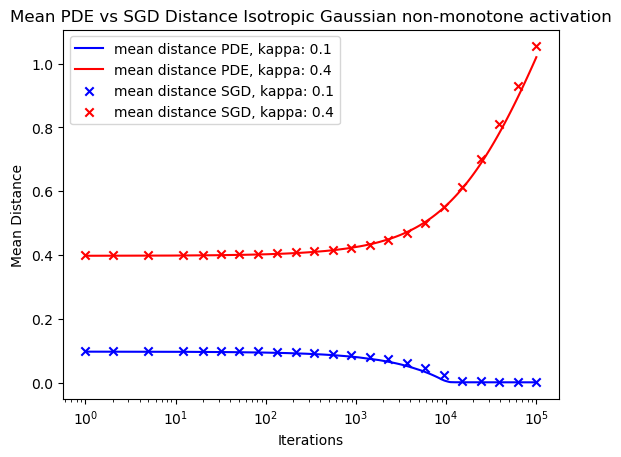

In [118]:
#plot mean distance of network parameters and PDE particles
fig, ax = plt.subplots()
ax.plot(iters, avg_dist_pde_1(iters), c = 'b', label = 'mean distance PDE, kappa: 0.1')
ax.plot(iters, avg_dist_pde_4(iters), c = 'r', label = 'mean distance PDE, kappa: 0.4')
ax.scatter(indices, mean_dist_sgd_1, marker = 'x', c = 'b', label = 'mean distance SGD, kappa: 0.1')
ax.scatter(indices, mean_dist_sgd_4, marker = 'x', c = 'r', label = 'mean distance SGD, kappa: 0.4')
ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean Distance')
ax.set_title('Mean PDE vs SGD Distance Isotropic Gaussian non-monotone activation')
ax.legend()
plt.show()

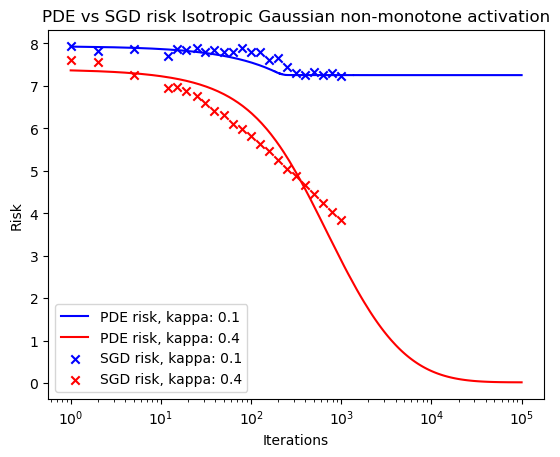

In [204]:
#plot mean risk of network parameters and PDE particles
fig, ax = plt.subplots()
ax.plot(iters, disc_pde_loss_1(iters), c = 'b', label = 'PDE risk, kappa: 0.1')
ax.plot(iters, disc_pde_loss_4(iters), c = 'r', label = 'PDE risk, kappa: 0.4')
ax.scatter(indices, risk_1, marker = 'x', c = 'b', label = 'SGD risk, kappa: 0.1')
ax.scatter(indices, risk_4, marker = 'x', c = 'r', label = 'SGD risk, kappa: 0.4')
ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Risk')
ax.set_title('PDE vs SGD risk Isotropic Gaussian non-monotone activation')
ax.legend()
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

(array([1., 2., 0., 4., 1., 4., 0., 4., 0., 4.]),
 array([7.80760399, 7.81056806, 7.81353214, 7.81649621, 7.81946029,
        7.82242437, 7.82538844, 7.82835252, 7.8313166 , 7.83428067,
        7.83724475]),
 <BarContainer object of 10 artists>)

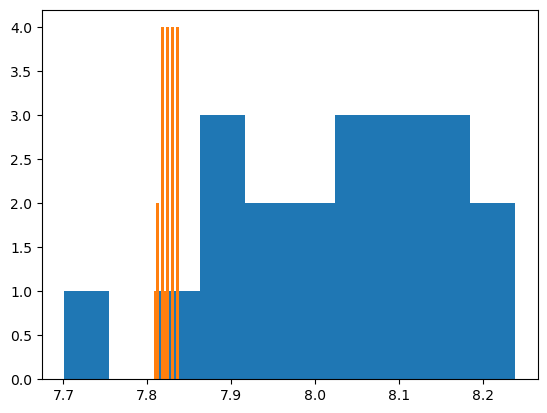

In [113]:
vals_SGD = []
vals_PDE = []
d = 320
N = 800
kappa = 0.4
Delta = 0.2
J = 400
for i in trange(20): 
    weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)
    w = np.zeros((N,d))
    M = int(1e3)
    x_sample, y_sample = random_sample(d, Delta, M)
    mse = np.mean((y_sample-neural_net_nm(x_sample,weights))**2)
    Z = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), J).reshape(J, d)
    r = np.linalg.norm(Z, axis = 1)
    plus = vq_plus(r, Delta)
    minus = vq_minus(r, Delta)
    dplus = vdq_plus(r, Delta)
    dminus = vdq_minus(r, Delta)
    risk = R_inf(plus, minus, Delta)
    dist_SGD = np.linalg.norm(weights, axis = 1)
    vals_SGD.append(mse)
    vals_PDE.append(risk)
plt.hist(vals_SGD)
plt.hist(vals_PDE)

In [200]:
w = np.zeros((N,d))
M = int(1e3)
x_sample, y_sample = random_sample(d, 0.5, M)
mse = np.mean((y_sample-neural_net_nm(x_sample,w))**2)
mse

7.36